# Семинар 14: Нейронные сети Колмогорова-Арнольда (KAN)

In [69]:
import torchvision.transforms as transforms
import plotly.graph_objects   as go
import torch.nn.functional    as F
import torch.optim            as optim
import torch.nn               as nn

import torchvision
import torch
import math

from torch.utils.data import DataLoader
from plotly.subplots  import make_subplots
from tqdm             import tqdm

Определим функция визуализации процесса настройки модели

In [70]:
def plot_training_process(
    train_losses, val_losses,
    train_accuracies, val_accuracies,
    title="Training History (Loss & Accuracy)"
):
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Loss", "Accuracy")
    )

    # ----- LEFT: LOSS -----
    fig.add_trace(
        go.Scatter(
            y=train_losses,
            mode="lines+markers",
            name="Train Loss"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            y=val_losses,
            mode="lines+markers",
            name="Val Loss"
        ),
        row=1, col=1
    )

    # ----- RIGHT: ACCURACY -----
    fig.add_trace(
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="Train Accuracy"
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Scatter(
            y=val_accuracies,
            mode="lines+markers",
            name="Val Accuracy"
        ),
        row=1, col=2
    )

    # Axes
    fig.update_xaxes(title_text="Epoch", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=1, col=1)

    fig.update_xaxes(title_text="Epoch", row=1, col=2)
    fig.update_yaxes(title_text="Accuracy", row=1, col=2)

    fig.update_layout(
        title=title,
        template="plotly_white",
        width=1000,
        height=400,
        showlegend=True
    )

    fig.show()

In [71]:
def plot_compare_models(results_dict, title="Comparison: Models Training History"):
    """
    results_dict: dict
        {
          "ModelName": {
              "train_losses": [...],
              "val_losses": [...],
              "train_acc": [...],
              "val_acc": [...]
          },
          ...
        }
    """
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Loss", "Accuracy")
    )

    # ----- LEFT SUBPLOT: LOSS -----
    for model_name, metrics in results_dict.items():
        fig.add_trace(
            go.Scatter(
                y=metrics["train_losses"],
                mode="lines+markers",
                name=f"{model_name} Train Loss"
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                y=metrics["val_losses"],
                mode="lines+markers",
                name=f"{model_name} Val Loss"
            ),
            row=1, col=1
        )

    # ----- RIGHT SUBPLOT: ACCURACY -----
    for model_name, metrics in results_dict.items():
        fig.add_trace(
            go.Scatter(
                y=metrics["train_acc"],
                mode="lines+markers",
                name=f"{model_name} Train Acc"
            ),
            row=1, col=2
        )

        fig.add_trace(
            go.Scatter(
                y=metrics["val_acc"],
                mode="lines+markers",
                name=f"{model_name} Val Acc"
            ),
            row=1, col=2
        )

    # Titles and axes
    fig.update_xaxes(title_text="Epoch", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=1, col=1)

    fig.update_xaxes(title_text="Epoch", row=1, col=2)
    fig.update_yaxes(title_text="Accuracy", row=1, col=2)

    fig.update_layout(
        title=title,
        template="plotly_white",
        width=1200,
        height=450,
        showlegend=True
    )

    fig.show()

### Реализация модели Колмогорова-Арнольда

Реализация слоя `KANLinear` в одномерном случае

`B-сплайны и сетка узлов`

---

Основой `B-сплайнов` является сетка узлов
$$
  t_0 \le t_1 \le \dots \le t_M,
$$
которая разбивает область значений переменной $x$ на интервалы.
Выбор узлов определяет геометрию аппроксимации: чем плотнее сетка, тем
тоньше локальная аппроксимация.

---

Для сплайнов порядка $p$ необходима расширенная сетка.
Каждый `B-сплайн` опирается на $p+1$ узлов, поэтому при построении сетки
обычно добавляют $p$ фиктивных узлов слева и справа от рабочей области.
Это обеспечивает корректное определение краевых базисов. Например,
если рабочий диапазон $[-1,1]$ разбит на $K$ равномерных сегментов, то
шаг
$$
  h = \frac{2}{K},
$$
а расширенная сетка имеет вид
$$
  t_i = -1 - p h + i h, \qquad i = 0,1,\dots,K+2p.
$$

---

`B-сплайны` нулевого порядка определяются индикаторными функциями
$$
  N_{i,0}(x) = \mathbf{1}[\, t_i \le x < t_{i+1} \,],
$$
а для сплайнов порядка $p$ используется [`рекурсия Кокса–де Бура`](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B4%D0%B5_%D0%91%D1%83%D1%80%D0%B0):
$$
  N_{i,p}(x) =
  \frac{x - t_i}{\, t_{i+p} - t_i \,} N_{i,p-1}(x)
  +
  \frac{t_{i+p+1} - x}{\, t_{i+p+1} - t_{i+1} \,} N_{i+1,p-1}(x).
$$

---

Каждая функция $N_{i,p}$ ненулевая только на $p+1$ соседних интервалах, то есть обладает
`локальной поддержкой`. Линейная комбинация базисов
$$
  f(x) = \sum_i w_i\, N_{i,p}(x)
$$
добавляет в модель управляемую локальную гибкость, а коэффициенты $w_i$ интерпретируются как вклад отдельных регионов сетки.

In [63]:
class KANLinear_1D(nn.Module):
    """
    KAN-слой по одной координате:
    y(x) = W_base * x + b_base  +  Σ_i w_i * B_i(x)
    
    - Один входной признак (x ∈ R)
    - B-сплайны на равномерной сетке в [-1, 1]
    - Явная рекурсия Кокса–де Бура
    """
    def __init__(self, grid_size=10, spline_order=3):
        super().__init__()
        self.grid_size    = grid_size
        self.spline_order = spline_order

        # Строим равномерную сетку с запасом по краям
        # Узлы: от -1 - order*h до 1 + order*h
        h = 2.0 / grid_size
        G = grid_size + 2 * spline_order + 1
        grid = torch.linspace(-1.0 - spline_order * h, 1.0 + spline_order * h, G)

        print(grid)
        
        self.register_buffer("grid", grid)  # (G, )

        # Число базисных функций B_i,p: n_basis = G - order - 1
        self.n_basis = G - spline_order - 1

        # Веса сплайновой части
        self.spline_weight = nn.Parameter(torch.zeros(self.n_basis))
        nn.init.uniform_(self.spline_weight, -0.1, 0.1)
        
        # Базовая линейная ветка (как мини-MLP)
        self.base_linear = nn.Linear(1, 1)

    def bspline_basis(self, x: torch.Tensor) -> torch.Tensor:
        """
        Вычисление B-сплайнового базиса порядка self.spline_order.
        
        x: (batch, 1)
        return: (batch, n_basis)
        """
        assert x.dim() == 2 and x.size(1) == 1, "x должен быть (batch, 1)"
        x = x.squeeze(1)             # (batch,)
        t = self.grid                # (G,)
        p = self.spline_order
        n = self.n_basis             # число базисов

        # N_{i,0}(x) – нулевой порядок
        # N_i,0 = 1, если t_i <= x < t_{i+1}
        B = torch.zeros(x.size(0), n, device=x.device)  # (batch, n)
        for i in range(n):
            left  = t[i+0]
            right = t[i+1]
            B[:, i] = ((x >= left) & (x < right)).float()

        # Рекурсия по порядку p
        for k in range(1, p + 1):
            B_new = torch.zeros_like(B)  # (batch, n)
            for i in range(n):
                # Первый коэффициент
                denom1 = t[i + k] - t[i+0]
                if denom1 != 0:
                    coef1 = (x - t[i]) / denom1
                    B_new[:, i] += coef1 * B[:, i]
                # Второй коэффициент (i+1)
                if i + 1 < n:
                    denom2 = t[i + k + 1] - t[i + 1]
                    if denom2 != 0:
                        coef2 = (t[i + k + 1] - x) / denom2
                        B_new[:, i] += coef2 * B[:, i + 1]
            B = B_new

        return B  # (batch, n_basis)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, 1)
        """
        # Базовая линейная часть
        base_out = self.base_linear(x)               # (batch, 1)

        # Сплайновая часть
        B = self.bspline_basis(x)                    # (batch, n_basis)
        spline_out = (B @ self.spline_weight).unsqueeze(1)  # (batch, 1)

        return base_out + spline_out                # (batch, 1)


In [72]:
def plot_all_splines(grid_size=10, spline_order=3):
    layer = KANLinear_1D(grid_size=grid_size, spline_order=spline_order)

    xs = torch.linspace(-1., 1., 200).unsqueeze(1)  # (400, 1)
    with torch.no_grad():
        B = layer.bspline_basis(xs)  # (400, n_basis)

    fig = go.Figure()
    for i in range(B.size(1)):
        fig.add_trace(
            go.Scatter(
                x=xs.squeeze().numpy(),
                y=B[:, i].cpu().numpy(),
                mode="lines",
                name=f"B_{i}"
            )
        )

    fig.update_layout(
        title=f"B-splines (order={spline_order}, grid_size={grid_size})",
        xaxis_title="x",
        yaxis_title="basis value",
        template="plotly_white"
    )
    fig.show()

tensor([-1.6000, -1.4000, -1.2000, -1.0000, -0.8000, -0.6000, -0.4000, -0.2000,
         0.0000,  0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,  1.4000,
         1.6000])


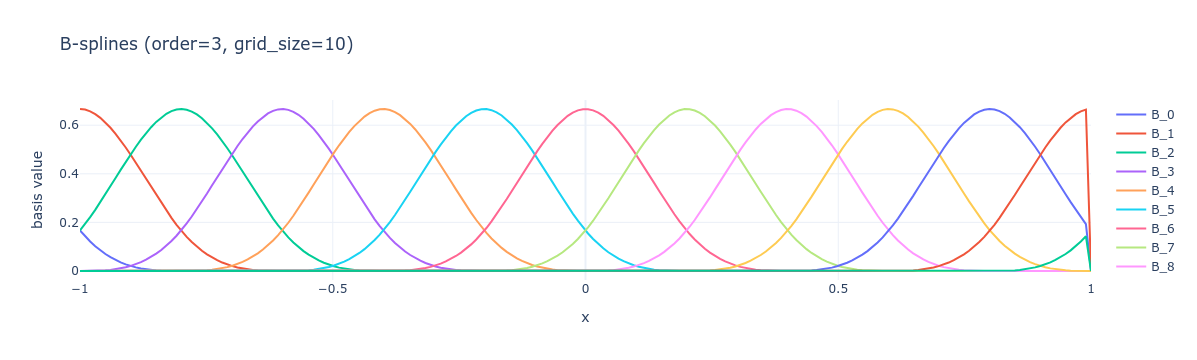

In [73]:
plot_all_splines()

In [78]:
layer = KANLinear_1D(grid_size=10, spline_order=3)
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)

xs = torch.linspace(-1.0, 1.0, 10).unsqueeze(1)   # (200, 1)
ys = torch.sin(3 * xs)                             # (200, 1)

loss_history = []

for step in range(2000):
    optimizer.zero_grad()
    pred = layer(xs)
    loss = ((pred - ys) ** 2).mean()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (step + 1) % 200 == 0:
        print(f"Step {step+1}: loss = {loss.item():.6f}")

tensor([-1.6000, -1.4000, -1.2000, -1.0000, -0.8000, -0.6000, -0.4000, -0.2000,
         0.0000,  0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,  1.4000,
         1.6000])
Step 200: loss = 0.000640
Step 400: loss = 0.000007
Step 600: loss = 0.000000
Step 800: loss = 0.000000
Step 1000: loss = 0.000000
Step 1200: loss = 0.000000
Step 1400: loss = 0.000000
Step 1600: loss = 0.000000
Step 1800: loss = 0.000000
Step 2000: loss = 0.000000


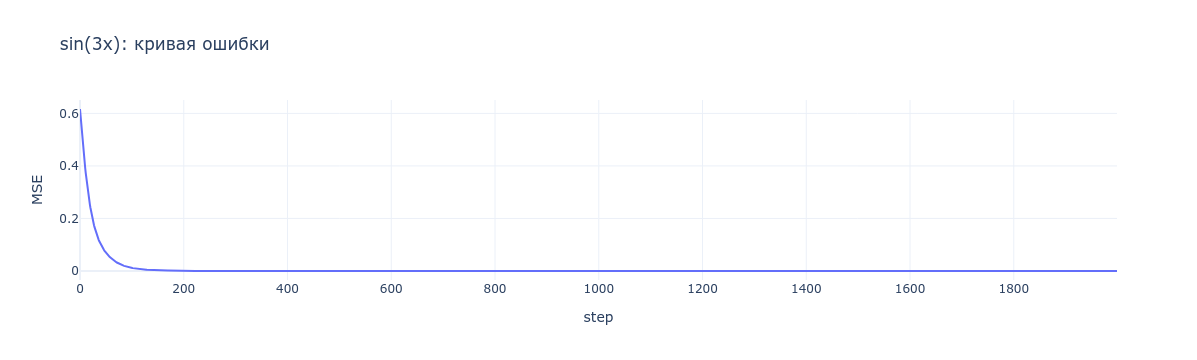

In [80]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_history))),
        y=loss_history,
        mode="lines",
        name="MSE"
    )
)
fig.update_layout(
    title="sin(3x): кривая ошибки",
    xaxis_title="step",
    yaxis_title="MSE",
    template="plotly_white"
)
fig.show()

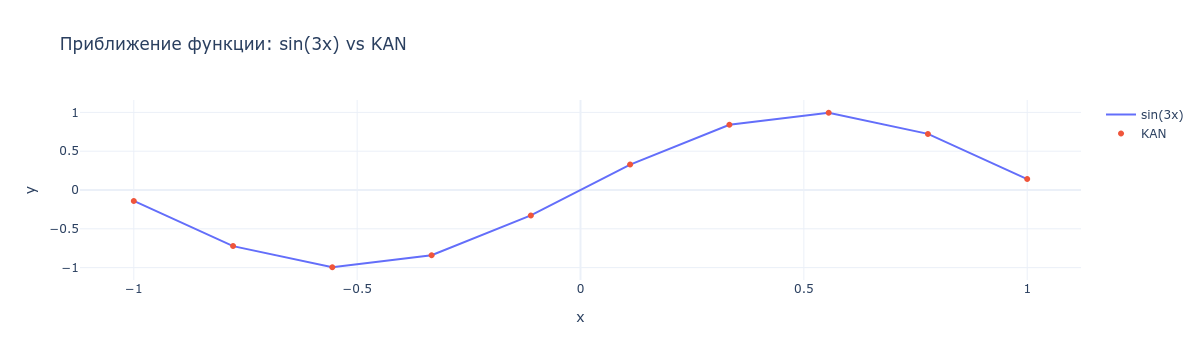

In [81]:
with torch.no_grad():
    pred = layer(xs)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=xs.squeeze().numpy(),
        y=ys.squeeze().numpy(),
        mode="lines",
        name="sin(3x)"
    )
)
fig.add_trace(
    go.Scatter(
        x=xs.squeeze().numpy(),
        y=pred.squeeze().numpy(),
        mode="markers",
        name="KAN"
    )
)
fig.update_layout(
    title="Приближение функции: sin(3x) vs KAN",
    xaxis_title="x",
    yaxis_title="y",
    template="plotly_white"
)
fig.show()

Общая реализация слоя `KANLinear`

In [82]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features
        self.grid_size    = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


Описываем модель `MLP`

In [83]:
class MLP(nn.Module):
    def __init__(
        self,
        layers_hidden,
        base_activation=nn.SiLU,   # чтобы совпадало с KAN
        dropout=0.0,               # опционально
        layer_norm=False           # опционально
    ):
        super().__init__()

        layers = []
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            layers.append(nn.Linear(in_features, out_features))
            if layer_norm:
                layers.append(nn.LayerNorm(out_features))
            layers.append(base_activation())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def regularization_loss(self, *args, **kwargs):
        # совместимость интерфейсов
        return torch.tensor(0.0, device=next(self.parameters()).device)

Описываем нейронную сеть `KAN`

In [84]:
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


Загружаем набор данных `MNIST`

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

Определяем модель `KAN`

In [86]:
# Define model
model = KAN([28 * 28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define loss
criterion = nn.CrossEntropyLoss()

Реализуем процесс настройки модели

In [87]:
total_result_s = dict()

NUM_EPOCH = 20

In [88]:
kan_train_losses, kan_train_accuracies = [], []
kan_val_losses  , kan_val_accuracies   = [], []

for epoch in range(NUM_EPOCH):
    # -------- TRAIN --------
    model.train()
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0

    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == labels).float().mean()

            epoch_train_loss += loss.item()
            epoch_train_acc  += acc.item()

            pbar.set_postfix(
                loss=loss.item(),
                accuracy=acc.item(),
                lr=optimizer.param_groups[0]['lr']
            )

    epoch_train_loss /= len(trainloader)
    epoch_train_acc  /= len(trainloader)
    kan_train_losses.append(epoch_train_loss)
    kan_train_accuracies.append(epoch_train_acc)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            output = model(images)
            val_loss += criterion(output, labels).item()
            val_acc  += (output.argmax(dim=1) == labels).float().mean().item()

    val_loss /= len(valloader)
    val_acc  /= len(valloader)

    kan_val_losses.append(val_loss)
    kan_val_accuracies.append(val_acc)

    # -------- LR DECAY --------
    scheduler.step()

    print(
        f"Epoch {epoch+1}, "
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:23<00:00, 40.34it/s, accuracy=0.875, loss=0.213, lr=0.001]


Epoch 1, Train Loss: 0.3894, Train Acc: 0.8883, Val Loss: 0.2309, Val Acc: 0.9312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:23<00:00, 40.02it/s, accuracy=0.844, loss=0.291, lr=0.0008]


Epoch 2, Train Loss: 0.1849, Train Acc: 0.9476, Val Loss: 0.1642, Val Acc: 0.9504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.34it/s, accuracy=0.906, loss=0.229, lr=0.00064]


Epoch 3, Train Loss: 0.1268, Train Acc: 0.9631, Val Loss: 0.1286, Val Acc: 0.9630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.95it/s, accuracy=1, loss=0.0509, lr=0.000512]


Epoch 4, Train Loss: 0.0963, Train Acc: 0.9727, Val Loss: 0.1132, Val Acc: 0.9654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.85it/s, accuracy=1, loss=0.0173, lr=0.00041]


Epoch 5, Train Loss: 0.0776, Train Acc: 0.9786, Val Loss: 0.1011, Val Acc: 0.9687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.08it/s, accuracy=0.969, loss=0.0659, lr=0.000328]


Epoch 6, Train Loss: 0.0642, Train Acc: 0.9822, Val Loss: 0.0998, Val Acc: 0.9703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.72it/s, accuracy=0.938, loss=0.0828, lr=0.000262]


Epoch 7, Train Loss: 0.0543, Train Acc: 0.9857, Val Loss: 0.0919, Val Acc: 0.9739


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.47it/s, accuracy=0.969, loss=0.0297, lr=0.00021]


Epoch 8, Train Loss: 0.0471, Train Acc: 0.9883, Val Loss: 0.0911, Val Acc: 0.9722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 42.96it/s, accuracy=0.969, loss=0.0555, lr=0.000168]


Epoch 9, Train Loss: 0.0415, Train Acc: 0.9902, Val Loss: 0.0890, Val Acc: 0.9735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.51it/s, accuracy=1, loss=0.0113, lr=0.000134]


Epoch 10, Train Loss: 0.0372, Train Acc: 0.9914, Val Loss: 0.0866, Val Acc: 0.9753


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.21it/s, accuracy=1, loss=0.0129, lr=0.000107]


Epoch 11, Train Loss: 0.0339, Train Acc: 0.9928, Val Loss: 0.0863, Val Acc: 0.9744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.64it/s, accuracy=1, loss=0.0316, lr=8.59e-5]


Epoch 12, Train Loss: 0.0312, Train Acc: 0.9935, Val Loss: 0.0851, Val Acc: 0.9738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 42.64it/s, accuracy=1, loss=0.0515, lr=6.87e-5]


Epoch 13, Train Loss: 0.0292, Train Acc: 0.9942, Val Loss: 0.0858, Val Acc: 0.9730


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.04it/s, accuracy=1, loss=0.0228, lr=5.5e-5]


Epoch 14, Train Loss: 0.0276, Train Acc: 0.9949, Val Loss: 0.0860, Val Acc: 0.9738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.95it/s, accuracy=1, loss=0.01, lr=4.4e-5]


Epoch 15, Train Loss: 0.0264, Train Acc: 0.9954, Val Loss: 0.0845, Val Acc: 0.9749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.20it/s, accuracy=1, loss=0.037, lr=3.52e-5]


Epoch 16, Train Loss: 0.0254, Train Acc: 0.9957, Val Loss: 0.0840, Val Acc: 0.9751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.17it/s, accuracy=1, loss=0.018, lr=2.81e-5]


Epoch 17, Train Loss: 0.0246, Train Acc: 0.9959, Val Loss: 0.0846, Val Acc: 0.9743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.33it/s, accuracy=0.969, loss=0.0879, lr=2.25e-5]


Epoch 18, Train Loss: 0.0240, Train Acc: 0.9962, Val Loss: 0.0843, Val Acc: 0.9749


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.38it/s, accuracy=1, loss=0.014, lr=1.8e-5]


Epoch 19, Train Loss: 0.0235, Train Acc: 0.9963, Val Loss: 0.0843, Val Acc: 0.9746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.42it/s, accuracy=0.969, loss=0.0589, lr=1.44e-5]


Epoch 20, Train Loss: 0.0231, Train Acc: 0.9964, Val Loss: 0.0843, Val Acc: 0.9746


In [89]:
total_result_s["KAN"] = {
 "train_losses": kan_train_losses,
 "val_losses": kan_val_losses,
 "train_acc": kan_train_accuracies,
 "val_acc": kan_val_accuracies,
}

Визуализируем полученные результаты

In [12]:
plot_training_process(
    kan_train_losses, kan_val_losses,
    kan_train_accuracies, kan_val_accuracies
)

Определяем модель `MLP`

In [13]:
#Model
model = MLP([28*28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Loss
criterion = nn.CrossEntropyLoss()

Настраиваем модель `MLP`

In [14]:
mlp_train_losses, mlp_train_accuracies = [], []
mlp_val_losses  , mlp_val_accuracies   = [], []

for epoch in range(NUM_EPOCH):
    # -------- TRAIN --------
    model.train()
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0

    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == labels).float().mean()

            epoch_train_loss += loss.item()
            epoch_train_acc  += acc.item()

            pbar.set_postfix(
                loss=loss.item(),
                accuracy=acc.item(),
                lr=optimizer.param_groups[0]['lr']
            )

    epoch_train_loss /= len(trainloader)
    epoch_train_acc  /= len(trainloader)
    mlp_train_losses.append(epoch_train_loss)
    mlp_train_accuracies.append(epoch_train_acc)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            output = model(images)
            val_loss += criterion(output, labels).item()
            val_acc  += (output.argmax(dim=1) == labels).float().mean().item()

    val_loss /= len(valloader)
    val_acc  /= len(valloader)

    mlp_val_losses.append(val_loss)
    mlp_val_accuracies.append(val_acc)

    # LR decay
    scheduler.step()

    print(
        f"Epoch {epoch+1}, "
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.36it/s, accuracy=0.906, loss=0.578, lr=0.001]


Epoch 1, Train Loss: 0.5846, Train Acc: 0.8394, Val Loss: 0.4541, Val Acc: 0.8992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 52.11it/s, accuracy=0.906, loss=0.392, lr=0.0008]


Epoch 2, Train Loss: 0.4167, Train Acc: 0.9061, Val Loss: 0.3796, Val Acc: 0.9348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 52.09it/s, accuracy=0.906, loss=0.276, lr=0.00064]


Epoch 3, Train Loss: 0.3651, Train Acc: 0.9249, Val Loss: 0.3574, Val Acc: 0.9317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.62it/s, accuracy=0.938, loss=0.188, lr=0.000512]


Epoch 4, Train Loss: 0.3390, Train Acc: 0.9351, Val Loss: 0.3383, Val Acc: 0.9433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.47it/s, accuracy=1, loss=0.454, lr=0.00041]


Epoch 5, Train Loss: 0.3235, Train Acc: 0.9409, Val Loss: 0.3339, Val Acc: 0.9399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.99it/s, accuracy=0.938, loss=0.522, lr=0.000328]


Epoch 6, Train Loss: 0.3113, Train Acc: 0.9438, Val Loss: 0.3235, Val Acc: 0.9445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.14it/s, accuracy=0.906, loss=0.312, lr=0.000262]


Epoch 7, Train Loss: 0.3028, Train Acc: 0.9464, Val Loss: 0.3167, Val Acc: 0.9487


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.84it/s, accuracy=0.938, loss=0.526, lr=0.00021]


Epoch 8, Train Loss: 0.2955, Train Acc: 0.9506, Val Loss: 0.3139, Val Acc: 0.9448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.58it/s, accuracy=0.969, loss=0.338, lr=0.000168]


Epoch 9, Train Loss: 0.2907, Train Acc: 0.9517, Val Loss: 0.3111, Val Acc: 0.9473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.65it/s, accuracy=0.875, loss=0.575, lr=0.000134]


Epoch 10, Train Loss: 0.2872, Train Acc: 0.9530, Val Loss: 0.3073, Val Acc: 0.9509


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.30it/s, accuracy=0.969, loss=0.249, lr=0.000107]


Epoch 11, Train Loss: 0.2837, Train Acc: 0.9540, Val Loss: 0.3095, Val Acc: 0.9489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.58it/s, accuracy=0.969, loss=0.252, lr=8.59e-5]


Epoch 12, Train Loss: 0.2816, Train Acc: 0.9546, Val Loss: 0.3066, Val Acc: 0.9511


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.60it/s, accuracy=0.969, loss=0.371, lr=6.87e-5]


Epoch 13, Train Loss: 0.2796, Train Acc: 0.9556, Val Loss: 0.3060, Val Acc: 0.9413


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.34it/s, accuracy=0.875, loss=0.339, lr=5.5e-5]


Epoch 14, Train Loss: 0.2781, Train Acc: 0.9553, Val Loss: 0.3052, Val Acc: 0.9480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.29it/s, accuracy=0.938, loss=0.289, lr=4.4e-5]


Epoch 15, Train Loss: 0.2769, Train Acc: 0.9565, Val Loss: 0.3035, Val Acc: 0.9487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.46it/s, accuracy=0.969, loss=0.22, lr=3.52e-5]


Epoch 16, Train Loss: 0.2758, Train Acc: 0.9569, Val Loss: 0.3028, Val Acc: 0.9467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 53.27it/s, accuracy=0.969, loss=0.225, lr=2.81e-5]


Epoch 17, Train Loss: 0.2751, Train Acc: 0.9569, Val Loss: 0.3030, Val Acc: 0.9484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.61it/s, accuracy=0.969, loss=0.325, lr=2.25e-5]


Epoch 18, Train Loss: 0.2745, Train Acc: 0.9575, Val Loss: 0.3017, Val Acc: 0.9472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.97it/s, accuracy=1, loss=0.0154, lr=1.8e-5]


Epoch 19, Train Loss: 0.2738, Train Acc: 0.9574, Val Loss: 0.3016, Val Acc: 0.9481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.39it/s, accuracy=0.938, loss=0.315, lr=1.44e-5]


Epoch 20, Train Loss: 0.2736, Train Acc: 0.9579, Val Loss: 0.3016, Val Acc: 0.9476


In [15]:
total_result_s["MLP"] = {
 "train_losses": mlp_train_losses,
 "val_losses": mlp_val_losses,
 "train_acc": mlp_train_accuracies,
 "val_acc": mlp_val_accuracies
}

In [16]:
plot_training_process(
    mlp_train_losses, mlp_val_losses,
    mlp_train_accuracies, mlp_val_accuracies
)

Сравним графики процесса настройки моделей `KAN` и `MLP`

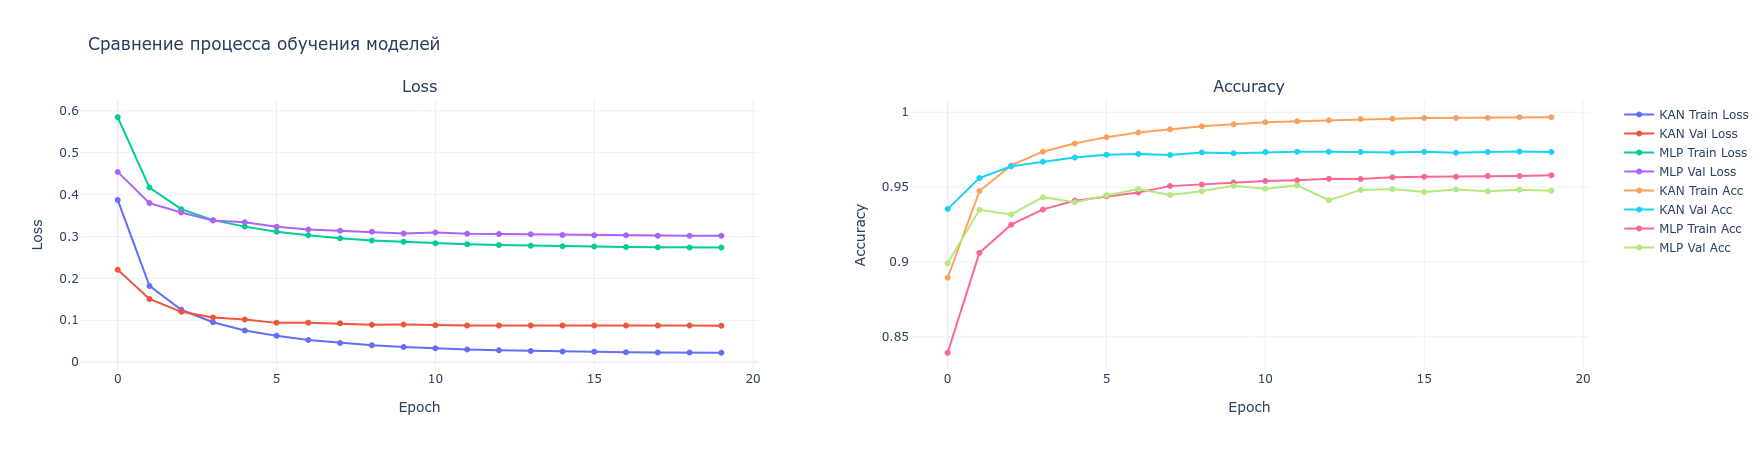

In [68]:
plot_compare_models(total_result_s, title="Сравнение процесса обучения моделей")

# Семинар 14: Графовые нейронные сети

In [18]:
!pip install networkx

In [19]:
import plotly.graph_objects as go
import plotly.express       as px
import networkx             as nx
import os.path              as osp
import pandas               as pd
import numpy                as np

import torch_geometric.transforms as T

import random
import torch
import math

from plotly.subplots import make_subplots

from torch_geometric.datasets import Planetoid
from torch_geometric.utils    import to_networkx
from torch_geometric.utils    import negative_sampling
from torch_geometric.nn       import GCNConv, GCN2Conv, SAGEConv, GATConv
from torch_geometric.datasets import Planetoid
from torch.nn                 import Linear

import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torch_geometric/typing.py:86: UserWarning:

An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning:

An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev



## Задача на ребрах графа

Мы рассмотрели множество примеров представления данных в виде графов, познакомились с задачами, возникающие на вершинах, рёбрах и графе в целом.

Теперь давайте перейдём к более сложной задаче. Рассмотрим  набор данных `Cora Dataset`, он состоит из коллекции научных публикаций, отнесенных к одному из семи классов, структурирован в виде сети цитирования. Каждая публикация (вершина графа) в наборе данных описывается разреженным вектором, который кодирует информацию о наличии или отсутствии определенных слов в документе.  Граф является однонаправленным, ребра между вершинами отражают отношения цитирования между ними и направлены от цитирующей статьи к цитируемой статье. 

Будем решать задачу логистической регрессии на ребрах графа, предсказывать наличие связи цитирования между парой публикаций.

### Загрузка и предварительный анализ набора данных `Cora Dataset`

In [20]:
# Загрузка набора данных Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
# Преобразование исходного набора данных в граф NetworkX формата
G = to_networkx(data, to_undirected=True, node_attrs=['x'])

Processing...
Done!


Задание:

- Напечатать общую информацию о графе (общее число вершин, общее число ребер)
- Напечатать информацию о вершинах графа
- Напечатать информацию о ребрах графа


In [21]:
### START WORKSHOP CODE
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Общее число вершин: {num_nodes}, Общее число ребер: {num_edges}" )
### END WORKSHOP CODE

Общее число вершин: 2708, Общее число ребер: 5278


In [22]:
### START WORKSHOP CODE
for node, attribute in G.nodes(data=True):
    print(f"Вершина: {node}, Характеристика: {attribute}")
    break
### END WORKSHOP CODE

Вершина: 0, Характеристика: {'x': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [23]:
### START WORKSHOP CODE
for u, v, attributes in G.edges(data=True):
    print(f"Ребро между ({u},{v}), Характеристика: {attributes}")
    break
### END WORKSHOP CODE

Ребро между (0,633), Характеристика: {}


Визуализируем графовую структуру

In [26]:
pos = nx.spring_layout(G)
# Извлечение положений вершин
x_nodes = [pos[i][0] for i in range(len(pos))]
y_nodes = [pos[i][1] for i in range(len(pos))]

# Извлечение положений ребер
x_edges, y_edges = [], []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]

# Визуализируем вершины
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers',
    marker=dict(size=10, color=data.y.numpy(), colorscale='Viridis', showscale=True),
    text=[f'Node {i}' for i in range(len(pos))],
    hoverinfo='text'
)

# Визуализируем ребра
edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Создаем общий график
fig = go.Figure(data=[edge_trace, node_trace],
 layout=go.Layout(
  title='Cora Dataset Visualization',
  #titlefont_size=16,
  showlegend=False,
  hovermode='closest',
  margin=dict(b=20,l=5,r=5,t=40),
  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
  width = 600, height = 600
))

fig.show()

### Предобработка входных данных

Задание:

Воспользуемся функциональностью модуля `torch_geometric.transforms` и реализуем следующий конвейер предобработки данных. Пержде всего выполним нормализацию векторов, хранящихся в вершинах графа, преобразование `T.NormalizeFeatures`. Исходный набор ребер графа мы разбиваем на три группы: тренировочная выборка, валидационная выборка и оставшиеся ребра в тестовой выборке, преобразование `T.RandomLinkSplit`

In [27]:
### START WORKSHOP CODE
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.2, is_undirected=True, add_negative_train_samples=False),
])
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, name='Cora', transform=transform)
# After applying the RandomL∈kSplitRandomLinkSplit transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]
### END WORKSHOP CODE

Processing...
Done!


Наша графовая нейронная сеть будет иметь следующий интерфейс:

- Инициализация (`__init__`):

    Инициализация необходимых модулей и слоев сети.

- Функция кодирования (`encode`):

    Принимает на вход матрицу признаков вершин графа `x` и индексы рёбер `edge_index`.

    Обрабатывает входные данные согласно архитектуре модели.
    
    Возвращает закодированное представление вершин графа.

- Функция декодирования (`decode`):

    Принимает закодированное представление вершин `z` и индексы рёбер для предсказания связей `edge_label_index`.
    
    Вычисляет скалярное произведение между представлениями пар вершин, указанных в `edge_label_index`, суммируя результаты по последней размерности.
    
    Возвращает значения, которые могут интерпретироваться как оценки наличия рёбер между соответствующими узлами.
    
- Функция декодирования всех связей (`decode_all`):

    Вычисляет матрицу вероятностей смежности (`prob_adj`) путём умножения закодированного представления узлов z на его транспонированную версию.

    Возвращает индексы пар узлов, для которых значение в prob_adj больше нуля, указывая на предсказанные связи между этими узлами.

Общая схема модели представлена на изображении

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABA4AAAJFCAIAAADS8yKCAACAAElEQVR4XuzdB1hUx9oH8ENx7dJZ
OoIIdhHFhhq7xhL1akzU2KOJFes1xBhLLLGEaDR2Y/fDLjGWqMQSe+81il0sQVFEOt/A3mzW2WXZ
csrs2f/vmceHnTk7e2bOOvO+sIXLAQAAAAAA0MLRFQAAAAAAAEgVAAAAAABAJ6QKAAAAAACgA1IF
AAAAAADQAakCAAAAAADogFQBAAAAAAB0QKoAAAAAAAA6IFUAAAAAAAAdkCoAAAAAAIAOSBUAAAAA
AEAHpAoAAAAAAKADUgUAAAAAANABqQIAAAAAAOiAVAEAAAAAAHRAqgAAAAAAADogVQAAAAAAAB2Q
KgAAAAAAgA5IFQAAAAAAQAekCgAAAAAAoANSBRDcu3fvHjx4oPo5OTn58ePH77cDAFg1LJIAwCyk
CpZh165dHf/RuXPnoUOHbty4MSsriz6OSQkJCZ6enrdu3SLbYd++fcePH08fIaIBAwYsX76crgUA
hln0AmgIphbJHKyTAKABqYJlmDt3Lsdx7du379mz52effVarVi1ys02bNpayWc6cObNo0aI2Njb1
6tVLTEykm0Xk7+8fGRlJ1wIAwyx9ATQEO4tkDtZJANCAVMEyqHbKa9euqWvGjx9Pak6cOKFxFNPI
pv7u3Tu6VnTYAgEsjgwWQEMwskjmYJ0EAA1IFSyD9k65d+9eUrN161by89u3b9u3bz9y5Eh1682b
Nxs1aqT+C/Lhw4ebNGni5OTk7u7euXPn27dvq49U6dWr1wfve/Xqlapp/vz5HTp00Dx448aN5IDM
zEx1jZ7+yd07deqkvvnw4UNyYi1btlTXaCIHU6cxbdo0VT05h3PnzjVs2NDR0TEkJGThwoWad7x6
9SoZQnBwsIODQ4UKFUaNGvXmzRt167x583x9fX18fFauXEm2wEGDBn3++efkbKtXr3769GmNbgCA
RfoXwBxdy5TKlStXyDJC/s1heJ00apHMMXWd1L9I5mCdBIB8IFWwDNROSfa8Ll26FClSRP3ut82b
N5MDfvnll5y8d8iFhoZWqVJF9Qsqsj8pFIq6devGxMQsW7bMz89PqVQ+efLkn75zVaxYsV69ekvy
9O3bl3T1/PlzVRPZWcnxmgf/+OOP5ICMjAzVTf39k7t7e3ur70s2SHLf4sWLq2s0kYNLlSqlOg2V
gwcPqupLlChBtrGZM2f+9ttvZMMjnaxatUp9x3Xr1vXu3XvFihW7du2Kjo4mOzHZLFVNsbGx5OAh
Q4aQO5JKMmmkqxEjRmzbti0iIsLV1TUpKUndDwAwqMAFUHuZUjl27Bi5I/lXdZPNddKoRTLH1HVS
zyKZg3USAPKHVMEyqHZKsruUKVOmdOnSZB0PCAgge4/mMYMHDy5WrNiVK1e++OILss2ot1Wy7pN9
SP137Rs3btjZ2ZE94N975uQEBwf369dP9fPq1auN2gL196+5C8bFxdna2rZr1y6/XVD7sdT15BHJ
jqiuadOmDZkHzd/YadqxYwc5/vLly+TnOnXqtGrVSlVPdjsnJ6eOHTuqbr569apo0aJkW1XfEQAY
VOACmN/SQaUKOUyuk0Ytkjm6Hktdb/g6qblI5mCdBID8IVWwDKqd8ptvviE//PTTT1999RXZWqpX
r/7s2TP1MampqWFhYR4eHuTIlStXqirT0tLs7e1HavzNnWjQoEHVqlU1a0hvQ4cOVf2svQW6uLic
0zBq1Cj1Flhg/+pdMD09vXz58mR7/u677/LbBfVvgcnJyeqamJgYUnPnzh11zd9//01GTTofM2bM
oEGDSOumTZuysrIKFSqkuclRr8GNiIjQ/NM/ADCowAVQc5m6ffs2WZdU9dqpAoPrpFGLZI4Z66TO
RTIn7z0SWCcBID9IFSyD9kt179+/r1AoyHKvcVTuq2PJYaGhoeqahIQEUvPjjz9qHJXTrVs3T09P
9U2yT5BtbPLkyaqb2lsguVlYAzlYvQUW2L96F5w+fTrZSslepWcX1LMFOjo6atb8+eef5HFVf3Yn
du/eXaxYsXLlynXt2rV///49e/YkrWQgT548IT8sW7ZMfUdqC2zbtm3t2rXVNwGAQQUugJrLFJf3
6h2SV+ToShVy2FsnjVokc0xdJ/NbJEkT1kkA0AOpgmXQ3imJsmXLVq9eXX3z5cuXpUuXDgoKUm8A
OXnf5kNufvvtt+rDiJYtW5L7qm9evnyZ++fXSzm6tkA9f1gvsH/VLvjw4cMSJUosXryY1OjZBbUf
S11vZ2en/lN+zj+vrL169arqZkhISPv27dWtV65cUU1CamqqjY0NmT11E7UFNmnSRP1ndwBgU4EL
oObSkZKSMmHCBHL8rl27tFMFBtdJoxbJHF2Ppa7Xs07mt0jm5P2lBeskAOQHqYJl0N4p//7776JF
izZq1Ehd85///Mfd3f3Jkyeff/452XJu3Lihqi9fvnytWrXUh7169apUqVLdunVT10yfPr1QoULq
Pc+oLTCnoP5Vu2Dnzp3Dw8Ozs7Nz9O6C2o+lriePuHfvXnXN4MGDS5YsqXrhL+nW3t5e86/n0dHR
6l2Q7Hl9+/ZV1ZMjPT09v/jiC9XNzMxMMmPDhw9X3xEAGFTgAkgtHY8fPybHz5kzRztVYHCdNGqR
zNH1WOr6/NZJ/YtkDtZJAMgfUgXLoNopFyxYsH379l9//XXRokWhoaGkZsOGDeoDbGxsfv/995y8
X6pVqlSJHJCamkpuLl26lBw5ZsyYp0+f3rlzp1WrVnZ2dqoPv0tLS9u1a5eTk1OzZs2u/WPGjBmq
zZX0k6NrW6K2QD395+TdnWxRtra2p06dUtXo2QW1H0tdTzZpsteSbpOTk1etWlW4cOGxY8eqD6ha
tSoZ8s2bN9++fRsTE6N6IbJqF5w2bVqRIkW2bt1KmiIjI8kskQiDzGFSUhLZ/MiJXb9+/d9HAgD2
FLgAkiXC1dVVtYIdP368a9eu5L/2yZMnqVSBzXXSqEUyR9djqev1rJN6FskcrJMAkD+kCpZBtVOq
ubu7N2rUiOxeqtZz586RLSEqKkp9/NWrV4sVKzZw4EDVzSlTppB1X33fjRs3qurJhqfZLeXPP//M
0bUtUVtgTv795/zziy71L6hy9O6C2o+lWU/iA7KZqR6lU6dOmt9VRIIDHx8fVZO3tzfZ8Lh/dkFy
WOvWrVVN/fv39/f379atG9lNyU2yPc+ZM+ffhwEAJulfAHP+WWdUSpYsWaNGjfXr1+e8/14FZtdJ
oxbJHF2PpVmf3zqpZ5HMwToJAPlDqmAtkpOTT58+feHCBc2ti2yBdnZ2Gkf9y8XFRbUFGkhn/3xR
b41JSUmnTp26d+8efUTeb/4u5dH5yYBkpDdv3sz55zW46enpZ86cefr0KX0cAFgxneuYbNZJ/Ytk
DtZJANAFqYJV43ELFFR+v0UzAfV2PQAA/bBOAoA1Q6pg1d69e3f8+HG6Ns/p06dfv35N10oEWyAA
SAXrJABYM6QKYAEuXry4fft2utYkO3fuPH/+PF0LAGDhsE4CgBCQKgAAAAAAgA5IFQAAAAAAQAek
CgAAAAAAoANSBQAAAAAA0AGpAgAAAAAA6IBUAQAAAAAAdECqAAAAAAAAOiBVAAAAAAAAHZAqAAAA
AACADkgVAAAAAABAB6QKAAAAAACgA1IFAAAQT0RERNmyQbyUzp060L0DAACvkCoAAIB4ypYtm8Nx
vJTgsmXo3gEAgFdIFQAAQDxIFQAALAhSBQAAEA9SBQAAC4JUAQAAxINUAQDAgiBVAAAA8SBVEALe
LA4AAkGqAAAA4kGqIATMKgAIBKkCAACIB0GtEDCrACAQpAoAACAeBLVCwKwCgECQKgAAgHgQ1AoB
swoAAkGqAAAA4kFQKwTMKgAIBKkCWJ7atWuXLu3PS/m4Y3u6dwAQEoJaIWBWAUAgSBXA8pQuXbpN
DsdLCSjtS/cOAEJCUCsEzCoACASpAlgepAoAlgtBrRAwqwAgEKQKYsALZviFVAHAciGoFQJmFQAE
glRBDAht+YX5BLBcCGqFgFkFAIEgVRADQlt+YT4BLBeCWiFgVgFAIEgVxIDQll+YTwDLhaBWCJhV
ABAIUgUxILTlF+YTwHIhqBUCZhUABIJUQQwIbfmF+QSwXAhqhYBZBQCBIFUQA0JbfmE+ASwXgloh
YFYBQCBIFcSA0JZfmE8Ay4WgVgiYVQAQCFIFMSC05RfmE8ByIagVAmYVAASCVEEMCG35hfkEsFwI
aoWAWQUAgSBVEANCW35hPgEsF4JaIWBWAUAgSBXEgNCWX5hPAMuFoFYImFUAEAhSBTEgtOUX5hPA
cjk4OPj7efNSwqtXpnu3VkgVAEAgSBXEgNCWX5hPAMuFoFYImFUAEAhSBTEgtOUX5hPAciGoFQJm
FQAEglRBDAht+YX5BLBcCGqFgFkFAIEgVRADQlt+YT4BLBeCWiFgVgFAIEgVxIDQll+YTwDLhaBW
CHizOAAIBKmCGBDa8gvzCWC5kCoIAbMKAAJBqiAGhLb8wnwCWC4EtULArAKAQJAqiAGhLb8wnwCW
C0GtEDCrACAQpApiQGjLL8wngOVCUCsEzCoACASpghgQ2vJLoVB4erjyUqpVLU/3DgBCQlArBMwq
AAgEqYIYkCrwC/MJYLkQ1AoBswoAAkGqIAaEtvzCfAJYLgS1QsCsAoBAkCqIAS+Y4RdSBQDLhaBW
CJhVABAIUgUxILTlF+YTwHIhqBUCZhUABIJUQQwIbfmF+QSwXAhqhYBZBQCBIFUQA0JbfmE+ASwX
glohYFYBQCBIFcSA0JZfmE8Ay4WgVgiYVQAQCFIFMSC05RfmE8ByIagVAmYVAASCVEEMCG35hfkE
sFwIaoWAWQUAgSBVEANCW35hPgEsF4JaIWBWAUAgSBXEgNCWX5hPsBIRERFlywbxUjp36kD3LhEE
tULArAKAQJAqiAGhLb8wn2AlZBn/yXJQksOsAoBAkCqIAaEtvzCfYCVkGf/JclCSw6wCgECQKogB
oS2/MJ9gJWQZ/zk4OJQoUZyX4umppHu3VrJ8qgAAC5AqiAGhLb8wn2AlZBn/yXJQksOsAoBAkCqI
AaEtvzCfYCVkGf/JclCSw6wCgECQKogBoS2/MJ9gJWQZ/8lyUJLDrAKAQJAqiAGhLb8wn2AlZBn/
yXJQksOsAoBAkCqIAaEtvzCfYCVkGf/JclCSw5vFAUAgSBXEgNCWX5hPsBKyjKplOSjJYVYBQCBs
pQq1a9cuXdqfl/Jxx/Z079JBaMsvzCdYCVnGf7IclOQwqwAgELZSBbmGgHIdl1Qwn2AlZBn/yXJQ
ksOsAoBAkCqIQa7jkgrmE6yELOM/WQ5KcphVABAIUgUxyHVcUlEoFPb2drwUZ2dHuncAZsgy/pPl
oCSHWQUAgSBVEINcxyUVzCdYCVnGf7IclOQwqwAgEKQKYpDruKSC+QQrIcv4T5aDkhxmFQAEglRB
DHjBDL/k+jwBoMgy/pPloCSHWQUAgSBVEINcxyUVzCdYCVnGf7IclOQwqwAgEKQKYpDruKSC+QQr
Icv4T5aDkhxmFQAEglRBDHIdl1Qwn2AlZBn/yXJQksOsAoBAkCqIQa7jkgrmE6yELOM/WQ5KcphV
ABAIUgUxyHVcUsF8gpWQZfwny0FJDrMKAAJBqiAGuY5LKphPsBKyjP9kOSjJYVYBQCBIFcQg13FJ
BfMJVkKW8Z8sByU5zCoACASpghjkOi6pYD7BSsgy/pPloCSHWQUAgSBVEINcxyUVzCdYCVnGf7Ic
lOQwqwAgEKQKYpDruKSC+QQr4eDg4O/nzUsJr16Z7l0iCGqFgFkFAIEgVRCDXMclFcwnWAlZxn+y
HJTkMKsAIBCkCmKQ67ikgvkEKyHL+M/BwcHFxZmXEhToT/durWT5VAEAFiBVEINcxyUVzCdYCVnG
f0gVhCDLpwoAsACpghjkOi6pYD7BSsgy/pPloCSHWQUAgSBVEINcxyUVzCdYCVnGf7IclOQwqwAg
EKQKYpDruKSC+QQrIcv4T5aDkhxmFQAEglRBDHIdl1Qwn2AlZBn/yXJQksM7QABAIEgVxCDXcUkF
8wlWQpZRtSwHJTmkCgAgELZSBYVC4enhykupVrU83bt0ENryC/MJVkKWUbUsByU5zCoACIStVEGu
IaBcxyUVzCdYCVnGf7IclOQwqwAgEKQKYpDruKSC+QQrIcv4T5aDkhxmFQAEglRBDHIdl1QUCkXx
4kV5KX4+nnTvAMyQZfwny0FJDrMKAAJBqiAGuY5LKphPsBKyjP9kOSjJ8Tirrq4uHTp0WL9+fUpK
Cv0wAGB9kCqIQa7jkgrmE6wEj/EfO1G1LAclOR5nNahMwPLly5s3b+7g4NC9e/cdO3akp6fTjwcA
VgOpghjwghl+yfV5AkDhMf5jJ6qW5aAkJ8SsPn369Oeff65fv76Li0v//v3379+fnZ39/sMCgPwh
VRCDXMclFcwnWAkh4j/JyXJQkhN0Vu/fvz9jxoywsDBvb+/hw4efOHGCOgAAZAypghjkOi6pYD7B
Sgga/0lFloOSnDizeuPGjQkTJgQHBwcGBo4bN+7KlSv0EQAgO0gVxCDXcUkF8wlWQpz4T2SyHJTk
RJ7VM2fOjB492tfXt0qVKlOnTo2Pj6ePAAC5QKogBrmOSyqYT7ASIsd/4pDloCQn1aweOnRo4MCB
7u7uderUmTNnzpMnT+gjAMDCIVUQg1zHJRXMJ1gJqeI/QclyUJKTdlYzMjJ+//33Xr16OTo6Nm7c
eNmyZYmJifRBAGCZkCqIQa7jkgrmE6yEtPGfQGQ5KMkxMqvv3r3bvHnzxx9/7ODg8NFHH61du/bt
27f0QQBgUZAqiEGu45IK5lNMnJDoB4P3MRL/8UuWg5Ica7OanJy8atWqVq1akZyhS5cusbGxaWlp
9EEAYAnY2qrlGgLKdVxSwXyKKTegPy1IQapQINbiP17IclCS43FW3Vxdjh07Rj+AqV68eLFo0aKG
DRs6Ozv36dMnLi4uKyuLPggAGMbWVi3XEFCu45IK5lNMSBUk5ODgUKJEcV6Kp6eS7l0iPAa1SBXU
eJxVb29PDw+Py5cv049hnocPH/7www/h4eGk86FDhx45coQ+AgCYxNZWLdcQUK7jkgrmU0xIFSTE
Y/zHTlQty0FJjt9Z/b//+z9fX9+7d+/SD8OH27dvT5o0qUKFCmQlj4qKunDhAn0EALCEra1ariGg
XMclFcynmJAqSIjf+I/uXSKyHJTkeJ/VefPmBQcHP3v2jH4k/pAkgaQKZD0naQNJHkgKQR8BAAxg
a6uWawgo13FJBfMpJqQKEuI9/mOBLAclOSFmdcKECWFhYUlJSe8/FP+OHDkydOhQDw+P8PDwH374
4eHDh/QRACAdtrZquYaAch2XVDCfYkKqICEh4j/JOTg4eHooeSmVKoTQvVsrgZ4qgwYNatSo0bt3
7zQeSihZWVlxcXF9+vRxdnZu2LDhokWLXrx4QR8EAKJja6uWawgo13FJBfMpJqQKEhIo/pOWLAcl
OYFmlYTvXbp06dChQ2ZmpsajCSstLS02NpY8LskqW7VqtWrVquTkZPogABALW1u1XENAuY5LKphP
MSFVkJBA8Z8eMTExY8eOzc7Ophv4I/6grIFws5qent6yZcu+fftqVorj7du3a9eu/eijj0jO8PHH
H2/evFmcv28AgCa2tmq5hoByHZdUMJ9iQqogIeHiv/zUrl3b1tZW0Dezij8oayDorJKQnTwxxowZ
Q9WLJjExcdmyZY0bN3Z0dOzVq9fvv/+ekZFBHwQAwmBrq5ZrCCjXcUkF8ykmpAoSEjT+0+n+/ftH
jx6la3kl/qCsgdCz+vfff1esWHHmzJl0g7iePHkyZ86cOnXquLu7Dxw48NChQ/QRWtLT0/fs2UPX
AoDB2NqqFQqFvb0dL8XZ2ZHuXToIbfmF+RQTUgUJCR3/SUKWg5KcCG8Wf/jwYUBAwPLly+kGKcTH
x0+dOrVKlSq+vr6jR48+c+YMfYSGqlWrrlq1iq4FAMOwtVWLHwKuXbv2m2++EfSFuTlSjEveMJ9i
QqogIVlG1bIclOTEmdWbN296enrGxsbSDdK5cuXKuHHjAgMDg4ODJ0yYcOPGDfqInJyePXva2Nh8
//33dAMAGICtrVr8EDA8PNzOzk7oT2QTf1zyhvkUE1IFCYkT/4lMloOSnGizeubMGXd39wMHDtAN
Ujtx4sTw4cO9vb3DwsJmzJhx//59ddO8efNylxuOGzJkSFZWlsadAKBgbG3V4oeA9+7dO378OF3L
N/HHJW+YTzEhVZCQaPGfmGQ5KMmJOav79+9XKpVnz56lGxiQnZ1NTq9///4uLi7169f/+eefnz59
SrIIVapAfPzxx6mpqfTdACB/bG3Vcg0B5TouqSgUCmcnB15KSNlAund4H1IFCYkZ/4lGloOSnMiz
unXrVi8vr1u3btENzEhPT9+xY0f37t0dHByaNm1qZ2enzhYaNmz46tUr+g4AkA+2tmq5htRyHZdU
MJ9iQqogITHjv5iYmPDw8Lt379INfBNzUNZD/FldtmxZQEDAo0eP6AbGJCUlNW7cWJ0nqFSuXJn9
MwdgBFtbtVxDQLmOSyqYTzEhVZCQmPHf2LFj7ezsRHhBppiDsh6SzOr06dNJzJ2YmEg3MOP58+cN
GjSg8gQVf3//a9eu0XcAAC1sbdVyDQHxghl+yfV5wiayp2pH+byU3J5BLzHjv+zs7ISEBLrWYBkZ
GX///Tddq4uYg7IeUs3qqFGj6tat+/btW7pBClQyAMKhp54n9MOAYOip18u4o4Um1xBQruOSCuZT
TLlrilaUz0sxdrWyQlLFfybo0aNHkSJF7t27RzdosaBBWRCpZpVkmL179/7www/T09PpNtFpLimv
Xr0aMWLEhDwr8uzbt2///v3Xrl2Lj49/8+aNxv3AOMIt3aTn0zmnUYQuxl5B444Wmpgh4MqVK6tX
r/7w4UO6QQBijssaYD7FhFRBQlLFfyaYPXt23bp1DXm3qAUNyoJIOKuZmZnt2rXr1q2b0N9QVCAs
KeIQbp6RKohTjL2Cxh0tNDFDwNGjR9vb2587d45uEICY47IGmE8xIVWQkITxn3BkOSjJSTur7969
++CDD4YMGUI3iAtLijiEm2ekCuIUY6+gcUcLTcwQMDs7+9mzZ3StYU6ePNmkSRPDP1VazHFZA8yn
mJAqSEja+E8gshyUfomJiXFxcXQtrySf1aSkpGrVqk2aNIluEBGWFHEIN89IFcQpxl5B444WmqWE
gIsXLyYTvWLFCrohH5YyLkuB+RQTUgUJiRb/ifnSEdEGJY6IiIiyZYP0FweHUuTZ7uPjrd2kWTp3
6kD3bjAWZvXp06dBQUHz58+nG8SCJUUcws0zUgVxirFX0LijhWZBIaAh795Ts6BxWQTMp5iQKkhI
nPhvx44ddnZ2q1evphuEIc6gRGPIcA5x3CCOS9Kqp4o5wzHkNAws5pzGnTt3fHx81q9fTzeIAkuK
OISbZ6QK4hRjr6BxRwtNriGgXMclFcynmJAqSEic+O/w4cNlypQhCQPdIAxxBiUaRobDyGkQly5d
UiqVv//+O90gPCwp4hBunpEqiFOMvYLGHS00uYaAch2XTnfv3q1UqdLy5cvpBv5Y1XxKDqmChNiJ
/wy3d+/eFi1a6Pm7qyUOSg8RhvM6D137PhFOw3BHjhxxc3M7ceIE3SAwK1lS7t+//+DBA7pWRMLN
sySpQtyLuC03tmjXC10KfNwd93fsfLBTu978YuwVNO5ooYkWAmZkZNBVQhJtXCw4d+5coUKFxo4d
Szfwx6rmU3JIFSTk4ODg4uLMSwkK9Kd7Fwb5v0+urJ5fKjMV1JpPezjxHHde61QNKfkNh6x4AQEB
dO37tE/D5JLfaRhl586dHh4eV65coRuEZMKSsmvXro55OnXq1KNHj5EjR65Zs8aQz/xVI1nxsWPH
NGvUfRK9evWaNGlSfHy85gFmatKkSevWrelaI2mftuFMmGcDCZcqrL+0vm2vthVrVgwoH1CjUY3u
o7qvObNG1TTguwFFixfVvovQpcDHrdmkZr3W9bTrzS/GXkHjjhaaOCHg+vXrbW1tN23aRDcIRpxx
sSMpKYmu4pW1zae0kCpIyBJThYyMjBs3btC1GlgLas2kPZxyHFeY495pnW2BJb/h9MtD175P+zRM
LvmdhrHWrl3r5+en5+9LvDNhSZk7dy65V/v27Xv27Pnpp59GREQULly4WLFic+bMoQ/NB8mNyf9T
zRrNPjt06ODk5KRQKDZs2KB5jDl4SRW0T9twJsxzTt73b9BVWgRKFWb/NtvWzpYkCf2+7Tf8h+Gd
B3f2K+vXJbKLqnXmlplterbRvpfQpcDHRaqgmzghYFxcXFBQ0P79++kG42VlZc2bN+/ixYt0w/vE
GZf1wHyKCamChBiM/8wns0FpD2cJx03UOlVDijnD0T4Nk4s5p0H56aefQkJCnj9/TjcIw4QlRRXW
X7t2TV1DzrZjx46kcsmSJRoH5ks75qb6TEhI8PDw8PHx0TzGHBaaKty6dYskTr/99puez1sTKFWo
UKOCd6D34beHNSv3PturfSRTBamCbhYXAp45c4bMeLt27eiG91ncuPJTu3bt0qX9eSkfd2xP955n
1apVLVu2fPHiBd2gQTbzaRGQKkiIzfjPTDIbFCPDYeQ0tI0bN65GjRoFvteCFyYsKdqpApGenl6u
XDmlUqn+Rfjhw4dJgO7k5OTu7t65c+fbt2+r6snd/fz87OzsPsjTqVMnVSXVZ+/evUmNKmWaP38+
iZgvXbrUrFkzZ2fnMWPG6OlfhYTX1apVI5F99erVd+zYoZkqTJ48uX///poHR0ZGar4A+MaNG127
dvXy8nJ0dKxSpcqsWbNy8jltw5kwzypRUVHkvoGBgTNnztS5ywuUKrh4uHzQ7gPtelWZtGpS3ZZ1
NWt+2PZDcGhwCYcS5auXn/3b7G4juvX6qpeq6av5XzXq0Gj9pfUkji/pWDKwYuCP238k9eOXjw+s
EOjo6tjgowa/P/ld3dWyw8vIkaWcSjm7Ozfr3Cz2dqyexyWPFVItRPW4c3bMQaqgm8WFgCQ5Jv/t
L1++TDe8z+LGlR/tgYSt54qX5Rqcp8+zwJLfQMiqR9YvsozSDRq0T8Pkkt9pgBpSBQmJEP+dO3dO
6FcMUkjEUybAl5dSp1Y1unfRiXCNDMHIaeg0YMCAxo0bp6am0g18M2FJ0Q7rVUgITupPnTqVkxfH
KxSKunXrxsTELFu2jATZJIt48uQJaTp9+nS7du2KFSu2Os+WLVt09kmOsbGxSU5OJj+PHDmyZMmS
/v7+JKBft27d7t279fRPHDt2jOyJLVu23Lp16+LFi73zqFOFbt26kfxB/UAECf3Vv768evUq+e8W
FBS0cOFCkmPMnj27T58+OfmctuFMmGcVMgNkdLlLP8cVKVKkV69eqhlWEyhVqNm0ZpFiRaJjo09k
nNBupd4zsOTQEltbWxLxk+O/XfatV2kvd293dcj+2cjPipUs5hfsN3TG0Gnrp9VoVMO+kH2/b/tV
CK8wYcWEsYvHOrk51W5eW3UwyRMKKQpVqVtlasxU0pWHn4ez0lmdSFCPu/zYcls7W5I8zNo6i/RD
HlTzcfktxl5B444WmlxDQNmMS3sgleZyNvZc3UP0eRZY8htIenp6QkICXfs+7dMwueR3GqCGVEFC
Qsd/Fy9eJFeha9eudIOQZJYqkNDnkdZsm1Z0XiMDCf1UMUdWVtYnn3zSsWNHQ16tbg4TlhTtsF5l
06ZNpF71nsaGDRuS6Pzdu3eqphs3bpDYfcSIEaqb2q/k0ezz7du3K1euJKEnieBVrSRVIK1r1qxR
H6+//xYtWoSEhGj+fYPc3cBUoVWrVq6uri9fvtQ8QEX7tA1nwjyrqSZWU3h4+IoVK1TD54RJFdad
X0fCbtJ5sRLFwhuHD/l+yK/xv6pbqZC9esPqQZWDTmWfUt1ce3YtuaNmqkBuztkxR3VzT8IecnFd
PFz+TP5TVfPfuf8lB6he3US6Io979N1RVdOWG1tIMtBtRDedj1unRR3/EP+TmSdVN0maofm4/BbO
yCto3NFCk2sIKJtx6RxI60y6xpBizkB0noZpxZzTsBK5a4pWlM9LMXa1skJCx39v3rwhoca2bdvo
Bj6QIGn16tXaf7IQelBiSkhIyN3OtU7MtGLOcBif1bS0tObNmxf45mwzmbCk5JcqxMbGkvp169aR
M7e3tyfxvWZrgwYNqlatqvpZO+ZW9WmXJ3eZ4zgSvqs/BIl0RYJL0q3qZoH9FytWbNy4cZqtZAc0
JFUgPSsUisjISM1WNe3TNpxqUPxycXEZPXo0J0yqQMqhN4cmrJjQoksLr9Je5FEKFy08bf00VZNm
yE4yBEURxRcTv9C8r2+Qr2aqoCisOJn1v4CeFGelc6vPWqlvLtq/iPS/+vTqY2nH7OztyPGaXYU1
CAuuGqz6mUoVihQr8vm4zzUPJqeKVEEHuYaAshkXIwNh5DSsRO6aohXl81KMXa2sEOPxn37z588n
l3jatGlUvUUPipKVleXk5LRO68RMKwUOJyYmJjg4WOdLXtmf1eTk5Fq1akVFRdEN/DFhSckvVVA9
e+Pi4lTZ4I8//qjZSgJ0T09P1c/aMbeqz3nz5m3dunXfvn3UGw9IVuDm5qa+qb//Fy9ekNaFCxdq
tkZERBiSKujsWU37tA1nwjyrkQSGPIdzV38NJHciI/rtt984wVIFzbLyxEqlr7J4qeIkfzj9fsge
9yKOnMPXC7/WPD60XqhmqkByA81WT39P9Ycpnc57HRHpYemfS/ck7CE/jPhxhObBH3b70NXTVfVz
gY9bNaIqUgUdRAgBT548+ebNG7pWYCKMSxyMDISR07ASuWuKVpTPSzF2tbJC7Md/ejx9+vTbb7/V
/q4oix6UNjGHEx0dbW9vf+jQIbpB3NMwGQl8K1So8MMPP9ANPDFhSckvVWjTpg2Z6qSkJJLhkAPI
M1mztWXLlrkTnkc75s6vTxWSKiiVSvVN/f1nZmaS06Dy7fLly6tThZ49e4aGhmq21qhRQ5UqvH37
1sbG5uuvv9ZsVdM+bcOZMM9qU6dOzV36/6H6Y8KdO3dUrZwoqQIpw2YNI49FcobT2n9VKKz4ctKX
mgf7BfuZkCr8mfwn+aHft/00D67bsq5fWT/Vz5qPezLzpJ293eBpgzUPDigfgFRBB4VCUbx4UV6K
n8//Mn5NBw8eJBM0YMAAuoEPL1++TExMpGvzyCa0LUlU5lql0mdlQjFnILKZT4uQu6ZoRfm8FGNX
KytkEfGfsWQ2KJGHo37hCsVS3gFCUkeygK9cuZJu4IMJS4rOsH7VqlWk8vPPP1fdJKF5rVq11K2v
Xr0qVapUt27dVDcnTpxYpEgRdWtOPn2qUalCTkH9V61atUmTJurWu3fvkuRBnSpERUU5Ozur38nw
999/Fy9eXP1ehbCwsEqVKmVlZaluatI+bcOZMM8q9+7dI6eXu/S//xYFNU6YVOF4+nGqps/Xfchj
xVyMOa31QqDQeqHBof97jRAp5Bju/fcqGJgqnM6L9SvVqqRuOvDqQPFSxT/s9qHqJvW4wVWDazap
qb65/e52kjwgVdBB6BCQ/C/q0aPHvn376AY++Pv7e3l50bV5hB6XaIoVK1bUl/vwLX1WJpQCB0LW
vq+++mrHjh10g4zm0yLkrilaUT4vxdjVygqJHIaKw3IHlZ2dffjw4bdv32pWMjIcS0kViOvXr3t6
em7fvp1uMJsJS4oqrF+wYAE5n82bN8+ZM6dFixakpn79+uoXICxdupTUjBkz5unTp3fu3GnVqpWd
nd1pEnHl2bBhA2n96aefTpw4ceHCBXWfhqcK+vtfvXo1l/dCPpJC3Lp1i5xY0aJF1alCXFzeC1e+
/vrZs2cXL15s2rSpZqqgesdFly5dbty4kZKScunSJTJSVZP2aRvOhHlW6dixo84PPlLjhEkVgioH
9fhvjxXHV+x5umfbX9v+O/e/iiIK9XuXqZB9/r75NjY2TT9uOu/3eVPWTfEp4+Pi4VK/TX1Vq1Gp
wril48jPPcf0JI/7651fI1pF2NrZrj69WnUk9biTVk8iBw+eNphkFFtvba1Wv1rhooWRKuhg0SHg
8OHDhwwZQtfmsehxaRJzILdv3ybP5mbNmtEN4p4G5K4pWlE+L8XY1coKMRKG8styB7VlyxbypKVe
bc/IcBg5DQORSNHd3V3nK6nMYcKSogrrVUgU6+fnR+LstWvXUr+JnzJlCgnQVYeRM9+4caO6KSMj
4/PPP3d2dibxpbe3d47xqUKO3v5Jgqp6JzSX91Zp8jP1FWykhjw0aVUoFN9//73mJyDl5GUapENV
z+Qwkjao6rVP23Cc8fNMkAnJ7+sU1DhhUgUS37v7/G8SuLy3RpCofcf9HapWKmQnhWQI/iH+hRSF
AsoHTN84vVKtSiRzUHdleKpAysApA0nEr3pcZ3dn0pv6SOpxSd5COlddaJJRkJ/xvQq6yTUElM24
RB7I3r1779+/T9eKfhpWLndN0YryeSnGrlZWSND4b9u2bQcPHqQqRSDooAT15MkTEl2dPHlSs5KR
4TByGoaLi4sjEfP58+fpBjMIuqQkJyefPn36woULJMim2/igv/9nz56RJx75l27I8/fff5P75vcS
6MzMzEuXLpED+PrabOHmmRMmVVCV3Y93rz69es2ZNQdeHdBuza8cSTlS0rFk76je2k0Glj+T/ySP
+38X/k/ntzpQZe+zvatOrhL6m6SNvYLGHS00uYaAshkXIwNRKBS+3kpeSs0alene4X1IFSQkXPyX
lpZmZ2dH/kdrVgpH8wP1hRuUJBgZDiOnYZTNmzd7e3v/9ddfOXnfqDNr1iydH+5kOCwp4hBungVN
FQwsR98d/XH7j6qPQz305lDbXm1tbW3XnV+nfaTlFmOvoHFHC42RSJR3ljiuN2/ekNPu1auXZiUj
A2HkNKwEUgUJCRr/rVu3bteuXVSlEC5dulS4cGH1Z8MLOijxSTIckukNHz48NjZWXSPJaZhvyZIl
gYGBjx8/3r9/P1kQunfvTh9hDCwp4hBunllIFQ4mHbQvZK8orHD3dre1sy1avCj1GaYyKMZeQeOO
FppcQ0BLHFdycnJAQEDv3r01KxkZCCOnYSWQKkjIQuM/Snx8fIUKFdTvp7SUQb19+/bo0aN0rRZJ
hnPz5k1O4yt7cyQ6DV5MnTq1SpUqL168WLp0KfUVBMbCkiIO4eaZhVThdN5LhpYdXhYdG70gbgHJ
HLQPsPRi7BU07mihCRoCrly58tixY1SlOGTzghlBL5DhGDkNK4FUQUKWG//pYSmDGjFiBHmK7ty5
k254n1TDIdtZQkKC+qZUp8ELMtX16tVLSUmhG4yEJUUcws0zI6mC7IuxV9C4o4UmXAj49OlTMjU1
atTQrBTITz/9FBoaqrmICzcukUk1kHv37ml+JIVUp8GjpUuXKpXKc+fO0Q3sQaogIYuO//JjKYM6
fPhwnz598nsjqRojw2HkNEyTnZ3ds2fP1q1b63xHr+GwpIhDuHlGqiBOMfYKGne00AQNAVesWHHk
yBGqUghDhgwpUqTIzZs31TWCjktMUg2E7CLkmf3HH3+obkp1Gjz6+eefixYtqv7kbJYhVZCQRcd/
+ZHZoBgZDiOnYaBhw4bVqlVL888IJElo27Zt9+7dSdqgcaBxsKSIQ7h5RqogTjH2Chp3tNBkEAKq
vH79WvMm++M6cOBAoUKFfvnlF7rhfVIN5OLFi9OnT09NTVXdlOo0rBNSBQlZVvxnIJkNipHhMHIa
BurYsaO7u3tSUpJmJckc6tevT7IIzUqjYEkRh3DzjFRBnGLsFTTuaKHJNQRkf1zHjx/39vZev349
3fA+RgbCyGlYCaQKEhIo/luxYkVUVJQ5v741h0CDMtPjx4+vXr1K1xqAkeEwchqG0/n0e/XqVWho
6OTJk+kGw2BJEYdw84xUQZxi7BU07mihyTUElM24GBkII6dhuMuXLz98+JCutRBIFSQkUPxXo0aN
QoUK5feFTcLJyMjo379/7lfVap2eaYXHoLZmzZqmzYlA18hwJMPZsWOH5KfBl4SEhDJlyixatIhu
MEDumgKioKeeJ/TDgGDoqdfLuKOFZnEhoIFkMy5GBsLIaRjo5cuXJASpXr063WAhctcUrSifl2Ls
amWFBIr/SOJ66dIljccRyZMnT+zs7IoWLap9eqYVHoPaZcuWDRs2TP3ZCYZzcHDw9/PmpYRXN+UD
7iIiIsh/pYCAAO35Ma3wOKsEmdJ9+/a9efOGbsjf7du3fXx8Nm7cSDeY5OTJk6S398Ok93To0OHd
u3f03QDgH2xt1ZYVAhqOwXGZ9kETjAyEkdMwUHZ2dlRU1PLly+kGC0G2Uu0on5eS2zPoJVCqIKEr
V64EBgZqn55phYVBSX6N4uLioqOjJT+N/GzatIn8TydrIN2g14ULF5RK5d69e+kGk5AcVZVQaevT
p4/mV4kDgDa2tmqBQsBZs2aNHz/+34cRS0JCwldffXXv3j2BxmUysmoXKVLEhBfmsjCQa9eu+fn5
aXdoWjH5NKwH2U21o3xeSm7PoBez8Z85ZDYoRobDyGloe/r0ab9+/Uz4YOjDhw+7u7ufPHmSbjBe
RkbG1q1bSY5K5QmjR4+mDwUALWxt1QJFoiSyLFWqlM43UQlqwYIFZDGaNm2aQOMy2bx58ypWrEhy
GLqhIJIP5MmTJ/b29iTP0e7QtGLaaViV3IBeK8rnpeT2DHoxG/+Zg4VBXb9+/fHjx3StSVgYTg4z
p8Gv3377zcPD49q1a3SDwc6ePTts2DClUlmvXr0JEyaokwQbG5vp06fTRwOALmxt1QJFonfv3v3r
r780HkckKSkpa9euff36tUDjEp/kA0lPT+/Vq5erq6t2h6YV005DjzNnznz55ZcvXrygGywWUgUJ
OTg4eHooeSmVKoTQvUtE8qCWrMmFCxeuVq0a3WASyYejwshp8G716tX+/v7379+nG/R69OjRjBkz
KlWqFBAQMH78+Nu3b5PKNWvWqPIEOzu7pUuX0vcBgHywtVVLHokKRDbjYmQgjJyGTiNGjCBbUWxs
LN1gsZAqSEiW8Z/kg8rOzo6MjFy4cCHdYBLJh6PCyGlMnTqVrIF0rXlmz55drly558+f0w1aUlJS
SD7QvHlzZ2fnfv36HTp0SLN15MiRZM0pUqTIli1bNOsBQD+2tmqWQ0BzSDuu1NRUvj7eQaFQeHq4
8lKqVS1P924waedTv6SkpF27dpnwOSrMQqogId7jv19++aVy5cp3796lH0lEqkGd4bjzWidpbDEn
qOUL79fINKrTeKDVpwnFzNMoWbIk728UHjt2bHh4uJ6PUdq/f3+vXr0cHR1bt24dExOjc8tr1KgR
Obc//viDbgAAvdjaqlkOAc0h7biqVKkSEBDAy1s1pB2IGiOnYSWQKkiI9zA0KiqqUKFCJrzHlEcO
Dg4lSpSwyVPCPJ6eSrp30fF+jUxDTmNr3qtrorW6NbaYcxqPHj26c+cOXcuHL774omnTpmlpaZqV
N27cIFmEn59faGhodHR0QkKCZislODj49OnTdC0AFIStrVquIaC04+revXv79u3pWpNIOxA1Rk7D
SiBVkJAQYWhSUtL7DyKNuXPnLliwgK4VxsmTJ1NSUuhanghxjUxATuMKxzXkuP1a3RpbzDkN4WRl
ZX2ch/zw4sWLn3/+uVatWl5eXqNGjbp48SJ9tBbytL9+/TpdCwAGYGurlmsISMb1wUWu+Qv6JE0o
0o6LkQukPo3WGXS3xhZzTuPdu3chISE9evSgG+QFqYKEGAlDLVpcXBx5pkVGRtINPGHkGklyGnx9
ipSB3rx5U7Vq1YCAAEdHx65du+7evZv3VzoBgDa2tmreI9GJEyeGhYW9fPmSfiRx+fj42Nhy7q3o
kzShmBPamo/3C2Qa1WmETOZsFVz9M3TPRhVzTiMlJYVsWp988gndIC9IFSQkSfwnM8+ePevSpQtJ
GOgGnjByjcQ/DdUHCq1cuZJuEMCJEycGDRrk6upav359suri+xAAxCTgVp2amhocHExSf7ohf7xH
or179y5ZsqTIv/nQ5u/v7/c5FxZDn6QJpcDQ9vnz5+np6XQtT3i/QKZRnUbVZVyJclyjm3TPRhVz
TsNKIFWQkPjxHxiLkWsk/mkcO3YsLCzsyJEjdAN/7t+/P2XKlHLlypFY4rvvvlO9HZ/scaRm9uzZ
9NEAIAwBt2qSKgQFBXXu3JluyJ9CoXB2cuClhJQNVPVJvQtKEqJF2Ldv3yZzSBIkuoEnog1EP0ZO
w0ogVZCQ+PEfGIuRa6R6szgvJH+zeHJy8ooVKxo3buzi4jJgwACSk1AHkBTC399/9erVVD0ACIGt
rVquIaBo40pMTKxfv/78+fPpBp6INhD9JDmNN2/eHDx4kJcPkrIsSBUkxG8YSiIw+gFkJz09XTuy
FBS/14ju3ZpkZWXt2bPns88+c3R0bNeu3ebNm/X8pu/atWseHh6//fYb3QAAfGNrq5YkBBSBbMbF
yEAkOQ3V1/ds376dbpA7pAoS4jEM9fL0IBO+Zs0a+jGk1qVLF39/f77SmIkTJ5Jhbtq0iW4QDI/X
iMdUoVmzZp9++ilda4Z169YJ982Sly9fHjNmjLe3d3h4+Ny5cw35trWcvA+2cnd3P3z4MN0AALxi
a6uWJAQUgWzGxchAFAqFPU+cnR3p3vNx4sSJ/v37G7iHyQlSBQnxGIb6+ngHBwcL9+5ek/Xp04ec
GF8fZnrs2LGOHTuK+R1zPF4jvlKFrKysoKCgOnXq0A2mIh3mfv+mpyfdYJ6nT5/Onj27evXqvr6+
UVFRV69epY8oyN69e5VK5YULF+gGAOAPW1s1I5Eo74Qb1/379zVvCk24gRiFnAZdZSoeu5IrpAoS
YjAMBQqb14j3l0ru2bOHr9/fp6ambty4sW3bto6Ojj179ty3b585Z0u68vHxuX37Nt0AADxha6vm
NxJl5xfAmuPyaMc5hnNtsukTNrBoRtgLFy4kwdaqVas0HkpY/F4guneDUfE92XgaNGhg2sfnIVUo
EFIFCbEZhoImXCPDHTly5IsvvnB2dm7atCnZud6+fUsfYZJFixaVKVNG/1c1A4DJRNqqlyxZMnXq
VLpWC4+RqLOTo62t7R9//EE/hhQ0XzBjk0fjJTDG0XzBzPHjxxs3bnz27FmNhxIWjxfInFSBkpSU
RPaeVq1a0Q2mys7OHjduHD5eQwWpgoQQhuqXmJh47do1ulZcuEYFio+PnzhxIonmK1SoMG3atAcP
HtBHmG3y5MmhoaGvXr2iGwDAbCJt1UFBQYULFy7w8/55jESV7q5VqlQx4bWPQuDxV9c8dmUCHi8Q
j6lCTt7HE/H4tZ0vX74kWVlYWBjdYJWQKkjIqsJQskHEbts0oG/ryuWVXsri5OnhpSxZtVJgZOTg
ffv20UfnadasGfmvKu035zB+jUyY1ZiYmICAgNOnT9MNRkpKSlq6dGmDBg3c3NyGDh166tQp+ghe
DRs2rH79+ny96QUA1ETaqm/evHnmzBm6VguzkaiZeIzveezKBHK9QNpOnDhx7949utYqIVWQEONh
KF9Inj/vp+/9vEs2DreLHsFdjOEe7859hjzaxZ1dy00drKhW0a1G9dADBw5Qd1y2bFnPnj0L/CWU
oJi9RibP6qJFiwoVKnTw4EGq3kDkcXfu3Pnpp586Ojp26tQpNjZWnAuUnZ3dvXv3tm3bZmRk0G0A
YAa2tmrriURNkJKSIvk7t3CBrBBSBQnxFYae4rigMgF072wgOXm92uWb1rIn8av2k0RdNs0q6uPl
MmPGDPr+UuPrGuXwmipIMqvnz58fMWKEh4dHnTp1FixYkJiYSB8hMJIktG7dmmSP5rxPGgAobG3V
VhWJxsfHT5kypUGDBn5+fiRmIv9GRESMHz/+0qVL9KF52rVrZ29vL+2vutm/QMbOKhQIqYKEeAlD
T+XONFeqVEm6dwbcuXPHz9tpZqRN9in66aFdHu60Da3kzVdcyxderpGq8JUqiDyrjx8/njVrVpUq
VcgGMW7cuFu3btFHiCglJaVevXokY6EbAMBUbG3V7EeivEhKShoyZIi7m8OgHiH7Fjvd+y13vSb/
7l/mNLp/RT8ft7Zt216/fp261+LFiz/++GNpX4jJ8gUybVZz8v7a7ujoKOa7wy0LUgUJ8RKGvua4
/hzn7c3zh+Kbj/yfLRPgufBrG+3nRn6FxLXeni7ar5mREC/XSFV4SRVEm1WyGa1bt65ly5ZOTk59
+vQx9u7CefnyJclbDPkkFQAwBFtbNcuRKF/u3LlTJsC7f2fXxD/o9VpV0o9z0WN83Fwdly1bRt9Z
asxeIHNmdeHChaVKlUKqkB+kChJiLQzl15DBX/TvWET7iaG/bJpVKrxGGDuvMHFwcChRojgvxdNT
SfduPBFmlWQFJDcgGQLJE0i2IO0vsHR6/PhxYGDgkiVL6AYAMJ7YW/WLFy/0fK4CL5Fo60yu9l6u
tL8P3TsD7t275+vtvCDKTnulpsrNrfYhQR7jxo2ju5AULxdIVXhMFSx9VhmHVEFCMk4VSHrv7lo8
v9xeT8k+xYVWVOb36T3iY+oaCTqrt27dIosn2QWqVKkya9YsaT94qkB//fWXt7f35s2b6QYAMJLY
W3XHjh1JfHD58mW6IQ8vkWi1tbkhiJOjA9271DIzM+vVLjszkl6j8ytkuSdxrfZvwSXEywVSFb5S
BRnMKuOQKkiIqTCUX1OnThncpYT2s8KQMi3SITIyku5RIkxdIyFmNTExccGCBXXq1PHw8BgxYsT5
8+fpI1hFTlWpVMbFxdENAGAMsbfq7du3Dxky5N27d3RDHl4i0WaPOb9+nLeXB9271Ob+MKZZLVtD
3memLje3KtzdnHW+wl4SvFwgVeErVZDBrDIOqYKEmApD+VWvbugfC+mnhIHl5CouLLQc3aNEmLpG
PM5q7hcyxMZ26tTJ0dHx008/3blzJ4/fXSOaQ4cOubu7C/2VDgDyxtZWzWAkyhey7Pp5FTmzhl6d
CyzRUUFt27alu5MIaxdIHrPKOKQKEmIqDOWXr7fLg530U8LAkrCH83Bn5e/GTF0jXmaVBNZDhw51
c3Nr0KDB0qVLk5KS6IexKNu3b/f09MTvhgBMxtZWzVokyqNtMdMah9NLsyEl7Rjn56tk5LM+WbtA
8phVxiFVkJCDg0OZAF9zitLNxcvDjfxQp1Y1undJFVbYpx6lnxIGlvTjnKKQHd2jRJhKFcyZ1fhf
OTs72woVKpQpU2bixInx8fF07xZr5cqVZPN68OAB3QAABmBrq2YtEuXRwB6h0SPopdnAMvrL8PHj
x9M9SkGhUNjb2/FSnJ0d6d6NJ49ZZRxSBQmZmSoElvYhk1yokH0Z9lIFHy9Hc37/rXRj5WsimEoV
TJjVt4e5VZO4pjU5x5Jc0SKFjhw5QncqCz/88APJgl68eEE3AEBB2NqqZZwqhJYrasLrZFTl4Krg
unXr0j1KgbULJI9ZZRxSBQmZH4Zu4LiDeT+YH4byq27NkIOL6aeEgYX8rw+tXJruUSLmXyN1Mf8a
GT6r2ae4ffO5nm1yM4S2DbiN07ljyxmaVSFERUXVqlUrOTmZbgAAvdjaqlmLRHmkdLFN2EMv1gaW
B3tcfXyY+OxX1i6QPGaVcUgVJMRUGMqv8d9Eju5BPyUMLNEjuIFffEb3KBGmrpEhs3p1IxfVm/NV
ctXLc7NHck//WUKZmlWB9OvXr3nz5mlpaXQDAORPsq06JiZGqVQePXpUs9LMSLR1Flchmqt/Kvdn
XiJRHikK5b6+VnvVNqSkHitM0D1KwcwLpFl4uUDymFXGIVWQEFNhKL8uXbrk56lIO0Y/KwwpjWuV
2LZtG92jRJi6Rnpm9fk+bu5/ufAKnLc7N6Ynd3kDfQBTsyqQzMzMjh07fvLJJ1lZWXQbAORDsq16
5cqVCoXi4MGDmpVmRqINzuUGH8q2uT/zEonyyMPVzvTff+/18vVlYjhmXiDNwssFksesMg6pgoSY
CkN517aFKe81OrOG8/NxSU9Pp7uTCGvXiJpVkjZsnsG1+yD3hUafteL2/MxlnaSnlMFZFU5qamrj
xo0HDBhANwBAPtjaqs2PRKut4xrdyP2Bl0iUR2EVSpxcRa/OBpY/VlapV68e3aMUzL9A6sLLBZLH
rDIOqYKEWAtD+XX9+lV3Z/ubW+gnhp6SfYprVrfE3Lk/0X1Jh7VrpJ7VY8u5AZ04FweucTi3YgKX
/Cc9mSzPqqBev35do0aNcePG0Q0AoAtbWzVrkSiPIvtFTBtML9AGlsF96kydOpXuUQqsXSB5zCrj
kCpIiLUwlHfLFk4NKW2X+Af93MivzBxetF7d6kx9Fxhr1+ju3bsdPmqmKMSV9eOmDOTu76DnULsw
OKtCe/78eUhIyE8/WUt2BGAOtrZqhULh663kpdSsUZnuXVL7dq0MDbEx6kuFVSVxv527m8udO3fo
HqXAWqogj1llnAmpwq6fuDmjcr/8VbtJsyBVKJA5YegCjhvGcdn/3OQlDBXCuDE9SbZgyN8WFowt
7uvjfu/ePboLSZlzjahizjV6/fr1L7/80rBhQ1dX10GDBvXt0dqiZ1UEZMh+fn5r166lGwDgfWxt
1axFojzKzs4Or+q2aQa9TBdY+nctN2TIELo7ibB2geQxq4wzNlUY2yc3ByBsbbkN39OtmgWpQoHM
CUNDOa4wx73556Y5YajQli363s25UPSIfD+lIPEPrlbVEv5+Xgym9+ZcI6qYcI0yMzN3797dtWtX
R0fHDh06bN26Vf3xPobMav/OyjKBfgzOqjiuXLni4eGxc+dOugEANLC1VbMWifLrwL6t3u52D435
fpyF4xzLBJZOSkqi+5IIgxdIBrPKOKNShdSjXPGi3HcDuMe7uU+aczUq0AdoFqQKBTInDH3Ecdc1
bpoQhorp+vXrbVvW8PMqMrqH7f5F3L3fcp8h5N99C+wHdfN1d3OoXbt227Zt6bsxwJxrRBWjrtHF
ixdHjRrl5eVVq1atn3/+WeeXi5FZbdkk1LGUfX6zOmTIECtfCU+cOOHm5ibXL54D4IX0WzVZ4AYN
GkRWvRwmI1F+zZgyNDTE1pC4NvsUN3OYws/Xg6nf97B5gSx9VhlnVKpwOzY3AXh3NPfno79wJYvR
B2gWpAoFkioMlcqlS5fGf/tVRO3Kfj6u5Onh56tsUD9iypQp8fHxqampQUFBu3fvpu8jNZGvUUJC
QnR0dGhoqJ+f39ixY2/cuEEf8b45c+a0adMmv1mlj7ZKv//+u1KpJM89ugEA8ki/VW/evJksXqNH
j84xLxItPYgLmfzvTR4jUX7NmDLMR2mn/zUzZ9dyTWsXqVe3GmuvHzXnAlGF3wtk0bPKOKNShXPr
uMKK//18bVNeMqB1jLogVSiQyGEo43bu3BkcHMza92eJc43evXsXExPTunVrR0fHXr167d+/nz4i
H5UqVTpw4ABdC+9bv369j48PfoUEoJP0W3VmZmZsbOyrV69yzIhEW6dz9iW5EuX/reE3EuXXgbhf
a1RRVguxmTooN359tCs3bHq8m7sYk/t9mY3DbR0dCk+cEMXg51GYfIG0C+8XqMBZ9fMuOe+nGQzO
KuP0h/tUQarAL3HCUAvSrl071j64TOhrdOjQoX79+jk7Ozdv3nzNmjUpKSn0Efk7evRoSEgIXQu6
zJ8/Pygo6OnTp3QDgNVja6s2JxJtco9r9vTfm7xHorzb9/umyP5Nq5Z39HJXkJiJ/Fs5xGFA70ax
W1Z99913H330EX0HBphzgagixAVKTEz8vO9n+c2qNXy7kBD0h/uq0qERp3TOLS4OuQmA6mdXR6QK
5hI6DLU48fHxrq6u9+/fpxukI9A1un379vjx4wMCAipVqjRjxoxHjx5pPKahevfuPXPmTLoW8jFp
0qRq1apZ+Zs3ALSxtVUzHomKJi0trVy5cr/++ivdIDXGL9DcuXO7du1K14J59If7qjL/K27kZ7qL
9sHqglShQAKFoRZt4sSJnTp1omulw+81evny5aJFi+rVq6dUKocNG3b27Fn68Qz26tUrJyenZ8+e
0Q2QvyFDhnzwwQfv3r2jGwCsGFtbNeORqJji4uICAgKM+luzCBi/QFWrVv3jjz/oWjCPIamCaQWp
QoFMC0PncVxFjrv3fqVsUgUSxgUGBu7du5dukIhp10hnIddo2rRpnTt33r59e0ZGBv1IRpo/fz7p
iq4FvbKzs7t169auXTu8VBVAja2tmvFIVGRdunQZO3YsXSspli/QqVOnypQpQxZ6ugHMY0iq0LVl
AV+hoLMgVSiQaWFoFMcV4bir71fKJlUgSCRdrlw5Rt7fbNo10ln4vUbVqlVjJ6GyIOnp6R9++GHv
3r2xmwCosLVVe3l5NX9Ox5SmFd4jUfE9fvzYzc2twM/CExPLqcKXX345ZcoUuhbMZkiq8EEYt+Qb
urLAglShQCaHoelaNfyGoZJr06bN9OnT6VopmHyNtAuP1+jUqVOBgYEIdk3z9u3bunXrjho1im4A
sEoMbdW3b98moYN7azqmNK3wHolKYvbs2U2bNqVrpcNsqkBWdmdnZ9Pe+Qf6IVWQEJthKAvIfuHq
6vrgwQO6QXRsXqP+/fuz9lFRliUxMbFy5cqMpKMA0mJoq05LSytZsmT1DXRMWWDx7cOVqsq1Snuv
kt9IVCqZmZmhoaExMTF0g0SYTRVWrFjB5je5yoCBqULvj7jl43UU7YPVBalCgdgMQxnx7bfffvLJ
J3St6BwcHFxcnHkpQYH+dO8mefPmjbOz85MnT+gGMMajR48CAgKWLVtGNwBYGba2atMiUY/2XFF/
7sOU9yr5jUQldPToUR8fn9evX9MNUjDtAuks/F6g+vXrb9u2ja4FPhiYKuRH+2B1yW0FvZAq6JGS
kkIiubi4OLpBXAymCkuWLOnQoQNdC8a7deuWl5fX1q1b6QYAa8LWVs1sJCqtvn37Dh8+nK6VApsX
6Pr1656enuZ/YAjopD/cVxWSKsz7L/fmkI6ifbC6IFUoEFIF/bZt21ahQgVpvzKFwWtUs2bNnTt3
0rVgkrNnzyqVSsO/HhtAftjaqtmMRCX34sULslRduHCBbhAdmxdo9OjRX331FV0LPDEwVcB7FYRg
Qhj6XKtGVfgKQ1nTqlWrWbNm0bUiMuEa5Vd4uUbnz5/38/PLysqiG8BUBw4ccHd3P3PmDN0AYB3Y
2qrZjERZsGTJkoiICMk/zoLBC5Senu7h4XHz5k26AXiCVEFCxoaha/Je9LVWqz6HpzCUQbdu3XJ1
dZXwIw2MvUZ6Ci/XaNCgQRMnTqRrwTyxsbGenp7YaMA6sbVVMxiJMoIkCbVr15b8/VUMXqDNmzc3
bNiQrgX+GJIqLPqaO7mKriywIFUokIODQwljFC1a1NbWlvxLN5Qo4emppHuXi2+++UbCr2lnKlVI
SUlxcXFh4YOh5Gf58uUBAQEPHz6kGwDkjq2tWh2JujbmPDrQwaVRha9IlB3nzp3z8PD4+++/6QYR
KRSK4sWL8lL8fDzp3k3SqlWr1atX07XAH0NSBdMKUgXgxdu3b8neceDAAbpBFEylCitXrmzTpg1d
CzyZOXNmxYoVpd2FAcTH1lb9v1QhmytZgXOqTUf/2qV1Btcsga5UFfmlCsTQoUP79+9P14qItb8q
PHjwwMXFJSUlhW4A/hiYKhxfwbWK4BxLckUU/6v5YTj302j6MM2CVAH4smXLlkqVKkny2QZMpQr1
6tWLjY2la4E/Y8aMqV27NslO6QYA+WJrqzY2Ei09kLOx4xpcoOvb8BSJsiYpKcnb2/v48eN0g1iM
vUB6Ci8XaNKkSQMHDqRrgVeGpAqHlnCF7LmaFbmBH3OF/0kV1nzHebhw2afog9UFqQLwqEWLFtHR
0XSt8NhJFa5cuUI2CEnyJavSt2/fli1ban/uluRvJgQQCFtbtbGRaLXVnFszrvkzur4NT5Eog9au
XRsWFpaZmUk3iMLYC6SnmH+ByLocEBBw9uxZugF4ZUiq0LA616FRblZwbdO/qUL8r7nJwIOd9MHq
glQBeHTjxg1XV1fxv3eMnVRh+PDhY8eOpWuBb2T/7dChQ5cuXaiPmVq8eLHmTQDZYGurZioSZVbj
xo3nzp1L14qCqQu0d+9ekjXRtcA3Q1IFhxLc1lm5P2imCilHcpMBPW93RqoA/IqKivrss8/oWoEx
kiqkpqa6ubnFx8fTDSCAd+/eNWrUaNCgQeqahIQEJycnUq9xFIBMsLVVMxWJMuvatWtkSyALE90g
PKYu0CeffPLzzz/TtcA3Q1IFpXPuy41y3k8VLm/ITQZubaUPVhekCvw6cOBAYmIiXWtNkpOT/fz8
Dh06RDcIicdUwc3VZfny5fQDGGbdunXNmzena0EwSUlJYWFhEyZMUN385ZdfyIK2YcOG948CkAO2
tmqFQmHPE2dnR7p3GZHkl2c5LKUKL168cHJyevXqFd0AfDMkVfikOVe7Mvfu6L+pQuZJrlMTrrQX
faRmQapgjvj4+ClTpjRo0IAEx2QmlUol+Tc0NPTSpUv0odZk48aNVapUEfP1+jymCqX9fStVqtS9
e3eS89APU5BGjRqRsdO1IKRnz54FBwfPmzeP/Pyf//yH/Af86KOP6IMALB9bWzWJRKma7du3f/fd
dya8W0i7KzlRfTig+F81z06qMHv2bLKh0rUgAENShRtbcj/7KNiP69uOs7fjJvTnQoM5G5v/vSop
v4JUwTRJSUlDhgxxd3MY1CNk32Kne7/lTubVjVz7xoU/bVPaz8etbdu2169fp+9mNZo1azZnzhy6
VjA8pgrBZcuQtb1v377lypW7ePEi/Uj5u3nzpoeHh/YbbUFod+/e9fX1XbVqVcmSJcmCplAoXrx4
QR8EYOHY2qq14/tatWrZ2NiY8GIb7a5kZtu2bRUqVBB5b2AnVahcubJUH6NubQxJFXLysoV2H+R+
UqpKWDlu10/0MVRBqmCCO3fulAnw7t/ZNfEPej5VJf04Fz3Gx83VUfJvbJSKyC/R5DdVUPW5Zs0a
MoRFixa9/1D5+m8euhaEl5iYuHjx4uLFi/9v4eM4vCwW5If1rfr69et79+6layFPmzZtvv/+e7pW
SIykCsePHyfbswl/awITGJgqqErGCS5hD5f8J12vsyBVMNa9e/d8vZ0XRNlpTyZVbm61DwnyGDdu
HN2FdRgzZkzPnj3pWmEIkSrk5H2gU9WqVT/99NPXr19rPJoO6enpHh4eN2/epBtAMLGxsZ06dSpT
pow6Q1CrW7cufTSAhbOMrZoshbHbNg3o27pyeaWXMjd991KWrFopMDJy8L59++ijrcadO3dcXV1J
9EA3CIaRVKFfv34i50jWjPx3045EeSm5PYPBMjMz69UuOzOSnsb8SuIfHMkWrPNvC2/evPH19T18
+DDdIACBUoWcvI/Z+fLLL4OCgvR/JPTGjRsbNWpE14KQsrKyNm3aVKNGjffThFw2NjZ//fUXfQcA
S8b6Vk12x3k/fe/nXbJxuF30CO5iDPd4d+4u+GgXd3YtN3WwolpFtxrVQ632tSjfffddhw4d6FrB
sJAqJCcnOzs7i//p6VaLbH7aYShVZg3j+nxEV87/iuv2IV2pWXJ7BoPN/WFMs1q2er7STrvc3Kpw
d3O2zvctxMTEhIaGivAVNMKlCiobNmxwc3NTvXdWp+bNm69bt46uBVHExcW1aNGCyhYmTpxIHwdg
yZjequ/du1evdvmmtexJVqC9C6rLpllFfbxcZsyYQd/fCqSmpgYHB+/YsYNuEAYLqcKyZcvatWtH
14JgDEkVqpTlZo+kK8+vy31n89/5vKQ+B6mCMdLT0/28ipxZQ89hgSU6Kqht27Z0d9ZBnK+gETpV
IG7fvl29evWOHTtqf+ZbfHw8SSTIRkDVg5jOnTv3ySef2NnZqVIFsinTRwBYMna36jt37vh5O82M
tDHkt2gPd9qGVvK2zmxhz549gYGB4nzzCwupQt26dbdv307XgmAMSRUcSnA75tCVbw/n7pp68nyk
CobbFjOtcTg9gYaUtGOcn6/SOj9B9cqVK+7u7s+ePaMbeCVCqkCkpaUNHTo0ICDg5MmTmvVjx44d
Pny4Zg1IhWR0AwcOLFKkCFnZjh8/TjcDWCxGt+qkpKQyAZ4Lv7bR3vnyKyRb8PZ0sc5XInXu3Pnb
b7+lawUgeapw9epVb29vEV5UAGqGpAqertzCr+nK65tzk4HLG+h6dUGqYLiBPUKjR9ATaGAZ/WX4
+PHj6R6tw6hRo3r37k3X8kqcVEFl69atJPmJjo5W3czIyCDrIcmI3j8KpPT06dOvv/5anB0ZQByM
btVDBn/Rv2MR7T1Pf9k0q1R4jTAr/GCchw8furq63rp1i27gm+SpwogRI8gqTNeCkAxJFT5tzgX5
ci/3/1uTdZLr3Cz3W5wzT9IHqwtSBcOFlitqwquPVOXgqmCr/VSW169f+/j4HDt2jG7gj5ipQk7e
B/nXqlWrbdu2iYmJsbGx9erVo4+wYrlrCoiCnnqe0A8DgqGnXi/jjhbHnTt33F2L5/ep4XpK9iku
tKLSOj8TKTo6unnz5nQt36RNFdLS0pRK5e3bt+kGEFLumqL1f40q1zZxpYpzro5cZBfuxxHc1324
ioG5i9HqSfSRmsXY1cqaKV1sE/bQE2hgebDHlYTLdI9WY926dWFhYVlZWXQDT0ROFXLy3rgycuRI
f3//iIiIlStX0s1WDEuKOISbZ9Lz6ZzTKEIXY6+gcUeLY+rUKYO7lNDe8Awp0yIdIiMj6R6tQEZG
RpUqVTZu3Eg38EraVIGMrnHjxnQtCMyQVIGUyxu4D+tyikK5CYCNTe5XsP0aTR9DFWNXK2tGJjb9
OD2BBpbUY4UJukdr0rBhw/nz59O1PBE/VVBZsWKFra3t5MmTrfAP6fnBkiIO4eYZqYI4xdgraNzR
4qhXN/SPhfRuZ2A5uYoLCy1H92gdDh8+7Ovr++bNG7qBP9KmCi1atFi7di1dCwIzMFVQlbRjuV/B
9vYwXa+zGLtaWTMPVzvT/6qw14usDHSP1uTSpUvu7u7Pnz+nG/ggVaowceLEnj17RkREfPjhhwIN
zeJgSRGHcPOMVEGcYuwVNO5ocfh6uzzYSe92Bhaym3q4O9A9Wo3evXuPHDmSruWPhKnCvXv3XF1d
xfmgJ9BkVKpgVDF2tbJmYRVKnFxFT6CB5Y+VVfCK9uHDh3/++ed0LR8kSRWysrL8/PzOnz+fkZER
FRVFUsGDBw/SB1kfLCniEG6ekSqIU4y9gsYdLY7CCvvUo/RuZ2BJP84pCtnRPVqNZ8+eubu7C/fB
iBKmChMmTBgyZAhdC8JDqsCCyH4R0wbTE2hgGdynztSpU+kerUxSUpKXl9eJEyfoBrM5ODh4eih5
KZUqhNC952Pnzp01a9ZU39y9e7enp+fkyZOFe0uGRcCSIg7h5hmpgjjF2Cto3NHi8PFyNOevCkq3
knSP1mThwoX169cX6NWrUqUKZP/z9/c/f/483QDCQ6rAgn27VoaGGPQlM1RJ3G/n7uZy584dukfr
s3r16ho1avAeTEvyV4UOHTosWbJEs+bRo0cNGzZs1qxZQkKCZr1VwZIiDuHmGamCOMXYK2jc0eKo
WzPk4GJ6wzOwnFnDhVYuTfdoTchGWLNmzRUrVtANfJAqVdi9e3d4eDhdC6JAqsACkvyHV3XbNIOe
wwJLzVC3sLCwFy9e0D1apQYNGixatIiuNY/4qcKTJ0+cnZ2135aWmZn57bffent7x8XFUU1WAkuK
OISbZ6QK4hRjr6BxR4tj/DeRo3vQG56BJXoEN/CLz+gercyZM2c8PDwSExPpBrNJlSp8/PHHCxcu
pGtBFEgVGHFg31Zvd7uHxvzFdeE4x9L+vp9//rmrq+v48eOTkpLoTq3MhQsXlEolv4mT+KnC1KlT
+/fvT9f+g+QJJFsgOYMVflWllSwp9+/ff/DgAV0rIuHmWZJUIe5F3JYbW7TrhS4FPu6O+zt2Ptip
XW9+MfYKGne0OC5duuTnqUg7Rm97hpTGtUps27aN7tH6DBo0aMCAAXSt2SRJFZ49e+bk5IQoRypI
FdgxY8rQ0BBbQ7KF7FPczGEKP18P1UuP4uPje/Xq5e7uPn369JSUFLpfaxIZGfnFF1/QtWYQOVXI
zs4ODAw8deoU3aAhISGhWbNmDRs2fPToEd0mayYsKbt27eqYp1OnTj169Bg5cuSaNWtevXpFH5e/
e/fuUd/xp+6TIP/vJk2aRP4Dah5gpiZNmrRu3ZquNZL2aRvOhHk2kHCpwvpL69v2aluxZsWA8gE1
GtXoPqr7mjNrVE0DvhtQtHhR7bsIXQp83JpNatZrXU+73vxi7BU07mjRtG0RGj2C3vwKLGfWcI4O
xch/dX5/aWSJXr586enpefLkSbrBPAqFwtnJgZcSUjaQ7j0fP/zwA1lt6VoQiyGpwunV3N75uov2
wepi7GoFObnZwjAfpZ3+VyKdXcs1rV2kXt1qJBrQvO+1a9c6d+5MVoaff/45LS1Ns8l6kCiQzID+
UNsoIqcKe/furVatGl2rJSsra/LkyWSku3fvptvky4QlZe7cueRe7du379mz56effhoREVG4cOFi
xYrNmTOHPjQfY8eOdXB473MXNfvs0KGDk5MT2To3bNigeYw5eEkVtE/bcCbMc07e+jNz5kz94ZlA
qcLs32bb2tmSJKHft/2G/zC88+DOfmX9ukR2UbXO3DKzTc822vcSuhT4uEgVCnD9+lV3Z/ubW+gt
UE/JPsU1q1tiypTJAwcOxF/bc4R5D58kf1WoUKHCn3/+SdeCWAxJFT4Iy437ddI+WF1yW8F4B+J+
rVFFWS3EZuqg3Kzg0a7cyXy8m7sYk/sKzMbhtn7eJef9NCO/15+cO3euVatW5P/y8uXL8ztG3lau
XFmrVi2+PvtB5FSBJHuGf53cwYMHfX19o6KiMjIy6DY5MmFJUYX1JIpV1zx//rxjx47/z955gEVx
vH98KJ6IHbg76oEEBRUBsaCAvRv5G2s02AtqRInws2DXiNiCNXZjxdixiwUbBhVRo8REbIhGBXsB
FWn/91i9nHNw7B7X7/0878Oz975zs8fu3sz7vZnZBSe1cLw4ZHNuqs709HRra2slPjFdR6UCAAfW
zMxswIABxWl1ohqpUKt+LTtnu3NZ56Sdx58ely2pVYZSoWTWrZzt6mTy8iSdXhRn88eU8/etx/R8
ONrO0KxZs19//ZX2lgL1S4WEhAQ3NwN9pp6WID/dZwykwoxhJHm72KrZkl/Hf94Gky0sMa6tFSLN
iaO7QoJae9asYivgwZGEv3VcK48Y2GLfnk2fPn2iS8vwxx9/NG/eHL5c27dvV1bSrCvA/+vn58cy
ESwRdUoFZjYmp+kxkPh26NAB/t8HDx7QMb1DgSZFVioA8A2Cr4ZQKJRo6XPnzkGCDgcf8gpQa3fv
3mX88HaRSGRiYtKskO7duzNOqs6BAweCh3lSHii9Ll26JCcnt2nTxsLCYvz48XLqZzh48GDdunUh
s69Xr96hQ4ekpcKsWbOohSshISEgAyQvU1JSfvjhB1tb2ypVqnh4eCxYsKCgmI/NHgWOM0NaWlr5
8uXFTT8hDRo02LBhA/WsJBVJBUtry2adm8n6GZu5aaZve19pzy97f6nhVaNC5Qo169VcdHBRYGjg
gAkDmNCE5RNadGmxPXk75PEVq1R0ru288MBC8E9bP825lnMVqypN/6/p0SdHJVWtO7cOSlaqWslC
YNGmZ5t9d/fJ2S/sy7WuK7PfxYcWo1RgxZTx/UEtsBlbWDGpvIO9AEfbKW7cuAHtTkZGBh1QFPVL
hUGDBs2fP5/2ImqEpVRYM/nztqsjObCQLlCkcW2tEKVz/Pjxhg0benl5Qf5Bx/Saq1evKuveD+qU
CtAYQtJJe0sCpNHcuXMh8YWMk47pFwo0KbJpPQOk4OBnfvyGPJ7H4/n6+m7btm3dunWQZMPBfPLk
CYSSkpI6d+5sbm6+uZA9e/YUWSeUMTIyyszMhO2wsLCKFSs6OjpCQr9169bY2Fg59QPnz5+HnL59
+/YxMTGrV6+2K0QiFQIDA0E/SHZUUPgTIeyO2f77779BYLi4uKxcuRK+44sWLYIutaCYj80eBY6z
hNmzZzNSgcHS0nLs2LGSuzkT1UiFhq0bmpmbRe2LuphzUTZKrRlYc3aNsbExZPxQfuq6qbZOtgI7
gSRl7xPWx7yiuaiGaPS80ZHbI+u3qG9axnTo1KG1GtSavmH6pNWTqvKrNmrbiCkMOqEMr4yHr8fs
bbOhKmuRtYXQQiIkqP2uP7/e2MQYxMOCmAVQD+xUer/KNa5nkFtp9bNu1Ry+RZmoUPGz1WRTDbCX
J0lQT+E3zqLibhxu4KPt48aN69evH+1VFDVLhbdv31atWlWJUgdRAHGbIvO9o6yDL1kU9nnbXkBq
iAibRwtzba0QxYAMw8zMTI4Y2Lt3r7u7O2Qqp06domP6S3BwsFLu/aBOqeDq6pqQkEB72QFvhPQU
8lQ2g046igJNimxaz7Br1y7ww1/Ybt68OWTnkt+/U1JSIHcPDQ1lXsrO5JGuMysra+PGjZB6QgbP
ROEUQHTLli2S8vLrb9euHZx36fENeDtLqQDJj5WV1atXr6QLMMh+bPYocJwlZGdn16hRg9EJEuD4
wH8EUpaoRips/XMrpN1QuXkF8wYtG4yaM2p/6n5JlErZ6zWv51LH5VL+JeZl9JVoeKO0VICXiw8t
Zl4eSz8GH97S2jI+M57xjFs6Dgows5ugKthvwocEJrQnZQ+IgcDQwCL327hdY0dXx8TcROYlyAzp
/SrXCMczyK20Rrh582ZA+/oiW7Ox/YxPrSJpB8VJBvw9scJ0ZKCDgF951KhRJS5LMNjR9szMTJFI
dObMGTqgEGqWCmvWrOnatSvtRdSLuE2RyfIpG9Gd+HqQrHMkVtxFkm/9iakJmR5Eci7SJaWNa2uF
KMaBAwdAch89epQOSJGXlxcdHQ1Zb+vWrVXxSGMtBPIna2vrK1eu0AGOqE0qnD59GhQd7eXCy5cv
AwICfHx87t+/T8f0AgWalOKkwr59+8C/detWSG1NTU0hv5eONm3a1NPTk9mWzbmZOk0KETdzhED6
LrkJElQFyaVkpkOJ9Zubm0+ZMkU6Ch0xG6kANfN4vJCQEOmoBNmPzR7mn1IuzPACUY1UADv77uz0
DdPb9W5n62QLeylbrmzk9kgmJJ2yg0LgmfGGzRgm/V4HFwdpqcAry0vM+5zQg1kILTr26Sh5uQry
VEI2J20+n33exNQEyktX5d3Uu4ZnDWabkgpm5mZDpgyRLgwfFaUCN5KTk6dNneDXqI7I3gr+SZGD
sGkTv4iICE73IDPM0fbdu3dDB6OUX5LULBWgSzt8+DDtRdSLuE2RyfIpu7yFlOURY2Nxix/QVOzZ
PJNUrkB83OmS0sa1tUJUTU5ODuhzBwcHSDWuX79Oh/WO3377rXHjxqX88UhtUqFPnz7sb8sjh6io
KIFAEBMTQwd0HwWalOKkwvLly8EfFxeXnp4OGwsXLpSOQoJuY2PDbMvm3Eydy5Ytg4N84sQJauEB
qAI+ny95Kb/+58+fQ5R6rJCfnx8bqVBkzRJkPzZ7FDjOEpjhGmmkFy0QlUkFadt4caPQQVi+UnnQ
D0lfp+xxz+PgM0xcOVG6vJe/l7RUAG0gHbVxtJHcTCmpcB4R1LA2fu2x9GOwEbowVLpwh8AOVjZW
zHaJ+/X080SpoBJKHGovMMjR9g4dOihlxr86pQKIQ0hZDHDOmLYhblNksnxZ+3MriQwmKyeSDwmf
PQ8OkZYN6GLSxrW1QmS5efOm0u+d//Hjx0WLFllbW//www+3bt2iw3oEiASQCiAY6AAX1CMVXrx4
UbVqVfhLBxQiMTGxWrVqo0eP1rNVfAo0KcVJhU6dOpmamr558yYzMxMKTJ06VTravn178XkvRDbn
Lq5OBpAKQqFQ8lJ+/dADwseIjIyUjtasWVMiFfr37+/l5SUdrV+/PiMVsrKyjIyMJk6cKB2VIPux
2aPAcWZgpjmIm35CirwVElGLVAD7acFPsC/QDEmyowplecNnDpcuLKohUkAqxGfGw8bQqUOlC/u2
9xVVFzHb0vtNzE00MTUJjgyWLlytZjWUCiqBzVB7geGNtt+5c8fKyqr0z3dUp1T46aefqFFXRCOI
2xSZLJ+l5V+iPdLGtbVCKKDfLVu2rIeHBx1QBlB5REQEn88fMmSIHt8858qVKyCKipzMzRL1SIXF
ixf36dOH9paC169fd+vWrV69etRv3jqNAk1KkWn9pk2bwAlXPvMSUnMfHx9JFA5dpUqVAgMDmZcz
ZsyArFcSLSimTgmUVCgoqX5PT89WrVpJovfv3wfxIJEK4eHhFhYWkt/UQEyWL19eslbB29vb3d29
yHumy35s9ihwnBng08J7nZ2di3vAgoqkwoVPFyjPoImDYF/brm9LkpkI5OXvVcPr8xwhMChDvl6r
wFIqJBXm+u4+7pLQ6deny1cq3yGwA/OS2m8NzxoNWzWUvDxw/wCIB5QKmsegRtunT5/O9YZosqhN
Knz8+BFyFE6zyxAVURqpIN+4tlYIRX5+fmho6IoVK+iA8oAcetKkSZaWlqNHj9bXGwyMGDEiODiY
9rJGPVIBEr7Tp0/T3lKzbNkyaGmV+HQwzaJAk8Kk9fAlOnDgwO7du0GStWvXDjxNmjR59+4dU2bt
2rXgGT9+PHwF7t2717FjRxMTkyTIuAqBowfRJUuWXLx48dq1a5I62UsF+fVv3rwZopGRkSAhbt++
DR+sXLlyEqkQF1c4cWXixKdPn0Ia07p1a2mpwKy46N27d0pKyvv375OTkyXNhezHZo8CxxmAD9+l
S5eDBw/KmfJHVCMVXOq49BvXb8OFDccyju29s3fc0nE8M55k7TKVsi8/sdzIyKh1j9bLji6L2Bph
/429pbVlk05NmCgnqTBl7RTY7j++P+x3/739fh39jE2MNydtZkpS+525eSYUDo4MBkURczumbpO6
ZcuVRanAGfgKqWIxloGMtsO/6eLiUsond6pNKmzbtq1Nmza0F9EE4jZFJssv0v7aQXbNE69SkDbZ
YhLj2lohSuHZs2dWVlZDhw6lA8UDWciYMWMsLCzCw8OVcoNRrQL+I2j/r169SgfYoQapkJCQ4Orq
SnuVxJUrV6BrGD58OHWHe11EgSaFSesZzMzMRCIR5NnR0dHUL/ERERGQoDPFBALBzp07JaGcnJwh
Q4bAtwPySzs7uwLuUqFAbv2QWDMroUnhUmnYph7BBh7YNUR5PN6cOXOk74BUUKg0oEKmZigGsoHx
y35s9hDux7mgcDIV7ZKBqEYqQH4vsP98EEjhDZcgaz/04BATpVJ2MFAIjq6OZXhlqtWsNnfnXHcf
d1AOkqrYSwWwHyN+hIyf2a+FwAJqk5Sk9gu6BSpnTjQoCtjG5yoogqWlpWQhkdIxhNF20AnQJYBm
oAOsUZtUAJ0AaoH2IppA3KbIZPmUvTtb7AObZQtLTBxF1M6rV69q1Kgxbtw4OlASDx8+DAoKgkby
559/lvzgqh+sWbPGz89Pzo+dclCDVBg4cKBSFpsVx9u3b3v16uXp6ZmSkkLHdAqVNimQJCQlJV27
dk1Fj76WXz/I9cTERPhLBwp58eIFvLc4GQ85enJyMhRgngFXelR3nIlqpAJjsY9jNydt3nJ5y+nX
p2Wjxdkf7/+oWKXiwPCBsiGWFp8ZD/v9/drvRT7VgbLjT49vStyk6idJcz2D3EprlunTp8+aNYv2
KhW9H23v3r07HEbayxr1SIXU1FRIR0ojaRAlIj/dZyysDxFYkEOLyciepH8ncmMHiQol1pZk7y90
SWnj2loh2sCdO3f69OkjFAqjoqL05ksKIsHHx2fjxo10gAWqlgqvX7+uWrVqcTmiElm1ahU0vNL3
+9c5sElRD6o7ziqVCiwt4UPCwgMLmduhnn13NmBAgLGx8dY/t8qW1F3jega5ldY5FBhqL9Dr0faH
Dx/CAYHOng6wQz1SYcqUKT/99BPtRTQEG6lQsxpZGCreGN+fDOv62bltNhFZk7xEurDEuLZWiPbw
119/denSxd7eHvJLpdyIWeNcunTJxsYG8nI6UBKqlgrLly/v2bMn7VUN169fd3NzGzx4cFZWFh3T
BbBJUQ+qO87aIBXOvDljWsaUV5YnsBMYmxiXK1+OuoepHhjXM8ittM6h8FB7gf6Ots+fP79Dhw60
lx1qkAq5ubkODg7Jycl0ANEQbKRC5Qrih6/Bxs8jSGCHz87CO8WJFzDIlmeMa2uFaBuQXrdt2/ab
b77ZvHlzkXdZ0S2GDRtW3POq5KBqqVC3bt3jx4/TXpWRmZnZt29fd3f3Gzdu0DGtB5sU9aC646wN
UiGpcMrQunProvZFrYhbAcpBtoCuG9czyK20AaJ/o+2fPn2CbmD37t10gAVqkAqHDx+Wvm0conHY
SIXqos8rmDdMJ7WdPztv7kapoFr+/fff0j9suPScPn3a39+/du3airUq2sPz58+hqed6NxiVSgUQ
Y87OzootoigN69ev5/P58JcOaDfYpKgH1R1nLZEKem9czyC30gaLno22nzlzRiQSZWZm0oGSUINU
6Nq165o1a2gvojnYSIX+nciQ78Qbz+OIuRnp2pLMDxFrBgch+XSBLiwxrq0VQtGwYUMTE5Mib0/O
iYCAADs7u/fv39MBLhw5csTb27t+/folPtZGm4EWvmnTprRXLiqVCkFBQbNnz6ac6uHGjRvu7u59
+/ZVoKfQFNikqAfVHWeUCuoxrmeQW2kDR59G2/v166fAvCxVS4WMjIyqVau+ffuWDiCag41U+Hsn
+X325+3YpcTVkZiaEK8aJHETXVLauLZWCAU0ROHh4aVvi4YNG9aoUSOlPLh3586dNWvWhGw7Pj6e
jukCcDBB7cCBpQPFozqp8O7dOwsLiydPnkg71UlWVtbgwYPd3Nx05blD2KSoB9UdZ5QK6jGuZ5Bb
aQ0CSaTkiSSaRT9G2+F4CgQCrrNRVS0V5s+fP2jQINqLaBQ2UkHW5D+nmTGurRWiE+Tm5m7cuNHZ
2bl9+/aXL1+mw1rPxYsXbW1t37x5QweKQXVSYc2aNV26dJH2aIQtW7bw+fxVq1bRAe0DmxT1oLrj
jFJBPcb1DHIrrUGg1zEyMir9I+iVMtReoBej7b/++muzZs1or1xULRXc3NwSEhJoL6JR2EiF3ESS
c7Foky0sMa6tFaJDfPr0acWKFZBzd+/e/e+//6bD2s2QIUPGjBlDe4tBdVKhYcOGhw8flvZoipSU
FE9Pz169emn5kC82KepBdccZpYJ6jOsZ5FZag+zevRva7tKvE1DiUHuBjo+2KzDUrlKpAMewVq1a
lBPROGykQnHPXyNy3yuOInrNhw8f5s+fLxQK+/XrV/ofetTGs2fPBAIBy/uwVa5c+ZtqDkqxxj51
JdX++eefIpGo9LPLlAWcyuHDh7u4uGjDSvrioFsfRGXQh15J0LtBVAZ96OXCrTQii06PticmJtrY
2Lx69YoOFINKpcKAAQN++eUXyoloHHGbIpPlU7Zzrvi5CmD/6ytepcBsMyZbWGJcWytEbZT+Rxlp
3r59O2PGDCsrK8g1Hz16RIe1kuXLlzdv3pz2FoWKpMLIkSPhoEntRyvYsWMHn89ftmwZHUBkyM7O
Dg8PNzU1PXnyJB1DEJ0Cu2rloLuj7SNGjIA+ifYWg+qkwps3b9TzRFKEK2ykgsSubiVlebSzOEOp
oJ2sXr3axMTk2LFjdKB0vHjxYvz48RYWFmFhYc+ePaPDWkZeXp63t/fWrVvpgAyqmID0/v17S0vL
hw8ffr0rreDu3bv16tXr1q2bAo+rMxySkpLc3d2hiTMyMmL/YxyCaCfYVSsTXRxtf/nypbW1Ncvx
ENVJhZUrV/bo0UPag2gJKBW0E8g/Dhw4oIoJKvv27XNxcbl06RIdUAbp6enBwcGQB0+ZMkXLc83z
58/b29uXODtfFVJh48aNnTp1+no/WkR2dvbo0aOrVauWmJhIxwweODiTJk0yNTVlpnk4OzvTJRBE
18CuWslD7QU6ONq+YcOGhg0bssk5VCcVGjRoEBsbK+1BtASUCtrJmDFj4ADu37+fDugC9+/fHzRo
kEAgiIyMzMrKosNaw8CBA//3v//R3q9RhVTw9/cHwfb1frSOmJgYOINRUVF0wIBJSkqqU6cOIxIY
unfvThdCEF3D0LtqFQ21F+jUaHt+fn6TJk1WrlxJB2Tg8XgOdkKlWMP6dSTV/vnnn46Ojmy0CqJ+
UCpoJ1evXv3xxx9fvnxJB3SHlJSUXr16WVtbL126VFm3mlAuT58+LfGm0kqXCrA7Ozu7nJwcek/a
B0g+Hx+fgIAAnb4OlcKnT58mT54sGUyQEBERQRdFEF1DN7rqd+/eHThwQBVNp0qH2gt0Z7Q9OTkZ
esQSlwqoaFRh1KhR06dPl9oPokWwkQpdWhChhdgsK4t7R2abMdnCEhPXjBg8165d69Spk6Oj47p1
61TRyJcSkDEtW7akvVIoXSqMGTNm0qRJ9G60FUiRw8LC4PQZ8n2uL1++7OHh8ZVE+MKRI0fo0gii
a+hGVz1t2jT4ym3ZsoUO6Ag6MdoOzf3AgQNp79eoQip8+PDBysoqLS3t610h2gJ89WSzfMqWTyBh
fYo22cISE9eM6AKZmZm0S9mcP38eMvIaNWr8/vvv+fn5dFhz5Obmenl5bdu2jQ58QblS4ePHj3w+
PzU1ld6NdnPw4EGhUDh37lytOnfq4f3795CcLFu2bHohP/74Y+XKhT+ZFJKRkUG/AUF0Dd3oqm/c
uDFs2LD09HQ6oFNo+Wj7u3fvHBwczp07RwekUIVUiI6Obteu3df7QbQINlJBMUOpoBPcu3evXLly
kADRARUQFxfXqFEjDw8PrVqDAa0itI3QQtKBQpQrFbZu3dq2bVt6H7rAgwcP/Pz8OnTooOUTblUN
9O8+Pj7m5ubQvtnZ2dFhBNFBsKtWN9o82r5z507opOV8KlVIhZYtW8J+v94PokWgVDBwnj596uXl
pc5nnoBOgIYINAMoBzqmIfr37z9+/HjaW4hypUKLFi10tz2EviM8PBxk1ZkzZ+iYYXD37l0+n3/r
1q2QkBBo3wICAugSCKKDYFdNo4ah9gItHm1v27atnDtaKF0qQMMqFAq1cIwFkYBSAVE/0CpC2wgt
JLST0FrSYbWTnp4OKeA///xDB5QqFZycRNbW1kq/KZ+aiY2NtbGxmTVrlqHdqQIuWlB6jKh+8OAB
j8ebOnUqXQhBdBDsqr9CnUPtBVo52n779m0rK6t///2XDhSidKkwceLE0NBQejeINsFGKjTzZubl
FoFsYYmJo4hC5OTkQCat97edgX9z3bp1jo6OnTp1unbtGh1WL4sXL27Tpg3tVapUsKhaZdy4cfQO
dJBHjx41b94cDpeuTxvmxPLlyxs3biwRSIMGDdq7d+/XRRBEJ8Gu+ivUP9ReoH2j7VOnTu3Zsyft
LUS5UiE3N9fOzk63Hm5tgMhP9xnbOZcsDP1s1pZk0P/991K2sMRQKijMzp074eiNHTuWDugj2dnZ
S5cutba27tWrV0pKCh1WF6BboKGWnR2kLKnwiRBTE5Nbt25R9eso0LxDVwItvJb0a6omNTWVz+ff
vHlT4oFrVTuft40gXMGuWivQqtH2Dx8+ODs7F/msCeVKhQMHDvj6+tL7QLQMNlJB2mo7k5gFtLNI
Q6mgMC9fvhw3bpymZPbHjx/VM1FTmqysrMjISIFAMGjQoPv379NhtXD27FmRSET978qSCiD+zMuV
k65ZDwCdAGoBNAMoBzqmR0AP3rp163nz5tEBBNELdKCrzsvL27FjhyHcVEF7RtsPHToEugUSAsqv
XKnQuXNn+H+pXSDaBlepUAulgr7TsGFDW1tbOfc/UB2vX7+eMmWKpaVlcHCwRia39OnTJzw8XNqj
LKnQlhAba6F0zfoBnKY2bdo0b9780aNHdExfWLVqlY+Pj37LIcSQ0YGuGtJWSClGjhxJB/QULRlt
79Kly88//0w5lSgVRA62FhYW6v9tEuEKJ6nw8iQpX46cWU37izSUCjpKUFBQp06daK8aefbsWVhY
GDQg48ePf/HiBR1WJU+ePLGyspJumZUiFVIJ4RNS3cVZalf6Q15e3qxZs2xsbGJjY+mY7pOWlsbn
8zU1xIcgakAHuuo3b96MGzfuzz//pANqQSND7QVaMNoOzR/0iPfu3ZN2KlEqWFStPHToUOnKEe2E
jVSYN5oM7kz6dCQia2LLJ5nxdIEiDaUCUhoePXo0fPhwaKZmzJjx9u1bOqwyoqKipB8FoxSpMImQ
MV+e1qyvnDlzxsHBITw8XCPjUaqjbdu20FnTXgTRI7CrLgENDrUXaHq0fc6cOdRvh0qTCvmkTBnT
CxcuSFeOaCdspMKAAPEShbqupGcbkrydjhZnKBWQ0nP37t1+/foJhcL58+d/+PCBDqsA6A7c3d33
7NnDvCy9VMghxI6QG/ouFQoKh4M6dOjg5+f34MEDOqabrF27tkGDBjj1CNFvsKsuAY0PtRdobrT9
06dPtWrVkr7dm7KkQuPThMcrI7UrRHthIxUUM5QKiLL4+++/u3fvbmtru2LFCjU8l+D06dPQGGZl
ZRUoQyrsI8S/cEPvpUJB4QrguXPngrQ7ePAgHdM1Hj58KBAIkpOT6QCC6BfYVesMGhltP3XqlKRH
LFCeVLDvSywtqny9K0RLYSkVnhwloYHEswaxsSI1ROLJSJe30GUoQ6mgMIcOHdKqBOXJkye0SxNc
vny5ffv2zs7OGzduVPUPvT/88MPkyZMLlCEVOhGysXDDEKQCQ0JCgqOjY1hYmBp0nero0KHDrFmz
aC+C6B3YVesY6h9tl77jh1KkQvvXpExV4iiy+3o/iJbCRirc2UuEFsTEmDT1JoEdSHtfUqk8MTUh
e+bTJaUNpYJiPHr0CA5do0aN6ICG+Pnnn42Njc+cOUMHNER8fHzTpk1r1qwp+wwEJQJnwcrK6vbt
26WUCg8JsSTkfeG24UiFgsIb/gYEBPj4+GhkMV7pWb9+vbe3t6YmJyOIOsGuWidR52h7eno6n8//
559/CpQkFdx/Jbbff35aM6L9sJEKPVoTRxtyO+Y/z+vTpKOfWD/kJtKFJYZSQWGWLVumPU+22rNn
T/369bXt2WFHjx6FTwXJ3JEjR+iYkliwYEHHjh1LKRVmEDLyy7ZBSQWGqKgogUAQExNDB7QbEIrw
sTV7T3MEURs60FXHxsZq1RdSS4baC9Q42r506dKWLVsWKEkqVPYmjY6jVNAZ2EgFflXy21TaeXef
WAxc30b7JYZSAVE1u3fvrl27tr+//+nTp+lYqWFWc9na2soKAJaWR4iIkD+/vDRAqQAkJiZWq1Zt
9OjR2dnZdExb6dSp04wZM2gvgugp2t5VP3v2zMjIqG7dunRAQ2jbUHuBWkbbQYd4e3tHR0eXXio0
uULMq4nvgIRSQVdgIxWqVCTbI2ln+jGxGJCzYgGlAqIG8vLyNm/e/M0337Rt2/bSpUt0uHTExcWV
KVOGmT6kgB0mpKHUS8OUCgWF9/rr1q1bvXr17t69S8e0j02bNnl5eal6PB9BtAcd6KqXL19+9OhR
2qshtHOovUD1o+0XLlyws7MTiUSy2T8nc/qRuM4Ub6BU0BXYSIWWDYivB/mQ8JVzbD9ibkayztGF
JYZSAVEbkNitWrXK3t6+S5cuf/31Fx0uBRUrVpwqowFYWhdC1ki9NFipwLBs2TI+n79jxw46oE08
fvxYKBRevXqVDiCI/oJdtV6h0tH2oKCgSpUqyWb/7K3De8KzJK0firdRKugKbKRC/FpSxpTYCUhY
H7IwlEwZQhrWFiuBOaPoktKGUgFRMx8/foyKioJUr0+fPnfu3KHDCgFSwcjIyNzcvAJHypcvD2+E
vxKPjY2Qrt3AuHLliouLy/Dhw9Vz0w4F6Ny589SpU2kvgug12FXrG6obbX/x4oWJiUnTq7QAYG91
NxNBx8/bKBV0BTZSAezcOtK8nviuRwy1nItYvUAZSgVEI7x79+7nn3/m8/lBQUEPHz6kw9yZO3eu
Ao/fmT17NnwA2mvwvH37tlevXp6enikpKXRM00RHR3t4eOjQmgoEUQrYVesnKhptt7KyqtpIvNJA
VgawMcvmpP7uz9soFXQFllKBsezz4iUKmfG0v0hDqaAY586d27dvH+1FOPLy5cvw8HALC4sxY8Y8
ffqUDnMBckc3N7cDBw7QgeLJz893dnZW7q85+gT0X6DltmzZQgc0R3p6ulAovHz5Mh1AEH0Hu2p9
Rumj7U5OThZ+xGMNrQHYWItbpKw1+fbT55coFXQFTlKBk6FUUAxIMU1MTODbTQcQ7mRkZIwePdrS
0nLSpEmvXr2iw6w5fvw4nBf202agvPbcrkM7uX79OgiwwYMHS54Bqlm6du0KFwntRRADALtq/UeJ
o+08Hg9yFMjwTLljXIjkpQU+rVlHYCMVfmhPdsyhnSUaSgXFOHLkiFb92qoHPHjwYMiQIdBIRkRE
ZGZm0mF2dO/enf0NNHv27Ll8+XLai3wNnIu+ffu6u7vfuHGDjqmXbdu2wcfAqUeIYaLtXfUff/yx
d+9e2otwRymj7U5OTvAXahg8eDAdk0tOTo6Njc3NmzclHqYqRPthIxWaeZM1k2lniYZSAdEqbt26
9cMPP1hbWy9atEiBQRvQG1ZWVqmpqXRABmiBq1at+vr1azqAFMX69etBxcFfOqAuMjIy4KpITEyk
AwhiGGh7V+3i4mJsbPz+/Xs6gChEKUfbmfz+7du39vb2CQkJdLh4QO81adJE2oNSQVdAqYAYFNev
X+/cubODg8OaNWtycnLosFxmz54N76W9MsyfP3/gwIG0FymeGzduuLu79+3bV+Exn9LQo0ePCRMm
0F4EMRi0vauOjY3dvHkz7UVKR+lH27dt2+bl5cX+EdEBAQEbNmygvYguwFIqDPw/sn5aESZbWGIo
FRCt5eLFi61bt65evXp0dHReXh4dLobs7OwaNWocPnyYDnyNq6srp59aECArK2vw4MFubm6g5eiY
Ktm5c2fNmjUVGGVCEL0Bu2rDpZSj7dCPwhtpb1E8evTIwsJCS5amIVxhKRWKQ7awxMRRBNFiTp06
5evr6+7uzn4ebGxsrIuLi5wW9fTp01Ah7UXYsWXLFj6fv2rVKjqgGp49e2ZjY3PhwgU6gCCGBHbV
ho7Co+0pKSnQZD9+/JgOyBARETF8+HDai+gI8tN9xkAqLBtH3p0twmQLSwylAqITHDp0yMvLq2HD
hsePH6djRdG1a9dZs2Z9+vRp395dIwZ/W6em0FZYHq52W2FFT3dnNzfXkSNH0u9BWANdj6enZ69e
vd6+fUvHlA3sZezYsbQXQQwM7KoRMYqNtk+aNKl3796092vy8/O/+eYbvH247sJSKuBaBUSPgXZs
+/btbm5uzZs3/+OPP+jw19y9e/e7zh1FdhVbNjCJCiXXt5HHseIL/tERciWatPM18XCzql/P6/Tp
0/Q7EXZ8+PBh+PDhLi4uV65coWPKY/fu3a6uruxvgIsg+gp21ch/cB1tf//+fbVq1eLi4uiAFCdP
nvT09KS9iO6AUgFBGHJzc9evX+/k5NSxY8erV6/S4ULS0tL8G9Vs7WMKqkD2mpfYrgXl7G0t582b
R78fYc2OHTv4fP6yZcvogDJ4/vy5ra0tLilBkAKUCogsnFbjDDMAAEi/SURBVEbb9+/f7+bmlp2d
nZqaGhER0bRpU5FIBCkg/PXz85s2bRr0qUuXLqXfhugObKTCqokkcRPtLNFQKiC6CDR3v/76q42N
Tc+ePf/55x/p0L1790R2VeeHGOVfoq92Wfv3sLGXux2qhdJw9+7devXqdevWTel3ng0MDAwNDaW9
CGKQYFeNFAGn0XYQA40bNxbwK4/s53piddW0g+JeEP6eWld1bFDtKpXLt2/fXvqJCohuwUYqMJab
SO7tJ2dWk793kg8JdFTWUCogusv79+/nzp0rEAgGDBjAPEvhzZs331SzWTnRSPZSL85ALdjZWOJM
pNIAym306NHVqlVT4nMP9u7dW716dbxLO4IwYFeNFAub0fZ79+45Olj7eJZ/eZLuBRn7dIFEjbfn
W1VZt24d/WZEF2ApFTbNJE624uyfoaI5mTKEfJQrGFAqILoOyINp06ZZWVn9+OOPgwb2DepmJnud
y7ddCyo1qO+dn59PV41wISYmBmRbVFQUHeDOy5cv7ezs4uPj6QCCGCrYVSMlIGe0PS0tzcHOYkW4
iWz/R9mtGFNXF+spU6ZIvx3RCdhIhZUTxXl/pyZk22wSv5bsiyIjexJeGdKzDV1S2lAqIPrB8+fP
g4KCKpTnFfeLiRzLv0S8agtPnDhBV4pw5P79+z4+PgEBAZDr0zEu9O3bNyQkhPYiiAGDXTXCCtnR
9tzcXP9G1eeH0D1fcQadKKgFHFvQOdhIheoiMiCAdm6YLhYDDw7RfomhVED0htmzI4J7V5C9yNlY
ZEhlzE2VwqdPn8LCwhwdHRVejnzgwAEXFxd8ChCCSINdNcIB6dH2iGkj2/gYs1m9J7FbMTwB3wLX
LegWbKRC5Qrk4CLa+e6sWAwkbab9EkOpgOgN/r5eJ1fSVzhLS9xEvL3c6BoRRTl48KBQKJw7dy7X
aV2vXr2yt7c/c+YMHUAQwwa7aoQzz58/DwsLq1LJ9PIWus8r0aLCXQICAugaES2GjVRo6k1kx5cu
bSLmZuRt8U9h00upANkG7UIMAAc7y4eH6SucpaUfI9aCynSNSCl48OCBn59fhw4dnj17RseKZ8CA
AcHBwbQXQQwePeyqETWwd1tkywZ0h8fGss8TkYMwOTmZrhHRBLm5ubRLBjZSAUSjvUD8aIXMePHL
nIvk2K/E1bGEhy3opVQYM2ZMnz59cE2koVGWZyp/Eb8c+3SB8MqY0DUipSMnJyc8PNzBwYHlKMHh
w4ednZ0zMzPpAIIYPHrYVSNq4Md+XlGhdIfH0sYObzBt2jS6RkQTQFc6ffr0x48f0wEp2EiFLi1I
BXNx6g9UqUhMjMUbvDJEaPGfHVhIv0svpcKrV6+sra3hX6tVq9aiRYtKucIS0RXsbauUZlRByK9I
14gog9jYWBsbm1mzZuXl5dExKV6/fi0SiU6ePEkHEARBqYAohpdbOQVmHzF2ZlMNX19fukZEE2Rk
ZFSpUqVMmTI9evQ4deoUHS6EjVRYPoGE9SnBrm+j36WXUgGIjo7+LJsIMTMz69u3b4kPJ0F0Hd+G
rmdW01c4S4O21KuOE10joiQePXrUvHnzNm3apKen07EvDB48eMSIEbQXQZBC9LOrRlSN0NI4/Rjd
4bG0h8es7O3t6RoRDbF06VJJXlu7du1ff/317du30gXECb3MSVSKiWvWU1q3bi05qgzu7u5LlizB
lQz6yrTJIWP70Vc4S4sKJT8O60PXiCiP3NzcqVOn2tnZxcXF0bGCgqNHjzo5Ob17944OIAhSiN52
1YhK4ZURz6+V7fPY2MfzZQG6RkRDQCfq5eUlndRWrFhx5MiRf/31F1OAqEsqPHr0KLUYrl27dqoY
oO/fUDzz5s2bXgzjxo0bUDwtW7ZsXgweHh5OxWBrK/UUuqIoV67csmXLpP9rwwFSseHDh8fGxtIB
vSA5OVlkw8s+T1/kbKylT4W9e/fSNSLKBtoKUAugGaTXaL1588bR0RGfa4EgckCpgCiCtZWJ4qMK
x20dHBzoGrUeSC7pvE/fgbQ4JiaGsJMKFzaQjn7ihQpmvM+eX8aQJWPpYtJGAXk2nXp/AbJzOmH/
AuT0dJovBegBWiJ8AVQELSykgKyCFiVfAN1CS5kvgNphrpY5c+ZQ/12ZMmW+//778+fPf3VVGRKX
Ll2C49C3b186oC8EtFNkBdflLURkb/np0ye6OkQFpKent2nTBtoNyVc1qJCvSyEI8hUoFRBF8K5V
IXET3eextJMbPfz9/ekaEc0BmTGV15LCxH164YpnwkIqnF1DypiShrXJjz1I2S9SYcvPxNpS/DBa
2fKMiWvWR+CgVaxYUXIk+Xz+xIkTJamJIQNqQY+nYE2bNrWCufGtPfR1Lsfg29HGt8LSpUvouhCV
kZeXN2vWLBsbm9jY2BMnTjg6Or5584YuhCCIFPrZVSOqJmSoX2Qw3e2xtOBBjWfPnk3XiGgISN2E
QqEkryWFgwk7d+7MyclhChAWUqF5PfFNkCDv+WfXf1Ihdb+4Njm3hRHXrI/069ePOZKenp7r1q37
8OEDXQLRL9LT07/99tsGDRrMnhHq6mTy8iR9qRdn88eU8/etx+aexYhyOXPmjL29feXKlQ8fPkzH
EAT5Gv3sqrWBR48eQaKwevVqOqAXnDiy0cvVSM4PxsXZy1MmAr7lvXv36BoRDTFq1Cgmr6WWKEhg
IxUqVyAxC8Qb0lLh/R/iauWMPumlVDh//rypqWmXLl1OFXNHKUTP2L9/v42NzeTJkxl1PWV8f1AL
bMYWVkwq72AvSEtLo2tE1MLAgQNBLfj5+T148ICOIQgihR521VoCpFw8Hi8sLIwO6AX5+fkNPPm7
5tGdX4kW9IMb5KZ0dYiGuHr1qomJSZE3PpLARioILcTTjQq+lgp/7RCLgdsxdGGJ6aVU2LZtW2pq
Ku1VOxcuXPjnn39oL6JUMjMzg4KCnJ2dqZvhrls1h29RJiq02Hs/vDxJfDwriBxs8UcTTXHy5EmR
SPTq1au5c+cKhcKDBw/SJRAE+YIedtXagx7Pyl21atXwoP52ApN/i59eImsrp1T5xtkJJ4ZqDwsX
Lizxx282UuH7tqRRHfIh4T+pkJtIurciTrZ0SWnTS6mgDXz8+JHH41WvXp0OIMrj4sWLcIQHDhxY
pMa+efNmQPv6Iluzsf2MT60iaQfFFzz8PbHCdGSgg4BfuWnTpo0aNZL/XDBERYDGA4EnmXqUkJDg
6OgYFhaGi8sRpEiwq0a48fz58++++87b2xv6wnkRo71cjdmohfxLZP5PPJGDNf6KpnOwkQope8T3
PqohIoM7E1MTMj2IeNUgRkafZyUVZygVVMecOXM2bNhAexFlkJubO2PGDGtr6z179tCxr0lOTp42
dYJfozoieyu42kUOwqZN/CIiIlJTU/Pz81u0aLFgwQL6PYjqCQ4OHjBggLTn5cuXAQEBPj4+9+/f
l/YjCFKgH1IhLy9v586djx8/pgOIsjlx4oS9vf3//vc/ya8v8yJ+sheayJ+JdCWatG5k5u9bF2fl
6iJspEJBoVro3Ex8p1QGbzdyZAldhjKUCgbI9u3b69Wrp7s/Gdy5c6dRo0bt2rUrfY8DgoHP5+M8
MTXDLGgucsw/KipKIBDExMTQAQQxbPShq46Li4OcY9CgQXQAUR6gDUAhQAsr+6ia03H763sI67oa
zR4pVgWPjoizwMex5Po28VNIWzYwFtlV/K7ztzdv3qTeiOgELKUCYzkXSfoxkhlP+4s0lAoGyNSp
U01MTBISEuiALrBmzRpI7pcsUdq9TVeuXNmwYUO8A5LayMrKcnFxOXDgAB34QmJiYrVq1UaPHp2d
nU3HEMRQ0YeuGr78kyZNunz5Mh1AlARk+d7e3t99993z58/p2BdOHN0VEtTas2YVW4H4h2X4W8e1
8oiBLfbt2QQyY9GiRU2aNMGJuboIe6nwIeHzxuUtZFEYSfiNLkAZSgV1kpSU1KVLlzt37tABtZOe
nk67tJ5nz5517ty5bt26f//9Nx0rHW3bto2IiKC9iGoICQkp8SGAr1+/7tatW7169e7evUvHEMQg
wa4aKYFVq1bx+Xz4Swe4ACIBpAIIBjqAaD1spMLzOPHz14B2jcmxX4mxsXjbyIhsj6RLShtKBXUy
b948OOCbN2+mA0hJHD582M7Obvz48apY9vrw4UOBQHD9+nU6gCib+Ph4OI8vX76kA0WxbNky6Ph2
7NhB+UFIXLt2jXIiiH6DXbVq6dWrl6OjY1ZWFh3QBaRXMNMx7ty+fRtaXvhLBxDtho1UmDGMWFUR
zzer7UzsBWTmcPEMtO/bkvq16JLShlJBneTk5Jw/f572InKBpnvkyJFOTk5nzpyhY8pj/fr1devW
VYUOQSS8f/++evXqe/fupQPFc+XKFRcXl+HDh0s/RfGvv/5q1qzZf4UQxADQ2656y5YtM2bMoL1q
Z+DAga6urtBI0QGtR3YFc+nBaUi6CBup0LmZ+K5HsLE/SiwA3v8h3k74jVQ0p0tKG0oFRJtJSkpy
c3Pr27evGu7v3KlTp2nTptFeRHmEhoYGBgbS3pJ4+/Ztr169PD09U1JSGM/Ro0eh4dq2bdvXBRFE
n9HbrtrDw8PU1LTIO14j8pGzgrmU4DQkXYSNVGhej6yZLN64uvW/R7D9s6tQDMgUlhhKBY3z4cMH
XL4pS25ubkREhEAg2L59Ox1TDY8fPxYKhbjiTkUkJCTY2trKWWsnH2YW7pYtWwoKh4Cg4XJwcMjM
zKTLIYieordd9e3bt3X0Jhuahc0K5tKA05B0DvnpPmPNvFEq6CTOzs516tShvYZNamqqv79/q1at
Hj58SMdUSXR0tLu7Oyo3pQN62NXVdffu3XSAC9evX3dzcxs8ePC0adPELRchkydPpgshiJ6CXTXy
H0pZwVwiOA1Jt5Cf7jMGUqFqJWInIAILcScKG2DCwm3ZwhJDqaBxvvvuOwVmZZSeunXrNmjQgPZq
ARs2bIA2MCoqKj8/n46pnq5du4aHh9NepHSMHTu2V69etJc7mZmZffv2tbAobNcIMTMzw1skIQYC
dtWIGOWuYJYPTkPSLeSn+4wtn0DC+hRtsoUlhlLBYGnVqlW7du1or0Z58eJFt27dPDw8NHgzooyM
DBsbmwsXLtABRFHgYMIhffbsGR3gCEjH2NjYLl26GDP3dyukc+fOdDkE0UcMqKtOTEysXbu20uff
6wGqWMEsH5yGpEOwkQqKGUoFREs4duwYtIFhYWEan/+za9cuNzc36VvuIArz8ePHmjVr7ty5kw5w
AfTb3LlznZ2dJQpBGtAP9BsQRO8woK46JiYGvthr166lA6rn8ePHtEs7UN0K5hLBaUi6AkGpYEi8
evVqyZIlLO89rwdAUh4SEiISiU6ePEnHNETv3r1DQ0NpL8KdCRMm9OjRg/ZyBGQkaEhvb28jI6Ov
ZYIY0HVq+4kNQTSFYXXVL168oF2q58CBA9CgQO9LBzSNqlcwywenIekKhIVUWPATGfR/tHP5BBLY
gXZKm7hmRMtYuHAhnJeoqCg6oI9cvXq1du3avXr1AoFExzQH9FN2dnbx8fF0AOFCYmKitbV1RkYG
HVAUuEj27NkzatQod3d3abWwYMECuiiC6BfYVauca9eu1a9f/9ixY3RAo6hnBbN8cBqSTsBGKnhU
J4vCaOefW8UPbH5xkvZLDKWCFvLs2bPZs2eXfm63lpOXlzdv3jxof6Kjo+mYFrB//34XFxe8HafC
ZGdnQ0KvuqcfPH36FCofNmxYjRo1KlWq9OTJE7oEgugRht5VZ2Vlffz4kfbqNepcwVwiOA1J+2Ej
FSpXIIcW086sc2IxcCWa9ksMpQKiEdLS0poXAht0TGvo379/cHAw7UXk8t9P/YiKoQ+9kqB3g6gM
+tDLhVtpPSM/P9/R0dHT05MO6C/qX8EsH5yGpP2I2xSZLJ8yGyuyciLtvLlb3B79tYP2S4xra4Xo
Gampqbm5ubRXxURHR/P5/Hnz5mn5LxSvX792cHCIi4ujA0jxME3K5cuXhUJheno6HUaUhOqabqg5
qSAJTdXG9QxyK61/dOnSZcCAAbRXH9HgCmb54DQkLYeNVOjVlrg4kFen/vPkJZKebcSPVshNpAtL
jGtrhWiKYcOGKf3xC5AEwwUwceJEOqAyXr161atXr9q1a1+9epWOaSWxsbFOTk5v376lA0gxwBWV
nZ3t4eGhnfPK9AbVNd0oFdRjXM8gt9KIjqLZFcwlgtOQtBk2UuGfXaRSeWJVhYT0JgtDycRBpHbh
rQU3z6RLShvX1grRFLVq1bK3t1fuU8kePHjQrl27w4cP0wHVcPLkSZFIFBISolv3IR1aCO1FigGa
lKlTp+LjDlSN6ppulArqMa5nkFtpRBfRhhXM8sFpSNoMG6kA9tcO0sGX8MqIBYCREfF2I/uj6DKU
cW2tEE3x7t073f1tOzs7OywsDKSOtt1bgg1w2J2cnPDm/SyBJkUoFGrt3cn1BtU13SgV1GNczyC3
0obAmzdvDh48qPQZtKmpqffv36e9KkarVjDLB6chaS0spQJj2edJ+jHxgmbZkKxxba0QhCvXr1/3
8PDo1q2bRu6UrRTi4uIcHBxev35NB5Cv+fTpEzQpmzZtogOIslFd041SQT3G9QxyK20IjBs3Dg7i
7t276UDpgDzY2tqa9qoSbVvBXCI4DUk74SQVOBnX1grRKm7cuKHN39b8/PyoqChoeDds2EDHdI3g
4OD+/fvTXuRrZsyYgU2KelDdcUapoB7jega5lTYErl27Nnz4cKXfVnzatGnQkNFe1aC1K5jlg9OQ
tBOUCogsv//+O9Hih089fPiwVatW/v7+qampdEwHyczMdHFx2b9/Px1AvgAdt0AgwCZFPajuOKNU
UI9xPYPcSiPaj5avYJYPTkPSQlAqILJAO9O2bdvz58/TAS1g+/btkDVGREQofR6pBomPj7ezs9Pd
aVQqJScnB3q99evXG0iT8uDBAxDDtFeNqO44a0QqxD2P25OyR9avaitxv4ceHDr88LCsv/TG9Qxy
K41oOdq/grlEcBqStoFSAVEdT548OXjwIO1VlDdv3vTt29fNzS0JekO9IzQ0tHfv3rQXKSiYNWtW
hw4dChRKYY8cOdKtkO7du/fr1y8sLGzLli2cVoakpaVRmllSJzBgwICZM2cqd3SrVatW3377Le3l
iOzHZo8Cx5klqpMK25O3BwwIqN2wdrWa1eq3qN/3f323XN7ChEb8PKJc+XKyb1G1lbjfhq0a+n/r
L+svvXE9g9xKGyb5+fkRERHHjx+nA9qEDq1glg9OQ9I2UCogqqNnz55wGVy6dIkOcOfMmTNOTk4j
R47MysqiY3rBhw8fQAXt2rWLDhg2ycnJAoGA+ZVdgSZl6dKl8C7oPfv379+rVy8/P7+yZcuam5sv
XryYLloMkyZNqly5srRHus4uXbpUrVqVx+Pt2LFDukxpUIpUkP3Y7FHgOAO3bt0q8ZuuIqmw6OAi
YxNjEAlDpw4d88uYnsE9RdVFvUN6M9H5e+Z36t9J9l2qthL3i1JBl3jw4AEcVshf6YDWoHMrmOWD
05C0CpQKCEt27ty5ZMkS2isXyO/DwsI+fvxIB7gA7d748ePt7OzU9pQGTXHhwgUbG5uMjAw6YKjk
5uY2aNBg7dq1zEsFmhQmrf/nn38knmfPnnXr1g2ca9askSpYLLI5N1Vnenq6tbU19NHSZUqDjkoF
OFleXl5wvjZs2FDc401UJBVq1a9l52x3LuuctPP40+OyJbXKUCroGEeOHElJSaG9WoCOrmAuEZyG
pD2wkQpJm8nx5UWbbGGJcW2tEC3HxcXF1NS0uCRARfz9999169bt3Lmz0u9FoZ2Eh4d37dqV9hoq
kZGRbdu2lbxUoEmRlQoFhR2rm5ubUCiULHc5d+4cJOhVq1YVCAQ9e/a8e/cu44e3i0QiExOTZoV0
796dcVJ1Dhw4EDzMJbp8+fIuXbokJye3adPGwsICVK6c+hkOHjwIFzlk9vXq1Tt06JC0VJg1a1ZQ
UJB04ZCQEJABkpeQuvzwww+2trZVqlTx8PBgbkVQ5MdmjwLHmeGPP/4wMjKCt1taWo4dO/bevXtU
ARVJBUtry2adm8n6GZu5aaZve19pzy97f6nhVaNC5Qo169VcdHBRYGjggAkDmNCE5RNadGmxPXk7
5PEVq1R0ru288MBC8E9bP825lnMVqypN/6/p0SdHJVWtO7cOSlaqWslCYNGmZ5t9d/fJ2S/sy7Wu
K7PfxYcWo1QwRF6/fr1169bs7Gw6oCg6vYJZPjgNSXtgIxWaeYvz/iKRLSwxcRTRI/7888/Tp0/T
XlWyZMkSPp/P8tdf/QB6EHd39+joaDpgeIBKhLOflpYm8SjQpMim9QyQgpMvU+Mgj+fxeL6+vtu2
bVu3bh0k2aAinjx5AqGkpCSQqebm5psL2bNnT5F1QhlIkTMzM2E7LCysYsWKjo6OkNBDShAbGyun
fuD8+fOQ07dv3z4mJmb16tV2hUikQmBgIOgHyY4ASP0lz6uGQwQCAzT8ypUrQWNAlzpo0KCCYj42
exQ4zhIGDBgg6R2MjY3hHwEhJHkSPFGNVGjYuqGZuVnUvqiLORdlo9SagTVn18AHg4wfyk9dN9XW
yVZgJ5Ck7H3C+phXNBfVEI2eNzpye2T9FvVNy5gOnTq0VoNa0zdMn7R6UlV+1UZtGzGFQSeU4ZXx
8PWYvW02VGUtsrYQWkiEBLXf9efXG5sYg3hYELMA6oGdSu9Xucb1DHIrjZSGKVOmEOU9IEYPVjDL
B6chaQniNkUmy6cMpMKMYSR5u9iq2ZJfx3/eBpMtLDGurRWCSHj8+HG7du0aNWp0584dOqbvXL58
GZ9JnJub6+PjQ/WACjQpsmk9w65du8DPrAxp3rw5ZOeS4bKUlBTI3UNDQ5mXsjN5pOvMysrauHEj
pJ6QwTNRkAoQ3bJli6S8/PrhOnd1dZUe34C3s5QKHTt2tLKyevXqlXQBBtmPzR4FjrOEjIyMKlWq
FCqF/3B2dp4/f/7z58+JaqTC1j+3QtoNlZtXMG/QssGoOaP2p+6XRKmUvV7zei51XC7lX2JeRl+J
hjdKSwV4ufjQYublsfRjcHItrS3jM+MZz7il4mdzMbOboCrYb8KHBCa0J2UPiIHA0MAi99u4XWNH
V8fE3ETmJcgM6f0q1wjHM8itNCIBxH3r1q2L/AYWB2S948ePL/0oud6sYC4RnIakDYjbFJksnzKQ
Cmsmf952dSQHFtIFijSurRWCMOzZs8fa2nrGjBn6dDtUTkybNq1Tp06015CYN28edMGSX6MZFGhS
ipMK+/btAz8zEcDU1BTye+lo06ZNPT09mW3ZnJup06QQcTNHCKTvkpsgQVWQXErmF5RYv7m5+ZQp
U6SjTk5ObKQC1Mzj8UJCQqSjEmQ/NnuYf0rpQHdPVCMVwM6+Ozt9w/R2vdvZOtnCXsqWKxu5PZIJ
SafsoBB4ZrxhM4ZJv9fBxUFaKvDK8hLzPif0YBZCi459Okperjq1CurfnLT5fPZ5E1MTKC9dlXdT
7xqeNZhtSiqYmZsNmTJEujB8VJQKus2AAQPKlCmj/t+89WwFs3xwGpI2IG5TZLJ8yjr4kkVhn7ft
BaSGiCRuosvIGtfWCtE5Ll++bGNjs3HjRjpQCDRi+/buGjH42zo1hbbC8nA92Aorero7h4QEF7f4
6u3btwMHDqxevfrFixfpmCEBh65u3brr16+nA4bBzZs3+Xy+7B1IFWhSipMKy5cvB39cXFx6ejps
LFy4UDoKCTpc2My2bM7N1Lls2bKYmBi4kqmFB6AK4MNLXsqvn/mhfeXKldJRPz8/NlKhyJolyH5s
9ihwnCVcvXpVoqAYzMzMIKFi5noRlUkFadt4caPQQVi+UnnQD0lfp+xxz+PgM0xcOVG6vJe/l7RU
AG0gHbVxtJHcTCmpcB4R1LA2fu2x9GOwEbowVLpwh8AOVjZWzHaJ+/X080SpoNtAS/306VPaq0r0
dQWzfHAaksYRtykyWT5lI7oTXw+SdY7EirtI8q0/MTUh04NIzkW6pLRxba0QnePChQtly5alEp2C
wtkjy5bMEdlVbNnAJCqUXN9GHseKL4lHR8iVaDI7mFe3Nr9+PS9q5cMff/zh7OwcFBTEzPk2cK5f
vy65SahBkZeX17hxY0jl6YBCKWxxUqFTp06mpqZv3ryBiw0KTJ06VTravn170KvMtmzOXVydDCAV
hEKh5KX8+uGbAh8jMjJSOlqzZk2JVOjfv7+Xl5d0tH79+oxUyMrKMjIymjhxonRUguzHZo8Cx5kh
Pz8fdI646S9EMu9IUoCoRSqA/bTgJ9gXaIYk2VGFsrzhM4dLFxbVECkgFeIz42Fj6NSh0oV92/uK
qouYben9JuYmmpiaBEcGSxeuVrMaSgWEA3q8grlEcBqSZhG3KTJZPmWXt5CyPGJsLG79A5qKPZtn
ksoViI87XVLauLZWiH6Qlpbm36hmax9TUAWyV4XEdi0oZ29rOW/evILCx/FOnjzZxsZm//79dHUG
TEREhPT9fwyEX375pUWLFtTUIwYFmpQi0/pNmzaBc8iQIcxLSM19fHwk0devX1eqVCkwMJB5OWPG
DDMzM0m0oJg6JVBSoaCk+j09PVu1aiWJ3r9/H8SDRCqEh4dbWFhIZuK9ePGifPnykrUKkDa4u7sX
2XvKfmz2KHCcGTZs2ECKWs0sgahGKlz4dIHyDJo4CPa17fq2JJmJQF7+XjW8Ps8RAoMy5Ou1Ciyl
QlJhru/u4y4JnX59unyl8h0COzAvqf3W8KzRsFVDycsD9w+AeECpoIfInzibmpoKLXvTpk1FIhGc
J/gL8nratGnJycl00a/R+xXM8sFpSJpF3KbIpHGy9udWEhlMVk4kHxI+ex4cIi0b0MWkjWtrhegB
9+7dE9lVnR9ilH+Jvh5k7d/Dxl7udmPHjm3QoAHkFunp6XR1hg30OA0bNpQdtNFjbt26Bb0hNaVH
ggJNCpPWr1ix4sCBA7t37168eHG7du1I4bz5d+/eMWXWrl0LnvHjx2dkZMAF3LFjRxMTE8kTwXfs
2AHRJUuWXLx48dq1a5I62UsF+fVv3rwZopGRkSAhbt++DR+sXLlyEqkQF1c4cWXixKdPn16/fr11
69bSUoFZcdG7d++UlJT3799DsgH/KROS/djsUeA4A69evapVq1aR90iVQFQjFVzquPQb12/DhQ3H
Mo7tvbN33NJxPDOeZO0ylbIvP7HcyMiodY/Wy44ui9gaYf+NvaW1ZZNOTZgoJ6kwZa34Zjb9x/eH
/e6/t9+vo5+xifHmpM1MSWq/MzfPhMLBkcGgKGJux9RtUrdsubIoFfQN+BKCRofUnw4UFLx582bU
qFECfuWR/VxPrK6adlDcC8LfU+uqjg2qLbLnBwQEFLlG2XBWMMsHpyFpEHGbIpPDsTT56SDX1grR
daAl/KaazcqJRrIXQ3EGaqFyJfMxY8bQdSGFQD5a5Kx9vSQvL8/f3x8ScTrwBQWaFCatZ4AeXCQS
QZ4dHR1N/RIfEREBCTpTTCAQ7Ny5UxLKyckZMmSIhYUF5Jd2dnYF3KVCgdz68/PzmZXQpHCpNGxT
j2ADD/OwAh6PN2fOHOk7IBUUKg2okKkZioFsYPyyH5s9hPtxBp48eVLiQ1eIaqQC5PcC+88HgRQO
a0DWfujBISZKpexgoBAcXR3L8MpUq1lt7s657j7uoBwkVbGXCmA/RvwIGT+zXwuBBdQmKUntF3QL
VM6caFAUsI3PVdBDQCjXrFlTItml/d9UswvqafXyJN0LMvbpAokab8+3qrJu3TrpNxrUCuYSwWlI
mkLcpshctEXaXzvIrnniqUfSJltMYlxbK0TXGRU8LKibmeyVIN92LajUoL637FwFhGHBggXMhBwF
lonrFtALQB4s50pQaZOSmZmZlJR07do1SLLpmDKQX//Tp08TExOLWyH54sULeO/Lly/pQCG5ubnJ
yclQoPQ3YGRQ3XEmqpEKjMU+jt2ctHnL5S2nX5+WjRZnf7z/o2KVigPDB8qGWFp8Zjzs9/drvxf5
VAfKjj89vilxk6qfJM31DHIrjXAlLS3Nwc5iRbiJbP9H2a0YU1cXa+aeaIa5glk+OA1JU7CRCu/O
FvsUNtnCEhNHEYPh3r17Aqvyxf1iIsfyLxGv2kJsDIsD2kZfX98e3f+P6zJx3eLOnTt8Pl/+YzSw
SVEPqjvORJVSgaUlfEhYeGAhczvUs+/OBgwIMDY23vrnVtmSumtczyC30ggnQMr7N6o+P4Tu+Yoz
6ERBLURERBjsCmb54DQkjSA/3WcsrA8RWJBDi8nInqR/J3JjB4F8xdqS7P2FLiltXFsrRKeZPTsi
uHcF2cuAjUWGVC7u9vBIWlpafa9vqouM2S8T1zny8/ObNWtW4k9F2KSoB9UdZ22QCmfenDEtY8or
yxPYCYxNjMuVL0fdw1QPjOsZ5FYa4cTSX8a38TGWP12bslsxvArlzWfOnEnXhRQiPQ1J4WXiCCfY
SIWa1cjCUPHG+P5kWNfPzm2zicia5CXShSXGtbVCdBp/X6+TK+lrgKUlbiLeXm50jYhCy8R1US0s
XbrU39+/xAmo2KSoB9UdZ22QCkmFU4bWnVsXtS9qRdwKUA6yBXTduJ5BbqUR9nz69Elka3Z5C91Y
l2hR4S4BAQF0dUghzDSkOXPmKLZMHFEANlKhcgXxExVg4+cRJLDDZ2fhTaXFCxhkyzPGtbVCdBoH
O8uHh+lrgKWlHyPWAgXvAa/HKLZM3M7GUrdmIt29e5fP59+6dYsOyIBNinpQ3XHWEqmg98b1DHIr
jbBn77ZI+XeKLM6yzxORgxB/Gi+OU6dOWVpUVmCZOKIYbKRCddHnFcwbppPazp+dN3ejVED+oyzP
9OOXG+lyNfhS88qY0DUaPIawTBw+Z4sWLX755Rc6UBTYpKgH1R1nlArqMa5nkFtphD0/9vOKKpyS
oYCNHd6gyJuuIootE0dKAxup0L8TGfKdeON5HDE3I11bkvkhYs3gIBQnebLlGePaWiE6jb1tldKM
Kgj5FekaDRsDWSa+fPnyxo0blzj1iAGbFPWguuOMUkE9xvUMciuNsMfLrZwCs48YO7Ophq+vL12j
waPYMnEcWyglbKTC3zvJ77M/b8cuJa6OxNSEeNUQTzGXLSwxrq0VotP4NnQ9s5q+BlgatKVedZzo
Gg0bQ1gmnpqayufz2c8mxSZFPajuOKNUUI9xPYPcSiPsEVoapx+jG2iW9vCYlb29PV2jwaPYMnEB
34J9T4PIwkYqyBqb08S1tUJ0mmmTQ8b2o68BlhYVSn4c1oeu0bDR+2Xi+fn5rVu35rQIG5sU9aC6
44xSQT3G9QxyK42wh1dG3tQL+fbxfFmArtGwwWXimkIxqcDGuLZWiE6TnJwssuFln6cvAzbW0qfC
3r176RoNG71fJr5q1SofH5/c3Fw6UDziNgVRC/ShVxL0bhCVQR96uXArjbDH2spE8VGF47YODg50
jYYNLhPXFOI2ReaoFmkfvixaBUW3KIwk/EYXoIxra4XoOgHtFFnBBZeTyN4SH1pPod/LxNPS0vh8
/t9//00HtAb4bPPnz2/VqlXZsmWrVKmCz0FC9BjsqlWFd60K8idqy7GTGz38/f3pGg0bXCauKdhI
hedxpGFtcerfrjE59isxNhZvGxmR7ZF0SWlDqWBo3Lz5t8DC9NYe+kqQY/mXSBvfCkuXLqHrMnj0
e5l427ZtIyMjaa+meffuXUxMTFBQkKOj45cfZ8VwmiWFIDoHdtWqImSoX2Qw3UCztOBBjWfPnk3X
aNjgMnFNIU7oZQ4pZTOGEasq4gnltZ2JvYDMHE4ex5Lv25L6teiS0oZSwQBZt3K2q5MJ+/v2zB9T
zt+3HqdZKAaCHi8TX7t2bYMGDbTnpN+4cWPu3LktWrTg8XjSCoEBZMPHjx/p9yCIHoFdtao4cWSj
lyurJ2hS9vKUiYBvee/ePbpGwwaXiWsKwkIqdG5GpgeJN/ZHifvO93+ItxN+IxXN6ZLSJq4ZMTym
jO8PaoHN2MKKSeUd7AVpaWl0FYj+LhN/+PChQCDQqimjGRkZUVFRnp6eX0mEL2zZsoV+A4LoF9hV
q4r8/PwGnvxd8+g2ukQL+sFt1KhRdHUGDy4T1xSEhVRoXo+smSzeuLqVlOV9dv6zS9yPyhaWmDiK
GCTrVs3hW5SBhLW4L/XLkySop/AbZxH+aFIc+rpMvEOHDrNmzaK92sGVK1dGjx5dqVIliU6oV6+e
rjzMDkEUBrtqFXL6RIydwORfLtNJV06p8o2z05s3b+i6DB5cJq4p5Kf7jDXzRqmAcOPmzZsB7euL
bM3G9jM+tYqkHRRfEvD3xArTkYEOAn7lUaNGYUsoH/1bJr5+/Xpvb++cnBw6oB3k5ub+73//EwgE
Eqlw6tQpuhCC6B3YVauWeRGjvVyN2aiF/Etk/k88kYM1/opWJLhMXFPIT/cZA6lQtRKxExCBhbj7
hA0wYeG2bGGJoVRAkpOTp02d4NeojsjeCq4HkYOwaRO/iIiI1NRUumhBwZMnT/AXXGn0bJn4o0eP
IAu/du0aHdAOnj171qpVq3bt2sXFxTE6oVOnTnQhBNFHsKtWOfMifrIXmsifiXQlmrRuZObvWxdn
5RYHLhPXFPLTfcaWTyBhfYo22cISQ6mAsOfs2bPGxsZ4KzMKfVomDpn3jBkzaK92cOXKFScnp/Dw
8Ly8PNAM0HaZmppq871cEUSJYFetDk7H7a/vIazrajR7pFgVPDoibrIfx5Lr28TLy1o2MBbZVVy2
ZJ52Nt9aAi4T1xRspIJihlIBYc/du3cbN268Z88eOmDw6Mcy8U2bNnl5eWnntKjNmzcLBIJdu3ZJ
PJUqVRo2bJhUEQTRZ7CrVh8nju4KCWrtWbOKrUB8wzX4W8e18oiBLfbt2STbPt6/f1/WacjgMnFN
gVIBQbQcXV8m/vjxY6FQePXqVTqgaXJyckJCQqpXr/7XX39J+/39/dPT06U9CKLHYFetjVy6dMnI
yGjkyJF0wLDBZeIagaVUeHKUhAYSzxrExorUEJE+HcWrJ2WLSRtKBQRRgNWrV2/fvp1y6vQy8c6d
O0+dOpX2apqMjIxmzZp9++23r1+/pkKXL1+mPAiix2BXrY1ACwXN086dO+mAwYPLxNUPG6lwZ694
EbOJMWnqTQI7kPa+pFJ5YmpC9synS0obSgUE4Upubi6PxyvuQTGclolrCdHR0R4eHtnZ2XRAoyQm
JopEIhAweXl5dAxBDAzsqhEdA5eJqxk2UqFHa+JoQ27H/Od5fZp09BPrh9xEurDEUCogpQHS3/j4
eNprAJw9e/bSpUu0VzdJT08XCoXa9iP9b7/9JhAI9u3bRwcQxCDBrlrJNGrUyMnJUSnWo9t3dO1I
IbhMXJ2wkQr8quS3qbTz7j6xGICTIlueMZQKSGmAxtbY2DgjI4MOILpD165dJ02aRHs1x6dPn0aM
GFGzZs1//vmHjiGIoYJdtZJxcnLqVECUYtWc8KlhBbsLob2FcFomjigMG6lQpSLZHkk704+JxYCc
FQsoFQwEPz+/6tVdlGI9u3eRVLtjx47JkyfjkxZ0l23btrm7u2vP1KMnT574+/t/9913b9++pWMI
YsBgV61kVCQVUlJSVq9ebYCTJitVqlS5cmXai6gRNlKhZQPi60E+JHzlHNuPmJuRrHN0YYmhVDAQ
qlevDpeRUqxG9W/o2vWdc+fOQftPe3WfjIwMa2vrxMREOqAhzp8/b29vP3PmTBSfCEKBXbWSUZFU
6NGjB+RV0JZJ7cogOFEI7UXUCBupEL+WlDEVP6E5rA9ZGEqmDCENa4uVwJxRdElpQ6lgIKBUUJg3
b96YmJh4eHjQAd0HOrUJEybQXg2xatUqgUBw6NAhOoAgCEoFpaMiqXD9+vWFCxfi5HtE/bCRCmDn
1pHm9cR3PWKo5VzE6gXKUCoYCCgVSsPPP//8+++/014dZ+fOnTVr1vz48SMdUDvZ2dlDhw51d3e/
ffs2HUMQpBDsqpWMiqQCgmgKllKBsezz4iUKmfG0v0hDqWAgqEcqvH//PjIyknpUFqKFPHv2zMbG
5sKFC3RA7fz777+NGjXq3r37u3fv6BiCIF/ArlrJoFQoDdBwP3r0iPYiGoWlVHh9mswbTbq1JI3q
iG+TOuYHcmsPXYYylAoGgnqkQmxsLFxRQ4cOpQOIltGrV6+xY8fSXrUTHx9vZ2cH8pIOIAjyNdhV
KxmUCqVBKBTa2trSXkSjsJEKiZuIRSXxImY/TxLQVLzKmV+VGBuTZePoktKGUsFAUI9UyM3N3bp1
67///ksHdIoXL16UOC1HRXeUUg+7d+92dXX98OEDHVAvy5Ytg+7m6NGjdABBEBmwq1Yy6pEK0CkO
HDhwyZIldEDHGT9+fHh4uLQHn1OhcdhIBW83sUh4ffo/T24iCektXrrw9DhdWGIoFQwE9UgFPeDp
06fm5uadO3emA1+ju8fz+fPntra2CQkJdECNgEoZMGCAp6fnvXv36BiCIEWBXbWSUY9UePnyZdmy
Zf38/OiA3qGe44nIgY1UqFKR7IuinaAcCD5XAdHl1FbNvH//vnXr1nPnzqUDX6O7xzMwMDA0NJT2
qpEHDx7Ur1+/d+/eWVlZdAxBkGLArlrJqC21vXPnzosXL2iv3qG244kUBxupMOQ7EhpIO/dHkZrV
SM5F2i8xlAoGgu6mttqJjh7PvXv3wicHOUQH1MWpU6dsbGwWLFhABxAEkQt21UoGU1vlgsdT48iR
CuuniWcZgf3Yg1QwF69pZl6CDetKzHgksMN/nj+30m9HqWAgaCq1XbFixQ8//KA9DwNWFpo6nqXh
5cuXdnZ28fHxdEBdLFy40NraOi4ujg4gCFIS2FUrGUxt2dO2bduOHTvS3q/B46lx5EiFEd2Jo81n
A2FQtdJ/L22siJHRfy/BDi+h345SwUDQVGoLLUyZMmWePHlCB3QcTR3P0tC3b9+QkBDaqxbev38f
GBjo7e2dlpZGxxAEYQF21UoGU1v2eHl51a9fn/Z+DR5PjSNHKkhs4wzx89fenPnPk39JPJIQ1JUu
KW0oFQwETaW2b9++1ebnaj179szDw2PWrFl0oCQ0dTwV5sCBAy4uLhpZHpCamgodTb9+/TQ48QlB
dB3sqpWMplLbrVu38ni8EydO0AEdR1PHE5HARirYC8ihxbQzM14sBuQ8XQGlgoGgc6mtenjw4EHF
ihVHjhxJB0pCt47nq1ev7O3tz5w5QwdUz/Hjx62trfXvVoEIomawq1Yymkptd+/eLRAIzp49Swd0
HE0dT0QCG6lgJyCjvqedu+eJxUAKSgWDR7dSW3WSn59Pu1igW8dzwIABwcHBtFf1zJs3z9bWViMS
BUH0DOyqlQymtsoFj6fGYSMVlowV5/0d/cj8ELJuKlk6jgz6P/HqhYCmdElpQ6lgIOhWaqv96NDx
PHz4sLOzc2ZmJh1QJbC777//vmHDhg8fPqRjCIJwB7tqJYOpbXEsWLBg0aJFtLck8HhqHDZSAWzv
L6SxByljKhYAzILmuaPJxwS6mLShVDAQtCS1vXv3roODw8KFC+mArqElx7NEXr9+LRKJTp48SQdU
yZ07d+rUqTNo0KASH3qNIAhLsKtWMpjaFkfVqlUFAgHtLQk8nhqHpVRgLC+RPDlagkKQGEoFA0FL
UtubN29WqFBh5sz/b+/+g6sq8zuO36lutIrGRblJICRLFs1AAVnqTyplsro6qTBYihspKzK6lmFk
hoHVopUyQGGZyciCYqFWRhlsBgeVQaki9dcgIhBAoVAQRQER5YciIUDIz/Ze0RSfxHDD8znPc+49
79ecP+J5khPnMwzfzxfIvdPMAycSvXnkyJGvv/66edB+IcnzrO67774xY8aYd4O0YsWKxJSZP3++
eQDAAqNaLDzVds+ePaF69Y8dO3YkRrV592zCk2dktWtVaNfFqhAR6VJtA7V27drEL/hEezYP2i8t
8ly5cmXid+/q6mrzIDAzZszIz89fs2aNeQDADqNaLDzVtqCg4JJLLjm3H5sLj/DkGVmprwrblsRe
LI89N+1HV8tPa75YFSIiLaqtAxs2bDh27Jh5t/3Cn2dVVVVhYaGzV+RLLCRDhw7t37///v37zTMA
1hjVYuGptrNnz546dap5N92EJ8/ISmVVqH43NrBfsvq31PKTm6/kKSIg/NU2vYQ/z3/4jnk3GDt3
7uzZs+fo0aPr6urMMwAKjGoxqu1plZWVmzZtMu+2H3l613bdP3394XexeMfkWys88NvYPYNi/7Mk
9qcJsdzLkz/r3PKTmy9WhYgIbbU9derU4cOHzbuhF9o8T3vzzTcLCwurqqrMgwAsX748Ho8vWLDA
PACgw6gWo9qedumll15xxRXm3fYjT+9SWRV6dIvNnpD8YOI9sdE/vEPz83+MFeQmf9C55eefvlgV
IiK01XbYsGEXXHBBEC+pWVNTM2fOnL1795oHCqHN83+/+7dAid+0V65caR6oNTU1TZkypWvXruvX
rzfPAEgxqsWotqfNmzfv6aefNu+2H3l6l8qqkN0h9vrc5Af/MiY2ovT7m6ffrXnbEvOTmy9WhYgI
bbV9/PHHS0tLg3jV/2XLliV+eQf01mOhzTNhzJgxkh/dbltVVdXgwYMHDBhw4MAB8wyAGqNaLCsr
Ky/3Csn1q6t7mE+3cOzYsalTp+7YscM8CDdWBe9SWRWuLPj+J5gXTon9RdH3Nz96iVUBSWGutgGp
qamZNWvWnj17zAOF0Ob59ttvFxQUHD161DyQ2r59e3FxcWINq6+vN88ABIBRLRbaart06dJEMxs3
bpx5EG6hzTM6UlkV7hkU+/0dyQ++fit20YWxob9Ovm1zYmfomhOrW2d+cvPFqhARoa22aSqceR4/
fryoqOi1114zD6QSgywejy9cuNA8ABAYRrVYaKttfX19RUXFwYMHzQOFurq6gP6AJ7R5Rkcqq8L2
F2KL//j9x6/PjRUXxs4/L9b3qljlIvMzz7xYFSIiOzu7sKCL5Lr2L3ubT4+ecK4KY8eOHTVqlHlX
p7GxcdKkSYWFhRs3bjTPAASJUS0WzWp71VVX9enTx7yrEM08QyWVVaHl1bTBvNPyYlWIiHBW21a9
8sor5/DP35uamtasWePsxTpDmOeqVavy8/O//fZb80Ak8eTS0tKSkpJDhw6ZZwACxqgWi2a1HTJk
SFlZmXlXIZp5hkrqq0JDZeyzV2Kr/j35lww175unLS9WhYgIYbVt1bp16xK/JocPH24enM3ixYsT
Xzh9+nTzIBhhy/PEiRPdu3dfvny5eSCydevWxPPHjx8f0N9dA2gbo1qMaqtFnt6luCosmhb7Redk
+z/tkoti//z72Kk2FwZWhYgIW7X9KTU1NRMmTHjvvffMg7PZvXt3WVnZhg0bzINghC3PcePG3X33
3eZdkSVLlsTj8YqKCvMAgCuMarE0qrZz5swpKSmprq42D8IkjfLMVKmsCv/2T8neP2hA8r0UVi+I
vfyn5HuxZf0s9tvfmJ955sWqEBFhq7bpLlR5rl69ukuXLkeOHDEPrDU0NEycOLFbt26bN282zwA4
xKgWS6NqW1ZWduGFFwbx9kNCaZRnpkplVbiyIDZqsHlz4ZTkMvD5q+b95otVISJCVW0zQHjyPHny
ZOJ/ZtmyZeaBtW+++eY330l8YJ4BcItRLZZG1ba2tvbrr78276bggQcemDBhgnk3GKF9n4roSGVV
yO4Q+8855s3qd5PLwMbnzPvNF6tCRISn2maG8LyiVGIQjBgxwrxrbfPmzd26dZs4cWJDQ4N5BsA5
RrVYGq0K5ywvL6+oqMi8G4wo5BlyqawKf90v+UYKxs0Ni5LvsXDsXfN+88WqEBGsClohyfP999/v
3Lnzuf15UxsqKiri8fiSJUvMAwCeMKrFolBtjxw5EvT7cTaLQp4hl8qqsOk/Yvnx2NOTYsdXJ/+z
fn3sv/41+e4KiTstP7n5YlWIiJBU24wRhjxramqKi4tfeukl88BCfX39+PHju3fvvnXrVvMMgD+M
ajGqrRZ5epfKqvC3JbEOFyWrf8Jll8TO+7PkB1k/i+V0/P9r+Wzzq1gVIiIM1TaThCHPhx566K67
7jLvWjh06FBJSUlpaWlwb84A4NwwqsWotlrk6V0qq8K8h2N/+N1Zrv9+3vwqVoWICEO1zSTe81y3
bl1eXt7hw4fNg3O1cePGwsLCSZMmNTY2mmcAfGNUi1FttcjTu1RWhXO7WBUiwnu1zTB+8zx16lSP
Hj1eeOEF8+BcLVy4MB6PL1261DwAEA6MajGqrRZ5eseqAEt+q23m8Zvnww8/fOedd5p3z0l9ff3Y
sWOLi4u3b99ungEIDUa1GNVWizy9a2NVGP/3sQfvNm+mfrEqRITfapt5POZZWVmZm5t78OBB86D9
Dhw4MGDAgMGDB1dVVZlnAMKEUS1GtdUiT+/aWBX+7texslvNm6lfrAoR4bHaZiRfedbW1vbq1ev5
5583D9pv/fr1Xbt2nTJlSlNTk3kGIGQY1WJUWy3y9I5VAZZ8VdtM5SvPRx99dOjQoebd9luwYEE8
Hl++fLl5ACCUGNViVFst8vSOVQGWfFXbTOUlz02bNuXk5Bw4cMA8aI+6urrRo0f37Nlz586d5hmA
sGJUi1FttcjTO1YFWPJSbTOY+zxra2v79OlTUVFhHrTH/v37+/fvP3To0OrqavMMQIgxqsWotlrk
6V3bq8Lf/FVsx4ttXS2/qvliVYgI99U2s7nPc/LkyUOGDDHvtseaNWvy8/NnzJhhHgAIPUa1GNVW
izy9a3tVOKuWX9V8JU8RAe6rbWZznOeHH36Yk5Pz5Zdfmgcpmz9/fjweX7FihXkAIB0wqsWotlrk
6V0bdX/FE7G5/3iWq+VXNV+sChHhuNpmPJd51tXV9e3bd9GiReZBak6dOnXvvff27t17165d5hmA
NMGoFqPaapGnd22sCpYXq0JEuKy2UeAyz6lTpw4aNMi8m5p9+/Zdd911ZWVlx48fN88ApA9GtVhW
Vtb5558nuTp2vMx8evSwKnjHqgBLLqttFDjLc8uWLfF4fP/+/eZBClatWtW5c+fy8nLzAEC6YVSL
UW21yNM7VgVYclZtI8JNnvX19f369Xv22WfNgxQ88cQTubm5b7zxhnkAIA0xqsWotlrk6R2rAixl
Z2d36HCx5MrLyzGfHj1uVoXp06eXlpaad8/m5MmTI0eO7Nu37+7du80zAOmJUS1GtdUiT+9YFWDJ
TbWNDgd5bt26NR6P79u3zzxo0969e/v16zdixIjEwmCeAUhbjGoxqq0WeXrHqgBLDqptpASdZ0ND
w7XXXrtgwQLzoE1vvfVWbm7u7NmzzQMAaY5RLUa11SJP71gVYCnoahs1Qec5c+bMW2+91bzbpsce
eywvL++dd94xDwCkP0a1GNVWizy9Y1WApaCrbdQEmuf27ds7deq0d+9e4/5POXHixPDhw6+55prP
P//cPAOQERjVYlRbLfL0jlUBlgKtthEUXJ4NDQ3XX3/9U089debNNnz22WdXX331qFGjampqzDMA
mYJRLUa11eJ9KrxjVYCl4KptNAX3ilLl5eW33HJLU1PTmTd/ysqVK3Nycp588knzAEBmYVSLsSpo
kad3rAqwxKqgFVCeH330UadOnVJ8kdOZM2d26dJl9erV5gGAjMOoFqPaapGnd6wKsBRQtY2sIPJs
bGy88cYb582b9+Nv1Yrq6uphw4bdcMMNX3zxhXkGIBMxqsWotlrk6R2rAiwFUW2jLIg8Z82aVVJS
ctZ/evTJJ5/06tXr/vvvr62tNc8AZChGtRjVVos8vWNVgKUgqm2UyfP8+OOPO3Xq9Omnn5rf6cde
ffXVeDye+g89A8gMjGoxqq0WeXrHqgBL8mobcdo8Gxsbb7rpprlz55rf5gxNTU3Tpk3Lz89fu3at
eQYg0zGqxai2WuTpHasCLGmrrfn06NHmOWfOnIEDB7bxT4+OHTt2xx13JNaJr776yjwDEAGMajGq
rRZ5eseqAEvaams+PXq0eZaXl+/atcv8Hj/YsWNHjx49xowZU1dXZ54BiAZGtRjVVos8vWNVgCVt
tTWfHj3O8nz55Zfj8fgzzzxjHgCIEka1GNVWizy9Y1WAJWfVNiIc5NnY2Dh58uSCgoLKykrzDEDE
MKrFqLZa5OkdqwIsOai2kRJ0nkePHr399tsHDhx48OBB8wxA9DCqxai2WuTpHasCLAVdbaMm0Dy3
bduWeP64cePq6+uNIwDRxKgWo9pqkad3rAqwFGi1jaDg8nzxxRfj8fhzzz135k0AEceoFqPaapGn
d6wKsBRctY2mIPJsbGx85JFHEr/ffvDBBz/+bgCijlEtRrXVIk/vWBVgKYhqG2XyPI8cOXLbbbfd
fPPNhw8fNr8ZgMhjVItRbbXI0ztWBViSV9uI0+a5ZcuWoqKiBx98sKGhwfxOAMCqIEe11SJP71gV
YElbbc2nR482z/Ly8sWLF5vfAwB+wKgWy8rKuvjiP5dcBfl55tOjh1XBO1YFWNJWW/Pp0UOeAFxi
VItRbbXI0ztWBVii2mqRJwCXGNViVFst8vSOVQGWsrOzL7+8o+TqXlRoPj16WBUAuMSoFqPaapGn
d6wKsMSqoMWqAMAlRrUY1VaLPL1jVYAlqq0WeQJwiVEtRrXVIk/vWBVgiWqrRZ4AXGJUi1FttcjT
O1YFWKLaapEnAJcY1WJUWy3y9I5VAZaotlrkCcAlRrUY1VaL96nwjlUBlqi2WvyYOACXGNVirApa
5OkdqwIssSposSoAcIlRLUa11SJP71gVYIlVQYs8AbjEqBaj2mqRp3esCrBEtdUiTwAuMarFqLZa
5OkdqwIsUW21yBOAS4xqMaqtFnl6x6oAS1RbLfIE4BKjWoxqq0We3rEqwBLVVos8AbjEqBaj2mqR
p3esCrBEtdUiTwAuMarFqLZa5OkdqwIsUW21yBOAS4xqMaqtFnl6x6oAS1RbLfIE4BKjWoxqq0We
3rEqwBLVVos8AbjEqBaj2mqRp3esCrBEtdUiTwAuMarFqLZa5OkdqwIsUW21yBOAS4xqMaqtFnl6
x6oAS1RbLfIE4BKjWoxqq0We3rEqwBLVVos8AbjEqBaj2mqRp3esCrBEtdUiTwAuMarFqLZa5Okd
qwIsUW21yBOAS4xqsaysrI4/z5ZcxVcWmU+PHlYF71gVYIlqq0WeAFxiVItRbbXI0ztWBVii2mqR
JwCXGNViVFst8vSOVQGWqLZa5AnAJUa1GNVWizy9Y1WApezs7LzcHMnVq2ex+fToYVUA4BKjWoxq
q0We3rEqwBLVVos8AbjEqBaj2mqRp3esCrBEtdUiTwAuMarFqLZa5OkdqwIsUW21yBOAS4xqMaqt
Fnl6x6oAS1RbLfIE4BKjWoxqq8X7VHjHqgBLVFst8gTgEqNajFVBizy9Y1WAJaqtFq8oBcAlRrUY
1VaLPL1jVYAlVgUt8gTgEqNajGqrRZ7esSrAEtVWizwBuMSoFqPaapGnd6wKsES11SJPAC4xqsWo
tlrk6R2rAixRbbXIE4BLjGoxqq0WeXrHqgBLVFst8gTgEqNajGqrRZ7esSrAEtVWizwBuMSoFqPa
apGnd6wKsES11SJPAC4xqsWotlrk6R2rAixRbbXIE4BLjGoxqq0WeXrHqgBLVFst8gTgEqNajGqr
RZ7esSrAEtVWizwBuMSoFqPaapGnd6wKsES11SJPAC4xqsWotlrk6R2rAixRbbXIE4BLjGoxqq0W
eXrHqgBLVFst8gTgEqNajGqrRZ7esSrAEtVWizwBuMSoFqPaapGnd6wKsES11SJPAC4xqsWysrK6
dsmRXNdd09t8evSwKnjHqgBLVFst8gTgEqNajGqrRZ7esSrAEtVWizwBuMSoFqPaapGnd6wKsES1
1SJPAC4xqsWotlrk6R2rAixlZ2f/sltXyXXj9b8ynx49rAoAXGJUi1FttcjTO1YFWGJV0GJVAOAS
o1qMaqtFnt6xKsAS1VaLPAG4xKgWo9pqkad3rAqwRLXVIk8ALjGqxai2WuTpHasCLFFttcgTgEuM
ajGqrRbvU+EdqwIsUW21yBOAS4xqMVYFLfL0jlUBlqi2WvyYOACXGNViVFst8vQu2egDY34zZCJW
BS1WBQAuMarFqLZa5AmkO1YFLfIE4BKrghjVVos8gXRHtdUiTwAusSqIUW21yBNId1RbLfIE4BKr
ghjVVos8gXRHtdUiTwAusSqIUW21yBNId1RbLfIE4BKrghjVVos8gXRHtdUiTwAusSqIUW21yBNI
d1RbLfIE4BKrghjVVos8gXRHtdUiTwAusSqIUW21yBNId1RbLfIE4BKrghjVVos8gXRHtdUiTwAu
sSqIUW21yBNId1RbLfIE4BKrghjVVos8gXRHtdUiTwAusSqIUW21yBNId1RbLfIE4BKrglhWVtb5
Ih07XmY+PXpYFYB0R7XVIk8ALrEqiCWqrXnrXAkflb5YFYB0R7XVIk8ALrEqiAn7vfBR6YtVAUh3
VFst8gTgEqsCQo1VAUh3VFst8gTgEqsCQo1VAUh32dnZHUTy8nLMp0cPqwIAl1gVEGqsCgBwJlYF
AC6xKiDUWBUA4EysCgBcYlVAqLEqAMCZWBUAuMSqgFDjfSoA4EysCgBcYlVAqAlfMVb4KADwhVUB
gEusCgg1Yb8XPgoAfOEVpQC4xKoAAAAAoBWsCgAAAABawaoAAAAAoBWsCgAAAABawaoAAAAAoBWs
CgAAAABawaoAAAAAoBWsCgAAAABawaoAAAAAoBWsCgAAAABawaoAAAAAoBWsCgAAAABawaoAAAAA
oBWsCgAAAABawaoAAAAAoBWsCgAAAABa8X/aDG9Vtt2PZwAAAABJRU5ErkJggg==
" />

### GCNConv модель

Задание:

Реализуйте графовую нейронную сеть `GNN_GCNConv`, которая состоит из 3 последовательных слоев `GCNConv`, между слоями используйте функцию активации `ReLU`.

Схема работы слоя `GCNConv`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+UAAAI9CAIAAADTu04rAACAAElEQVR4XuzdCXxMV/8/8Mk2CUkk
IiIhElrEUvu+K49Sre2RUrHT8i/aqlqqqjRqq9qqPNbaldKqorZaq6QhYldqiS0ECZEQITL/b3N+
bq8zyZ2byZ2ZM5PP+3VeXpl77nbO3T4z7tzRGQAAAAAAQFQ6fgAAAAAAAAgDeR0AAAAAQFzI6wAA
AAAA4kJeBwAAAAAQF/I6AAAAAIC4kNcBAAAAAMSFvA4AAAAAIC7kdQAAAAAAcSGvAwAAAACIC3kd
AAAAAEBcyOsAAAAAAOJCXgcAAAAAEBfyOgAAAACAuJDXAQAAAADEhbwOAAAAACAu5HUAAAAAAHEh
rwMAAAAAiAt5HQAAAABAXMjrAAAAAADiyr95/dy5c4MGDapZs2a5cuWaN28+Y8aMtLQ0fiQAAAAA
AJvKp3l9zZo1er2+dOnSo0ePnjlzZt++fenlK6+8Eh8fz48KAAAAAGA7+TGvnzp1yt3dvVmzZo8e
PZIGRkVFeXh4vPrqq7IRAQAAAABsLD/m9R49eri4uMTFxXHDP/jgA51Ot3//fvZy7ty5TbOTkZHB
Rjh//vzbb78dGBjo6+tL6f/333+XZkXTduzYMTY2loZTbVhY2Lx586TaM2fO9O7du1y5cj4+PhUr
Vhw2bFhKSgo3rfSSrFu3Tr5cGiE8PFyqvX79Or3NaN26tTQkJiZm4MCBr7/+urTOR44ckWrlTK7J
v83OMmnSJDZcoXUGUz2T7TxZlUK7TC70wIEDLVq0KFy4cEBAQOfOnS9evChVSQulaTt06BAZGXn3
7l1WZbIHrLYtAAAAALKVH/N60aJFmzRpwg81GCgLUl7/9NNP2cuPP/64UKFCC2W6dOlCIzx9+tSQ
dfs7pcY6deqsWLFiw4YNlOrc3NyioqKkab28vEqWLDl16tTNmzdTIqQJly9fzmpXr17dp0+fpUuX
bt26dfr06ZQvKUeyKjZtsWLFpJdkxowZ0nLZCCVKlJBqKZtSraenJ3t5/Phxd3f3Bg0azJw5k9b5
iy++oNqdO3dK48uZXBOuB/bt28eGK7TOZM9kO09WpdAu5YVSWNfr9dTqNWvWLF68OCQkhPrw5s2b
0rSU49nixo4d6+/vT6vHqkz2gNW2BQAAAEC28l1eT0lJocz07rvv8hUGQ3JyMlW9/fbb7KVyVmvf
vn3ZsmWlr6hmZmZSBGzTpg17SdPSmBTRpGnffPPNUqVKSZ/Lym3ZsoVGPnXqFHupvFw2gpQRd+3a
5ezsTCsjZcRJkybRkNTUVPby5MmT6jOiyTWRhiu0zmTPZDtPg6l2KS+UQjZNKy2U3jO4uLgMHTpU
mlaeqimX06yy/XqxyR6w2rYAAAAAYPJdXk9KSqLMNHDgQL7CYHjy5ImTk9N///tf9lIhqxEPD49+
/fqdlaF5+vr6StPSmFJQM2R9w5WGXLp0ib1MTExctmzZ+PHjR44cOWjQIKpav369NG1Oy5VGYBmR
VrhChQoDBgyg+UgZcd68eTTyjh072EuTGTFXayINz6l1anom23kaTLVLYaHp6emurq40glRFmjRp
UrVqVfY3VQUEBMRm2bx5c+XKlVu1aiWNqdwDRYoUYRMyw4YNs9y2AAAAADCW7/L6s2fP3N3dO3To
wFcYDBcuXKA49d5777GXxslSys23bt2iPygjur+Ioqo0rZRQmd9//50mYfd+bNu2rWDBguXLl4+I
iOjfv3+vXr2oasWKFdK0OS1XGoFlxClTplCapLgpz4iPHj1q27YtvfEIDg4OCwsrXbq0QkbM7ZpI
w3NqnZqeyXaeBlPtMrlQ6iV5bbdu3YKCgtjfLOuzNaE/qGekDG2yB6QJGWqahbYFAAAAQLbyXV4n
TZs29fPze/z4MTd8/vz5ymlVys2pqan0x7hx4+S1cjSti4uLlOrIxo0baZIzZ87Q3xTd5G8YTp8+
rXK50giUEa9fv+7l5bVgwQIaIs+IzBtvvFGuXLlNmzbNmTNHISPmdk2k4Tm1Tk3PZDtPg6l2mVzo
559/LlWR1q1bly1blv0tpWry8OFDWj1nZ+eYmBhD7nvActsCAAAAIFv5Ma9///33xpkyJSWlVKlS
AQEB0kMelbNajRo1qlevnu396Ibnn8vKk9ngwYO9vb3T0tIyMzNdXV2nTp0qVbHbqXObETt37ly7
dm2am8EoI9KsaBHR0dEGxXswzFgTaXhOrTOo6Jls52kw1S7lhVaoUKFu3bpS1f379wsVKtStWzf2
Up7XSXx8PM1q5syZZvSAhbYFAAAAQE7yY14n7EkvQ4YMOXXqVEJCwo4dO2rVquXm5rZlyxZpHOWs
RmM6OTnRfM6cOUORMS4ubuXKldOmTZOmpblRiDxy5Ehqaury5cvd3d1Hjx7NaqtWrfrKK6+cP3/+
4cOHa9asCQwM5DKiv7+//P7vUaNG6bK+BJmens5GoAjo7Ox8+PBhNok8I169etXX11d6N6KcEU2u
SbbZWrl1Jnsm23kaTLVLeaGLFi2iNR85ciRtzUuXLrVp08bFxUV6ciJbKOvMQ4cORURE0BoePHjQ
kPseMM7rCuucq20BAAAAkK18mtczMjIiIyP9/Px0z9WoUUN6sCBjMqutX78+JCREmkNAQMA333zD
qti08+fP9/DwYLXh4eHSA0mioqKCg4PZ8BIlSmzYsEFndM90tihuSiMMGDCAjW+QZcTMzMzmzZvX
qVNHWknljGhyTbLN1sqtM6joGWlMOYV2sVrlhU6YMKFAgQLSEtetWydVybvU29ub3putXbuWVeW2
B4zzui6Hdc7ttgAAAADIVj7N6wyl9jNnzkRHR9+4cYOvU4cy2blz52gOly9ffvbsmTRcynnJycmH
Dx++cuXKv9NkSU9PP5klp/tGjLm4uLC8ri0z1sRk6ww594zZ1Cw0NTX1yJEjx48fl9/mbpIZPQAA
AABgNfk6r1uO8eeyeWehvG4GS7TOJJssFAAAAMDmkNctwhLhMioqKtuf+LE+S7TOJJssFAAAAMDm
kNct4sSJE5s2beKHOgqbtM4mCwUAAACwOeR1AAAAAABxIa8DAAAAAIgLeR0AAAAAQFzI6wAAAAAA
4kJeBwAAAAAQF/I6AAAAAIC4kNcBVKlXr16pUqGalLc6deDnDgAAAJAD5HUAVUqVKvWmQadJKV2q
JD93AAAAgBwgrwOogrwOAAAANoG8DqAK8joAAADYBPI6gCrI6wAAAGATyOsAqiCvAwAAgE0grwOo
grwOAAAANoG8DqAK8joAAADYBPI6gCrI6wAAAGATyOsAqiCvAwAAgE0grwOogrwOAAAANoG8DqAK
8joAAADYBPI6gCrI6wAAAGATyOt2qV69eqVKhWpS3urUgZ87ZAd5HQAAAGwCed0uITtaH/ocAAAA
bAJ53S4hO1of+hwAAABsAnndLiE7Wh/6HAAAAGwCed0uITtaH/ocAAAAbAJ53S4hO1of+hwAAABs
AnndLiE7Wh/6HAAAAGwCed0uITtaH/ocAAAAbAJ53S4hO1of+hwAAABsAnndLiE7Wh/6HAAAAGwC
ed0uITtaH/ocAAAAbAJ53S4hO1of+hwAAABsAnndLiE7Wp9erw8K9NekVK9agZ87AAAAQA6Q1+0S
8rr1oc8BAADAJpDX7RKyo/WhzwEAAMAmkNftErKj9aHPAQAAwCaQ1+0SsqP1oc8BAADAJpDX7RKy
o/WhzwEAAMAmkNftErKj9aHPAQAAwCaQ1+0SsqP1oc8BAADAJpDX7RKyo/WhzwEAAMAmkNftErKj
9aHPAQAAwCaQ1+0SsqP1oc8BAADAJpDX7RKyo/WhzwEAAMAmkNftErKj9aHPAQAAwCaQ1+2SXq8P
CvTXpFSvWoGfO2QHeR0AAABsAnndLiE7Wh/6HAAAAGwCed0uITtaH/ocAAAAbAJ53S4hO1of+hwc
VVJSUkxMzNatW1euXJmRkcFXAwCArSGv2yVkR+tDn4MlUErulIMNGzbwY2vt4sWLrVu3dnV11el0
3t7epUuXPn36ND8SAADYGvK6XUJ2tD70OVjC7NmzKSu3adOmi0y7du1o4KRJk/ixNXXt2jU/P7+a
NWvu2rXr0aNHfDUAAAgDed0uITtaH/ocLIHl9bNnz8oHUpK2Ql4PDw+vUaMGkjoAgPiQ1+0SsqP1
oc/BEtTk9blz53bs2DE2NrZZs2a+vr5hYWHz5s2Tj3/+/Pm33347MDCQammc33//XV574MCBFi1a
FC5cOCAgoHPnzhcvXqSB6enper1+yJAhNOcSJUr4+/u3a9fu1KlT0lTKCz1z5kzv3r3LlSvn4+NT
sWLFYcOGpaSkSLWzZs2qUqWKn59f0aJFX3311d27d0tVhhzWx5C1xKZZaIkdOnSIjIy8e/euNJXy
EtnaSi/JunXraFbsdnyqpTcnUtX169dprVq3bv3v2Kb6UE5aT460LIV+M7kmOXWdcgMNiv3DLXT9
+vW0bnv37pWG5LRFDKY2CgBYDfK6XUJ2tD70OViCmrz+8ccfe3l5lSxZcurUqZs3b6ZYRrXLly9n
tefOnaNcWKdOnRUrVmzYsIFSnZubW1RUFKulKEa5vEGDBmvWrFm8eHFISEixYsVu3rxJSVGXpWrV
qitXrly2bFn58uUp6v39999qFrp69eo+ffosXbp069at06dPp5xHeY5VGbJC3rRp03788Ueac8OG
Dd3d3a9evcqqcloftkSKjAuzjB07lt5CUKOkeSovkaal+UgvyYwZM2iFnz59ymrpPYlURZGUqjw9
PaUhyn3IobkVKlSIrSfTpUsX+bIU+s3kmuTUdcoNNCj2j3yh1Dpq2uTJk9lLg+IWYdMqbBQAsBrk
dbuE7Gh96HOwBJV5nV5SYJJGePPNN2mHZJ+ttm/fvmzZsmlpaawqMzOTElWbNm3YSwptlNWkWgqm
Li4uQ4cOpUBG86SAfu/ePVZFQwoUKNCzZ0/2UnmhnC1bttDI8o/nJbREqtq+fTt7mdP6GIyyLIVO
mlAak8MtUTnOyue8a9cuZ2dn6jR5SlbuQ47JZSn0m8k1kZN3nfJCjcn7R1roL7/8QmF94sSJ8jEV
toghlxsFACwHed0uITtaH/ocLEF9Xk9NTZVGWLNmDQ25dOkSxTUPD49+/fqdlRk4cKCvr68h66YX
V1dXmlyakDRp0qRq1aoU02kOvXr1klf997//lcKZwkLZy8TExGXLlo0fP37kyJGDBg2iqvXr10sj
JyUl7dy5c926dc2bN6fFPXz40KC4PoasJQYEBMRm2bx5c+XKlVu1aiUfU2GJNG2RIkXYtMywYcOM
8/qTJ08qVKgwYMAAmomUkpX70JhydFbuN+U1YbLtOuUGMjn1D1soJXi9Xt+/f39pfIOpLWJQsVEA
wDqQ1+0SsqP10aXO1dVFk+Lnl30OgHxIZV7nsuPvv/9OI+zbt+/WrVv0B0Uu9xdRAKXRWC2lSfm0
3bp1CwoKSktLo6rRo0fLqz788EM3Nzf2t8JC6e9t27YVLFiwfPnyERERFAEp91PVihUrpJEPHDhA
+ZLm5u/vT9GTDVRYH8PzpMvWn/4IDg7esWOHNJryEuXTMuwhlVxenzJlCq0V5Vp5SlbuQ2Mm87pC
vymvCZNt1yk30KDYPzQttYUmKVeuXPHixeU3oCtvEYOpjQIAVoO8bpeQ160PfQ6WoDKvu7i4yD9J
3bhxI41w5syZ1NRU+mPcuHFSlRyr/fzzz+UDW7duXbZsWfqDYuLAgQPlVd27dy9cuDD7W2Gh9HdY
WFiHDh2kqtOnT0vpUC4jI2PJkiVOTk5bt241mFofKcuShw8fUqOcnZ1jYmLYEOUlmszQNOfr1697
eXktWLCAhshTsnIfGjO5LIV+U14TOa7rlBdqUOwflrnpvVlycnJoaGinTp2k0ZS3iMHURgEAq0Fe
t0vIjtaHPgdLUJnX6eXOnTulEQYPHuzt7c1uI65Ro0b16tWzva2cVKhQoW7dutLL+/fvFypUqFu3
bvT3q6++SrHs2bNnrCo9Pb148eLS3Q4KC83MzHR1dZ06dapUxW5rNs7rDAXNTz75hP2tsD7yaEji
4+NpnjNnzjRk3VCuvETlOMvm3Llz59q1a9OsDEYpWbkPOSaXlVO/sVrlNeFIXae8UOX+oWmlz8v3
799Pgfu7776TxlTYIgbFjQIA1oS8bpeQHa0PfQ6WoDKvu7m5Ua46cuRIamrq8uXL3d3dpVtZtmzZ
4uTk1KVLlzNnzlAojIuLW7ly5bRp01jtokWLaFYjR45MSEi4dOlSmzZtXFxcaD5U9fPPP1PVgAED
bty4QUvs2rWrPGgqL7Rq1aqvvPLK+fPnHz58uGbNmsDAQHl6phW4desWhcjExMTIyEiq+uGHH1iV
wvqwSMpuHz906FBERAS16+DBg2qWqBxnqZbiLOXUw4cPs1ouJSv3IcfkshT6zeSa5NR1ygs1KPYP
l7npDQC9f5Ae2qiwRdi0ChsFAKwGed0uITtaH/ocLEFlXqfMNH/+fA8PD12W8PBw+TM61q9fHxIS
wqpIQEDAN998I9VOmDChQIECUpV0S7Qh62nfFN1Yla+v7+LFi6Uq5YVGRUUFBwez4ZQFN2zYoJOl
5zJlytBLSqVstpQ7pdkacl6fj7M+mWZorWrVqrV27VppKuUlKsdZNmd6ZyLVGn+qrdyHciaXpdBv
Jtckp65TXqhBsX+4vP7kyZOaNWs2aNBA+v+EnLaIwdRGAQCrQV63S8iO1oc+B1uRslpycvLhw4ev
XLnCj5F1R8S5c+eio6MvX74s3eIiSU1NPXLkyPHjx+X3VTMUJY8ePRobG5ueni4fbnKhNP7JLNne
RkLj08rQKj1+/JivU1wfBcpLzDvlPlTJZL+ZpNx1CvLSP+ZtEQCwGgfP6/Xq1StVKlST8lanf7/K
Y3PIjtaHPgdbMf5s1QpsslAHgH4DAEtw8LzuqBnLUdslMvQ52IpNIqBNFuoA0G8AYAnI62qLUBnL
UdslMvQ52MqJEyc2bdrED7UwmyzUAaDfAMASkNfVFqEylqO2S2TocwAAALAJ5HW1RaiM5ajtEhn6
HAAAAGwCeV1tESpjOWq7RIY+BwAAAJtAXldbhMpYjtoukaHPAQAAwCaQ19UWoTKWXq93dXXRpPj5
+fJzh+w46r4EAAAAgkNeV1uEyliO2i6Roc8BAADAJpDX1RahMpajtktk6HMAAACwCeR1tUWojOWo
7RIZ+hwAAABsAnldbREqYzlqu0SGPgcAAACbQF5XW4TKWI7aLpGhzyH/SEtLu3z58rlz5/bs2bNz
586lS5cuXrx43LhxY8eO7Z3l1VdfbSYTFhZW6kXe3t66F9EQbhyaSj4TmiebOS2FlkVLpOXS0mkd
aE1ofWit+BUFAMgfkNfVFqEylqO2S2Toc3AYDx8+vHjxIuXglStXfv311x9//HG3bt0oMb/00ksB
AQFczhYNrSGtJ61tREQErfnUqVOpFdSWCxcuULv4pgIAOATkdbVFqIzlqO0SGfoc7M6VK1d27Ngx
d+7cUaNG9e7dm30Q7uPjw0dgB1KoUCH2sX2vXr0++eQTavv27dsvX77Mdw0AgF1BXldbhMpYjtou
kaHPQWRSNP/444/bt29fqVIld3d3PsyqRtOGhoaWKVOmcePGlH27d+/eo0eP0Vnmz5+/YMGCX3/9
dZvMsWPHzrwoISHh4YtoCDcOTSWfCc2T5kzzZwuiJdJyaem0DrQmtD55aZFer69YsWK7du0++uij
OXPmIMQDgH1BXldbhMpYjtoukaHPQRDPnj07ceLE6tWrhw0bZl40Z3GccvBbb701ePDgL7/8cuHC
hZSYjx8/TimWy9mioTWk9aS1XbRoEa35+++/T62gtpgR6FmIb9u27dChQ1euXEmzffr0Kd/dAAAC
QF5XW4TKWI7aLpGhz8FW7t27t2/fvlmzZvXr169GjRoeHh588MxBsWLFGjRowL7BuWDBgi1btsTE
xFy/fp2PwA7kxo0b1Eb2UT21uk+fPo0aNQoMDOS7JgeU4KtVq0Y9NmPGjF27diUlJfEbAwDAFpDX
1RahMpajtktk6HOwmkuXLv30009jxoxp3759aGgoHyqzI0Xz8ePHr1q1KioqyviOlPzs9u3bf/75
5+rVq7/88ksK8Y0bNw4KCuI7MTvBwcFt27YdNWrU+vXrz58/z28qAACrQF5XW4TKWI7aLpHp9XpP
zwKalJDgIH7ukL89fvz40KFD06ZN69ixIyVvPjMaKV26NIXI0aNHI5rnxZ07d1iIZ2+NypQpw3e0
kSJFitCYU6ZM2b9//6NHj/gNCQBgGcjraotQudZR2yUy9Dlo6/bt2xs2bBg2bFiDBg2Ub3EpUKBA
9erV+/Tp8/XXX+/cufPWrVt88ASN0DufPXv2TJ8+/d13361Zs6anpye/MWTc3Nxq1649ZMiQdevW
Xb9+nd/AAADaQV5XW4TKWI7aLpGhzyHvTp8+/b///a9nz57KH+X6+vq2atWKguDy5cuPHDmSmprK
50qwlqNHj65cuZLeVrVp08bf35/fVDKhoaFvv/32rFmzYmNj+Q0PAJA3yOtqi1AZy1HbJTL0OZgn
ISGBAl+vXr1KlCjBRzyZ8uXL9+7dm9I8pT0+M4IwTpw4sWjRonfffbdy5cpOTk78VnyuaNGiXbt2
/e67765evcrvEAAAuYe8rrYIlbEctV0iQ5+DemlpaTt27BgxYkTVqlX5KPecp6dnkyZNhg8fvn79
+vj4eD4YgvBu3br1yy+/fPrppy1atPD29uY38HP0Tmzw4MGbNm1KSUnhdxQAAHWQ19UWoTKWo7ZL
ZOhzMCk2NnbKlCktW7YsUKAAn9qy+Pv7h4eHT5069Y8//njw4AEfAMFupaamRkVFzZw5s2vXrsWL
F+c3fBY3N7fGjRtHRkYePHjw2bNn/N4DAJAzB8/rer0+KNBfk1K9agV+7raD7Gh96HPIVlpa2i+/
/NKnT5+AgAA+oGXx8PBo1qzZ+PHjKaPzKQ8cVExMzFdffdWqVaucvrHq4+NDyX716tX40B0A1HDw
vO6oGctR2yUy9DnI3b9/f8WKFW+99VZOgaxSpUoffvghRfm7d+/yaQ7yjXv37m3btm3EiBG1a9d2
dnbm95Ks35pt3br1woULb926xe9kAADPIa+rLUJlLEdtl8jQ50Di4+Pnz5/fsmVLvV7PJy+dLjAw
MCIiYvHixZcuXeKDG+R7tPPQe7y+ffvSyYTfdXQ6JyenRo0aTZ069eLFi/xuBwD5HvK62iJUxnLU
dokMfZ6fXbhwYcqUKQ0bNsz2kSCVKlUaNWrUwYMH+YAGkIPjx49HRkbWrVuX35myVK5c+fPPPz96
9Ci/IwJAfoW8rrYIlbEctV0iQ5/nQzdu3Jg6dWq2z3ih4N6gQYMJEyacOnWKz2IAqtFbwVmzZr36
6qtubm78Tpb1Q7Zjxow5d+4cv2sCQD6DvK62CJWxHLVdIkOf5x+pqanLli1r2bKli4sLl5/0en2L
Fi2+/fZb3PEC2rp58+bixYs7duyY7Tci6tSp880339y+fZvfWQEgf0BeV1uEyliO2i6Roc8dXkZG
xrZt27p3716wYEEuLVGE6tSp03fffXfr1i0+ZwFoKjExcd26dT169ChSpAi3H7q5ub3xxhvff//9
o0eP+N0XABwa8rraIlTG0uv1np4FNCkhwUH83CE7jrovATl69OjQoUODgoK4eOTq6tqyZcslS5bg
GS9gfcnJyT/++ONbb71l/Dh/b2/v3r1779q1KzMzk9+bAcARIa+rLUJlLEdtl8jQ546HUvjUqVMr
VarEhSFSrVq1KVOmXL58mc9QAFaXkJAwf/78pk2bGj8RMjg4eOTIkZcuXeJ3bgBwLMjraotQGctR
2yUy9LkjOXjwYPfu3T08PIzTz7Bhw2JiYvjEBCCA8+fPf/nll8bvMJ2cnF5//fWff/45IyOD39cB
wCEgr6stQmUsR22XyNDnDiA1NXXevHnGz3vx9vbu2bPntm3baAQ+IgGIJyoq6oMPPjC+g4vecI4f
Pz4+Pp7f9QHAziGvqy1CZSxHbZfI0Od27eTJk4MGDSpUqBCXbxo0aLBkyZLExEQ+EAEILyUlZePG
je3atXN1dZXv1W5ubuHh4b/99ht/GACA3UJeV1uEyliO2i6Roc/tUXp6+vfff9+4cWN5miFeXl79
+/ePjo7mExCAHfr7778//fRT44/bw8LCpk+fnpSUxB8YAGBvkNfVFqEylqO2S2Toc/ty586dsWPH
BgQEcAmmcuXKs2bNSkhI4CMPgJ1LTk5evXp1ixYtuH2+QIEC77zzztmzZ/mDBADsB/K62iJUxnLU
dokMfW4vLl68OHjwYO4ReO7u7l26dNm9ezefcQAczvHjxz/44AM/Pz/5IeDk5NS+ffsDBw7wBwwA
2APkdbVFqIzlqO0SGfpcfDExMZ07d+bu5S1duvSECROuXr3KhxoAh5aYmLho0aI6derIDwdd1nc2
NmzYgAe3A9gX5HW1RaiM5ajtEhn6XGTbt2//z3/+w+USSipr1qzBI18gn/v99987duzo4uIiPzrC
wsIWLFjw+PFj/lgCACEhr6stQmUsR22XyNDnAnr69Onq1aurVasmDyJOTk5t2rTZsWMHH1sA8rGT
J0/279+f+82BwMDASZMm3bt3jz+0AEAwyOtqi1AZy1HbJTL0uVDS09O//fZb2ijy8KHX67t3737k
yBE+qgBAlitXrnzyySfcre3e3t5Dhw5NSEjgDzMAEAbyutoiVMZy1HaJjLKgX2EfTUpY2Zf4uYNq
T58+XbhwYUhICBc4Pvjgg7///puPJwBg5M6dO19//XVoaKj8ICpYsOCIESPu3r3LH3IAIADkdbVF
qFzrqO0SGfrc5jIyMpYvX16mTBl5yChWrBj7QUc+kgCAouTk5KVLl3I/90tvfceMGYM7ZABEg7yu
tgiVsRy1XSJDn9tQZmbm2rVrK1SoIA8WQUFBM2bMSEpK4mMIAOTGxo0ba9euLT+4fH19IyMjHzx4
wB+KAGAjyOtqi1AZy1HbJTL0ua1QmKhSpYo8TBQtWnTSpEmJiYl87gAAc61fv5470Pz9/adMmUJV
/DEJAFaHvK62CJWxHLVdIkOfW9+2bdu4j/0KFy78xRdf3L59m88aAKCFVatWcf+RVaxYsRkzZuDJ
jwC25eB5Xa/Xu7q6aFL8/Hz5udsOsqP1oc+t6ejRo02bNpWHBm9v708//fTmzZt8vgAATaWkpCxZ
sqRs2bLyAzA4OHjZsmX4lSUAW3HwvG79jLVq1arPPvvM0ic167cL0OfWQYm8b9++zs7OUlDw9PQc
OnTotWvX+FgBABbz4MGD+fPnly5dWhbadbVr1z5w4AB/0AKA5SGvqy0qMxadzlxcXCz9SCzrtwvQ
55b2+PHjiRMnent7S+HA3d190KBBcXFxfJQAAKu4f//+7NmzS5QoIQvtui5duly+fJk/gAHAkpDX
1RaVGevKlStRUVH8UK1Zv12APreoH374gfskr3379qdOneLjAwBY3d27dz/77DNPT0/p8KT30p9+
+ikeIANgNcjraotQGctR2yUy9LmFxMTENGnSRBbUdVWqVNm2bRsfGQDApv7++++IiAgnJyfpUA0M
DFy0aNGzZ8/4oxoAtIa8rrYIlbEctV0iQ59r7ubNm3369JHfqh4QEDB37tyUlBQ+KQCAGPbv31+/
fn3pmCXVqlXbs2cPf3gDgKaQ19UWoTKWo7ZLZOhzDWVkZEybNo27VX3o0KG3bt3i0wEAiGfZsmWh
oaGy0K4LDw+/fv06f6gDgEaQ19UWoTKWo7ZLZOhzrRw5cqRGjRryKz1uVQewO0lJSePGjfPy8pIO
ZB8fn2+//Ra3xwBYAvK62iJUxtLr9X6FfTQpYWVf4ucO2XHUfcmaUlNTP/roI1dXV+kCj1vVAeza
pUuXevbsKb+rrW7dusePH+cPfgDIG+R1tcVkxlq2bFnNmjWt8x+C1mwXMOjzPNq8ebP8P9A9PT0n
TZr04MED/voPAPZm165d8l9FdXNzGzlyJA3nzwIAYC7kdbXFZMYaPny4q6trbGwsX2EB1mwXMOhz
s928ebNz587StZy89tprZ86c4a/5AGC37t+/P27cuAIFCkiHeenSpbdt28afDgDALMjraovJjJWZ
mXn79m1+qDpr1qwZNWqU+tv+rNkuYNDnZqCDYv78+b6+vtIlPCAgYOnSpfylHgAcwokTJ5o1ayYd
76Rr1663bt3iTw0AkEvI62qLRTNWgwYNnJ2d1Z/U7KVdjgR9nltnz55t1KiRdNl2cnLq3bv3jRs3
+Cs8ADiWRYsWFSlSRDr2CxcuvHDhQv4EAQC5gbyutlg0Y127du3QoUP80JzZS7scCfpcvczMzG++
+Ub+P+Nly5bdvn07f1UHAAd1/fr17t27S2cA0qZNm/j4eP5kAQDqIK+rLUJlLEdtl8jQ5yrRdbpl
y5bSRVqv13/66af37t3jr+cA4Oi2bdtG79Wls0GRIkXWr1/PnzIAQAXkdbVFqIzlqO3KybVr144d
O8YPta781ufmWbt2beHChaXLc/Xq1WNiYvhrOADkG0lJSUOGDHFxcZFOCz169Lh//z5/7gAARcjr
aotyxnr69Ck/yJKs1i5B1KhRw83Nzban+PzW57lFW6dbt27SJZkuz8OHD6eB/NUbAPKfHTt2yB/n
GhISsnv3bv4kAgA5Q15XWxQy1tq1a52dna3533zWaZc4li5dOnr06MzMTL7CivJbn+fKrl27SpYs
KV2MS5cuTUP4KzYA5GMJCQk9e/aUzhJ00fzoo4/S0tL4swkAZAd5XW1RyFgUTcqUKbNnzx6+IvdS
U1PXrVuXnp7OV7zIOu0COfR5th4/fkwXXfmvG/bu3ZsuzPy1GgDg4cO1a9cWLVpUOl1UqlQpJiaG
P60AgBHkdbXFOhlr8uTJdApbsGABX/Eiu2uXDU2aNOm7777jh+Ye+tzYiRMnXnnlFenSS5fhH374
gb8+AwDIxMXFvfHGG9J5w83NbeLEibb971MA8SGvqy3WyVgXLlx4//33b9y4wVe8yO7alZN69eqV
KhXKlYCAgBIlihsPVy5vderAz91gSE9P1+v1ZcuW5Styj+ZTskQxTUqdWpX5uduhpUuXFixYULro
tmnThi7D/JUZACA7c+bM8fLykk4grVu3vnv3Ln+WAYDnkNfVFtvmWo7DtMu4Ia/+/c+52785v54m
S04NiY6O/uuvv/ihuWe8qmaXnFbVXqSlpb3zzjvShZYuut9++y1/NQYAUHT69OkGDRpIZ5KSJUvm
6ndIAPIV5HW1RaiM5TDtMm7IG890Fabo6u/l19NksXRDjFfV7GLpVbWoixcvVq9eXbrEVqxY8dix
Y/x1GABAhQcPHowYMUL6Aoybm9vMmTP5kw4AIK+rL0JlLIdplx01xI5W1XJ+/vlnHx8fKax37dr1
zp07/BUYACA3NmzY4OfnJ51YOnXqlJyczJ99API35HW1JaeMFR0dnZKSwg+1MCu0yzrsqCF2tKqW
8PTp0+HDhzs5ObELqoeHx+zZs/mrLgCAWf7666/atWtLkb1s2bI2/408AKE4eF7X6/WengU0KSHB
QfzcDYZ9+/bRmeW9997jK7RApzB+0HMOkx1LlixZYbKuVRK/VmYUSzfEYfrcDDdu3GjcuLF0KaWu
+OOPP/jrLQBAHty/f3/gwIHSeaZAgQKLFy/mT0YA+ZWD53VLZ6zExMSePXv+9ttvfEWeXb9+3cvL
q1+/fnxFFku3y2rYb9e/MptfKzOKyYbcu3dv5syZtMn4CnUcps9za8+ePcWKFZMuom3atImPj+ev
tOr89ddf9Bb3hx9+mD179ujRo3v06NGqVatq1aoFBQXRnOlf+puG0HCqpXFoTBqfpuJnBAAOasWK
Fd7e3tIJp3fv3o8ePeLPSgD5D/K62mLljJWUlFSzZs0JEybwFVnst12ckJCQSjN1re/za2VGMdkQ
Cut09p82bRpfoY7D9HmuzJs3z9XVlV046Y/x48enpqbyF9gc3LlzZ/fu3VOnTo2IiKhUqZJ0L40Z
aFqaA82H5kbzxE3zAA7s2LFj8h92qF27dnx8PH9uAshnkNfVFqEylsO0y5oNuXv37uTJkynq8RXq
WHNVRZCRkTFkyBDpkhkYGLht2zb+uvoiDQO6MsR3AMdGp+sePXpIh3xwcPDRo0f5kxRAfoK8rrYI
lbEcpl121BA7WtW8e/DggfwHCGvWrHnx4kX+ivocXUcjIyMbNmwoPZQtJ8p3vCjfLaOAlktLp3Wg
NeFXDgDs1qxZs6T/3/P09Pzpp5/4UxVAvoG8rrYIlbHstF1btmwZP368/Hen7aghdrSqeRQXF1e5
cmUpDXfs2PHu3bvcdfT+/fu0NQcNGlS6dGlpTI6Gn4Kr/+Se1ofWitaN1pCfCwDYGzqWfX192dFN
78wnTpzIn7AA8gfkdbVFqIxlp+2qX78+JS35nYh21BA7WtW8OHTokPzbpSNGjJDfsH7t2rWFCxeG
h4fLf0hcomFAV6YmvtMa0nrS2tI689MDgP04duxYmTJlpEO7Z8+ejx8/5s9cAI4OeV1tMc5Yy5Yt
s9WPJ1u0XZZz7ty5HTt2yIfYUUPsaFXNtnr1ag8PD3ZRdHd3X7RoEbteJicnr1mz5rXXXsv2jheb
J2PldxG0zrTmtP7UCn5KALAH169fb9KkiXRQN2zY8Pbt2/z5C8ChIa+rLVzGSkhIoLNGrVq15AMt
5PPPP+/Zs6f8NhK9Xl+yRDFNSp1alWWLsjbLbSBlly9fjo2N5YcqstWqqkTZulixYrltlNzYsWOl
D6r9/f137tz5MOue8hEjRmR7B7mAd54o36VDraC24OmQAPaI3m/37t1bOpzpGD958iR/FjNl69at
nTp1unHjhnxgYmIiDdywYYN8IIBokNfVFuOMtXTp0j/++IMbaAn0rsDX1zctLU0aYtF2WZOtGlK+
fHl6zyPvUpNstaoqzZkzp0CBAkeOHOErVHjy5ElERIR0IaTOOX78eLYfqNvRNztz+hYsPm4HsF+T
J092cXFhx3KhQoV27tzJn84UzZ49myY8e/asfOC1a9do4KRJk+QDAUSDvK62WCJjqZSSksL9yo/4
7crIyPjggw9WrFjBV7zIVg1ZtGjRF198wQ9VZKtVtTS6BL7++utSnKWAO2TIEOMP1O33w+mc/ovA
flsEkJ/9+OOP0p1v7u7u69at409qOUNeB/uFvK62CJWxxG/XrVu3XFxcmjRpwle8SPyGSOxoVdW7
d+9eo0aNpAhbpkwZR/00Oqdb8Ollly5dLly4wE8AAKI6fPhwyZIl2SFMF5oFCxbwp7YcqMzrBw4c
aNGiReHChQMCAjp37nzx4kWpau7cuR07doyNjW3WrJmvr29YWNi8efPktU2bNh0+fLg0hNCcaaA0
/zNnzvTu3btcuXI+Pj4VK1YcNmxYSkqKfPyMjIymL6Ilsiqaf3h4uDTm9evXX3311datW7OXs2bN
qlKlip+fX9GiRWn47t27pTGVF8oaJb0k9C6IlktrIo2gsFwSExMzcODA119/XVrnnP6zl3WRMbYs
k92rvBo59YDJBprsH/ly169fT6u3d+9e9lJ5b2Gto/E7dOgQGRl59+5dqTa3kNfVFnEylsFO2nXy
5ElK7fzQF9lFQxihVvXUqVN0quKH5hJtnapVq0rJ1d3dXfpb57gfP2f7cbu3tzddTe39PQlA/nHu
3DlKV9IhrPLTcTV5neKXXq9v0KABvcNfvHhxSEhIsWLFbt68yWo//vhjLy8vercwderUzZs3s1vq
ly9fLtXStG5ubtL5+cGDB3R6obNrr1692JDVq1f36dNn6dKlW7dunT59OoU8CnOsinn69CnNMyIi
YmEWCsG0AqyK5l+iRAlpTEqHuqwn07OXlA6nTZv2448/rly5smHDhrTQq1evsirlhdJspUUwM2bM
oDnTmkgjKCz3+PHjtCzqsZkzZ9IKf/HFF1Sb061KNKtChQqxpjFdunSRlmWyexVWw5BzD5hsoMn+
kZa7YcMG2r6TJ09mL03uLZTjWTPHjh3r7+9fp04dVmUG5HW1Je8ZS0MO0y47aog4q3rv3j06X9Ss
WZOvyI3Lly+XLVv2nwudEcf4QF2Z9HG7vOEVKlQw+RuuACAIimI1atSQjl/KRvKnMmSL5XVKVCVk
AgMDdbK8TkGNBkrfbqI3Bi4uLkOHDmUvaSk0MsUv9pK8+eabdHVgn9SyXEgnls8++4zV0hJpJStV
qiTldc6WLVtohqdOnZKGPHr0iIZQ9GQvR44cmW1e37Vrl7Ozc/v27eWBVUKrTTPZvn07X5GFW6jJ
OKu8XOo6GpKamspenjx5UqeY1xWWZbJ7FVaDI+8B5YUaM+4fttxffvmFLr7yHwEwubdIK0zonQDN
NldfnJNDXldb8pixtOUw7bKjhoizqnRNGjVq1JIlS/gK1U6fPk0nEZ2RfBhYqb3UankndO7cGbfH
ANiFhISEpk2bSgdv7969pTscssXyOp0/Z8iMGzdO9zyvp6enu7q6UsyST9WkSZOqVauyv1mglLIp
oXf+NOTSpUuslnLhpk2bAgICHj9+TOfq8uXL07may+uJiYnLli0bP348ZfFBgwbR5OvXr5dqk5KS
aMjixYvZy2zz+pMnT+jENWDAAJqJPLDStBSU161b17x5c1pn6iKpSmGhJuOs8nLnzZtHI0sPa857
XlfoXoXVYLLtAZqwSJEisTLDhg2TN9Bgqn9ouRTi9Xp9//79pUnU7C20J7Albt68uXLlyq1atZKP
nCvI62qLPGN9/fXXY8eO/Xcx1hIXF0dv7GhXtlC7zHbs2LH//Oc/0dHRfIUpIjQkPj5e+RTPiLCq
mvjzzz/pzKV7UX6+IYRaTW2nHkBvANgdymft2rWTDt4OHToofH5p8n6YW7du0d+UIOUjdOvWLSgo
iP1NCczX11de+/vvv9Mk+/btY7UURp89e/byyy8vX758+/btdLKl9ZHn9W3bthUsWJByfEREBIU/
Gk6Ty5/N8Pfff9MQ6fmS2eb1KVOm0JwpYnKB9cCBAzTczc3N399f/k1c5YUqZ2g2gsJyHz161LZt
Wycnp+Dg4LCwMPY4XbPzunL3KqwGk20PsLcB7jKUs+UNNNk/Hh4eNFW5cuWKFy8u3YOuZm+Rlkt/
UP9wP0GTK8jraos8Y4WEhBQqVMjkf71pjr0jpLebFmqX2ehdKa3Y//73P77CFJs35ODBg3SW4b4e
lC2br6omfvvttwIFCuhehE+UCfUAuxtSkg//twHAHj148KBnz57SkdusWTMawp/7spjM66mpqfT3
559/Lh+hdevWZcuWZX9TAnNxcZF/Lrtx40aa5MyZM6yWhdFp06bVqVOHUiylbXopz+uUaOlNhTT5
6dOndS/mdTrt0JBjx46xl8Z5/fr1615eXuxbtsaB1ZD1jdUlS5bQpW3r1q1siPJClTM0G8Hkct94
4w2Ks5s2bZozZ44uD3lduXtNrgbD9YDyQg0q+odejh49Ojk5OTQ0tFOnTmy4mr1Fuh+GdtRx48Y5
OzvHxMT8O3ZuIK+rLfKMFRcXR1d32XKsJD4+ft68efRm3ULtygv5d6LVs3lD6Mhv0aKF/P8ic2Kr
VaVj+//9v/+Xly+VSxYuXMg9HQWRlIPbYwDs1JAhQ6TDtlatWvfu3ePPgCryOqEzQN26daXa+/fv
FypUqFu3buwli27yMDp48GBvb2/2ob6UC2nplCNdXV0pLRhkeT0zM5MGTp06VZqc3dMsz+sffPCB
r6/vkydP2EvjvE4npdq1a7NPDHMKrISm+uSTTwwqFmoyzppcLs2KFsH+jz3v98ModK/yanCkHlBe
qJr+kT4y379/P11Gv/vuO/bS5N4iv3+dIhzNdubMmdKQXEFeV1tylbEszWHaZUcNsdWqDh06lI7w
jRs38hW5cefOnfbt22ddyP4PneNwy0e2cHsMgJ368ssvpcO2Tp06dMxyZ0I1eX3RokX0klJyQkLC
pUuX2rRp4+LiIj2dkBKYm5sbpTQakpqaunz5cnd399GjR0u1Ui48cODArl272N/yz9erVq36yiuv
nD9/nlZ4zZo17NuuLBrSmgwfPtzJyWncuHFsZINRXqdkSXnx8OHDbIg8sK5cufLWrVuUPhMTEyMj
I2m2P/zwA6tSWCibrb+//1mZUaNG6bK+cJmens5GUFju1atX6Q2GtM55zOvK3auwGoace0B5oQYV
/SOP3fQegC4K7DNKk3sLLZd16aFDhyIiImjjHjx4UJpVriCvqy25yliW5jDtsqOG6PV6V434+b1w
f54yuuRs3br12bNnfIU67BpWsGDBrEvY/2nbti0+M1aG22MA7BElcopE7JitX78+d2OMmrxOJkyY
IN03GBAQIL8RnCWw+fPne3h4sBHCw8OlO+aNcyEjz+tRUVHBwcFsWkqBGzZs0D2PhgsXLqxcuTKt
pPxuWy6v08gDBgyQauWBtUyZMrqs35SgfylAU2CVRlNYqOH5bLPF+kphubSqzZs3p3dHUvbNY15X
7t6cVoPJqQeUF2pQ0T/yvP7kyZOaNWs2aNCAffNNeW9hw3VZn/vUqlVr7dq1Um1uIa+rLZaOg7li
23bRMUAHZ043COYKheCgQH9NSvWqFfi5a4r6nB9kLg1npYBOJfTWv3jx4tL5Qpf1xRc6X/CXOMgB
bo8BsDuzZs2SInujRo3kDxtRj6Y6cuTI8ePH5fdSG2TJLzk5+fDhw1euXJHXqpSenn4yi5pHHeQK
rU90dPS5c+ceP37MVZmxUBcXF+69jaXlvXsVekCZGf0jyWlv0RbyutpiRq61HNu2KyIiwsvLy+Rv
Ialh24bkioYhW8NZ5WTTpk0VK1aUB01SpEgROhnxFzdQhNtjAOzOtGnTpAO2adOmD2WPNcwj409q
HZgN8zoYs1JeX7BgQceOHc17m5sXdhQHc4Xa1fSErk0av5JmFPPapcmH6wbH3UDmSUtLCwsL69mz
J1+RG3/++af8gcSSwMDAY8eO8Zc1UAe3xwDYl8mTJ0tHa/PmzR89esSfK82SrwJlVFSUwsMxLSFf
dW9uWSmvh4eHu7q6Xr58ma+wMM3j4BdffFGjRo1sv3huTewmh5B+/EqaUWwbczXfQHkxdOhQPz+/
Gzdu8BXWQleU0qVLd+nSha9QJyMj47333vs3Uep00n8KFy1a9OjRo/wFDXLJ+PaYd955h9678uMB
gAAmTJggHaqvvfaaJtHzxIkTmzZt4oeCRtC9CqyU1+k4uXr1Kj/U8jSPg3369PH29o6Pj+eXZF0h
ISGBHXW1fuZX0oyS95ibF5pvoLwYM2ZMyZIlNbnPx/ro4vTmm29KFyc3Nzfp+zpFihSJjo7mL2Vg
FuPbY15//fU7d+7w4wGAANhvl0qHam7vaQYQh5Xyuq3o9Xq/wj6alLCyL7F5sscb2ZbVYi6d3cLC
wnr06MFXaMRqDXFsd+/erV+/vnRZatGihZ+fH/vb19f34MGD/EUM8ubChQsdO3aUOrxu3brXrl3j
RwIAAYwePVo6VNu2bWvGtwkBRODged1R46DV2pWWlvbSSy917tyZr9CI1RoioJSUlH379uX9V3Lj
4uLKly8vXZA+/PBD6lX2d6FChfbv389fvkAjI0aMkLq9XLlyZ8+e5ccAAAGMHDlSOlT79evHn0MB
7AHyutoiVBx0mHY5TEPMwJ7Mmsd79U6cOCE9sdHFxWX69Ok1atRgLz09Pffs2cNfuEBTM2bMoG5n
HR4UFIT7jgDEJP/107Fjx/JnUgDh2SavHzx4cN68efxQC3DUOOgw7XKYhpjhzz//7N+//507d/gK
1fbu3evr68uuQB4eHmvXrm3dujV7SSHyxx9/5C9ZYAGrVq2Svirg4+ODh8YACCg1NbVr167sOCUL
Fy7kz6cAYrNNXm/cuDEdMFZ4XIyjxkHLtcvKd+dbriEOb/369VJMpNRO2b1Pnz7S1Wj27Nn89Qos
hjI6JXXW87RRKMHzYwCArd2/f7958+bsOHV1dd28eTN/VgUQmG3y+tGjR5cuXcoPtQBt42BePgrV
lrxdAW/o/Jvza6u+yGMuxQ5nZ2drfvCg7Qbi524uOrM3adJk4sSJfIUw5syZI92GUbx48RMnTowd
O5a9JCNHjuSvVGBh0dHRQUFBrP9p08yYMYMfAwBsLSEhoWrVquw49fT0/PPPP/lzK4CobJPXrUbD
OOhX2Jey7O7du/ll2IK8Xb51dYWq8GurvshjLmWOsmXL5vGO6lzRcANpmNfpnE6n8k6dOvEV5srM
zBwzZsyKFSv4CrPIH3dQvnz5uLi4RYsWSUMiIiL4axRYxdmzZ8uVKydtiBEjRvBjAICtXbx4MTQ0
lB2kRYsW/fvvv/kzLICQkNfVlmIB/lWqVDlz5gy/DFvQ6/WuGvHz8+XnbkUabiAN8zpJSkp68uQJ
P9Rc9+7do66uUaMGX5FLGRkZffv2lRJh/fr17969++uvv9LM2ZDmzZvfv3+fv0CBtVy7dq1u3brS
BurZsyd+TQlANLGxsdITb19++eXbt2/zp1oA8SCvqy3axsE8onbxg8yl4azM4KgbyNiff/555coV
fmhuPHzxF5Hobxpy5MgRLy8vNoTeTyYkJPCXJrCuO3fuvP7669Jmwq8pAQjot99+K1CgADtIa9eu
nZqayp9wAQQjRF6/d+/exYsX+aFacNQ4qEnITk9Pp3inyazM5qgbSHPcLyL17ds3IyPjxo0b0j3T
JUuWvHDhAn9RAlt48OBBz549pY2FX1MCEND3338vfQuoY8eOef8pDACLEiKvN27c2N3dPTExka/I
M8RBBd27d3d1daWQx1dYETaQGtwvIo0ePdqQ9XarQYMGbIivr29MTAx/OQKbwq8pAQhu+vTp0kEa
GRnJn3kBRCJEXp81a1avXr0s8SvB+SoO/rZl/ofv1KlavmDxov98ZkD/Vi5X8L2eNTeum5ntrdgL
Fixo06ZNcnIyX2FF4m+g3PYqmT9/PgXoo0eP8hVm4X4Rac6cOWz4gAEDpIGbNm3iL0QgAPyaEoDg
3nvvPXaEOjs7W/NZCwC5JURetxzx46Am9u5cXaty4ephuomDdEdX6W5s1RmO6OK36U6s0U0fqmte
WxdSvOC3M8dZ4h1RHom8gczu1Xnz5hUqVEiTvM79ItL69evZ8IULF7KB5Msvv+QvQSAM/JoSgMiS
k5PZD8KwI/TcuXMvnoMBRIG8brq8kaGrt1NXKjSYn7sYvorsF1zMef1X/6TJnArFzf/UdW1Uv1Ie
v/KoOU02ECva5nURetX4F5HY8KioKHd3dzb8v//9L3/9AcHg15QARBYXFxccHMyO0AoVKtj2/5wB
coK8brpUX/XPYVzY14efuwC+iuxbLczp+q98lDQumYd1U4c4hwQXvXTpEj8X29FkA7GiYV4XoVeN
fxGJDb9165Z0aalYseLt27f5iw+IB7+mBCCy33//XfpwpEOHDvjuKQgIed10aRmvC3lXV6J4ID93
W9u7c3WJAGc1sVIq80YXePmlEHE+P9BkA7GiVV4XoVeNfxGJDX/y5In0X7e+vr4U4vnLDogKv6YE
IDL5TYZffPHFi6dkANsTMa/37t27evXqOX2ZL1cEjINayczMrF2lsPING9mW/m+Xfv/99/nZ2Yho
G0iEXpW+SKp7/otIUtXgwYPZcGdn559++om/4IDYuF9T6tevHz8GANjOwIEDpRPsL7/8IjsrA9ie
iHn9zTffpBj3+PFjviL3RIuDGvpty/xq5f65H8M4OyqXpN1OAUX9NL9/wzyibSCb9+qoUaOkPMd+
EUmqWrp0qVQ1duxY/lID9oD7NaVhw4bxYwCAjXDfPf3rr79k52YAGxMxr2tItDiooQ/fqTNpMJ8a
VZbBfWpPnDiRn6MtiLaBbNurM2fOlJJcjx495E+eOXPmTMGCBVlVu3btUlNT+UsN2IkHDx507dpV
2tBfffUVPwYA2MiVK1dKlizJjs3KlSunpaXJztCOrF7duqVCQzUp4Z068XMHLSCvqy2axEEN1ajo
Gb2cj4wqy+6lFRs1asTP0Rb0er2rq4smxc/Pl5977tmwV1etWuXs7CwlcnlYf/z4cbVq1VhVWFhY
QkICf5GxDNnagZZo49ImZhuUNjpten4MTfHbFV7E95d2+CWBPThw4ID03VOt7nIUX2hISOqRI5qU
0qGh/NxBC8jraotoeT3Q3/nWDj4yqizXdhQrWVKI5oi2gWzVq9u3b6e3LuwKQaH/0aNH8tqPP/6Y
Vbm7u0dFRfGXF4uhRdetWy+0VClNSvHiJYwHmleCQ0KNB5pR/PyKGA80rwQGFTceqFCoBe7PM4GT
k1NAsWJSVYngksbjm1Foj/L09KRDjN+u8CL5saYtfklgJ77++mvp2Ny8eTO/XR0R8rr4kNeVyhvP
dBWn6xof/udvTeKghvRuuidRfGRUWR4fouDnzs/RFvK4geRFkw1kk16Njo728vJil4fKlSsnJSXJ
a3fs2CF97j558mT+wmJJtPTQUqVjr6ZoUvyKFDUeaF4pFlTCeKAZxdXV1XigecXHt7DxQOWy7+S1
suUrsS1b0NNz5aa9bHjRgEDjkc0oxYND6PgyIDWaIj/ctMUvCexH69at2bEZEBBw8+ZNftM6HOR1
8dlBXp8zZ05kZCQ/VJ08xsEmsf8crsXa/vO3JnFQQ8WK5OmT4OBgIX7+KY8bSF402UDW79Vz5875
+/uzC0NoaOiNGzfktXfu3ClevDirbdGihZVvWzcgr6suZuR1KjsOnw8qEcK2r69fkZ/3xsYir1sd
O9bqaPRfSe3/++/Nu/ySwH5cuXKlWLFi7Nhs1aqVwz+RHXldfHaQ18uUKVOgQAHzHu+Y9zhYfbXu
1XP//KFJHNRQtfKeMSv5yKiy7FtRsUGDBvwcbSHvG0gqmmwgK/cqpXPK6OySQKnd+Kew27dvL9Ve
vHiRv6RYmAF5XXUxL69ToYxOSZ1tZcrulOCR162MHWslSoYa96EZheYjHb/8ksCu/PLLL05OTuzY
nDZtmrRZHRLyuvjsIK/HxcWZ/Vgl0eKghgb2qjV9KB8ZVZbh79UfO3YsP0dbEG0DWbNXk5KSKleu
zC4GXl5e0dHR3Aj/+9//WC1Zt24dfzGxPAPyuupidl6nsnLT3oKenmxDly1fyb9ogPE4ZhTkdZXY
4Ya8Dsbef/99dmC6u7sfPXpU2rKOB3ldfHaQ1/NCr9eXLFFMk1KnVmV+7jb18w8zm9fmI6Oakn7I
KaRk4MmTJ/k52oJoed1qvfro0aNGjRqxKwHtpdu3b+dGOHv2rPQAx3fffZe/jFiFAXlddclLXqcy
d+XPbm7/94Vj+iPq/G3jcXJbkNdVYkcc8joYS0pKqlKlCjswK1So8NCS33awLeR18Tl4XhctDmro
yZMnIcULmnHzxvTRVdq2bcvPzkZE20DW6VWTj/NLT0+vXr06GyEsLOzu3bv8ZcQqDMjrqkse8zqV
id8slr5Y3LRlm5jL943HyVVBXleJHXTI65Ct2NhY6aOT/v37SxvXwSCviw95XW3RJA5qa/aMsS3r
uebqxzjPb/QOKFrE7PuLNCfgBrJCr/bt25ed/cnMmTP5aoNh9OjRrNbd3f3QoUP8BcRaDMjrqkve
8zqV4eOmSDtGhy49jEfIVUFeV4kddMjrkJPZs2dLB+avv/4qbV9HgrwuPvvL63/++ecff/zBD82B
gHFQQxkZGY3qVZo6xNk4QWZbkva4hJUNXrx4MT8j2xFwA1m6V0eNGiWd+ulvvtpgOHnypPQs9kmT
JvGXDisyIK+rLprkdSp9B/3fs/YJ/W08gvqCvK4SO+6Q10GB9D+ioaGhKSkp0iZ2GMjr4rO/vB4Q
EODp6ckPzUFe4mCpQbqwL/99qVUc1NY/P55couj/RhcwzpFcOb/Rm2LlmDFj+FnYVF42EFc03ECW
69WZM2f+m8b69uWrDYZnz57Vq1ePjVCnTh26MPDXDSsyIK+rLlrldSoeHgWknWT4uCnGI6gsyOsq
sUMPeR0UXL58uXDhwuyo/PDDD6VN7DCQ18Vnf3l95cqV6j/LNDsOvvFE5+qt86rw7xAN46C2Ll26
9PJLIf3fLp20m0+TrDyJ0rVtEeTn56u+36zG7A1kXLTdQGp6dfroKkX9/dT36qpVq6QblNu1a5eR
kcGPYTBI//Hq5uYWHR3NXzSsy4C8rrpomNeLBgQ2bdmG7Qa0w0z8ZrHxOGoK8rpK7NBDXgdl8+bN
Y0eli4tLVFSUtJUdA/K6+Owvr+dKXuJgiyu6lgn/vtQ2DmorOTn5/fffDyjqN6h3rd+WVLiyPYgC
Jf27Z1mF4e/VDykZWL58+ZYtW/KTCSAvG4grmm8g6tX+/ft7eRbMqVfbtm2r/p717du3S3e5NGrU
6NGjR/wYBsO1a9e8vb3ZOCNGjOAvF1ZnQF5XXbTN61Hnb1evXZ/tCW5u+rkrfzYezWRBXleJHX3I
62BSs2bN2FFZuXJl834TRljI6+JDXldbNI+Dmrt8+fKECROaNGkSEvLPLybSvw0bNhw7duzJkycf
P35ctmzZrVu38tPYmuAb6Ntvv23fvn1OvcqPnbPo6GgvLy/pRJ+UlMSPkUW6RZI2VmJiIn+tsDoD
8rrqom1ep3/3nbxWtnwltj8U9PRcuWmv8ZjKBXldJXb0Ia+DSXTal54VM378eGlDOwDkdfEhr6st
loiD1kRhnVIgBXe+wqYE30DVq1f/7bff+KG5dO7cOX9/f3aKDw0NvXHjBj9GlnXr1rFxnJyctm3b
xl8obMGAvK66aJ7Xqew4fD6oxD/vEomvX5Gf98Yaj6xQkNdVYgcg8jqoMWHCBHZIuru7q///VfEh
r4vP7vM6+0IeP/Q5weOglXXs2PHLL7/kh9qUyBvo6NGjpUuXzszM5Ctyg9I5ZXR2fqfUTtmdHyPL
vXv3goKC2Gi9evXiLxE2YkBeV10skdepUEanpM52DMrulOCNx8+pIK+rxI5B5HVQIzk5uVq1auyQ
bNKkSR4vEOJAXhef3ed1uiCVL1+eH/qcyHHQ+uLi4igy0r98he2IvIEGDRoUGRnJD82NpKSkypUr
szO7l5dXdHQ0P8Zz/fv3Z6MFBARQxOcvETZiQF5XXSyU16ms3LS3oKcn2z3Klq+07+Q140myLcjr
KrFjEHkdVPrjjz/o1MEOyXnz5kmb264hr4vP7vN6165d+/Tpww99TuQ4aBNffvllx44d+aG2I+wG
SktLo/c2V69e5StUe/ToUaNGjdg5Xa/Xb9++nR/juQMHDjg5ObExly1bxl8cbMeAvK66WC6vU5m7
8mc3t//7snL12vWjzt82nsq4IK+rxA5D5HVQb8iQIex49PHxuXnzprTF7RfyuvjsPq8rMy8Oluyr
K1RV1yb9hYHaxkFbEe2Lp+ZtoGyLthto1apVrVu35oeqlpGRIX151NnZmebGj/FcZmZm7dq12Zi0
RP6yYFMG5HXVxaJ5ncrEbxZLDwNt2rJNzOX7xuNwBXldJXYkIq+Denfu3HnppZfY8divXz9pi9sv
5HXxIa9nUwI76AqE6l5/9MJAbeOgDQn1xVPzNlC2RdsN1Lx583Xr1vFDVZPubyEzZ87kq2VWrFjB
RnN3dz99+jR/WbApA/K66mLpvE5l+Lgp0k7VKaKP8QhcQV5XiR2JyOuQKz/++CM7GOmN9LFjx6SN
bqeQ18WHvK62aBsHbUucL56KuYEuXboUEBCQnp7OV6izZs0aKVeNGjWKr5Z59OgRe0wkGTJkCH9B
sDUD8rrqYoW8TqXvoI+lXWvynKXGI8gL8rpK7GBEXofcat68OTsY6Q9po9sp5HXxIa+rLRrGQZsT
54unYm6gzz777KOPPuKHqnPlyhVfX192Eo+IiOCrX0TvmtiYtDlu3rzJXw1szYC8rrpYJ69Teb1D
Z7bPeBfy2XrojPEIUkFeV4kdjMjrkFvR0dEuLi7seNy4caO03e0R8rr4HC2vd+rUafDgwdJLMeOg
CAT54qmAGygjI6NkyZK5+jkkybNnzxo3bsxO3y+//PKDBw/4MWRu3bol/Zrp9OnT+UuBAAzI66qL
1fL6gTM3g0NLs92mRp0GMXHJxuOwgryuEjsekdfBDH379mUHY7ly5ez6F0+R18XnUHmdklZgYGCN
GjWkIQLGQUEI8sVTATfQr7/+WrduXX6oOuPHj2fnbjc3t6ioKL76Re+++y4bOSwsLDk5mb8OCMCA
vK66WC2vU1m+cY+rqxvbeQYOG2M8AivI6yqx4xF5HcwQFxcnfeyi/FUlwSGvi8+h8jphuUd6KWAc
FIcIXzwVcAOFh4fPnz+fH6oCBXSK6ezEbfKnqk+cOCH9R+r69ev5i4AYDMjrqos18zoViuls56Hg
TvHdeIRY5HXV2CGJvA7miYyMZAejn59fYmKitPXtS6C/v1YlNDiYnztowdHyOie3cfCNp7qWt/iB
rGgVB4Vi8y+e6vV6T88CmpSQ4CB+7rl3+/btwoUL07s+vsKUBw8evPzyy+ys3bhx42fPnvFjvOi1
115jIzdr1ow//QvDgLyuulg5r8fEJdeo04DtQsGhpQ+cuWk8DvK6SuyQRF4H81BGl37E+sMPP5S2
vn3B5+viQ15/oZQaqHNy0TU5zg9/00Hzus2/eJrbDaRQNNlA06dP79WrFz9UBZqKna99fX2vXLnC
V7/o119/ZSM7OztHRUXxp39h0KoW8vGh+KhJCSwebDzQvBJauozxQDNKQU9P44HmFX+jIWYXCnzG
A41LkSJFnZz+74nsHh4FjEdwzfrfHnpPwm9XeBE7KpHXwWzLli1jR6Kbm9u5c+ekHcCOIK+LD3n9
hVJ9ha5oS91rt/nhb2oUBwVk2y+e5nYDKRRNNlClSpX279/PDzVF/gBH+puvflFmZmaVKlXYyD17
9uRP/CIx4PN11cXKn6+zMnnOUmnHM368Iz5fV4kdmMjrkBf16tVjR2J4eLi0A9gR5HXxOXheL1Kk
SO1NfLAzr2gSBwVk2y+eCpXXo6KiypUrxw81Rf4ARzWfzW/YsIGNXLBgwYsXL/JnfZEYkNdVF5vk
dSptw7ux3cn48Y7I6yqxA7PUy2WN/4/CjFKrbkPpYOeXBI5rz549Tk5Ouqz/NT116pS0D9gL5HXx
OXJeT01NpYPHqzwf7MwreY+DwrLhF0+Fyuvvvvvu5MmT+aGKcvUAR6ZmzZps/Pfff58/5QvGgLyu
utgqrys83hF5XSV2YOLzdcijVq1asSPx7bfflvYBe4G8Lj5HzuuErscuLi6uWvDz8+Xn7kBs9cVT
cfI6vbvz8/OLj4/nKxTl6gGOZPPmzWx8Dw+PCxcu8Od7wRiQ11UXW+X12Jwf74i8rhI7NpHXIY/2
7NnDDkNnZ+ezZ89Ku4FdQF4Xn4PndXa50oSGsxKQrb54Kk5eX7JkSbt27fihinL1AEdGusdxwIAB
/MlePAbkddXFhnk9NofHOyKvq8SOTeR1yLsWLVqwI7F79+7SbmAXkNfFh7yuloazEpNNvngqTl5v
3Lhxrn5QOrcPcCQ7duxg4+v1+nPnzvFnevEYkNdVF9vm9Wwf74i8rhI7PJHXIe927tzJDkMXF5fz
589Le4L4kNfF5+B5HdSzyRdPBcnrlJ6DgoKePn3KV+QsVw9wZKQ73fv27cuf5oVkQF5XXWyb16ls
PXTGu5AP28HahneLRV5XjR2eyOugiaZNm7LDsHfv3tKeID7kdfHlr7x+6tQp6QblkydPjh09qGHd
ciEl/nm4R0hwkSaNak2YMOHy5csvTJOfWP+Lp4Lk9ZFZ+KE5y9UDHJm9e/ey8d3c3E6fPs2f44Vk
QF5XXWye12ONHu+IvK4SO0KR10ET27ZtY8cgnV4uXrwo7QyCQ14XXz7K64mJiXT81K1b96+zJ9q+
VjEkyHV4T92e+borm3WGI//8+9tc3aCuPgH+Xu+/P9CMX7h0DFb+4qkIef3p06dBQUHqf+Qitw9w
ZOT3NfIneFEZkNdVFxHyeuyLj3csFlQceV0NdoQir4NWGjVqxA7Dd955R9oZBIe8Lr58lNefPXs2
bNiwfj3bFi3sMn2o7knUPzHduCTt1vUP9365dIlLly7xs8gHrPzFUxHy+saNGxs3bswPzYEZD3Ak
f/zxB5vExcXl+PHj/NldVAbkddVFkLwuf7yj3t0deV0NdpAir4NWtmzZwo5BNzc3q11M8wh5XXz5
KK+TMcPDw0o5nf+Jz+jG5X+fupUsUUTlfckOxppfPBUhr7dr127JkiX80Bzk9gGOTPv27dlUnTt3
5k/tAjMgr6suguT12Bcf7+jr+89TaPntCi9iBynyOmhIehTYBx98IO0PIkNeF18+yuuL546msJ60
m4/mOZWpQ1wb1a+akZHBz8jRWfOLpzbP6/Hx8X5+fqmpqXxFdsx4gKMh678sXFxcaBInJ6fDhw/z
53WBGZDXVRdx8nqs7PGOtMvRTstvV3gRO06R10FDP/30EzsGfXx8UlJSpF1CWMjr4ssvef2vsycC
/FzUfLIulczDupb1C8z+ZgY/r3zAal88tXlenzx58rvvvssPzY4ZD3BkPvnkEzZVkyZN+JO62AzI
66qLUHld/nhH2mkTEhL4TQsy7DhFXgcNpaamSteLuXPnSruEsJDXxZdf8nrb1ypOH8oncpMlZqUu
pITvkydP+NnlA9b54qnN83q5cuVU3tZixgMcDVn/WVG0aFE24apVq/iTutgMyOuqi1B5PTbr8Y7O
zs5sx+vWrRu/aUGGHarI66CtKVOmsAOwYsWK0i4hLOR18eWLvH7y5MmQINf0Q3wcV1Oa1y34888/
83PMB6zzxVPb5vX9+/dXqlSJH5odMx7gyCxbtoxNVaJEieTkZP6MLjYD8rrqIlpep1LYz1/aaWk/
5LeuFvjdXTv8kiyJLRF5HbQVHx/v6enJDsBdu3ZJe4WYkNfFly/y+tjRA4f35IO4yjJ9qG7ggK78
HPMHK3zx1LZ5vVevXtOnT+eHGjHvAY5MnTp12ISff/45fzoXngF5XXURMK8XDw7x8vJiu5+Pj89f
f/3Fb+A843d37fBLsiS2ROR10Fy/fv3YAWjpK2neIa+LL1/k9QZ1yu1bwAdxlSVmpa5a5VB+jvmD
Fb54asO8npycXLhw4du3b/MVLzLvAY5MdHQ0m1Cv11++fJk/lwvPgLyuuoiZ14l0E23Dhg1TUlL4
bZw3bD+vV69eqVKhmpS3OnVg8+SXZElsicjroLnDhw87OTnpsn47Sf1dlDaBvC6+fJHXg4N8rv3K
B3GV5dYOXbGi3vwc8w1Lf/HUhnl9/vz54eHh/FAj5j3AkZFuebevxzhKDMjrqouYeZ2OL/lDjTT/
Tx62n//zlPcHRzQp0lHML8mS2BKR18ESpI97Ro0aJe0YAkJeF1++yOvuetfHB/kgrrI8idLp3Vz4
OeYnFv3iqQ3zet26dX/99Vd+6IvMe4Ajc+fOHQ8PDzbtrl27+LO4PTAgr6suwuZ12ogU09l+SDvz
3r17+c2cB2xXR16XF+R1kFu5ciU7+ooWLWq5T77yDnldfPkir5csUSQvn68HBvzzmyP5lkW/eGqr
vH7y5MmSJUsqP1zf7Ac4MpMnT2bTVq1alT+F2wkD8rrqInJeT0lJadiwIdsbX3rpJQ0f78h2deR1
eUFeB7nk5OQSJUqwo2/ZsmXSviEa5HXx5Yu83qhBjd3z+CCuskQv19WoZgcPY7Ioy33x1FZ5/aOP
Pvrss8/4oS/q3bs3O8nm6gGOTGZmJgUjNvncuXP5U7idMCCvqy4i53XalH/99ZePjw/bIbt3785v
aXOxvR15XV6Q14EzduxYdujVr19f2jdEg7wuvnyR1ydOnDi4q69xFldTJg3x//DDD/k55jOW++Kp
TfJ6enp6QEDApUuX+AqZHTt2sDOsLpcPcGQOHjzIpi1UqNDdu3f587edMCCvqy6C53UiPVqUbNq0
6cVNbSa2tyOvywvyOnAuX75Mpxpd1u8NX7hwQdo9hKJ3c3N1cdGk+Pn58XMHLeSLvE7JLMDfK2k3
n8VNlszDuuLFCnXu3PnOnTv8TPMZC33x1CZ5fd26dc2bN+eHyqSlpZUpU4Ylm4iICL5ahcGDB7PJ
Nfws0/oMyOuqi/h5ndCpjO2WL7/8cmJiomxTm4nt7cjr8oK8DsZatWrFDr3IyEhp9xAKPl8XX77I
6+T99wf2D/c2TuTKZf30gGrVqg4aNKhIkSJjxoy5f/8+P9/8xBJfPNXr9X6FfTQpYWVf4ueeg9at
W69atYofKjN69Gh2bvXz80tISOCrTXn69GmxYsXYHLT6INMmDP9sIHcXV1dNipOTk/FA84qzs7Px
QDMKbSDjgeYVDVvn5KRZ63RZD5KTNmhcXFzhwoXZ8BEjRsg2tZnYDo+8Li/I62Dsu+++Y8dd+fLl
pd1DKMjr4ssveT05Ofnl0iXmjXYzDuU5levb3EsUL7p3715D1ncu+/btGxAQMHHixNTUVH7u+YMl
vnhq/c/Xr169Sq1IS0vjK547ffo0vYtg59aFCxfy1Sps27aNTU6p/cGDB/yZ234Y8Pm66mIXn6+T
OXPmsJ2TdvKYmBh5lRnYDo+8Li/I62AsISFB+q1TOu6kPUQcyOviyy953ZB1V0xIsP/UIa6Zh/lo
blworFerXOqrr76Sz+H8+fMRERGBgYEzZszQ/M4Qu6D5F0+tn9cjIyMHDRrED30uMzOzUaNG7KxK
f9BLfgwVevbsyeZAC+JP23bFgLyuuthLXk9NTW3QoAHbP+kPeimvzS22wztGXnfT643/j8KMQnsC
m6GVWwGCk+5GGzp0qLSHiAN5/f+zdybgNVz9H88ie8giKyKvJMQee1HUvi/tq3ZFVaNq39Xyt9Va
VBVVrSqqaK1Fi1paa5QgdlJbiSXIbosk8z9y3h7jXGJyM/feM3O/n+f3eOKcuTM3557zO5+ZzJwr
Plbk61L2F8vXqhHRsLrLsZW8oMtj7Ry/IoX9OFlnnDp1ijhrkSJFFi1alJ6ezlfrGtUfPDWzrxP/
Llas2LFjx/iKf/nmm29oSnV0dDxz5gxfrYCHDx8WKFCA7kTdta7NjwRfVxxa8XVCdHQ0+wvSggUL
uNpcQfu8Pnwd19eBSVm3bh0ddIULF87t6sBmAL4uPtbl64SMjIz5X84tWtiz/hsuc4bYnFxtc3Pb
M0eP+82GSPzUgQUrlitcpUplehtMDhw5cqRJkyYhISHLli3LeRlvnaHug6dm9vWdO3dWrFiRL/2X
O3fueHt705Q6ZswYvloZP/30E91DaGgon7C1hgRfVxwa8nXCiBEjaC/18vK6evUqX60Y2ufh6/KA
r4OXkpSUVLBgQTrudu3axTqJIMDXxcfqfJ2Snp6+adOmPpGdypUOKhTw7GpooQCviPIlBw4cSJSO
3/rV7N2796233ipVqhSxNOPundAiKj54amZf79y58/z58/nSf+nSpQtNpmFhYTnc4J4zb7/9Nt3J
qFGj+IStNST4uuLQlq/fv3+ffRdYhw4d+GrF0D4PX5cHfB28isjISDroevbsyTqJIMDXxcdKfV05
GzZscHZ23rp1K18hY8eOHdWqVYuIiNi8eTNfp0dUfPDUnL6ekJDg6elJ/uUrspEvuE5+5quVkZiY
6OTkRHdy/PhxPltrDQm+rji05esEkqxYhzd6FSPa7eHr8oCvg1exc+dOOuLITKTW36jVAr4uPvD1
10BmMi8vr+3bt/MVBmzatKlcuXLVq1fP1RV6jaLWg6fm9PX58+e/ajF1+YLrXbp04asVs2TJEroT
cvLGp2oNIsHXFYfmfJ3QoUMH2l2NXo6ddnv4ujzg6+BVpKWlkcFCB926detYPxEB+Lr4wNfVJCsr
a9WqVeHh4fXq1du/fz9frSPUevDUnL5esWLFV51K5XHBdUabNm3ofqZMmcKnag0iwdcVhxZ9Pe/L
sdNuD1+XB3wd5MCwYcPoiOvRowfrJyIAXxcf+Lr6ZGRkLF26tFixYs2aNRNzpVVVUOXBU7P5+rFj
x8gn8tJnDPK+4DrlyZMn+fPnp/vRwc0wD+DruQkt+vqDPC/HTns+fF0e8HWQA7t376YjLiAg4KXz
kaWAr4uPVfv6+fPn4+Li+FKVSE9PX7hwYaFChdq2bWvcyoDik/cHT83m63379n3pF0GrsuA6Zdeu
XXQ/wcHBfJLWJhJ8XXFo1NfzuBw77fnwdXnA10EOpKSksFVijh49yrqKxYGvi4/1+jqZmZycnMqX
L89XqMqjR49mzZrl7+/ftWvX2NhYvlrj5P3BU/P4OvkUyPv8559/+Ao1FlxnsD90fvjhh3yS1iYS
fF1xaNTXH+RtOXba8+Hr8oCvg5xhX5z00ktIlgK+Lj7W6+tZWVlDhgz56quv+IocuXv3LjE/ImR8
RY6kpqZ++umnvr6+vXr1eqk1apc8PnhqHl9fuXJl06ZN+VKVFlxnlClThu7q559/5jO0NpHg64pD
u77+IA/LsdOeD1+XB3wd5Mx3331Hh1uNGjVYV7E48HXxsV5fN47ExMQSJUqQ6Y2vUAB5LZHCggUL
9u/f//bt23y1Nsnjg6fm8fX69esTh+ZLVVpwnXLt2jW6Kycnp/j4eD5DaxMJvq44NO3rRi/HTjs/
fF0e8HWQM//884+9vT0Za+Tfe/fusd5iWeDr4gNfNzdE5oYMGeLt7T1y5EhxxmpeyMuDp2bw9cuX
L/v5+T158oQrV2XBdcaiRYvorsi5AZ+eNYsEX1ccmvb1B8Yux047P3xdHvB18FqqVatGx9rKlStZ
b7Es8HXxga9bhri4uD59+vj4+IwfPz45OZmv1hpGP3hqBl8fO3bs4MGDuUK1FlxnsJUcp0+fzudm
zSLB1xWH1n39gVHLsdPOD1+XB3wdvBYyK9Gx1rVrV9ZbLAt8XXzg65bk8uXLPXr08PPzo5LHV2sH
ox88NbWvZ2RkBAUFnTp1iitXa8F1iv5WcqRI8HXFoQNfN2I5dtr/4evygK+D17J371460Hx9fTMz
M1mHsSDwdfGBr1ue8+fPd+jQISAgYN68eYa3bWgF4x48NbWv//rrr2+88QZXqNaC6wy2kiP5dfjE
rGUk+Lri0IGvP8j9cuy0/8PX5QFfB68lLS3Nz8+PjrWoqCjWYSwIfF18rNfXb9y4cezYMb4097Rq
1apw4cIPHz7kK3JJTExM69atg4KCFi9e/PTpU75aeIx78NTUvv7uu+9+/fXX8hIVF1xnjBo1iu4w
MjKST8xaRoKvKw59+Hpul2On/Z/IfWCAjypRMaIU3Sd/JFNCjwhfB+aErXYwefJk1mEsCHxdfKzX
16tVq6bK09m9e/euXr26WtfFDx8+3KhRo7CwsBUrVgjyZzLlGPHgqUl9PT4+3svLi3s8QMUF1xlv
vfUW3efKlSv5rKxlJPi64tCHrz/I5XLstP/j+ro84OtACWwmatasGeswFgS+Lj7W6+tEiD/55BMx
nfiPP/6oVatW6dKl165dy9eJTW4fPDWpr8+ZM6d79+7yEnUXXKc8ffrUzc2N7jM2NpbPylpGgq8r
Dt34+oPcLMdOhwB8XR7wdaCEmJgYOsrIlKTKn3nzCHxdfKzX18Vn27ZtVapUqVSp0tatW/k6Ucnt
g6cm9fUyZcrs3btXXqLiguuM6Ohous+goCA+JWscCb6uOPTk68qXY6dDAL4uD/g6UEjBggXpKDt3
7hzrM5YCvi4+8HXRWb9+fdmyZWvWrLl7926+Tkhy9eCp6Xw9KiqqRIkS8hJ1F1xnsEf02rZty+dj
jSPB1xWHnnz9geLl2OkQgK/LA74OFNKsWTM6xL777jvWZywFfF184Ovqk56ezhfljczMzJUrVxYv
XrxBgwaHDh3iqwUjVw+ems7XP/zww+nTp7P/qr7gOqNr1650t3paeZ0iwdcVh858/cHrlmO/du3a
A/j6ywK+DhQyYcIEOsTIbMX6jKXI7+bm5uKiSvj5+vJ7B2oAX1eZxYsX29vbq3j5lvH06dMlS5YE
Bwe3aNHi+PHjfLVIKH/w1ES+npaW5u3tffPmTVai7oLrcthpwJ49e/h8rHEk+Lri0J+v57Ac++7d
u6dMmfIAvv6ygK8DhZCJko6vsmXLsj5jKXB9XXzg6yqzadMmInBHjhzhK1TiyZMn8+fPDwwMbNeu
3dmzZ/lqYVD44Kmjo2NQYX9VolqVcmy3S5cubd26Nfuv6guuM+Lj421tbclunZycEhIS+Hysccgv
6EJwdVMpXA1KjAw39/yGhUaEfb58hoXGhbOzag3l6uZuWGhE2NnZkZ5Jzkn4z1UxL12OPTU1tWLF
iv369XsAX39ZwNeBQu7cuUOGJxlfZKgmJSWxbmMR4OviY6W+npiYuHnzZjEXh1HCw4cPZ86c6e/v
361bt0uXLvHVAqDwwVMTXV+vXbs2OXGiP5tiwXXGL7/8Qvf8xhtv8MlY+0i4vq449Hd9/cErlmOf
N2+ezb9Pa9BRAF+XB3wdKCciIoKOL1P8TT5XwNfFx0p9ffDgwWSEENniKzRFSkrKxIkTiRZHRkZe
v36dr7Y0Sh48NYWvX7hwITAwkH3nlCkWXGeMHj2a7rx///58JtY+EnxdcejS1x8YLMd+48YNuiIq
0fcH+vL1Ap6ehn+jMCIKF33W5ub/LYAWIXM3HVxkKmfdxiLA18XHSn39+PHjH3/8cUJCAl+hQchv
8cknn5BJdNCgQeremZ1HlDx4agpfH5kN/dkUC67LqVevHt358uXL+UysfST4uuLQq68/eHE5drYi
akhIyAN9+TqurwPzs2TJEjqgmjZtyrqNRYCvi4+V+ro5SUtL44tMABFT4uvETYm7i3Me8toHT1X3
9adPnwYGBl64cIHuny3eouKC63I8PT3p/s+fP89nYu0jwdcVh858/fTp0+T8dvLkyYsXL16wYEFA
QADt5/RpDYKLi8sD+PrLAr4OlHPy5Ek6oPz8/Fi3sQjwdfGBr5uWy5cvk4nt448/5itMw/Xr1yMj
I318fCZOnJiSksJXW4KcHzxV3dc3bdpUu3ZtuvMjR44wvTDF3YG3bt2iO8+fPz+fhnWBBF9XHDrz
dQIxdWdnZ9rDX0pcXBwdCPB1ecDXgXJSU1NdXV3pgLp//z7rOeYHvi4+8HXTEh8fX6FChdmzZ/MV
puTSpUvdunXz9/efOXPmw4cP+WrzkvODp6r7euvWrZcuXUp33qBBA5oH27VrJz+oWuzZs4fuv0qV
Knwa1gUSfF1x6M/XCX/++WehQoVoJzckOjqaDgT4ujzg6yBXsEdO9+/fz3qO+YGviw98XbecPXuW
eGpgYOD8+fOfPHnCV5uRHB48VdfXb9686e3tTW9AYt9m6uDgcPHiRf7AarBw4UJ6iM6dO/M5WBdI
8HXFoUtfJ5CT/zfeeIP2c44tW7bQgQBflwd8HeSK9u3b0wH17bffsp5jfuDr4gNf1znHjx9v0aJF
cHDwkiVL2JIpZiaHB0/V9fXp06fTL4rLysqqVKkSTYIfffQRf1SVGDBgAD3ExIkT+RysCyT4uuLQ
q68TEhMTu3XrRru6HKYX8HV5wNdBrhg7diwdUEOHDmU9x/zA18XHGn2daOuqVavEeSjTDBw6dKhB
gwZEmleuXGmRVedf9eCpur5eokSJqKgoslvy+dIM6ObmJv+WU3Vp3LgxPQo5HJ+DdYEEX1ccOvZ1
yuzZs+l3uzAmT55MBwJ8XR7wdZArVqxYQQdUixYtWM8xP/B18bFGX//555/J2Bg+fDhfYRaIs5pn
xRhDdu/eXbNmzbJly65fv56vMz0vffBURV8PDPArU6YM2Wd6enpYWBjNgKNHj+aOqCLBwcH0KMeP
H+dzsC549jvC15WF7n39QfbXpxcsWJD2eQJ7jB6+Lg/4OsgVf/31Fx1QoaGhrOeYH/i6+Fijryck
JIwYMeLs2bN8hVmoVq1aoUKFLHVrCmHr1q2VKlWqUqXKtm3b+DpT8tIHT1X0dXd3tzlz5pB9si9R
J25hui95JidddPEZBwcHchQ+B+sCCb6uOKzB1wkkbZYrV46Or//+9790LMDX5QFfB7mCCIm9vT0Z
UORfUyw6rBD4uvhYo69blsjIyJYtW/KlZmft2rWlS5euVavWH3/8wdeZDMMHT9Xy9abJNnZ2dvHx
8USj2VrRs2bNkh9LXaKjo+lRSpQowSdgvSDB1xWHlfg6gYyytm3bkp5fo0YNOhbg6/KAr4PcEhoa
SmeTmJgY1nnMDHxdfODr1ktmZuaKFSvCwsIaNWp0+PBhvtoEGD54qpavl//axs3Nlexw8uTJNPEV
LVrUpNcqVq5cSQ/UqlUrPvvqBQm+rjisx9cpEyZMYH++h6/LA74OckuzZs3obLJ69WrWecwMfF18
4OvWztOnTxcvXhwUFNS6dWsznNxzD56q5eueb9gE+PvevXu3QIECNPF99913Lx5ZZcaNG0cPNHTo
UD776gUJvq44rM3XCVu3bqVjAb4uD/g6yC2DBg2iswk5DWadx8zA18UHvg6e8eTJk3nz5gUEBHTo
0OH8+fN8tarIHzxVxdffOmXjEvRsfZjBgwfTrFemTJmMjIwXD6syXbt2pcdatGgRn331ggRfVxxW
6OsP/jVd+Lo84Osgt7Bnrrp168Y6j5mBr4sPfN3y3Lp1iy+yECRxTJ8+3c/Pr0ePHpcvX+arVUL+
4Kkqvh4y2Kb4WJugIoFOTk40623atIk/qtqwL08lx+Kzr16Q4OuKA76uSsDXgRWyfv16Ops0btyY
dR4zA18XH2v09a1bt546dYovtRCTJ0+2s7P7888/+QrLkZycPH78eKLUffr0iYuL46vVgD14mndf
b/7ExsnPpv7lZ+vD0JRXs2ZN/ngmoGzZsvRwUVFRfPbVCxJ8XXFYs687Ojrmy2evSnh7e9J98kcy
JfSI8HVgKQ4cOEBnk4iICNZ5zAx8XXyszteJgJJRUb16db7CQpAT6ypVqly8eJGvsDT37t0bOXKk
t7f3kCFD4uPj+eq8wR48zbuvV/7Zxqf+s1tiGPv27eOPZwLI+Qw93JUrV/jsqxck+LrisGZfx/V1
ecDXQW65dOkSnU38/PxY5zEz8HXxsTpfJ8yfP3/Xrl18KXgZt2/f7t+/f8GCBceMGZOYmMhX5wH6
4GlwcLChgucczR+/8F/fpjYVV9r4t/yfrJtnrcz09HS6+Lq9vX1qaiqfffWCBF9XHPB1VQK+DqyQ
lJQUOzs7MqGQfy313SzwdfGxRl8HueWff/7p1auXr6/vp59+SvSUrzaWd955x8vLi9PxZmm8oHPx
n77Pf27wj42jj02NXf+TdZLszHOn0/Xr1+kRAwIC+NSrIyT4uuKAr6sS8HVgnfj5+dE5xUT3oL4W
+Lr4wNeBUmJjY7t27erv7z9r1ixVlja/evWqvb19g6vP/bvGHptKa3hB58LR16bcwv/9HD7pmb57
1fyfr3fv3p0/hmk4cuQIPWJERASfd3WEBF9XHPB1VQK+DqwT9rXB0dHRrP+YE/i6+MDXQe44c+ZM
27ZtCxUqtHDhwvT0dL46l3h5eQW889zFvarbhE/mBZ0L58I2dk42tQ7btMyycS1mU/rz/8m6ra0t
XXPGDGzevJketFGjRnze1RESfF1xwNdVCfg6sE4aNmxI55QtW7aw/mNO4OviA18HxhAdHd2sWbNi
xYotXbo0LyudBwcHuxW3eeO3ZyJeJXtJqyLdeEHnwvU/zzZzKfpse48KNvnL0Cxn4+zspO4d9jnw
zTff0IN27dqVz7s6QoKvKw74uioBXwfWSZcuXeic8u2337L+Y068PT29PDxUicKBgfzegRrA14Hx
7N+/v169euHh4atWrcrKyuKrFeDo6Ghvb29ra0vMiT7BSX/OAbqZIe7urvzeTcbkyZPpQYcNG8bn
XR0hwdcVB3xdleB8/d8BZw7g68CCDB06lM4p7MsEzQyur4uP1fk6UUwzfJmOVbFz587q1auXK1dO
ecMmJSXtySYgIID8W7t2bfbXwIIFC/Jbv0iZMv9eUZfRuXNnqibmoW/fvvS4n332GZ93dQT5Td3c
3YmJqhKe3gUNC40LYrSGhUaEk5OzYaFxUcCgxOjw9vEzLDQiyJkw6aLknIT/XNWDDgf4ujzg68AI
Zs6cSeeUfv36Pe+UZgS+Lj5W5+shISFkGnv8+DFfAfLG5s2bIyIiqlWrtmPHDr7uZSxYsMDZ2ZkJ
t5z79+/zW8uoWLEit72np2daWpo5fb1jx4700EuXLuXzro6QcH1dcXjg+roaYQ2+3rNnz08//ZQv
BdYNmUronNKpU6fnndKMwNfFx+p8/bfffvvhhx/4UqAGWVlZP/30U6lSpd566629e/fy1dmQMyV2
58yJEydKliz53Lv/JSoq6sUXvQA5JeC2J+rPb2Ri2rRpQw+9evVqPu/qCAm+rjjg66qE0b5eq1at
/8hYu3Ytv8XrIJ3K8G8URkTJMuXZPuVtdffu3TVr1owZM8bd3T0kJGTSpElkMtLxtzeAXEGmEjqn
vP3227JeaT7g6+Jjdb4OTE1GRsayZcvIhNSkSZMjR45wtdevXx89ejT7b1paWvfu3Z+rdzbLly+X
vYKHTMzyjcPCwvK+TE1uIb8aPfrGjRv5vKsjJPi64vCAr6sRRvs6eQ/ytPD999/zW7wOk15fX7Jk
ibe3N3ljxYoVc3Jy8vLy8vf3J/8NDQ3dtWsX2wxYLWQqoV23adOmzzulGYGviw98HZgE4tCLFi0q
UqTIO++8I/8Oo9TUVJKSuD9xEEF3d3dnc+24cePktRz16tVjWxJWrVrFb2F66tatS4++bds2Pu/q
CAm+rjjg66qELn2dXjp96623Tp48Sf5bqFChli1bkh927NhBfJ2kvpiYGPLfzZs3165d++LFi/9r
3GxGjRrVqVMn+vPcuXNbt24tryWJlLwkJSWF1pJky6pWrlxJqliCyvm1dAP5y2NjY+vUqSNfr/bA
gQORkZGNGzeu/S/79+9ntXKOHTvWtWvX4sWLFyhQoGTJkgMHDrxz5w6tyuFNfvnll2zPctq3b2/4
QsO3RzZgL2nVqhWZRK5fv06rcng/9IV5aZmca5VDGoF2XTK5PO+UZgS+Lj7wdWBCHj9+/PnnnwcE
BHTu3JnMQ7SQSJKzs/PBgwflW164cKFChQo0YXXo0EFexcGubRMqVapk3Lo0eaR69er0DezZs4fP
uzpCgq8rDvi6KqFLX4+IiPD19b116xb9L/N1AkmD5N1++OGH5GcikcTdx4wZQ6sIN2/edHFxGTt2
LP3vgAED/Pz8WC1hxowZ5OXJycm0luyZlpMzBAcHh8mTJ7Mtc34t3YC9nNC2bVtS6+bmRv97+PBh
Jycnkvdmzpy5YMEC8pZsslcKZ9vLWbp06Xvvvbd48eKNGzdOnz6d/O5Ef2lVDm9y7969C7KZM2cO
2TnZA/3vihUruBc+MHh7dANPT0/6ktGjRxcsWLBKlSq0Kof3Q1+Yl5bJuVY5ZCqhXbdGjRrPO6UZ
ga+LD3wdmJy0tLSpU6eSnNizZ8+rV6+STEqykr+//7Vr1+SbEbnv16+fTbaFy8s56tevb2dnR1Ob
wmdbVYedWhw6dIjPuzpCgq8rDvi6KqE/X09JSSH5qkWLFqzR5L5O8PHxqVq1Kv35gw8+KFKkCLuy
+9lnn9nb28fGxtL/5myWTBx//vln4sETJ06Ub5nza+kGzDt//fVX8p7Jm2TeOWnSJFISHx9P/0u/
4PlVvs6xfv2zb9Y4evTog9e9SQo5byHbf/311/LCnN8etwGBeLlN9tIFrIQhfz8P8twyOdcqh0wl
tOtWrFjxeac0I/B18YGvAzORlJQ0btw4IuseHh40MZUvXz41NZXbjCTToKBnc/bOnTsHDhwYERFB
siHZmPxbrly5Pn36VK5cmb68QYMG3GvNBntM9vjx43ze1RESfF1xwNdVCV36uq2trVzQOV8nssiu
BEdFRZE3v3btWvrfUqVKyUWfqKG3t/chGSRD2rzo6yR/Ojo69uzZk72KvVahlZJEHR4eTs4c/u//
/o9557x588jGmzdvpv99ra/fuHHjm2++IXsYMmRI7969ycYrV6588Lo3ScnZ11/69ugGvr6+tFnW
rVtXpkyZhg0bstpXvR/6wry0TM61yiFTCe265EN/3inNCHxdfODrwKzExMTIb1Vv3bp1ZmYmt82a
NWuIlFesWHHq1KnHjh2Li4sjhTdv3jx58uScOXPeeustYvzOzs6HDx/mXmg2mBycPXuWz7s6QoKv
Kw74uiqhP18nlC1b1t/fn90zLfd1Kr5E8uh/CW+88Ubz5s3JDzt37iRVRG1ZFVFDUuIkg3RgG5mv
k6xICosXLx4YGMju3mavVWiln376KTkrIIIr98579+6Rd0VOPAoXLkz2T1v7Vb6+adMmV1fXEiVK
tG/fnkg5/ebOJUuWPHjdm6Tk7OsvfXt0A9Y45AfyPtnZRQ7vh74wLy2Tc61yyFSS3XOfPZH8vFOa
Efi6+MDXgZl4+vTp7Nmz5bJOGT58uHyzmTNnFilSJOfl2IjE16tXr1atWtwdNWYjICCAvvnLly/z
eVdHSPB1xQFfVyV06evkzdhkr/tBnyVlvr5///6SJUu6uLjI/0z37bff2tvbky07d+4cFBQkX/Ax
Z7OkwjpixIjbt28XLVr07bfflm+Z82vpBuSNxcbGkhQ9f/58UmLoneRXIJ5NkvPnn39u82pfJ9u0
atWK/Tc6OtpG5us5vElKDr6ew9tj3vwge+nMMWPG2NnZHThw4EGO74e+MC8tk3OtcshUQrsuOY15
3inNCHxdfODrwBwcPHgwIiKC5iNDli5dSjcjsl6hQoUbN2688OKXkZWV9dlnn5GMT9IcX2d6PD09
6Tu/efMmn3d1hARfVxzwdVVCl77+IPt+kvz58xODLFWqlLOzs4+PD33DJINxa0wlJCR4e3v369eP
eDwxP3lVzmZJagMCAmj5jh07yLEWLVrEtsz5tXQD4p1t27atXLlyWlraAwPvJIJLxsvevXsf5Hg/
DHkt2Wzq1KmshN5Kznw9hzdJycHXc3h7cl8nXLp0ieyETCg5v58HeW6ZnGuVQ6YS2nW9vLyed0oz
Al8XH/g6MDn79+/v2LFj3bp1w8PDSWakWUmOk5MTmQb++OOPwoULK5F1Bsn1oaGhJLHyFSaGfTPr
S59n0g0SfF1xwNdVCb36+oNsDV22bNmQIUOIzAUHB48ePXrjxo1MCuXQu9JJ5/z777/l5TmbJSes
Q4cOdXd3P336NP0vqS1YsOBxGcOGDbPJfuwyMTGRbkCOSAR637599CVy77xw4YKHhwdbuyYHXyeU
K1eudOnSMTExd+/eJb8yXWme+XoOb5LyKl/P4e3RDUjj0F9tz5497du3t7W13b1794Mc3w99YV5a
Juda5ZCphHZdcp72vFOaEfi6+MDXgQUgUk5yNMmqK1asmDdv3oQJE0aMGFGlSpWcb4N5KZGRkf37
9+dLTQxboEbfX08owdcVh6Z9ne/fBvAv+BdaC1+Xx6t8ncHuh3kVJ0+etMl+tocrz5WvJyUlVaxY
sXr16nS1mQHZN6K8lOPZd+PQDeR30jPvTEtLe+utt0h+ZmcXOfs6vfJCd07eEl1+/qW+zr1Jyqt8
/VVvT74BhZwDVKpUafny5bQqh/fDvZDjtS3z2lrl0G8mIdjb2z/vlGYEvi4+8HUgBDt37qxQoYIR
i6knJCSQOczMd8Xg+roRAV9XGJbydXL+POFF5s6dS6v4F/wLrYWvy+O1vv5afv/9d/IrbNq0ia8w
AcQOqZWqS2Ji4pFs5CJuQYx4PyZqmVeB6+vgtcDXgRAMHDhw2rRpfKky+vXrN3XqVL7UlOD+dSMC
vq4wLOXrRND/1d3/QV+ewx5orUl9/cqVK9xZxEthQ5Ly9ttv81sYwM5GKIL4enJycr169YoXL05v
hjY1ZrZSDWHmlsH96+C1wNeBEFSqVOmvv/7iS5Wxe/fuWrVq8aWmBOvDGBHwdYUBX2dHlLKv+nPv
Si3Yb0cRwdc7dOjg4eHh6OhonovrD7LvFdH3HwmNxswtg/VhwGuBrwMhIAZ8+/ZtvlQZ169fp1+x
ZDbYH9+x/rrygK8rDPg6O6JkZb6+Y8eOn376iS77CKwKrL8OXgt8HQiBo6Njeno6X6qMx48fOzk5
8aWmBN9vakTA1xWG5nydDF43NxdVomiR/11cZPu3Kl8HVstxfL8peB3wdSAE/v7+ebm+XqRIEb7U
lFSoUIHm1kOHDvF5V0dI8HXFYc2+juvr8oCvAyMgUwntlhUrVnzeKY0iISFh0aJFSUlJfEWOwNfF
B74OhIAYcHR0NF+qjD///LNmzZp8qSmpXr06za1EJvi8qyMk+Lri0IGvz5079z8vwh4L4V/wL7T2
2VEMzNu4MPT148eP11UAW7KJUrJkSX4LAzp27EiPRYGvAwvCzktr1KjxvFMay+DBg11cXN5///2D
Bw/yda8Avi4+8HUgBB9//PGcOXP4UmUMHz58/PjxfKkpIZM9za3cdxPqDAm+rjh04Os5wL/gX2it
SX1dIf/R0XqO5mfx4sVnzpzhS4EZIVMJ7bpkcnneKY0lNTU1KCiI7rBcuXLz5s1LSEjgN3oR+Lr4
wNc1Q1xcXEREBEmsfIUu2LhxY/369flSBTx58qRo0aKnTp3iK0xJkyZNaCokb5vPuzpCgq8rDvi6
KgFftwhEFu3s7Jo2bbpu3TrzrCMJOMhUQrsu+RSed8o8sGHDBvmIcHFxee+99/bv389v9y/wdfGB
r2uG06dPOzo6Dh06lK/QBenp6US7jbglZs6cOa1ateJLTUybNm1oEly9ejWfd3WEBF9XHJr2daOh
wwG+Lg8t+jqhffv2tOmKFSs2derU69ev81sAU0K/ddUm+6sDnnfKvMHmKTmlS5f+/PPP79+/z20M
Xxcf+LqWSExM5Iv0wvnz5/v379+oUaNcfcXpxYsX/fz8yGv5ChPTsWNHmvuWLl3K510dIcHXFQd8
XZWAr1uKv//+293dnTWgs7Nz165d9+3bx28HDCAT0FkDdu3atc2A5cuXLzZg2rRpY8aMIZpOW75c
uXITJkwYPHhwDwPIORX3DAahZs2a2Q+bvEDRokXZR/lSyOfbpUuXP//883n/9/dXK8jh2W6BisDX
gWVISUn5/fffJ0+e3LJlSy8vL5vs79+uVavWZ599xm/6ChISEsLDw5csWcJXmJ6+ffvSrEfeLZ+8
dYQEX1cc8HVVAr5uQYg4ytuQUrlyZeKU5vzmIIoqEszRv3//rga0bdu2tgHVq1cPNoDdEa4bKlWq
RE7JaF/F9XXxga+/hMzMzJ9//vnmzZt8BcgbZ86c+e677yIjI8uXL29raytPHO3atSMbXLt2jeTE
r776in+lARcvXiSyPm7cOL7CLJDTDPq2hw0bxs8zOoL8pkRDiRyrEoWD/mNYaFyElihlWGhEuOUv
YFhoZBQqwpcYG8EhYYaFRoSDgyPpouSchP9c1YMOB/i6POS+ThxR/q60i7e396BBg0z9TOqIESP4
AwMTYG9v/9///nfv3r3Pez98XQvA118COYknfbpnz558BTCW6Ojo0qVL82njXzw9PdnZ0eXLl0ND
Q4nTv+p59vT09Dlz5hQoUGDevHl8nbn45ptv6Dt/7733+DlHR0i4vq44cH1dlYCviwzxvLlz577Y
BdREo80VFBTEX4oPDq5evTp/0b527bZt2/KX97t27d+/P/nFy5cvT/fWunXrCRMmzJ49+3sD1qxZ
s8eAAwcOXDHg2rVrpPu98847L77TZ1Pt0KFDr169yrooA9DBXx4AADv/SURBVL4uPvD1l0AThxHP
PoIcIJ79ww8/VKpUicsghEWLFsm3TE5OJinMz8+vb9++O3fupKmH/Ety0/Dhw4sWLdqqVauxY8cG
BARs3LhR/kKzsXnzZvrOGzduzM85OkKCrysO+LoqYUFfDwsvbfg3CiOiRp3n61xpVEANMc/19fHj
x7MjqiLBHNOmTePvm1m8ePny5fwdNtu27dq1i78X5+zZ8+fP8+9YPRo2bEh/8S1btsh6pfHQy46M
8PDw+fPnp6Wl8dv9C3xdfODrwNz88ccfISEhLI/UqlXrpc+YXrlyZcqUKXXq1KGPzpB/33zzTZLQ
6dKN+/fvpy/v3Lmz4aPupubIkSP06BEREXze1RESfF1xwNdVCQv6uimur7/YWqIj1P3r1ga7vq7K
hcKMjIxy5crRHTZp0kTJOQB8XXzg6xqjY8eOwcHBD3IzkwnF7du3W7RowSZXR0fHM2fO8BspIC0t
zc7Oju7E/Bfar1+/zg7N510dIcHXFQd8XZWAr1sKrA9jWfz8/GjLx8XFPe+UxrJgwQIXF5ePPvpI
+fQKXxcf+LpSfvjhh4kTJ/KlZuf9998PDw9/+PAhX6EFiFUHBgaOGzduzZo1NDfl5YHRUqVKsdnF
xrwX2tPT0+nzsvb29qmpqXzq1QsSfF1xwNdVCfi6pcD66xYkJSWFXn4i/z59+vR5pzQKsodvv/02
t7MhfF184OtKKV++PJndybjiK4ACiNT26tUrNDT00KFD5L979uyxyb6j7vHjx/ymiunSpYt8hrYx
74V2Hx8fetArV67w2VcvSPB1xQFfVyXg6xZhG77f1KJcunSJ9ls/P7/nPdK8wNfFB76ulNjY2IMH
D/KlQAHE0YmpE18n1k5LYmJibG1tibW/sF0umTVrlnyGZpjnQnvZsmXp4aKiovjsqxck+LrigK+r
Ekb7Okky8kUzbt26xW/xOqzZ1xcvXmzqZ0lBDhC1oLNJ+fLln/dI8wJfFx/4OjAhT58+HTduXGBg
IHfZ+/r163lfLnP37t3M0d3c3Lp27dqjR4+PPvpowoQJixYtyvtfFXOmQYMG9NCbNm3is69ekODr
igO+rkoY7et5x5p9HViW9evX09mkcePGz3ukeYGviw98HZiKCxcuVK1atUWLFrdv3+aqHj9+nPdL
4ImJifQmcj8/vzfffHPu3Ln8FqaE3Y3z9ddf89lXL0jwdcUBX1cl4OvAClm4cCGdTbp16/a8R5oX
+Lr4wNeN56+//ipTpszOnTv5CiBJJAH5+vqSf/kKVQkNDSU5burUqbGxseRw5F9+C5MxduxYmmGH
Dh3KZ1+9IMHXFQd8XZWArwMrZNCgQXQ2GT9+POs8Zga+Lj7wdePZsGEDGWDffvstX2F62LeBCghd
sbFq1aoXLlzg69SmXbt2Hh4eSUlJ5Oe5c+fWrl07MzOT38g0/PDDDzTDtmrVis++ekGCrysO+Loq
wfm6eaBHhK8DS9G8eXM6m6xevZp1HjMDXxcf+HqeyPtNHUZAv1xz3rx5fIUAsBUbTX37OGXatGmf
fPIJ/ZmYOvF1s90VEx0dTTNseHg4n331ggRfVxzwdVUCvg6skLCwMDqbnDhxgnUeMwNfFx/4uvaI
iYmpUqXKjh07+AqLwq3YaB727t0rvznenHfFpKWl0bvnHRwckpOT+QSsCyT4uuKAr6sS8HVtkZiY
ePr0aTIlsZL4+HiFS81cvnz5n3/+4Uutj4SEBJKIbLIXX3/06BHrPGYGvi4+8HWVIcMvL2uKaxTD
FRsthTnviilatCi9KHL8+HE+B+sCCb6uOODrqgR8XUNMnz7dycmJJMACBQqwwvbt23fs2FG21SuZ
P39+sWLFiPHzFVbGkSNH6DwSEhLCeo75ga+LD3xdTbKysoKDgyMiIvgK/fKqFRsthTnvimnUqBHN
s6tXr+ZzsC6Q4OuKA76uSsDXtcK1a9fI8CHJ/86dOwkJCbRw79699vb28svtOZCcnEymSyL9fIWV
sWLFCjqPNG/enPUc8wNfFx/4usq88847PXr04Et1Sg4rNloQs90V079/f5pnJ02axOdgXSDB1xUH
fF2VgK9rBfr1FwcOHJAXtmvXrk6dOvKSnPnkk0+IsqempvIV1gQ556HzyJAhQ1jPMT/wdfGBrwMj
Mc+KjcZhnrti2KK5Xbp04XOwLpDg64rDmn3d0dHR28tDlQgv/r9bAvgjmRJ6RPi6ciZNmlSuXDmS
+ipWrEgy7ezZs0nhzZs3SU/48ssv6TZ3795t1arVgAED2KtiYmKIzcu/sII+tb9582ZWYoW0b9+e
ziPffPMN6znmB74uPvB1kGvMuWKjcZjnrhj2BaukKfgcrAsk+LrisGZfx/V1eViDr5PUN3z4cJL6
JkyYsGTJkv3795PCn3/+mZT89ddfbLMff/yRlCxatIj8fP/+/fLly5ctW5b8wDZIS0vz9PQcNGgQ
K7FCIiIi6Dyyb98+1nPMD3xdfODrJic5OXnLli0ZGRl8Rd64cuXK1atX+VLTY+YVG43GDHfF3Lx5
k+ZZ+eNWekKCrysO+LoqAV/XCtu2bSOp79ChQ6xkzJgxtra23GJZH330kaura3R09AcffODm5mb4
aH7NmjVzdQuNziBnLKR96Dxy79491nPMD3xdfODrJmfEiBFkKK5bt46vyBtERgMCAvhSU2KRFRvz
ghnuivHw8KCp9sKFC3wm1j4SfF1xwNdVCfi6VjD09Q8//NDwykVCQkKFChX8/f1tsu/34GoJLVu2
LFmyJF9qNZw6dYrOIGRCZ93GIsDXxQe+bnJiYmI++uiju3fv8hV5Y/z48RMnTuRLTYY4KzYqxwx3
xdStW5dm2x9++IHPxNpHgq8rDvi6KgFf1wqGvh4ZGZk/f37ZJv+DfhV0+fLl+YpsmjdvXqpUKb7U
avjuu+/oDNKkSRPWbSwCfF184OvgNYi2YmOuMPVdMaNGjaLZVv5YlW6Q4OuKA76uSsDXtYKhr48d
O5aUcPfD3Lx5Mzg4ODQ0lFQtWbJEXkWpXr163bp1+VKroXfv3nQGGT9+POs2FsHF2dnJ0VGV8C1Y
kN87UAP4OsgJMVdszBUmvStm06ZNNNvWqFGDz8TaR4KvKw74uioBX9cKhr6+bt06UnL48GHZVg/a
tGnj6+t7+fLlHj16uLu7nzhxQl6blpbm4eExZMgQeaFVUbFiRTqDkPZk3cYi4Pq6+MDXLUBWVtaU
KVN+//13vkIwRF6xUTkmvSvmzp07NNs6Ozvr74v6yC/o5ORscPXEyHBwcDQsNDKcDEqMCjs7O8NC
4yLfs1+PLzQuHAxKjAtbW1vSM8k5Cf+5qgcdBfB1eVitr9++fdvJyemLL75gJbNnzyad8JdffiE/
37t3r3Tp0uXLl2dfrvTg36/23Lp1KyuxKu7evUuGJ2kBkojI9MG6jUWAr4sPfN0C/PPPP2SIEonk
K4RB/BUbc4VJ74oJCQmhyv7nn3/y+VjjSLi+rjhwfV2VgK9rBUNfJ3Ts2JHMa/RnUkX0fdiwYaz2
2LFjrq6ukZGRrGTkyJGk86SlpbESq4K2IYGcybA+Yyng6+IDX7cMv/32m7AqrJUVG3OF6e6K6dy5
M825M2fO5POxxpHg64oDvq5KWNDXXVzdDP9GYUT4+QfSHZr5txCBgwcP2tvbcze9vIqkpKSgoKDP
PvuMr7AaJk2aROeODz74gPUZSwFfFx/4uoYh+e7HH3988uQJX2EsmluxUTmmuyvmyy+/pDm3Xbt2
fD7WOBJ8XXHA11UJC/o6rq+rQpcuXRRmwi+++CIsLIzMYnyF1dCyZUs6d3z77besz1gK+Lr4wNc1
zLhx48hQX758OV9hFFpcsTFXmOiuGHoLJiE4OJjPxxpHgq8rDvi6KgFf1zr379//+++/+dKXcf36
9Vu3bvGl1gSZj+jccfr0adZnLAV8XXzg66KwePHihg0b5uqhE6KeI0eOzPvK7ppesTFXmOKumPT0
dBcXF5p2L126xKdkLSPB1xUHfF2VgK8DK4F9U5Knp6e6U5JxwNfFB74uCj169HBwcFD96u9r0cGK
jcox0V0xZJ80865atYrPylpGgq8rDvi6KgFfB1bCkiVL6Kxh8W9KosDXxQe+Lgrp6enx8fF8qYnR
x4qNucIUd8UMHz6cZt4+ffrwWVnLSPB1xQFfVyXg68BK6NatG501JkyYwDqMBYGviw983UrR2YqN
uUL1u2K2b99OM29oaCiflbWMBF9XHPB1VQK+DqyBtLS0wMBAOmscOHCAdRgLAl8XH/i60GRkZPBF
aqDLFRuVo/pdMY8fP3Zzc6PJ9+TJk3xu1iwSfF1xwNdVCfg6sAYOHjxI5wtvb28TzfK5Bb4uPvB1
cTl16pSzs/P48eP5in/ZufXrgb2qRZR0LeRrT0Y++bdcCdc+3Spv+nlueno6v3U2Ol6xMVeoflcM
W5lr1qxZfG7WLBJ8XXHA11UJ+DqwBiZMmEDni44dO7LeYlng6+IDXxeXy5cvlypV6quvvuIrJOmP
33+sUs6rYrjN1L42x1baxP1mIx21ubnN5uRqmzlDbOpXtSlayHX+3AncibvuV2zMFereFbNgwQKa
fxs3bsznZs0iwdcVB3xdlYCvA2ugZs2adL5QaznmvANfFx/4uvaYOemDIv52a2c+c/RXBZH4hm/k
q1WjzLVr1yRrWrFROereFXPp0iWaf11cXO7du8enZ20iwdcVB3xdlYCvA90TFxdHMg+ZLOzs7O7c
ucN6i2WBr4sPfF1jzJzUs0K47Y1feUE3jKwjNp8NsitaxHfXrl3Ws2JjrlD3rpjw8HCq7OSkiM/Q
2kSCrysO+LoqAV8HumfZsmV0piDzMusqFge+Lj7wdS3xx+8/FvazUyLrLBaNcSno7Tlnzhx+XyAb
Fe+KGTRoEM3CH3/8MZ+htYkEX1cc8HVVAr4OdE+XLl3oTPF///d/rKtYHPi6+MDXNUNWVlbV8l45
3wbz0ojsWKx///787kA28rtijHh+V862bdtoFg4LC+MztDaR4OuKA76uSsDXgb5JS0vz8/OjM4VQ
qz7A18UHvq4ZiE1WKPHsLhdDI885Enbb+vl6X758md8jyCY2NvajDzsb8fwux6NHj1xdXWki1seq
jhJ8XXHA11UJ+DrQN/v27aNzhI+Pjyp/11UL+Lr4wNc1w8Be1ab1411cYfR7v+rUqVP5PYJsjHh+
91W0aNGC5uKZM2fyeVqDSPB1xQFfVyXg60DfjB49ms4RXbp0Yf1EBODr4gNf1wyVSrv9tZz3SIWx
+/vStWrV4vcIjHp+N4e/VHz11Vc0F1erVo3P0xpEgq8rDmv2dUdHx6DC/qpEtSrl6D75I5kSekT4
OjADxYsXp3PE6tWrWT8RAfi6+MDXNUOAj93tHbxEKozrO/yDgv534QowjHt+NzSkaHJyMr+vbO7e
vevg4EBysa2t7enTp/lUrTUk+LrisGZfx/V1ecDXwatgN8O4u7s/+LfjCQJ8XXzg65rB0cEmPYrX
R4Xx+JATgd+jdWOi53ebN29OM/L48eP5bK01JPi64oCvqxLwdaBjyMRBZ4euXbuyTiII8HXxga9r
Bv+Cebq+XqRIEX6P1o2Jnt9dsWIFzcglS5bks7XWkODrigO+rkrA14FeSUlJCQgIoLPDr7/+yjqJ
IMDXxQe+rhkqlHSL/oF3R4Xx54rSNWvW5Pdo3Zjo+d3U1FS2SsyhQ4f4nK0pJPi64oCvqxLwdaBX
tmzZQucFX1/fp0+fsk4iCPB18YGva4aPu1eZM4QXR4UxvE+N8ePH83u0bkz3/G6HDh1oXh48eDCf
szWFBF9XHPB1VQK+DvTKe++9R+eFvn37sh4iDh758xdwd1clAgMC+L0DNYCva4aNP82tX5UXRyXx
5JBt0aCAU6dO8Xu0bkz3/O6mTZtoXibbpKWl8WlbO0jwdcUBX1cl4OtAl9y/f79AgQJ0Xjhw4ADr
IeKA6+viA1/XDOnp6UULuRpxS8ycMeVbtWrF787qMd3zu0+ePPH29qapeceOHXzm1g7kd3F1dXPP
X0CVyF/Aw7DQuPD08jYsNCIcHBwNC40L0kyGhcZFAQ8vw0Ijws7u2df0knMS/nNVD9rh4evygK8D
Q1auXElnhGLFimVlZbEeIg7wdfGBr2uJLz8f36h6vlw9InlxU34/34Lnz5/n92X1mPT53Q8//JBm
5169evGZWztIuL6uOHB9XZWArwNd0qZNGzojjBkzhnUPoYCviw98XUtkZGTUql7ms0F2hgb50kjY
Yx9evMiSJUv4HQETP7+7e/dump0LFiyYmJjIJ2+NIMHXFQd8XZWwoK8X9PE1/BuFERFaPJzu0My/
BRCWuLg4JycnOiOcOXOGdQ+hgK+LD3xdY1y7di2osO9XY1wMJZKLi5vyE1kfN24cvwuQjUmf383M
zCxcuDBN0EuXLuXzt0aQ4OuKA76uSljQ13F9HZiI6dOn07mgQoUKrG+IBnxdfODr2uPy5cuhIUUj
OxZL2M17JI30qGf3rPv6eOPKeg6Y+vldIvQ0R9esWZPP3xpBgq8rDvi6KgFfBzojLS0tNDSUzgVf
ffUV6xuiAV8XH/i6JklOTu7fv7+fr3ffHlV2Li11bXsg8Ujy755lpYb3qUFsslWrVrhnPWdM/fxu
XFycg4MDTdNRUVF8FtcCEnxdccDXVQn4OtAZGzZsoLOAh4dHamoq6xuiAV8XH/i6hrly5cqUKVPq
1KlTtGhRkg7Iv2+++eb48eNfeun35MmTIicLi2Dq53fbtWtHM/X777/PZ3EtIMHXFQd8XZWArwOd
0bRpUzoLDBgwgHUMAYGviw983So4ffq0ra1tp06d+ArrxtTP7+7Zs4dmajc3t5s3b/KJXHgk+Lri
gK+rEvB1oCfIzGtnZ0emADL/KrzKYyng6+IDX7cKUlNT27dvv3btWr7C6jH187tlypShyj5jxgw+
lwuPBF9XHPB1VQK+DvTEgAEDaP5v3Lgx6xViAl8XH/g6sHZM+vzuwoULab4uXry45r7rVIKvKw74
uioBXwe64e7du56enjT/b9q0ifUKMYGviw98XXSqV6/+n/8EqxLt2r7N7936WJcNV2i653dTUlLY
11D/8ssvfEYXGwm+rjjg66oEfB3ohgULFtDMTwZIZmYm6xViAl8XH/i66JCh3lKyUSXYXGjNEHv2
8PDgS7PJ1fO7yunXrx/N2i1atOAzuthI8HXFAV9XJeDrQDeUL1+eZv4ZM2awLiEs8HXxga+Ljol8
/dy5cyNHjrx//77sUFbBzmz4UlNy9uxZW1tbkrXt7e3Jz3xSFxgJvq444OuqBHwd6IPff/+dyrqL
i8u9e/dYlxAW+Lr4wNdFx0S+PmLECJJK1qxZIzsUMBX169enuTsyMpLP6wIjwdcVB3xdlYCvA33Q
pEkTmvPff/991h9EBr4uPvB10TGRryckJPz4449Pnz6VHQqYil9//ZXmbmdn57///ptP7aIiwdcV
B3xdlYCvAx2wb98++jdVOzu706dPs/4gMvB18YGvi46JfN1KuHHjRlxcHF9qCapUqUKVvV+/fnx2
FxUJvq444OuqBHwd6ICWLVvSbP/uu++yziA48HXxga+LDnw9L/j7+xcqVIgvtQTsW6ldXV2vXr3K
J3ghkeDrigO+rkrA14HWiYqKohfXyb8nTpxgnUFw4OviA18XHfh6Xhg5cuQnn3zCl1qCrKwstlzA
kCFD+BwvJBJ8XXFYs687OjrmUwlvb0+6T/5IpoQeEb4OVOHtt9+meb5NmzasJ4gPfF184OuiYzZf
79y5c926dYlW8hX6woLr2a9Zs4bmcXd39xs3bvBpXjwk+LrisGZfp0dRBbYr/kimhB4Rvg7yztGj
R+3s7OjFdfIz6wniA18XH/i66JjN1+vUqRMWFpaRkcFX6AuztachmZmZJUuWpMo+atQoPtOLhwRf
VxzwdVWArwNN065dO5rhmzdvzrqBJoCviw98XXQs6Je6xLLtuXz5cprNPTw8bt26xSd7wZDg64rD
On1dH9CxCV8HeeTEiRP29vY0wx86dIh1A00AXxcf+LroWNYvtUXjxo1fe1XDsu359OnT0NBQmtDH
jx/P53vBkODrigO+rl3o2ISvgzzSqVMnmtsbNWrE+oBWgK+LD3xddCzrl9qiQoUKVapU4UtfxOLt
+e2339Kc7u3tffv2bT7li4QEX1cc8HXtQgcmfB3khRMnTpB8QnP73r17WR/QCvB18YGvi44F/fLo
0aPJycl8qcaxYHtS0tPTixYtStP6sGHD+KwvEhJ8XXHA17ULHZjwdZAXWrVqRbN63bp1WQfQEL7e
3r5eXqpEUOHC/N6BGsDXRcdSfnnkyBGSerp3785XaBxLtaec77//nmZ2FxeX8+fP84lfGCT4uuKA
r2sXOirh68Botm3bRlO6ra2t5u5cp+D6uvjA10XHUn6ZnJzco0ePrVu38hUax1LtKSczM7NixYo0
v3fo0IHP/cJA3qp7/gLEs1UJHz9/w0LjIrBIUcNCI8LZxdWw0LjwKuhjWGhckLMRw0Ijgv51nvzL
f67gReiohK8D40hNTa1QoQLN5x07dmSfvraAr4sPfF10RPBLMZk1a9bcuXP50tchSHvu2rWL5nc7
O7u9e/fyM4AYSLi+rjhwfV270CEJXwfGsXjxYprMnZ2dr1y5wj59bQFfFx/4uugI4pcC4uXl5efn
x5e+DnHak93v+Oabb/IzgBhI8HXFAV/XLnQ8Fi76H8O/URgR5Ss+f+SdPxLQHfHx8YUKFaKZfNSo
Ueyj1xzwdfGBr4uOOH4pGufOnTt//jxf+jrEaU/y/h0cHGiiX7VqFT8PCIAEX1cc8HXtQscjrq8D
IxgzZgzN4X5+fppengG+Lj7wddERxy+PHz/ev3//hIQEvkJTiNOehL59+9JcHxYWlpSUxE8FlkaC
rysO+Lp2oYMRvg5yS2xsrJubG83hixYtYp+7FoGviw98XXTE8ctBgwaRrPTLL7/wFZpCnPYkxMfH
e3h40HQ/c+ZMfjawNBJ8XXHA17ULHYzwdZBbunbtSrN32bJlMzIy2OeuReDr4gNfFx1x/DIxMXHj
xo2ZmZl8hVn466+/oqOj+dLcI057UmbMmEEzvre3d1xcHD8hWBQJvq444OvahY5E+DrIFQcPHrSz
s6PZe9u2bexD1yjwdfGBr4uOaH5pKQoUKODj48OX5h7R2vPRo0fkLdGkHxkZyc8JFkWCrysO+Lp2
oSMRvg6Uk5aWVqNGDZq3mzZtyj5x7QJfFx/4uuiI5peWYuHChd988w1fmnsEbM/Vq1fTvG9nZ7d7
925+ZrAcEnxdccDXtQsdhvB1oJzPP/+cJm0HB4fTp0+zT1y7wNfFB74uOgL6paYRsz0bN25Ms3/p
0qXFefBUgq8rDvi6dqFjEL4OFBIbG5s/f36asTW9hqMc+Lr4wNdFx9HRMTDAR5WoGFGK33veaN68
ea1atfhSsRHT1y9duuTq6kongPHjx/Pzg4WQ4OuKA76uXegYhK8DhbCvzggLC3v48CH7uDUNfF18
4OuiI6ZfUt58883y5cvzpWqQnp7+9OlTvlQNhG3PmTNn0jnA2dk5JiaGnyIsgQRfVxzwde1CByB8
HShh5cqVNFHb2tru2rWLfdZaB74uPvB10RHWL01KiRIlTHQmIGx7kvOTChUq0JmgTp06/CxhCST4
uuKAr2sXOgDh6+C13Lp1KyAggGbp999/n33QOgC+Lj7wddER1i9NSps2bTp06MCXqoHI7XnkyBF7
e3s6GSxatIifK8yOBF9XHPB17UJHH3wdvJaePXvS/Ozv73///n32QesA+Lr4wNdFR2S/1CKCtyf9
Uiqb7OXYr169yk8X5kWCrysO+Lp2oUMPvg5yZvv27WzB9VWrVrFPWR/A18UHvi46gvslx8GDB5OS
kvhSkRC8PVNTU4ODg+mU0KFDB37GMC8SfF1xwNe1Cx168HWQAwkJCSVKlKCZuUWLFuwj1g3wdfGB
r4uO4H4pZ+/evSSX9erVi68QCfHbc8uWLXRWIKxfv56fN8yIBF9XHPB17ULHHXwd5MDw4cNpTnZ3
d7927Rr7iHUDfF184OuiI75fMpKSkvr06bN7926+4nX07dt3yJAhfKlp0ER7tm/fns4N/v7+Frwr
RoKvKw74unahgw6+Dl7Fjh072JNFc+fOZZ+vnoCviw98XXQ04Zd5JDAwMCQkhC81DSKvZ8+4c+cO
MXU6PTRr1oyfPcyFBF9XHPB17UIHHXwdvJSbN28GBQXRbFynTp3MzEz2+eoJ+Lr4wNdFxxp8PSEh
wWx3vWulPbds2WJra8uu6PBziFmQ4OuKA76uXeiIg6+Dl/Luu+/SPOzl5aXLO2Eo8HXxga+Ljlb8
UitoqD379u1L5wlXV9djx47x04jpkeDrigO+rl3ocIOvA0MWL15MkzBhzZo17JPVH/B18YGvi46G
/FITaKg9Hz16VLp0aTpVREREJCYm8pOJiZHg64oDvq5d6HCDrwOOU6dOubu70wzco0cP9rHqEvi6
+MDXRUdDfqkJtNWeJ06ccHJyohPGwIED+fnExEjwdcUBX9cudKzB14Gc5OTkqlWr0twbFhaWmprK
PlZd4ujgkM/eXpXw9vbm9w7UAL4uOtryS/HRXHvOnj2bzhl2dnZbt27lZxVTIsHXFQd8XbvQgQZf
B3JGjBhBE6+Dg8Phw4fZZ6pXcH1dfODroqM5vxQczbVnVlZWo0aN6MxRqFChGzdu8BOLyZCeLafj
ZJ8vnypha2trWGhckFMXw0IjgjSpYaFxoeJvZ2ur2m9HIOck/OcKXoQONPg6YGzfvp0t4DhlyhT2
geoY+Lr4wNdFR3N+KThabM+4uLiCBQvSyaN169b83GIyJFxfVxy4vq5d6CiDrwPK9evXixQpQvPt
W2+9pdcFHDng6+IDXxcdLfqlyGi0PTds2EDnD8LkyZP5GcY0SPB1xQFf1y50iDk4Ohr+jcKIID2B
DVv+SEB4UlJS6tWrRzOtl5fXP//8wz5NfQNfFx/4uuho1C+FRbvt2adPHzqL2Nvbb968mZ9nTIAE
X1cc8HXtQscXrq8DwqBBg2iatbW1Xb9+PfsodQ98XXzg66KjXb8UE+2255MnT2rWrEnnEm9v77Nn
z/JTjdpI8HXFAV/XLnR8wdfBsmXLaIIljBkzhn2O1gB8XXzg66KjXb8UE023Z1xcXGBgIJ1OIiIi
7t27x084qiLB1xUHfF270MEFX7dy/vrrLzc3N5pdmzVrZiW3rTPg6+IDXxcdTfulgGi9Pfft2+fo
6EgnlU6dOvFzjqpI8HXFAV/XLnRkwdetmbi4uJCQEJpXw8LCEhMT2YdoJcDXxQe+Ljpa90vR0EF7
zp8/n84rhFmzZvEzj3pI8HXFAV/XLnRYwdetltTU1IYNG9KM6u7ufurUKfYJWg/wdfGBr4uODvxS
KPTRnt27d6ezi4ODw44dO/j5RyUk+LrigK9rFzqm4OtWy7Bhw2g6tbW1/emnn9jHZ1XA18UHvi46
+vBLcdBHez569KhSpUp0jvH394+NjeWnIDWQ4OuKA76uXeiYgq9bJytXriSaTnPpyJEj2WdnbcDX
xQe+LjqOjo4GK/waGd7envzerQ99+Drh6tWrPj4+dJqpWrWqKZ49leDrigO+rl3ogIKvWyGHDh1y
d3enWbRx48bW9oypHPi6+MDXRUc3fikIemrPnTt3si/NbtWqVWpqKj8d5Q0Jvq444OvahY4m+Lq1
ce7cObbcVkhIyP3799kHZ4XA18UHvi46evJLEdBZe37xxRd0viF89NFH/IyUNyT4uuKAr2sXOpTg
61ZFXFxcyZIlaeb08PA4efIk+9SsE/i6+MDXRUdnfmlx9NeegwcPZso+depUfl7KAxJ8XXHA17UL
HUfwdeshISGhVq1aNGc6Ojru2rWLfWRWC3xdfODroqM/v7Qs+mvPzMzMd999l849dnZ2y5Yt42cn
Y5Hg64oDvq5d6DiCr1sJqampbdu2pQnT1tZ25cqV7POyZuDr4gNfFx39+aVl0WV7Pnr0iF0ucnZ2
3r59Oz9HGYUEX1cc8HXtQgcRfN1K6N+/P02VhOnTp7MPy8qBr4sPfF10dOmXFkSv7Xn//v3w8HA6
CXl5eR07doyfpnKPBF9XHPB17UJHEHzdGpgxYwaT9b59+7JPCsDXxQe+Ljp69UtLoeP2vHz5sr+/
P52KgoODyX/5ySqXSPB1xQFf1y50+MDXdc8PP/xgZ2dHM+Tbb79tzas3GgJfFx/4uujo2C8tgr7X
sz9y5IibmxudkCpWrHjnzh1+ysoNEnxdccDXtQsdO/B1fbNjxw5nZ2eaG2vUqPHw4UP2MQEJvq4F
4OuiA19XF92355YtW9ii7LVr17579y4/cSlGgq8rDvi6dqEDB76uY/7888/8+fPTrFiiRIl79+6x
zwhQ4OviA18XHd37pZmxhvZctGgRnZkI9evXv3//Pj99KUOCrysO+Lp2oaMGvq5XDhw44OnpSfOh
v7//pUuX2AcEGPB18YGvi441+KU5sZL2lD9W1bRp08TERH4SU4AEX1cc8HXtQocMfF2XREVFeXt7
00zo4+OD70V6FfB18YGvi46V+KXZsJ72nDRpElP2Vq1aJScn81PZ65Dg64oDvq5d6HiBr+uPo0eP
EkenOZBY+/Hjx9lHAzjg6+IDXxcd6/FL82BV7Tl69Gim7G3btk1JSeEntByR4OuKA76uXehgga/r
jBMnTvj5+dHs5+npeeTIEfa5AEOCChf+T5EiqkT1N97g9w7UAL4uOlbll2bA2tpz6NChTNk7deqU
mprKT2uvRoKvKw74unahIwW+ridOnjwZGBhI817+/PkPHTrEPhQANAp8XXSszS9NjRW2Z79+/Ziy
d+/ePS0tjZ/cXgF5beHCRYj1qRIFPDwMC40LL28fw0IjwsHR0bDQuHDPX8Cw0Ljw8PQ2LDQi7O3z
OTk5kQ7Pf67gRegwga/rhjNnzhQpUoRmPDc3t3379rFPBADtAl8XHSv0S5Nihe2ZlZUVGRnJlJ38
zM9vr4DfEdAm/OcKXoS2EnxdH5w/fz44OJjmOldX1z179rCPAwBNA18XHSv0S5Nine2ZmZnZvXt3
puw9e/ZUcmMMvxegTfjPFbwIbaVCKv0pqWLV5zfv8kcCJiYmJobJurOz8++//84+CwC0DnxddKzT
L02H1bZnRkZGp06dmLK/++67SUlJ/HQHgPXBDxX14I8ETElUVBR7wNTJyenXX3/lPw8AtAx8XXSs
1i9NhDW3J1H2rl27MmVv0qTJvXv3+EkPACuDHyfqwR8JmIydO3d6eHjQzObq6vrbb7/xHwYAGge+
LjrW7JemwMrbMysrS/746Ztvvnnr1i1+6gMAAO2wYcMG4ug0p3l6eu7fv59PfABoH/i66Fi5X6oO
2pMwbtw4puwVKlS4du0aPwECAIAWWLZsmYODA81mAQEBJ06c4PMdALoAvi468Et1QXtS5syZY2tr
Sye54sWLX7hwgZ8GAQBAbL744gs7Ozuax4oVKxYbG8tnOgD0AnxddOCX6oL2ZHz33Xf29vZ0qgsK
Cjpx4gQ/GQIAgKhMnDiRpi9C6dKl4+Li+BwHgI6Ar4sO/FJd0J5y1q5d6+TkRCc8Pz+/Q4cO8VMi
AAAIRlpa2oABA5isV6tW7d69e3x2A0BfwNdFx9HR0c3NRZUoWiSQ37v1AV/n2LFjh5ubG5323N3d
169fz8+NAAAgDETN27Zty2S9QYMGqampfF4DQHfA10UHfqkuaE9DDh486OXlRSc/e3v7zz77jJ8h
AQBAAC5fvlylShUm6//9738fP37MZzQA9Ah8XXTgl+qC9nwpp0+fJi3DZsHevXunpKTwUyUAAFiO
w4cPBwUFsTTVv3//jIwMPpcBoFPg66IDv1QXtOeruHPnTo0aNdhc2LBhw9u3b/MTJgAAWIK1a9e6
u7vT7JQvX74FCxbwKQwAXQNfFx34pbqgPXPg0aNHnTp1YspeunTpc+fO8dMmAACYl+nTp7PFrDw8
PLZv384nLwD0DnxddOCX6oL2fC3jx49nyu7n57dnzx5+8gQAALOQnJzcs2dPlpFCQkLOnDnD5ywA
rAD4uujAL9UF7amEH374ga3z6OLismzZMn4WBQAAE3Pz5s26desyWa9Vq1Z8fDyfrQCwDuDrogO/
VBe0p0L279/v6+tLp0lbW9vRo0enpqby0ykAAJiGY8eOFS9enMn6e++9h6VggDUDXxcd+KW6YD17
5Vy6dKlUqVJsvmzYsOH169f5SRUAANRm6dKl7OlSW1vbTz/9lE9PAFgZ8HXRga+rC9ozVyQlJTVu
3Jgpe1BQ0N69e/mpFQAAVCIxMbF3794s57i5uf388898YgLA+oCviw78Ul3QnrklMzNz7NixdnZ2
dPp0dHScO3cuP8cCAECeOX/+vPzrkEqWLHn69Gk+JQFglcDXRQd+qS5oT+PYunWrt7c3m0c7duwY
Hx/PT7YAAGAsGzdulCeZDh06pKSk8JkIAGsFvi468Et1QXsazZUrVypXrsxm09KlS584cYKfcgEA
IJekpqaOGjWK/RHPwcFh3rx5fAICwLqBr4sO/FJd0J554fHjx5GRkUzZ8+fPv3LlSn7uBQAAxVy7
dq1evXosqwQFBUVFRfGpBwCrB74uOvBLdUF75p1ly5a5urqy+bV///6JiYn8JAwAAK9jx44dhQsX
ZsmkSZMmd+/e5TMOAAC+Lj7wS3VBe6pCTEyMfGnkcuXKHTlyhJ+KAQDgFSQlJQ0dOtTe3p7mEDs7
uwkTJmRmZvK5BgCQDXxddOCX6oL2VIvk5OR33nmHKbuzs/OMGTPS0tL4aRkAAF4kOjo6IiKCZQ9f
X9/t27fzKQYAIAO+LjrwS3VBe6rLwoUL5ffG1KtXLzY2lp+cAQAgG3JKP3PmTHJ6z5JGkyZN4uLi
+MwCAHgR+LrowC/VBe2pOhcuXKhatSqbfT09PVesWMHP0gAAq+fixYvyR0vJqf6XX37JJxQAwMuA
r4sO/FJd0J6m4OnTp2PHjs2XLx+biTt16nT79m1+ugYAWCvLli0jJ/MsRVSpUuXcuXN8KgEAvAL4
uujAL9UF7Wk6Dh48GBISwubjokWLbt++nZ+0AQBWxq1bt9q3b88yAzmxJ6f35CSfzyAAgFcDXxcd
+KW6oD1NSmpq6gcffMAmZnt7+4EDB969e5efwAEA1sHGjRuLFCnCckJoaCg5secTBwDgdcDXRQd+
qS5oTzOwYcMGHx8fNkMXK1Zs8+bN/DQOANA1V69elV9WJ3z44YfklJ7PFwAABcDXRQd+qS5oT/Nw
69at5s2by6fqTp06Xb9+nZ/SAQB65KuvvvLy8mLD39/f/5dffuHTBABAMfB10YFfqgva05wsX768
YMGCbM4mPy9ZsoSf2AEAOiImJqZ27dps1BPef//9+/fv89kBAJAb4Oui4+jo6O3loUqEFw/h9259
wNfNzN27d7t27SqfvBs0aHDmzBl+kgcAaJykpKT/+7//k6+tXrx48d27d/NJAQCQe+DrogO/VBe0
p0XYvn27fOkYNze3adOmpaSk8BM+AECbEC8vVaoUG+MODg5jxox59OgRnwsAAEYBXxcd+KW6oD0t
BZnRhw0bJl+jvUKFCvv37+enfQCAprh161ZkZKSdnR0b2jVq1Dh16hSfAgAAeQC+LjrwS3VBe1qW
Y8eOVa5cmc3r9vb2PXr0uHr1Kq8AAADhSUlJmT9/vnwxqAIFCixYsCAzM5Mf+QCAvAFfFx34pbqg
PS1ORkbGrFmz3Nzc5HP81KlTExMTeR0AAIjKb7/9Vq5cOTaKCe+8886NGzf4AQ8AUAP4uujAL9UF
7SkIV65cadOmjXyyDwsL+/nnn3kpAAAIxunTp1u3bi0fvCEhIRs3buQHOQBAPeDrogO/VBe0p1Ds
3LmzbNmy8om/fv360dHRvCAAAATg9u3bQ4YMcXJyYgO2QIEC06ZNe/LkCT+2AQCqAl8XHfiluqA9
RSMjI2PhwoXyZdrz5cvXu3fvGzdu8LIAALAQqampZJz6+fmxcWpnZ9ezZ09i8PyQBgCYAPi66MAv
1QXr2YtJQkLCwIEDHRwcmA14eXnNnj07OTmZFwcAgHnZtm1bREQEG5uEOnXqHDt2jB/GAACTAV8X
Hfi6uqA9RebcuXNNmzaVa0FoaOiSJUtSU1N5gwAAmJ79+/c3atRIPiSLFSv2008/8UMXAGBi4Oui
A79UF7Sn+Pz666/h4eFyRShVqtSPP/7IqwQAwGQcPXqUeyI8f/78U6ZMefz4MT9iAQCmB74uOvBL
dUF7aoL09PS5c+f6+vrKdaFixYobN27ktQIAoCoxMTHt27eXf/9Rvnz5evXqdevWLX6gAgDMBXxd
dOCX6oL21BCpqamffvqpp6enTNptatasuW3bNl4xAAB55ty5c926dZN/CTGx9i5dusTGxvKDEwBg
XuDrogO/VBe0p+ZISEgYM2aMu7u7TNqfLfv4559/8roBADCKS5cuRUZGOjo6ykdZ27Ztz5w5ww9I
AIAlgK+LDvxSXdCeGiU+Pn7w4MHOzs5yn2jRosX+/ft59QAAKIaY+oABA1xcXOQjq3nz5tHR0fwg
BABYDvi66MAv1QXtqWlu3LjRu3dv+bKPhLp16/7yyy+8hgAAcuT48ePdu3fnrqnXr1//wIED/MAD
AFga+LrowC/VBe2pAy5dutStWzd7e3u5Z0RERCxbtiwlJYW3EgDAi+zZs6dVq1a2trbyEVSzZs3d
u3fzgw0AIAbwddGBX6oL2lM3nDt37v333+euDoaEhHz++ef379/nDQUA8ODB2rVr33zzTfmQIdSr
V2/btm38AAMAiAR8XXTgl+qC9tQZN27cGDJkSP78+eX+4evrO378+Li4ON5WALBKkpKSvvnmm9Kl
S8uHiZ2dXdu2bY8cOcIPKgCAeMDXRQd+qS5oT12SkJAwZcoUPz8/uY64u7sPGDDgwoULvLwAYDXc
vn17xowZRYoUkQ8NZ2fn3r17X7x4kR9IAABRga+LDvxSXdCeOubRo0cLFy4MDQ2Vq4m9vX3Lli03
bdrEiwwAuiYqKqpXr15ubm7y4eDl5fXJJ58QiecHDwBAbODrogO/VBe0p+7JyMhYs2ZNpUqV5JpC
CAsLmzZtGm6SAfomISFh6dKl1atX5/p/4cKFZ8+enZKSwg8YAIAWgK+LDvxSXdCe1sOOHTtatGgh
/1p1gouLS7du3bBqO9AfZ8+eHTJkiI+Pj7zDE8i5KzH49PR0foQAALQDfF104Jfqgva0Ni5fvjx8
+HBDialcufLXX3+NlWSA1klNTV23bl2zZs24U1NnZ2dyahoVFcUPCQCABoGviw78Ul3QntbJ48eP
ly9fbniTgLe394ABA44ePcpLEADCExsbO2nSpODgYK5Xh4aGfvbZZ/fu3eOHAQBAs8DXRcfR0TGo
sL8qUa1KOX7v1gd83co5duzYhx9+6OrqyilOhQoVZsyYceXKFd6JABCM+Pj4xYsX161bl7ugbm9v
36ZNm99++y0rK4vv9wAAjQNfFx34pbqgPQEhMTFx7ty54eHhct0h5MuXr2nTpsuWLcN9MkA0UlJS
fvnll44dOxqebfr7+48ePfqff/7hOzoAQC/A10UHfqkuaE8gZ+fOnV27djUUoPz583fv3n3btm28
NAFgdqKiogYOHBgQEMD1UnJ62bx58zVr1jx58oTv2QAAfQFfFx34pbqgPYEhaWlp33//fYMGDbgb
DAhFixYdNWrUiRMneIcCwMT8/fffU6dOLVu2LNcnbbKflv7888+xjDoA1gN8XXTgl+qC9gQ5cP36
9enTp5cpU4b3IxsbUjh69OioqCjeqgBQldOnT0+ZMqVGjRq2trZcJwwKCiJnj2fOnOE7LgBA78DX
RQd+qS5oT6CE6OjogQMH+vv7c8JEKFasGKnauXMn71kA5IHDhw+PGTPmpVfT3d3de/TosWvXLjxI
CoDVAl8XHfiluqA9gXKePn26ZcuWjh07cl/qTgkICPjggw/IBklJSbx8AaCAtLQ0cuJHTv/ISSDf
vWxsHB0dmzVrtnLlyocPH/JdEwBgZcDXRQd+qS5oT2AEjx492rRpU/fu3b29vXmrsrHx9PTs3Lnz
6tWr4+PjeSMDwICEhITNmzf37NnT8BFSAjk5fPfdd1esWJGcnMx3RACAtQJfFx34pbpgPXuQF54+
fbpr164+ffoULlyY96zsC6K1a9eeMGHC3r17eUcDVs/Ro0enTZvWsGFDw/WIbLK/uoucEG7cuBFX
0wEAhsDXRQe+ri5oT6AWBw4cGDlyZGhoKG9e2RD9ateu3aJFiy5evMiLG7Aarl69+t1333Xp0iUw
MJDvItmQE7+PP/6YnASSU0G+hwEAwL/A10UHfqkuaE+gOqdOnZo4cWLVqlUNF/SghIeH9+3bd8OG
DXfv3uWFDuiOhISErVu3DhkyJCIigu8K/1KmTJlRo0YdPHiQ70wAAPAy4OuiA79UF7QnMB337t1b
tWpVz549g4KCeEHLxsnJqXbt2sOHD1+3bt2tW7d40QOa5c6dO5s3bx4zZkz9+vVfersLwc/Pr0uX
Lt9//31cXBzfdQAAIEfg66IDv1QXtCcwD+fOnZs7d26zZs1eurYMpXTp0kTuFy9eHBMTwwsgEJ6z
Z88uXbr0o48+Kl++vOE3bVGcnZ0bNGgwffr0Y8eO8V0EAAAUA18XHfiluqA9gZl58uTJ7t27P/nk
k8qVK/M2J8PHx6dVq1bTpk0jGycmJvJuCAQgOTl53759M2fOfOedd151PzqlTJkyQ4YM2bZtG3kV
3yEAACD3/H879w/T1BYHcDwigotaEDcTnCA0UWJbog4kjSZ1cKjEVA0qlsQAEx0caGVoo9GBEAWG
NqFqH6N/0joYw2CKLaVOwmDyAkMB/0ts2F7E4PB+oXkJnKbvkfeuj3Pp9zM27bnn/G5IvpBL6XXd
0ZfGYp7YQvl8PpFIXL9+/cSJE9XV1Wrl/WX37t0S911dXffu3UulUnxN5FaR+yWBPjIy0tPTc+zY
sVIPuojKykqHw+Hz+Z48efL582f1xgPAf0Ov646+NBbzhCZWVlYymczAwIDb7d6/f78agBs1Nja2
tbXdunXr6dOn8/PzalfCIO/evYvH43fu3Dl37lxTU1OpfyAusFgsZ86cuX379sTExB/8HR3Ar0Sv
646+NBbzhJ5mZ2cfPnx47do1q9WqhmER6ftTp0719vaOjo4mk8n379+r4YlN+PDhw6tXrx48eODz
+VwuV11dnTroIg0NDV6vV8b+9u1b9RYCwC9Dr+uOvjQW84T+lpeXX758effu3StXrjQ3N+/atUvN
xiL79u2z2Wwej8fv90v3p1Kpjx8/qn1axj59+pROp2Ox2I0bN86fP2+32y0WizrEIjt37jx8+HB7
e/vg4OD4+Hg+n1dvFQD8L+h13dGXxmKeMJ0fP37MzMxIa/p8PqfTuZnQLKipqXE4HJKngUAgHA7H
4/FsNru9H6eR071+/TqRSEQiEUnzCxcutLS01NbWqqMpQX7taW1t7e3tjUajb968+f79u3ozAGAr
0Ou6oy+NxTyxDSwuLj579uzmzZsXL16UIt98wRfs2LGjvr7++PHjbre7u7s7GAyOjo6+ePFienp6
bm5OTWDNyA5ln7Jb2XMoFOrp6Tl79qycRU7094+bF9u7d6/dbpemlwlI4udyOXXQAKAHel139KWx
mCe2pW/fvmWz2bGxscLzHjabTWJU7dNNq6ioqF/TuubSpUuXL18OBAL9/f3hcFhC+fnz5+PrSED/
vtHXr1+VzpZXlPfIp9YvImvKypFIRK4i15IrynULG5AfW9lMqe8434w9e/YcPXrU4/HIyrFYbGpq
amlpSR0iAOiKXtcdfWks5onyIYmcyWTu378fCoW8Xu/p06ePHDly4MABNWa3ETmdnNHlcsl5g8Fg
NBqdnJz88uWLOhoAMBV6XXf0pbGYJ7C6urqwsJBOpx8/fjw8POz3+69evep0OhsaGg4ePKgmsGZk
h7JP2W1HR0dfX9/Q0NCjR4/kLHIiOZd6VADYFuh13dGXxmKewD/6+fOn5G8ul5tY89ua0JrOzk6v
13vy5EnnOlar9dBGxU/jyCvKe+RT6xeRNWVlWb9wocJFk8mkbEB2IvuRXakbBYDyQK/rrqqqqtIg
tbUWdfXyc4heBwAApkKv6076Un3p3zJwKfOi1wEAgLnQ67ozMLINXMq86HUAAGAu9DrKC70OAADM
hV5HeaHXAQCAudDrKC/0OgAAMBd6HeWFXgcAAOZCr6O80OsAAMBc6HWUF77PHgAAmAu9jvJi4Jda
GrgUAABAKfQ6youBkW3gUgAAAKXQ6wAAAIC+6HUAAABAX/Q6AAAAoC96HQAAANAXvQ4AAADoi14H
AAAA9EWvAwAAAPqi1wEAAAB90esAAACAvuh1AAAAQF/0OgAAAKAveh0AAADQF70OAAAA6IteBwAA
APRFrwMAAAD6+hO/wiyzx+Id0QAAAABJRU5ErkJggg==
" />

In [28]:
class GNN_GCNConv(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN_GCNConv, self).__init__()
        ### START WORKSHOP CODE
        self.conv1 = GCNConv(in_channels , hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        ### END WORKSHOP CODE
        
    def encode(self, x, edge_index):
        ### START WORKSHOP CODE
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)
        ### END WORKSHOP CODE

    def decode(self, z, edge_label_index):
        ### START WORKSHOP CODE
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
        ### END WORKSHOP CODE
        
    def decode_all(self, z):
        ### START WORKSHOP CODE
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
        ### END WORKSHOP CODE

### GCNConv2 модель

Задание:

Реализуйте графовую нейронную сеть `GNN_GCN2Conv`, которая состоит из линейного слоя слоя `Linear`, последовательности слоев `GCN2Conv` и завершающего линейного слоя слоя `Linear`,  между слоями функция активации `ReLU`.

Схема работы слоя `GCN2Conv`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAJGCAIAAACycnFsAACAAElEQVR4XuzdB3gUxf8/8A0pGGpI
uSSkQCgJPSFEQpAa4QdSFKQKSpMgJYJUQUCqhCJNUIpUEUFAMSJFelEIXQgdpQSIEFoaCan3H7J/
73uZu9vbvdsyO/t5PfvwkJm9zc7s7uz7Lre7jB4AAAAAAAAjDF4AAAAAAAC0DQIiAAAAAAAoBgIi
AAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAA
AAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAo
BgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAAAAAAAoBgIiAEBh2dnZXSwbOXIk/gIAAAAS
g4AIAFDYy5cvexh57bXX/Pz8DD+OGTMGfwEAAACJQUAEAJDF29v7nXfewUsBAADICAIiAIAslgLi
jRs3evbs6ePj4+bm1qJFi2PHjhmqvvnmm65duxp+3LZtG5rh8OHDe/fubd68+b179wxVyOTJkz/4
4AP2/+iFnTt3NlTFx8ej+bOystgfz58/j368efOmYWbj33L//v2WLVu2bdvWUMKxhsZevHjRqVOn
0aNHG0rQC9Gi1q5dy/545cqVfv36BQcHly9fvlatWmPGjMnIyDDMzK4zWjf0K9AvCgkJWb58uaHW
6mvNdtSKFSuam9OrVy/DzJZax70+7Azc/Xb9+nX0iypWrIheXq9evS+//BIVcq8S9zItNdNsren6
YND87K9GC0Ebbvr06U+ePDHUWuoW9oUcPSPivoctCtm6dSt6eX5+vnEhAIJAQAQAkMVsQEQZAp1i
GzZsuGHDhu3bt6PTobOzc0JCAluLwpafnx/7f1SLqmbPno3+n56eXqZMmalTpxqW8/z5c1dX12nT
phleiH6doXbZsmUMwxgS1aFDh9CP6FRtmNnwW5Du3buj2tKlS7M/cq8h5qeffkKvXbNmjb7oK5hh
YWEoGKH/sLU//PBD//79161bt3v37gULFuh0OpQwDK9Fq4EaFRAQMG/evN9++w3FQbSo7777judr
zXbUqVOnvi2ydOlStDS0BPbHLVu2sDNztI57fdgZOPoNJVqUZatVq4bC086dOxctWjRgwAC9tVXi
XqalZprW6k1eawrNX6FCBfa3T5kyxdPTE/UDW8XRLewLOXpGxH0PWxSycOFCNENeXp5xIQCCQEAE
AJDFbEBEJdWrVzdEqMLCQnRWbteuHfuj4fT566+/ojP0rFmzDC/86KOP0Bna8FHK4sWLHR0d79+/
b3ihbSfpAwcOlChRAq2V4STNvYamYmNjS5UqdfnyZbSGaCFXr17F5/gPik1oNS5dusT+iFYD/YjC
imGGDh06VK5c2ezHRaavtdRRLNR2NL/hs0wDjtZZXR/ufkMLQZELBXf2R1NmV4l7mdzN5H6tKSyc
odiN1oftCo5uYV/I0TMi7nsQEIEUICACAMhiGhDRee6111778MMPrxoZOnSom5sbOwN7+kRhyMXF
ZdCgQcav/euvv9CZcseOHeyPtWvXfvvttw21tp2kc3Nza9asiYLdjBkz2JO01TU09fLly/DwcB8f
H/Qr1q9fj9U+ffoUFaLlf/rpp8OGDUPzbNu2ja1iY0dmZqZh5s2bN6OSW7du8XmtpY5imU1j3K2z
uj4c/ZaTk4PWZMSIEYbXmjK7ShzLNNRaaib3a02h+XU63fkiv/32W926ddu0aaO31i3sCzl6Rqx9
j6318PBg15A1ZswYBgIisA8ERAAAWUwD4sOHD9HZzsnJqWRx6PTMzoBOkOj/qCQ4OLhixYrGXxFD
oqKiOnbsiP7zxx9/oOWg3GCosu0kPWfOHHQ+RjnMcJK2uoZmbd26Fb0qLCwMK9+zZ0+pUqVq1KjR
q1cvlG/69u2LZtuwYQNbi1YDy53Hjh1DMxw5coTPazk6Sm8hjXG3jnt92Bm4+23hwoXGL8eYXSWO
ZbK1HM3kfq0pNuexTUb/8ff337t3r95at7Av5OgZsfY9ttawhiy0VgwERGAfCIgAALKYBsTMzEx0
tjP+KiGGPUFOnDgxLS2tUqVKXbp0Ma797rvvHB0d792716dPn8DAwIKCAkOVDSfp+/fvlylTZuXK
lajEcJK2uoamnj9/Xrly5WrVqjFGAY4VEhLSqVMnw4+XL182ngetBmqO8bk/Pj4ezXDlyhU9j9dy
dJTeQhrjbh33+rAzWOq3Fy9eODg4fPbZZ4bXmjK7ShzLZGs5msn9WlOGcKYvWmHUDyVKlDh79ix3
t+it9YxY+x5bC39iBqJTOCDu3r3bcDvc7t27Dx8+HL2lNh6+AQBaYxoQkfDw8Pr165v9mp2+6ATp
6+vL/v/o0aPo/M1e/8F6+fKlh4fHJ5984urqik6rhnK9yZmVz0kajVSvv/56YWGhvvhJmnsNTb37
7rs6ne7ff/8dOHAgOutfv36dLUdLdnJymjdvnmFO9ktvWMjbt2+fYYbY2NiyZctmZ2fzeS1HR+kt
pDE9Z+s41scwA3e/1alTh2PYN7tK3Mvkbib3a00ZB0QkOTkZrc+iRYv0nN2it9YzIu57EBCBFBQO
iEuWLEE7MXq/27dv3/fffz8yMhL92KFDB47BAgBAN7MBcefOnQ4ODj169Lhy5Qo6v965c+f777+f
P38+W4udwsePH49Ow//884+hhP1KFgpPDx48MBTqi17o6elp+ALZ1KlT0Wxnz55lf1y/fj36cfv2
7enp6ezMaAkobZw+fZp9ufFJmnsNMWjoQzP//vvv6P9ZWVkoIYWFhaEgy9aGhoaikhs3brx48WLz
5s3s9xSNQ56zs3PNmjXPnDmTmZn53XfflSxZcuLEiTxfy91RZtOYnrN13OvDzsDRb+yHau+99x6K
yKgrEhMTUVQyvFZvYZW4l8ndTO7XmmLjF7tLnDhxolevXqgrjh8/rufsFvaFHD3DZ98zDogc62w1
IKI9zdHRcePGjcbzAMCNiIB41ejyvSlTpqCSkydPGs0FANAQswFRX3Q3u8DAQOY/Op3uq6++Yquw
QJCbm9ugQYPGjRsbPtq5efMmegl2rzh90QsNC+SwadMmw8wfffSR4eVYsOBYQ2PorI+CwoQJEwwl
KF6UKlVq6NCh7I8JCQn+/v7sQlC7UEJlioc81EUrVqx47bXX2Hm6du1q+LjO6mu5O8psGmNZah33
+rAzMJz9hlYPLY19LcpbKCwaqvQWVol7mdzN5H6tKeOdBAXNiIiIH3/80VBrqVvYF3L0DJ99zzgg
MpbX2WpA3L17N2PyTQYAuBEXEPft28cUvWXX87id7B9//PHmm29WqFABHZPdu3c3fh/M6tevn9EN
Vl9JTU1lq6zeWdR0Btbly5fRbOhf9keOu6Qas9oWq7e35bjhqtXXmr1nLPd9aFmWWse9PuwMHLd1
1cOtcYvArXGFKiwsRHvOqVOnbt++LejvDOzFAXv27MEreAgNDWUDIh82ryEmJycnsYjpBjWkgbS0
tNOnT9+9exebgeO1djLbOqvrwwdaVbTCZ86cefz4MV5HPLPdohepZwBQClkBEaUo9N4RvdlKTk5m
SzhuJ4vSoYuLC3pTuHnz5tWrV6P3cOhQ/Pfff/9b9iu1a9du0qQJe4PTDz/8EC3KMPpYfctlOgPr
xIkTaDb0r97aXVIxHG3R87i9LccNV62+1vBmGm6Ny4Jb42oK6pNWrVqhsM5+eUsoQQFRBqabXlmk
rQ85oGeAqhEREFG2q1q1auXKlVE0DAoKQsnPeB5Lt5NFGQidPg0BC522HR0dR40a9b9X6vXBwcEx
MTHs/9HpnBE7IHLfJdWUpbaYMr29LWP5hqsY09eyOcPsPWP1Fv6Co+dsndX1MQ43prd1hVvjsvgH
RNN1Nt0/ISCa1bt3bxTo0ZtJ2z4+RC5evGh6OxgFmW56ZZG2PuSAngGqRkRAnDRpEvrPV199NX78
eHRGbNCgQUpKimEes7eTzcnJcXJyGm30F1ukWbNm6L2+cQla2vDhw9n/mwZE7juLGs/wzz//oN/I
lhsCotW7pJoy2xYD7tvbMpZvuGr1tX6W7xmrt5DGuFtndX0M4cb0tq5wa1xDFc+AaHadre7AgHX0
6NH4+HjsccyqhgKr4b7fJCBtfcgBPQNUjYiAeNXog7SkpCR0gkcRx2guM7eTNXt71d69extubYAU
FBSgEDlz5kz2R9OAyHDeWdR4BqboT3soyOqNAqLVu6SaZdoWltXb23LccNXqaznuGau3kMa4W8e9
PuwMbLgxva2r2W2HMbtKHMtkazmayf1aU9jWh1vjAgAA0BTiAiJSvXr1Bg0aGH40eztZ9g6ln3/+
uWE2pG3btui1hh8vXbrEGH2QZhoQuf9CZzxDVlYWew+C3bt3GwKi1bukmjLbFpbV29ty3HDV6msZ
y/eM1VtIY9yt414fdgY/C7d1hVvjGqr4BERL62x1BwYAAABsRlxAfPr0qaura8uWLQ0llm4nW7Nm
zcjISMNsqamp5cqV6927t6Fkzpw5zs7OhkRoT0DU/3dz1MWLFxt/B5H7LqmmLLWFz+1tGQs3XOXz
Wo57xuotpDE9Z+s41scwg5/l27rCrXFZfAKipXW2ugMDAAAANiMiIKLT5I4dO3799dcVK1aEhYWh
EsOFtBy3k121ahWa89NPP3306NGtW7fatWvn6Oh45swZfdG33Hbv3l2hQoXWrVsbvig2d+5cNtix
dxWxen4dbXQX04SEhF69eqHMcerUKeOAyH2XVAxHW/Q8bm/LccNVq681zjpwa1y2xGpA9Fb5rXEB
T2gnHDZsWIMGDYKDg6Ojo1E3Gt7nAACAZhEREA10Ol3Lli1RtmNrz1u7newXX3zh6upqeO3WrVvZ
cnSuNV4shr1rndXz6+iij4JYxjdHNQ6Ies67pBqz2hart7f1tnzDVauvNU5OcGtcltWAyK4bo9pb
4wI+0BsqFxeXoKAgFOLZ2y2hH9HbLcOdtgAAQJsUDoj2y8zMPHPmzIULF4zPiyggOjo6Gs31Px4e
HpbuZW0zS3dJFYrj9raGNGDphqscr7WT2dZZXR8+4Na4QFmXLl1Cb9tatGhhuFe5vujtFgr3xt9y
AQAADVJ9QDRL5oAoA9OPi5RF2vqQA3pGRT744AM0UNy5cwcrHz58OMMwR48eZX80PFYHY3gzZvOT
daw+A4n7YTncz9pBzp49O3To0LfeesuwzuyXcExZXZP/NbtIXFwcW87ROr21njG7TLaKo11WfynH
E7Y4npBktQdk2xYAEILOgJidnW3pcSbomExPT8dLiUda7CBtfcgBPaMiXl5ezZo1w0uLvhCCAqLh
Qnu0TcuVK8c+VofVo0cPw1/z7XmyjtVnIHF/i2B08a9VYM/auXDhQsmSJRs3brxo0SK0ztOmTWOK
Xz5lzOqaYD1guG0TR+us9ozZZbJVHO3i/qXcT9gabfkJSVZ7QLZtAQAh6AyI9CHthqukrQ85oGfU
gv2eq+FJS8bS0tJQVc+ePdkfucOBPU/WwZg+A4nj97IzGEKJ6bN24uLiUInhnu2JiYn8Q4nVNTGU
c7TOas+YXabeWru4fyn3E7awGGf8hCSM1R6QbVsAoBQIiAAALXr27Bk6SRuuEjOWm5vr4ODw7rvv
sj9yhIM8+56so7f2DCRLv9cwAxtKzD5rZ/ny5Whm9gbveh6hRNCaGMottY5Pz5hdpt5auzh+qdUn
bI228IQkFncPcD+4iHudhW4LAEgAAREAoEUFBQUlS5Y0vsO8wd9//43O30OGDGF/NI0yhqBm55N1
rD4DydLvNczAhhKzz9rJysrq2LEjSrr+/v4hISFBQUEcoUTomhjKLbWOT8+YXabeWrus/tKFlp+w
xYZLdk0Yoyck6Xn0gOGFLNMnb3Gss6BtAQAhICACADSqefPm7u7uhnuRGqxYsYI7HhmCmp1P1rH6
DCRLv9cwg5/lZ+2w2rdvHxwcvGPHjq+//pojlAhdE0O5pdbx6Rmzy9Rba5fVX8rxhC1DjNMXf0KS
XngPSLctACAEBEQAgEZt2rTJNMRkZGRUrlxZp9MZ7n3DHQ5sfrIOn2cgcfxedgY/y8/a0RfdbRT9
ilOnTuk5/6xpw5oYyi21Ts+jZ8wuU2+tXdy/lPsJW8YBUW/0hCQbekCibQEAOSAgAgC0i70e+ZNP
Prl06dKjR4/27t0bERHh7Oy8c+dOwzzc4cCeJ+tYfQaS8XN3kAkTJjBFV07k5OSwM3A8aycpKcnN
zc0Qf7lDidU1MRvmuFtntWfMLlNvrV3cv5TjCVvsa70tPCFJaA+YBkSOdRa0LQAgBAREAIB25efn
T58+3d3dnflPeHi44X4rLKvhwOYn61h9BpJhmZirRc+vZ2cw+6ydwsLC6Ojohg0bGlaSO5RYXROz
YY67dXoePWOY0xhHu9ha7l9q6Qlb7GsNK4M9IUloD5gGRMbCOgvdFgAQAgIiAEDrUEy8cuXKqVOn
Hjx4gNfxY/OTdWx4BpKjoyMbEMVlw5pYbZ3ecs/YjM8vNfuELat49kCjRo0qV64kytSti5lrpAAg
BAREAACQiuknT/aTKCDaQIrWWaXILzVWuXLlDnpGlCmocgC+dACIAQERAACkIkWaSUhIMHtvZ/lJ
0TqrFPmlxiAgAo2AgAgAAFKh+8k6irROkV9qDAIi0AgIiAAAAABfEBCBRkBABAAAAPiCgAg0AgIi
AAAAwBcERKAREBABAAAAviAgAo2AgAgAAADwBQERaAQERAAAAIAvCIhAIyAgAgAAAHxBQAQaAQER
AAAA4AsCItAICIjqA08ClQL0KgCADwiIQCMgIKoPGp7wIlvB8GQAvQrUCN7YyA8CItAICIjqA1FG
CtCrQI0grMgP+hxoBARE9YEoIwXoVaBGEFbkB30ONAICovpAlJEC9CpQIwgr8oM+BxoBAVF9IMpI
AXoVqBGEFflBnwONgICoPhBlpAC9CtQIwor8oM+BRkBAVB+IMlKAXgVqBGFFftDnQCMgIKoPRBkp
QK8CNYKwIj/oc6AREBDVB6KMFKBXgRpBWJEf9DnQCAiI6gNRRgrQq0CNIKzID/ocaAQERPWBKCMF
6FWgRhBW5Ad9DjQCAqL6QJSRAvQqUCMIK/KDPgcaAQFRfSDKSAF6FagRhBX5ubi4+Pp4ijLVD62J
Lx0AYkBAVB+IMlKAXgVqBAFRftDnQCMgIKoPRBkpQK8CNYKwIj/oc6AREBDVB6KMFKBXgRpBWJEf
9DnQCAiI6gNRRgrQq0CNIKzID/ocaAQERPWBKCMF6FWgRhBW5Ad9DjQCAqL6QJSRAvQqUCMIK/KD
PgcaAQFRfSDKSAF6FagRhBX5QZ8DjYCAqD4QZaQAvQrUCMKK/KDPgUZAQFQfiDJSgF4FagRhRX7Q
50AjICCqD0QZKUCvAjWCsCI/6HOgERAQ1QeijBSgV4EaQViRH/Q50AgIiOoDTwKVAvQqUCMIK/KD
PgcaAQFRfeCzLilArwI1gjc28oOACDQCAqL6QJSRAvQqUCMIK/KDPgcaAQFRfSDKSAF6FagRhBX5
QZ8DjYCAqD4QZaQAvQrUCMKK/KDPgUZAQFQfiDJSgF4FagRhRX7Q50AjICCqD0QZKUCvAjWCsCI/
6HOgERAQ1QeijBSgV4EaQViRH/Q50AgIiOoDUUYK0KtAjSCsyA/6HGgEBET1gSgjBehVoEYQVuQH
fQ40AgKi+kCUkQL0KlAj/mGlbRrT4hoTdZAJW8eEzGQqD2V8OjFuDZnX/Bl7lCpVqnKRZs2atWjR
4t133+3Xr19MTMzUIitWrFi3bt1PP/106NChI0eO3C7y4sULvBmqwr/PrU4wVgCSQUBUH4gyUoBe
BWqEhZU37zJNEpiIn5k6S5lqnzEB/RiPFkzpYMapzKsJ/Qf9iApRFZoBzYZmRi+xJ6ygtMfGPpT/
UApEWRAlQpQL2YCIkiLKiyg1ouyIEiQbJVGmRMnS39+/YcOGnTp1Gjp06MyZM9GrDh48eO3atbS0
NPx3EAYCItAICIjqA1FGCtCrQBVQfkIpCmUplKhQripbtqzxB4HoX/R/VFJ56KuPCcPWvfrIsMW1
Vx8fmqYTZcPK3bt3ExISfv7556VLl3722WcoR6IQGRwcXKYI+g/6ERWiKjQDmg3NjF6CL0UJLi4u
Tk6Ookzu7m740gEgBgRE9YEoIwXoVUAO/uHJw8MD+yDQ5omc/RYLwUOHDu3UqVPDhg39/f1LlChR
s2bNd955Z9y4caj21KlTqamp+OslBp8gAo2gPyA2atSocuVKokzdunTCl64EiDJSgF4FCrp48eKa
NWuGDRsWHh7u7OzM/8+vWgsreXl5ly5dQtE5Li6ud+/eDRo0ePUZqo/Pm2++iXrvq6++2rNnz4MH
D/CXiUprfQ40i/6ASN+Jn74WkQB6FcgpKSnpp59+Gjt2bMuWLVHECQkJQXFn8eLFCQkJ2dnZ+NyW
QVhBUCJEuRClQ5QRUVJEeRF1KcqOqEtRjkRpEmVKlCzxl9kK+hxoBAREAQg5mOlrEQmgV4Gknj9/
jkLMzJkz33nnHe8i6D/oR1SIqvC5eYOwYlZqauqpU6fWrVs3btw41M81a9Z0dXVt3rz59OnT//zz
TzvDIvQ50AgIiAIQcjDT1yISQK8CcWVnZyckJCxevLh3794hISFly5Zt2bLl2LFjf/rpp6SkJHxu
W0FY4enFixcoi6P+Dw8PR9uiQ4cOCxcuTExMxOfjAfocaAQERAEIOZjpaxEJoFfpJs93kfPy8v78
88/p06c3b968dOnSKIsMGzZszZo1Fy9exGcVCYQVGzx9+nTLli0fffRRtWrVvL29e/XqtXr16jt3
7uDzWQB9DjQCAqIAhBzM9LWIBNCrdJP0pJ6YmLhw4cIOHTqULVsWhcKxY8fu2bNHnttBS9ouLUC5
EKVDlBFRUkR5EaVGlB1RgsTnMwJ9DjQCAqIAhBzM9LWIBNCrdBP9pG5DsJCC6O3SMp5BH/ocaAQE
RAEIOZjpaxEJoFfpJspJvc1TpsEWpmzZMrb9aVIKorSLnWC/NTD+qkC5cuXatWu3atWqR48esbXQ
50AjICAKQMjBTF+LSAC9SjebT+pvvWAi9zBVxzLlwxmnsox3B8bD3c22ixukYHO7TCfYb83KyMjY
tGkTejNQvnz5Zs2azZ8/39/f37T3bJugzwHJICAKQMjBTF+LSAC9SjehQar1I6beKkbXjnEqx3g0
Z0KmM2/8ybTPI+6kLrRdHBNR7SJQTk7O7t27Bw4c6OjoWC6MCZ7KNLuA96HQCfockAwCogCEHMzw
JFApQK/SjWeQir7N1JrPuDdjnMozfr2Y8E1M2wx8HkLGARbPdvGZiGoXyVCfNz7GVBnNlKryakL/
QT92KMT7k88EfQ5IBgFRAEIOZvpaRALoVbpxB6lmF159IFQujCnpzQQOZCJ3M+1y8HkME1HbF97Y
yM94XxK055hORO1LAGAgIApAyMFMX4tIAL1KNzMBsfDVBz82fA5E1PY10y5bJ6LaRTKzfc7ns2fT
CfockAwCogCEHMz0tYgE0Kt0M5zU2+W8+pgncOCrj3xs+yYZUdvXbFixbSKqXSTj7vP/fXu1/Kt/
0f9Riels7AR9DkgGAVEAQg5m+lpEAuhVugUGBoZvevXRDjptuzd79WFP9G38bM1zImr7cocVQRNR
7SIZzz5vm/Hqc0TuXQ76HJAMAqIAhBzM9LWIBNCrtDpz5kz//v1LlChh9eMcnhNR25dnWOEzEdUu
kgntc44PraHPAckgIApAyMFMX4tIAL1KmZycnI0bNxY9grny3LlzAwMDTc/ctk1EbV+hYYVjIqpd
JLO9z02+9urroyssLMR/AQBkgIAoACEDKH0tIgH0KjXu378/ceJEb2/vNm3axMfHFxQU6O05qZtM
RG1fWttFMlH6nL382cXFGe2oAwcO3L17N3pLg/8mABQFAVEAQgZQ+lpEAuhVChw6dKhLly4eHh7D
hw+/du2acZUoJ3V2Imr70toukonb57dv354/f36zZs3Kly/fq1evTZs2ZWRk4L8SACVAQBSAkAGU
vhaRAHpVvTIzM7/55ps6RdB/0I/4HGKf1PGlK4fWdpFMoj5/9OjRqlWr2rVrh5Ji//79z5w5Y/Q7
AVAABEQBCBlA6WsRCaBX1ejatWvDhw/38PDo0qXLoUOH8GojEp3UFUdru0gmdZ8/efJk7ty56Lc0
atRo48aN8KdnoBQIiAKYPZjlR1+LSAC9qiIFBQXx8fFt2rTx9vaeOHHi/fv38TlMSH1SVwqt7SKZ
PH1uw04OgLggIArAcTDLib4WkQB6VRVs/nBFnpO6/GhtF8lk7nP+H5MDIC4IiALwOZhlQF+LSAC9
Sjj2doZubm62fT1L5pO6bGhtF8lcXFxKl3YVZQr098WXbgGfL9oCIC4IiAIQMoDS1yISQK+SCbud
4ZMnT/A5+KE1SNHaLpIp2+ccl+oDIC76AyJ6t+fr4ynKVD+0Jr50JUCUkQL0KmnM3s7QZsqe1KVD
a7tIRkKfi3t0AGAW/QGRvhM/fS0iAfQqOaT4jISEk7oUaG0Xycjpc7E+XwfALAiIAth5MIuFvhaR
AHpVcZJ+y4qck7q4aG0XyQjsc/YbuhUqVBg3btzTp0/xagBsAgFRALEOZjvR1yISQK8qSIbrNAk8
qYuC1naRjNg+T05OHjx4sJeX14wZM+BxLMB+EBAFEPdgthl9LSIB9Kr85LzTG33fRWYRG1YoRnif
//3337179/bx8Vm8eDH/+0ABYAoCogBSHMw2oK9FJIBelZPNtzO0GeEndZvR2i6SqaLPExMTO3bs
WKlSpTVr1uTn5+PVAPAAAVEA6Q5mQehrEQmgV+Xx8OHDkSNHVqhQwbbbGdpMFSd1G9DaLpKpqM+P
Hz/eokWLGjVqbN26Fa8DwBoIiAJIfTDzRF+LSAC9KjVDNET/ov/j1RJT0UldEFrbRTLV9fnvv//e
oAj6D14HgGUQEAWQ52C2ir4WkQB6VTrKRkOW6k7qPNHaLpKptM+3bt1ao0aNFi1aHD9+HK8DwBwI
iALIeTBzoK9FJIBelQIJ0ZCl0pO6VbS2i2Tq7fP8/Pw1a9ZUqlSpY8eOiYmJeDUAxUFAFEDmg9kS
RZ4ESj3oVXGREw1Z6j2pc6O1XSRTe5/n5OQsXrzYx8end+/ef//9N14NwH8gIAqgyMFsir4WkQB6
VSykRUOW2k/qlsAbG/nRsS9lZGTMmDHDy8tr8ODBycnJeLVqLV++PDIyMiQkJCYmBuVgvBoIAQFR
AAUPZmP0tYgE0Kv2IzMasug4qZuitV0ko6nPnz59Om7cOHd3dwoewfL6668HBQX17duX/fGHH35A
MRGVGM8zefLkffv2GZcADhAQBVD8YGbR1yISQK/ag+RoyKLppG6M1naRjL4+V/sjWDZt2hRUZMmS
JcblOTk5qLBLly6GEvQj/FWdPwiIAhByMNPXIhJAr9qG/GjIou+kzqK1XSSjtc9V+giW7OxsNh1e
vnwZrytKhMiXX36J/o/ahRIwPgewDAKiAIQczPS1iATQq0KpJRqyaD2p09ouktHd5+p6BEt6enqt
WrXYFIjXFWGrIiMjjx49amkeYAkERAEIOZjpaxEJoFf5y8rKmjp1qru7uyqiIYvWkzqt7SKZFvpc
LY9g6dSpExsBe/XqhdcVYWu55wGWQEAUgJCDmb4WkQB6lafNmzcHBgb27NkzKSkJryMYrSd1WttF
Mu30OfmPYKlevTob/ixdsGxIh1WrVr1y5QpeDThBQBSAkIOZvhaRAHrVqnPnzjVt2jQ8PPzYsWN4
HfFoPanT2i6Saa3PSX4EiyH/paWl4XVFatasyc7w+PFjvA5YAwFRAEIOZvpaRALoVQ4pKSkDBw70
8fFZtWpVQUEBXq0GtJ7UaW0XyTTY58Q+goUNf2+99RZe8Z+IiAh2HrwC8AABUQBCDmb6WkQC6FWz
cnNz58+f7+XlNXr06NTUVLxaPWg9qdPaLpJpts8JfARLmzZtUPhr0qQJXlGksLCQTYcQEG0DAVEA
Qg5m+lpEAuhVU7t27QoJCWnXrt3169fxOrWh9aROa7tIpvE+J+oRLC9evGjZsiXKf1OnTjUuz8vL
q1u3Lipfs2aNcUBEA9pff/1lPCfgAAFRAEIOZvpaRALoVWMoEaJciAZTlBHxOnWi9aROa7tIBn2u
/+8RLB4eHnPnzkVpDK+WV/v27VEErF69+ltvvcU+PaVJkybp6elsLXshS3R0NPr3yJEjxV8KuEBA
FICQg5m+FpEAepWVmpo6evRoLy+v+fPn5+bm4tWqRetJndZ2kczFxcW9QnlRppDqVfClq8qtW7fa
tGkTFhZ26tQpvA6oH/0BER3MTk6Ookzu7m740pUAUUYK0KsFBQWrVq3y8fEZOHBgSkoKXq1ytAYp
WttFMuhzzMaNG319fUeMGKHGx/QBDvQHRPpO/PS1iAQa79Vjx46Fh4c3bdr03LlzeB0VaD2p09ou
kkGfm3r69OmAAQMCAwN//fVXvA6oFgREAQg5mOlrEQk026tJSUk9e/ZEI/vmzZvxOorQelKntV0k
gz635NChQ8HBwV27dlX84hUgCgiIAhByMNPXIhJos1eXLFni6ek5derUrKwsvI4utJ7UaW0XyaDP
Obx8+XLy5MleXl7Lli0rLCzEq4GqQEAUgJCDmb4WkUBrvZqUlNSqVauoqKgbN27gdTSi77vILAgr
8oM+t+ry5ctvFEH/weuAekBAFIDPwbxx48ZJkyZJ+s5J5hZphKZ6df369egtflxcXH5+Pl5HKflP
6jIMBXol2gWgz/lAe/6yZcvQODN58uSXL1/i1UANICAKwOdgfv311x0dHZ88eYJXiEfmFmmERno1
JSWlc+fOoaGhFy5cwOuoJv9JXYahQK9EuwD0OX/Jycldu3YNDg4+dOgQXgeIBwFRAD4H8927dxMS
EvBSUcncIo3QQq9u377d19d3/PjxNN3gkCf5T+oyDAV6JdoFoM+F+vXXXwMDAwcMGPD06VO8DhAM
AqIAhBzM9LWIBHT3ampqap8+fapXr37ixAm8ThtoPanT2i6SQZ/bICMjY8SIEegN6saNG/E6QCoI
iAIQcjDT1yISUNyr+/btQ2/fY2NjX7x4gddpBq0ndVrbRTLoc5udOnUqLCysTZs2t27dwusAeSAg
CkDIwUxfi0hAZa+iRIhyIUqHKCPidRpD60md1naRDPrcHnl5eXPnzvXy8lq1ahVeBwgDAVEAQg5m
eBKoFOjr1RMnTlSvXr1Pnz6pqal4nfbQelKntV0kgz6335UrV0JDQ3v06AGjE8kgIApAyMFMX4tI
QFOv5ubmjh8/3tfXd/v27XidVtF6UqfvjQ35aN2XZPby5cvY2NigoCAZruUCtoGAKAD3wbx+/foG
DRrcv38frxCbbC3SFGp69cKFC+iteefOnVNSUvA6DZPzpC7bUKCXt12ABX0uovj4eG9v77i4uIKC
ArwOKA0CogDcB/PYsWOdnJzOnz+PV4hNthZpCgW9mp+fj8ZZLy8vFFDwOs2T86Qu21Cgl7ddgAV9
Lq579+41b968VatW//77L14HFAUBUQDug7mwsNDmz2xyc3Nr1arVrVs3vMIc2VqkKWrv1Rs3bkRF
RaFBNikpCa8D8p7U7RkKNm/ePGHCBP6fpsjZLsCCPhcdenM7depUX1/fXbt24XVAORAQBZDuYEYB
MTg4+N1338UrzFFFi1RH1b26ZMkSLy8v9C9eAf6jlpN648aNS5Qo8fDhQ7zCArW0iybQ5xI5evRo
YGDgqFGjNHgnfzJBQBSAkIOZvhaRQKW9mpSU1KpVq6ioqBs3buB1wIhaTur37t0TdDNztbSLJtDn
0nn27FmnTp0iIiJu3ryJ1wHZQUAUgJCDmb4WkUCNvbp+/XovL6+4uLj8/Hy8DhRH60md1naRDPpc
al9//TUa2TZs2IBXAHlBQBSAkIOZvhZZlZmZ2aVLl3Xr1uEV4lFXr6akpHTu3Dk0NPTChQt4HTCH
1pM6re2y5N69e3/99RdeKi+t9bkiLl68WKtWrT59+mRkZOB1QC4QEAXgOJjz8vLwIsnI0yLZNGrU
qHLlStyTv78fwzClS5cyrTKeunXphC+dNxX16vbt2319fcePHw/f1OFPtpO6nEOBXsZ2ESI8PNzZ
2VnZuytrrc+V8uLFi5iYmOrVq589exavA7KAgCiApYP5xx9/LFGixLZt2/AKacjQIjnxbM7Nmzez
srLw0uLsaQ7P1eDDntXghs6L6C01GjEFfU0N6OU6qcs8FOjlahc51q1bN3HixMLCQrxCRlrrc2Vt
2bLFy8trwYIFeAWQHgREASwdzAcOHKhWrdqhQ4fwCpugEXDq1Kl4qREZWiQnQppDyGpw2LdvX2Bg
YGxsLHpjjdcBa+Q5qYs4FGRmZm7dujUnJwevKE6edgFj0Ocyu337dlRUVLt27Wy+exSwDQREAeQ5
mOvWrevs7MzxxQvVtYib1M1JTEx0c3OzegsYqVfDHigRolyI0iHKiHgd4Ed1J/XZs2czDLNy5Uq8
ojjVtUtBcXFxa9aswUuFgz6XX15e3oQJE/z9/ffv34/XAclAQBRAnoMZvVs6c+YMXmpEdS3iZtqc
hISE5s2b2/C9E7PNQQGxfPnyX331FV5RnOlq2MzsatjsxIkT1atX79Onj7Lfu1I71Z3U//77748/
/vjBgwd4RXGqa5clZr+LrNPp/PwqmpZzT2a/i5yTk+Pi4oIOJbxCOLScAD9vUaaGEXXxpQPLUDpE
GRElRZm/6atZ9AdEdDCXLu0qyhTo74svXQnERhnbmDZn5cqVDMN89913WLlV9jTHdDVsZs9qGMvN
zR0/fryvr+/27dvxOiAQNUEKQ027TBvS8iYaBhjPaHw9rU6WGnLq1Klr167hpcKZrqrNk6VVBZak
pKS0a9cuKirq9u3beB0QG/0BkcATv50oa5HZ5ty7dw8v4sGe5phdDdvYsxoGFy5cCA0N7dy5M3zt
RhS0ntSpaZdpQ9oXMDXnMFGH8fW0OkndENNVtXmSelVptWDBAi8vry1btuAVQFQQEAUg5GCmrEWE
NIeQ1dAXPZY0Li4ODX/r16/H64CtaD2pU9MuFTVERatKsbNnz1avXj0mJgYu2pMOBEQBzB7Mp06d
4rigRApSt0hmhDSHkNW4ceNGVFRUq1atkpKS8DpgBxlO6vIPBXpZ2iUPFTVERatKN3S49enTp1at
WhcvXsTraPHGG29Ur15NlKl718740q2BgCiA6cF85MgRhmGGDBmClYvi2bNnR48exUslbpH8KlSo
gI4BUc6s9jSHhF7dsGGDl5eX1QuugQ2k/i6ypEMBx2ck1ISVgICAmrOZNs/wtbJhkroh1PQ5Hdhh
8+uvv8YrqPDqsqprjChTcPWq+NKtgYAogOnB/PTpU/QORqIL7/v164dOOX/++SdWLmmL5Fe6dOlS
pUolJyfjFcJZbc6sWbNQrxYUFOAVSvfqy5cvBw8eHBISkpiYiNcBMUh9UpduKLh//36ZMmU+/PBD
vKKI1O2SDXqjiIa7OkvwtbJhstqQ58+fL1q0CG0yvIIfavqcGjdv3oyIiOjUqdOzZ8/wOpWDgCgt
ZU/89jh48OCwYcPS09OxcvW2yKxKlSqJdVRbbc7rr7+O8mhmZiZeoWiv3rlzB41u3bp1M93WQCzq
Pamjo6NBgwZffPEFXlFEve3CBAYG1l7EtE3F18qGyWpDUDpEYXT+/Pl4BT/U9DlNcnNzR40ahfYi
s392Uy8IiNJS8MQvEcpaJGdz0tLSLF0fLedqGNu5c6e3t/fChQvxCiAqWk/q1LRLzoY8efJk9uzZ
jx8/xiv4kXNVgSC7du3y9fWdOnVqfn4+XqdOEBClpdSJXzqUtYiQ5si/GmgImzRpUkBAgOm3CIDo
aD2pU9MuFTVERauqQf/++2+rVq2aN29u6bMAdYGAKC35T/xSU2+LCgoKWrZsOXDgQONCQpoj82qk
pKS0KgK3ORTl66dW0XpSV2m7du7cOWPGjMLCQkOJihqiolXVJnSiiYuL8/b2jo+Px+vUBgKitGQ+
8ctAvS3Kycnx9/dHGdG4kJDmyLkaf/75Z0BAwKRJk6j5O4jNfv31V4ZhrD4I0X60ntRV2q6oqCgH
Bwfj9wYqaoiKVlXLEhISgoKCYmNjX758idepBwREaUl34l+/fv2JEyeMS+Sh6ieB5ubmYiXSbSBB
ZOvVhQsXore2O3fuxCs06eLFiw0bNty3bx9eITZJT+pKDQV6idslnevXr+/du9e4REUNUdGqalxq
amqPHj1CQ0OvXLmC16kEBERpSZQ/Hj16xDBMRESEUb1UUJgoV67cb7/9xv4oUYuUokhznjx5Mn36
9Lt37xpKZFiN9PT0bt26oX3mzp07eJ0G/Pjjjwo+Gku6k7qcQ8Hnn3/ep08f47/MyvbGRmrSbSBu
t2/fPn/+PF7KSalV5WnVqlXoLajQRlEMdYhOp1Nw8LEHBERpSXfiX7dunTyXF6BoWLp0aQiIVvFv
zurVq9FJferUqYYSqVcjMTExJCRk8ODBqv57hz3Kli3r5uaGl8pF0pO6bEMBiqGoD7Ozsw0lkrZL
Tko1pEaNGihkG3epVUqtKk9ff/21q6vrmTNn8AoN++uvv9BWmzx5svGbK1WAgCgtqU/88lNLiy5e
vOjn5/ftt9/iFcUp0pysrKwNGzYY339R0tVAvwu9hUX/YuWacvTo0WPHjuGlciH8pM5TRkYGdntn
8tuVn58/fPhwqzu/Ug1ZtWrVtGnT8FJOSq0qsEdKSkrz5s3feecddd1uFgKitCQ98StCLS06e/bs
a6+9tnjxYryiOEKaI9FqaPARKT/++GPFihWV+k6eJbSe1Mlv18OHDx0dHZs1a4ZXFEd+QwxUtKrA
WF5eHhqNa9eu/ffff+N1pIKAKC2JTvwKoqxFhDRHitXQ5iNS1q5d6+zsfPjwYbxCUbSe1FXRLvTu
CMVEvLQ4VTSERdSqXrp06f79+3gpsGz58uXe3t5SPBVTChAQpSXFiV9ZlLWIkOaIvhpaeEQKSoE3
b97ES4lE1EldRNS0S0UNIWdVnz9/jt6MNWjQAK8AnI4cOeLr67to0SK8gjwQEKUl+olfcZS1iJDm
iLsaWnhESkpKSokSJRo2bIhXEImck7q4qGmXihpCzqoWFhZOmDBh7dq1eAWw5s6dO6Ghof3798/J
ycHrSAIBUVrinvjZ/3z55ZdTpkwpVieLjIyM2NhYHx8fvMJWdg5PxhYuXFi6dOkLFy7gFdZIsYEE
uXTpUmJiolirgWKTq+trWnhECjo5TZs27aeffsIriCTRSV2poQCd3mbNmpWZmSlRu2z2119/oZ3/
1KlTeIU1JDQkOTmZz73rSVhVYD90+HTr1i0qKurff//F64gBAVFaYp349Ub5IzAwsFy5cvJfMH/8
+HGGYcqUKYNX2ErE4enrr7/W6XQobOEV1ri4uPj6eIoy1Q+tiS+dBy8vrwoVKoiyn7CPSHFzK8fn
NKMiW7Zs6dixI3b9rLpIdFJXaigYM2YMGgo2b94sUbtstn79erRiy5YtwyusUbwhaHR1cHAYO3Ys
XmFC8VUFIpoxYwYatE+fPo1XkAECorREOfGzDAczevuu1GVQhw4dQuckvNRWJAxPUmwgQb766quF
CxfavxqGR6TYthokGzhwIDp3qvrWuxKd1JUaCpKTk5cvX56dnS1Ru+zxzz//4EU8KN6Q+/fvv/nm
m9u2bcMrTCi1qmfPnh08ePCTJ0/wCmCfX375RafTff/993gFASAgSsv+E7+BoINZOpS1iJDm2LMa
2CNS7FkNoQoKCo4ePZqVlYVX2Orhw4emj0N8+fKlIjFIREqd1KVGTbtU1BClVnXUqFEMw8THx+MV
wG6XLl2qWrXquHHj0IiK1ykKAqK07DnxYwQdzNIhpEVi/VmNkObYvBqmj0ixZzWE+vHHH9E5Y/Lk
yXiFTVBbHB0dY2Ji8Ar1U+qkLjVq2qWihri4uDiJxN1dwLOF0tLSdu/eTVqCocbTp09btWr11ltv
paam4nXKgYAoLZtP/KakHnd4IqFFzZo1CwoKEuWbdiQ0R2/raph9RIo9qyHUgwcPBg4ceO7cObzC
Jk+ePGnfvv13332HV6ifivKHIMq2a/r06Q0bNhTlNp+KfxeZP9vGCrNEXBSwHzqjjRgxAr3hv3bt
Gl6nEAiI0kLjjnuF8qJMIdWr4EtXgohjig2nBNYHH3wQHR0tyoeIJDRHL3w1OB6RYs9qyGbPnj2z
Z8/GS+mlbJCSjrLt6tWrV5kyZazeBJsPZRsiiNCxgoOIiwJiWbNmDXrbv3v3brxCCVoJiCtXruzc
uXNmZiZeITERj0Cpxx2e2BadO3fu7t27eJ1AJLSIkA3ErgbPe9NwPyLFntUQi9W/Q0VGRjo4OJB8
fwdxqSh/CILa1fwi0y4bX0kbJtvaZfYQsAGtG8g22dnZ6M1nnz598Aogi+PHj/v5+c2ZMwevkJ1W
AmLXrl2dnJxu376NV0hM3Pwxbdq08PDw58+f43UyQi1COdvFxaVOnTp4nUAkjKTibiC8iDe0Gug9
DMMwP//8M15XnNVHpNizGqKYO3eus7PzyZMn8QojV65c+f333/FSeomeP0gYCpCKFSuinTbwQ3wl
bZiU3W9F30D2GDVqlLu7+4MHD/AKuWRlZQUFBfXo0QOvAHK5f/9+RERE7969RbwE0AZaCYjoLVFS
UhJeKj1x80f//v3Lli2bnJyM18mIbdGUKVPWrFmD1wnEcyRNTU0V5a/JZom7gfAi3tBqHDhwoF69
emfOnMHr/pOfn8/nESn2rIYo1q9fHxwcfPXqVX3RW2G0x6ISfCaNET1/kDAU6ItuxOjTmYn4BV9J
GyZl91vRN5A9Jk+ejA5zUf50DtQLRUMUEFFMVPBp11oJiEoRPX8o/mQe0VvEDR0bpUqVku6PHTI3
xxKrq5GSktKqiNU/Q9uzGqJDAbFcuXIQEKX4LrLiQ4Fexlz18uXLkJCQDz74AK8QiWwNAUCQOXPm
+Pn5oYEUr5BF+fLlKwX6iTK93qAuvnRrICAKQMi4I3OLUlNTGzZsKN0FDTI3xxLu1WAfkTJp0iQ+
F27bsxr2OHnyJPdHm1pGa/6QrV3Z2dlVqlTp3r07XiES2RpCoIyMjCNHjkj3Vxpgp927d+t0Ovv/
ZGcD+ARRWtwnfkEIGXcoaxEhzeFYDcMjUvAKC+xZDXt4enpyPIYxLi6uc+fOpjfB1gha8wc17aKm
ITYYPXo0wzA7duzAKwAxrl27FhISMmLECD6fEYhIowHx+PHjy5cvx0slwHHiF4qQcYeyFhHSHLOr
gT0ihSd7VsMeGzZs4HiP26pVq9KlSz979gyv0AZa8wc17aKmITY4efLkoEGDHj9+jFcAkqSmpr71
1ltoIJXzqfQaDYhNmzZF75lkuKjZ7InfNoSMO1K3SOYv5ErdHJ5MV8P0ESk82bMafBw9ejQ6Otr0
/ovcsrKy5BzXSENr/pCuXTJ/w1K6hgAgloKCgnHjxlWtWvXSpUt4nTQ0GhDPnTu3bt06vFQCpid+
mwUG+OFFSsBa1K1bN5RjbBvNTUfStWvXouAu5zUNIm4g0+bwZ7wa+fn5oaGhrq6u2CNSeLJnNfhY
tGgR2kZbt27FK4Bl4uYPcj7sMW6Xrj3jGY2vLf/JeL/ds2dPiRIlvv32W6NfJS1xNxC+dFu9ePGi
WbNms2bNwiuAhn3//fc6ne6XX37BKySg0YAoG7Hyx5w5c9BZ+eDBg3iF7LAngToUMS7hz/RJoAkJ
CVFRUadOncLKpSPWBtLbl8yMe9XR0RFtaxF71WZJSUlpaWl4aVE5XmST5cuXyzPMKU7E/OFewQ2F
JxKGAn3xdrlFMuXq4WvLfzI+fNAIgM5Mcn4rTsQNZM84gHn06FHp0qW7dOmCV9iqsLBw8uTJtr3z
BOQ4ffp0QEDAjBkz8AqxQUCUllj5A51HXVycr1y5glcA+4i1gfT2BUSDpUuXoiP//Pnzil9UmJ6e
7urqivI6XiGSnJwcFIWrVCHiAZJSEzF/eOs869WrR8hQgL1dtIeIb2xsIOIGEmUcMHj27JmIl3Y9
f/4cdXV4eDheAdTm33//RYNzt27dJH0+HAREaZGWPwCGqA00derU4OBgGb4ay0d+fn7fvn0lfdzT
oUOHzp49i5fSiNj8YScRDx8RF2UDWjeQqZMnT9r/lFRAAvQeu3///qGhoYKuYhQEAuIr6H3VP//8
g5eKQcRRj/BxxwZZWVnS7dk8EbKBCgoKYmNj0Tv7R48e4XXSO3HixIgRIyR9J6pxtOYPUQ4fdJ5D
u70oi7IZrRsIUG/RokW+vr5HjhzBK8QAAfGVpk2blixZUoqrLEUc9egbd959910nJydlMyIJGyg3
N/e9995r0aJFeno6XicL9DaUYRiJhhih0GpIcSQqC/IHh/fffx+NA3///TdeISPYQEC99u/f7+3t
LcWd+yAgvrJ48eK+fftKcQtKEvKHPHJfPo/fOHJI72p1q5es6OWAAkdFnVNoTbcRH7XZv+83fO4i
K1eu7NKly4sXL/AKGSm+gVDz27Zt26lTp+zsbLzOpl61wePHj3/99VfFv/WoL/osE7VRuicrKkVT
+WP/zhUjBjYMrVGqotery63Qv3WDSw3p0yB+6yKzX6dD40C7du3MXg4lG/I3kNBeRVasWOHm5nbu
3Dm8AlAHvb+qXbv24MGD8/Ly8Do7QECUluL5Qwb5+XlLZ/cM9HWMfp1ZMIq5uJlJ3sPozzAPdjPn
NjKzhjH1azhHhFU6fPgQ/koCKLuBnj59GhUVNWDAANM3J1L0alJSUvny5ceMGYNXECMjIyM2NvbA
gQN4hcqRnz9EcXjfDxF1K9QPebV/or0U7atoj0X7Ldp70T6M9uTAiqWWLppqurcrjuQNZHOvLl++
vFy5chAQNSI9Pf2dd95p3rx5SkoKXmcrCIjSsj9/oMN+3759L168EH3cEcXd21ebRHi0avhq5ELD
lqVp21zG38d17pyZ+OuVZv8GMhC6gR48eIDe840dOxavkKxXk5OTq1SpIsPNEQBGlPzRPp9ptI+p
XMkfXzoZ5k7/0N+7BNonTXdUw4T251aRTk2iapN2nYQoG4idhI4D3FTdq0Bm7G2M0M78119/4XU2
gYAoLfvzx8aNGxmGmTp1qrjjjihu/XMjsGLJeSOYwtP4mGU63d/FhNUsM3dOHL4URdm/gQwEbaAb
N24EBQXNnTsXrxCpVy9dukTTLQbN/v1dRUTJH/VfjQRMBbfy+NIJMHf6gLAQB7Q3mu6i2IT26nmf
lAj097p16xa+FOWIsoHYSdA4wE3tvQoUsWXLFp1Od/jwYbxCOAiI0rI/fyQnJ8fExCQmJoo47ogi
LS2taqXyyz/DhyqOCY10fj6lRdlxxVJ0IzdHUSb+N3I7d+5cxYoVzT65WKxebdKkCQoTdHyisGnT
JgcHh23btuEV6iFK/midzATGMH4VffClK+3wvh/8dCX45BjDtHyia9Uqgcp+79CYKBuIncQaqCno
VaAUdDoQJSNCQDSjX79+9evXt/TNX0HsD4gGYo07Yvl4yHuD3nUwHaS4p21zHV5vUJuE6yFY8m8g
9tDdvn07XlFErF5Fv2Xp0qVGC1axAwcOoHGKkIusbUNg/hAL2uter1eB+2+gZqdBPYM+/vhjfHEK
IW0D0dGrQEGiZEQIiGZ06NABjRcvX77EK4STP3/I49atWzqPks8O4sOT1anwNBNWs/z+/fvxJSpE
5g2EciHHQUtNrwIMaflDRPt3rggL5vV1CGx6dtBB5+VOyJ9ESdtAdPQqUJb9GRECorRkzh+ymfXF
1NgeTqbDE58p7mPnEcOH4ktUiJwbaM2aNRUrVuS4qJCaXgUY0vKHiEYMbBgXi++NPKfY/q/PmjUL
X6ISSNtAdPQqUJydGRECorTkzB9yahJV++ByfGDiOZ36jgkPrYYvUSGybaC5c+cGBQXduHEDrzBC
Ta/KYNWqVS1atHjy5AleQSTS8oeIwmuVRvue6Q7JZzq4rlaTJk3wJSpBke8ic6CjVwEJ7MmIEBCl
JVv+kFmAn/s9Id+eNp4e7mV8dOXwJSpEng00duzY2rVrP3jwAK8ojppelUFMTIyTk9O1a9fwCiJR
HBB9PEugfc90h+Qz3dvrHRBARHNI20B09CoghM0ZEQKitNAb0wA/b5snt/Jlvb3c2f83jKiLL105
JV2cXh7HByaeU24C4+LsiC9RIVIHxPz8/AEDBkRFRfF5fBw1vSqDvLw8RZ5bbRs780f7AqbWAqbp
6Vf/N7ubKcjF+dW+Z7pD8pleniiJ4EtUgp0byHgSZQPR0auAHLZlRAiI1n399dfTp0/HS/mxJ3+c
P3+eYZiOHTuyP4oy7ojFv2IFez7r8vYi5bMuezYQxnQDZWdnd+rUqW3btjwfJ0hNrwKMnfmj2auR
gPHu+Or/pruZsrw97Pqsy9+fiPt+27mBjCdRNhAdvQqIYkNGhIBoXbVq1VxdXW27642d+eOHH364
fv06+39Rxh2xNI6sdWQlPjDxnM5+z4TVrYIvUSF2biBj2AZKT09v0aLFe++9x3/PoaZXlbJp06Zl
y5bhpQSwP3/U/4Fpef3Vf4gaB5CwGqXRvme6Q/KZjmyo1bhxY3yJSrB/AxkmUTYQHb0KSCM0I0JA
tO7OnTs2f9VJuvyhrCmffza2r43X2y4Y7Tx0SAy+RIVItIEePXoUHh4eGxtbUFBgNIsV1PSqUvz9
/UuWLGn6UFrFkZY/RDS0b8SCUfjeyHMaOyRqypQp+BKVQNoGoqNXAYEEZcTy5cuXKVNalMnX1xtf
ujXqCIj2kCh/KC4xMTGwYqmcE/jYxGeKjvIi5ylwUmyg27dvBwcHT506tXi9ddT0qlLOnDlz7Ngx
vJQAdn4X2Xgi6rvIyC9bFkW/ju+NfKacEw6BAT5on8eXqATSAiIdvQrIxD8jwieI0pIifxCiY7vm
C0YJfubH2e9LoPGL/19dpSb6Brp06VJAQIDNTzGho1cBhrT8ISK016F3NTb8PXTBxHqGL1grjrQN
REevAmJZyojYH0shIEpL9PxBDrQn6Txcb/yMj1AcU+FppnXTgCVLluDLUo64G+jEiRPe3t6bNm3C
63ijo1eJcvTo0Xv37uGl8iItf4hrycIprRs5CXrsx434sjovD5u/uiM6AjcQBb0KSGY2I7Zu3dr4
Wd4QEAU7efLkn3/+iZdaIG7+wIuUtnrVypCgUvwfDTdvXJUmTd4g6iti4m6gefPm7dmzB68QiIJe
Jcf9+/cdHByaNWuGV8iLwPwhIrTvNWlUe94nJUx3TrPTs0OOIdX9V69ejS9IOQRuIAp6FRAOy4hZ
WVkuLi6LFi0yzAABUTDUoaVLl8ZLLbA5fwwbNmzmzJnGJWKNO+KaPGl8SJUyfD7xWjY9LCDA/+7d
u/giFGXzBjIl4gZSe6+So6CgYPz48du2bcMr5GVP/qg8jAmZ+b8fRdzNRIT2wAA/r2UTXU13UWy6
EV8W5ZjJkyfji1CUPRsIm0TcQGrvVUA+44yI/mUYplq1aoWFhWwtBETBvv/+e/7v0mzLH7m5uWXL
lq1Zs6ZxoYjjjrhWr17l5VF2wZiylu7s+uyYLrJBUKVKlQh8hLxtG8gscTcQn14d1Kdp1apVCexV
gLE5f7TPZZzKMmVq/q9E3N1MRGg/rFolcFDPIEsffqM9ueObvu7ubvzHT9nYvIFMJ3E3EJ9eXTCx
npenO4G9ClTBkBG/+OKLVzdcZZjffvuNrYKAKC2b8wd674g9KELccUdc165d69ihXaC/x9iYGofW
+N/dVVp/rszdvUH7N7QY9mErnc6rUaNGZH512uYNZEr0DYR6tW2b1m7lS1nq1Y8//tj4+yKAv/T0
dLxISvbkjzfvMq0f/e9H0XczEaG9Ee2TOi/3Yf0i9q+tefd3X5Rg0L+H1tccOyQqMMCnRo0arVu3
xl9GAHs2EDaJvoFQrw4aNKhM6VKWehUNrfC9Q2APNiNGRkayAfH//u//2HIIiNIiOX+ILjExccqU
KW+88UZgYCDaydC/zZo1Q29Kbt++/fLly2rVqtn//TzREb6BFi1ahEZ/S72Kzw34QaOho6PjvHnz
8ArJkJw/RIf2TLR/or3UsMeivRftw2h8QOMAOuXs3r0bf43SCN9AS5cufeeddyz1Kj43ALxlZGT8
9ttvn3zyCToE2HSIODg4XL16VQ8BUWqE5w857dq1Kzg4OCcnB69QFOEbqFatWkePHsVLgX0uX75c
o0YNOb+YSHj+kBNKh+isg5IiXqEowjdQ/fr19+/fj5cCYIdnz5716dPH2dnZkAuNDR06VA8B0X4o
gHM8aZfw/CEz9CZ41qxZeKmiSN5AKBqigIiXAhUiPH/IrHPnztgVeIojeQOdO3cuKCjIcN0AACLa
t29f9+7dS5YsiQXEMmXKpKamQkC0FxpZatSogZf+h+T8Ib/bt297enomJSXhFcoheQN98MEHxncc
AOpFcv6Q3507d9A4gP7FK5RD8gYaNmzY9OnT8VIAxPP48eP58+fXrFnTOCMuWLAAAqK93nvvvf79
++Ol/yE5fyhi2rRpXbt2xUuVQ+wGevr0aYUKFdC/eAWQRnx8fEREhERf9ic5fyhi5syZnTt3xkuV
Q+wGys7OJu1NNaDYsWPH+vTp4+rqigJi1apVISBKy4b8MWDAgNDQUNPv6ok77igFjXdVqlTZt28f
XqEQGzaQJeJuoEWLFn3wwQd4KZBMXFycg4PDwYMH8Qox2JY/AgYw5UKZdjnFCsXdzZRC2tUqtm0g
s5O4G2jjxo1t27bFSwGQ0vPnz5cuXRoWFlaxYkXTqGfbBAHRDBvyR6dOnSpVqpSVlYWVizvuKGjH
jh01atQwTcCKsGEDWSLuBoLLU+SXnJyMF4nEtvzh04lxrcS8lVWsUNzdTEFEXa1i2wYyO4m7gaKj
o7du3YqXAiCLKlWqmEY92yYIiGYQmz+U1aFDhzlz5uClSiBzA8HlKZQhNn8oi5yrVcjcQLdu3dLp
dIS8lwYaBH9ilhaZ+UNx//zzj6en57179/AK2bm4uJQu7SrKFOjviy/dVnB5CiF27tw5bdo0+y8g
JTN/KI6cq1XI3ECTJk0aOXIkXgqAXCAgiqxLly6xsbGGHyEgWvL555/36NEDL5UdgRsILk8hR5Mm
TRwcHO7fv49XCERm/iABIVerELiB8vPzAwIC4D7YQEEQEMWEDmkfH5/w8HBDCYH5gxBZWVlBQUEH
DhzAK+RF4AaCy1PIcePGjb179+KlwhGYPwhByNUqBG6gXbt2RUZG4qUAyAgCosjS0tKM75tNYP4g
xy+//FKrVq3c3Fy8QkYEbiC4PIU+BOYPcpBwtQqBG6hr164rVqzASwGQEQREaQnKH3l5eQ8fPsRL
/yPWuEOUdu3affnll3ipjARtIG6ibCC4PIV8p06dEvqHP6H5o30e0/ohXshOouxmpFH8ahXSvouc
kpJSoUKFtLQ0vAIAGUFAlBYad5x4K1GiBMMwjo6OeEURd3c3fOnqd/PmTU9PzwcPHuAVciEtIMLl
KYTLz89/7bXXAgMD8QpOQgNi5aGMgyPT7AJe3oHSgKj41SpCNxDHJMoGWrBgQd++ffFSAOQFAZEg
GzZsaN26NXrviFdQbdKkSb169cJL5UJUQITLU1Rh/vz5q1evxks5Cc0f9TcwXq2Z/0vByzuIlD8I
pOzVKkI3EMckygaqXbs2fM8EKA4CorSWLl26Y8cOvBQYefHiBRqdDx8+jFfIgqiACJen0Iq0/EEg
Za9WIWoDJSQkBAcH46UAyA4CooQyMzNLlChRo0YNvAIU9/PPP9epUycvLw+vkB5RAREuT1Ev7s99
icofxFLwahWiNlBMTMzs2bPxUgBkBwFRWgcOHDh//jxeCky0adNmwYIFeKn0yAmIcHmKet24ccPF
xWXo0KF4xX8EfReZG5XfRTZQ6moVcgJiZmamu7u7dE99BIA/CIiACNevX/f09Pz333/xComRExDh
8hT1SklJadCgwTfffINX/EfE3UzERRFIqatVyAmIa9euffvtt/FSAJRQvnx5Dw93UaZqVSrhS7cG
AiL4nwkTJrz//vt4qcREPN3ac2KAy1PoJuJuJuKiyKTI1SrkBMSmTZvGx8fjpQAoAT5BBKTIzMwM
DAyU+Ut4Ip5u7TkxwOUpALAUuVqFkIB4/fp1X19fRb6NDYApCIiyunTpEvvlktu3b38xc0qzxnUC
/d0ZhkH/vtGo1pTPPxN6A17KbN26tV69enKOj4QERLg8hT7Hjx+vU6eO1c2KDvkpE4e9ERkc6OdW
NBR4NGsS8cUXX6AhAp9VM+S/WoWQgPhpEbwUAIVAQJTP06dPnZycIiIiPh7yns6j5LDujvu/Ye7+
xujPvPr30ApmbF+nwIquHds1v3btGv5izWjduvXixYvxUsmQEBDh8hQqbd68GQW+7777Dq/4z7Wr
Fzv+X61AX6exfV4d/oahAA0Lw94rr/Ms8/HHQzX7LA2Zr1YhISCiN8a+vr7Xr1/HKwBQCARE+RQU
FMTEfKjzcB30rsOzg69OBqZTbgKzYJSDl4fr6lUr8ddrw9WrV728vDgeOSguEgIiXJ5CqydPnuBF
/1n9zUSvCo4LRr065E3HATShIWJQ17JVg/xu3bqFv1gDZL5ahYSAGB8f37RpU7wUAOVAQJTP3dtX
A3xLLpuAnwlMpxs/MyFBpSZPGo8vQhs+/fRT2R4zpXhAhMtTNGjy2K4hlR3QYW567GPTss+cA/w8
7t69iy9CA+S8WoWEgPj222+vXbsWLwVAORAQZZKfn9ckwmPeCPwEYGl6dpAJqVJm9epV+II0ICMj
IyAg4I8//sArJKB4QITLUzQF7dWtoxsGV7L4NwTTad4nTk2iQvPz8/Fl0U7Oq1UUD4jJycnu7u6Z
mZl4BQDKgYAokyVxPVtHMoWn8dGfY7rxM6PzLKvN7yNu3rw5LCxMhpOi4gERLk/RlLff7sAwzI9x
+MHOMaFBo3WU65KvFuLL0gDZrlZRPCDOnj07JiYGLwVAURAQ5ZD78nmgr+PZ7/Gh3+q0YEzZjh3a
4YvThujo6CVLluClYlM2IMLlKVrTpkXIwE74YW51QkNHoJ9bbm4uvjgNkOdqFcUDYnBwcEJCAl4K
gKIgIMrhl+9HRr+OD/p8ppwTr257oc1731y+fFmn06WkpOAVolI2IMLlKZqCDuRAXyd0UJse6Van
6MhSv/zyC75EDZDnahVlAyJ6o1i7dm28FAClQUCUw9D3qy4YhY/4PKexMSFTpkzBl6gNY8aM6d+/
P14qKgUDIlyeojVTJg4d2wc/wHlOaAAZ+tF7+BK1QYarVZQNiH379lXkSfQAcIOAKIewGiVt+Psy
Ox1ZF9i4cWN8idqQnp7u7+9/4sQJvEI8CgZEuDxFaxo3DD6yEj/AeU5oAAmrWwlfojbIcLWKggEx
LS0NvVGU+k8l8mjUqFHlypVEmbp16YQvHcgOAqIcvD0cHu7FR3ye0709ZVBIwpeoGT/88EN4eHhB
QQFeIRIFAyJcnqI1/r7l7+3CD3CeExpAvL3K4kvUDKmvVlEwIK5YsaJr1654qTq9Gk7Tz4gyCe1G
IAUIiHJwcbZ4O1yr08uTZUuWLIkvUUtatGjxzTff4KUiUSogwuUpGlTSxenlcfwA5zmhAcTF2RFf
opZIerWKggExMjJy165deKk6QUCkDAREOfh4Otn+CeKBqgEBmj5UEhMTdTrd48eP8QoxuLi4uFco
L8oUUr0KvnTL4PIUDQrw87DnE0QfnRu+RC2R9GoVpQIiGtzQ8C7D/bzkAQGRMhAQ5RBeu8Kp7/AR
n+d0cGPzJk2a4EvUmJEjRw4cOBAvFYMinyDC5Sna1KRx+MHl+AHOc0IDSHiY1j9ylu5qFaUCIhrZ
Jk2ahJeqFgREykBAlMOIj9rExeIjPs8pdmDrWbNm4UvUmLS0tIoVK548eRKvsJsiAREuT9EmdCDH
vudmeozzmeI+8RwxYgS+RI2R7moVRQJiTk6OTqej6VnbEBApAwFRDvv3/RYW4izoMSrsNGVwmVKl
Sp09exZfovZs2LAhIiJC9KtVFAmIcHmKNqEooPMsw/8he4YJDR0Vvct1795doi9aqIhEV6soEhC3
bt0aHR2Nl6oZBETKQECUQ2Fh4ev1K2+bi4/7Vqf3u0XWrVvX09NzypQpaWlp+HI1plmzZitWrMBL
7SN/QITLU7Ts44+HDupa1vRI5562LdCFhYUOGzbMw8Nj8uTJqamp+HK1RIqrVRT5LnLbtm03btyI
l6oZBETKQECUyeHDh/y8Xe8L+Yr68hlhVatWRbnw9u3b/fr10+l0c+bMycrKwhetGRcuXPD29n7y
5AleYQf5AyJcnqJl6HCuGuS3fKKz6fFuabq/p6RfRa/Dhw/riy7UGDBgABoKZs2alZmZiS9dG6S4
WkX+TxCTkpJQK7Kzs/EKNYOASBkIiPKZO2dmWM0yfDJi4Wlm3rgqgYEBxl9PuXr1avfu3X19fb/+
+uucnByjBWvIiBEjPvroI7zUDjIHRLg8BaCDOtDfc94nTny+c4LSYVjdynPnzjVewo0bN3r16uXj
47Nw4ULR/9iqCqJfrSJ/QJw+ffqwYcPwUpWDgEgZCIiymjsnzt+3zLa5DqZnAsN0bmOJVk0CmjR5
4+7du/jr9frz58+3a9cOHYdr166l5uYI/KWmpqKIfPr0abzCVjIHRLg8BSDo0G4SFdqqkeu5jfjh
bzxtW6Dz99Nh6dAgMTERhSR/f//ly5fn5ubi1VQT/WoVmQNiYWFhUFDQuXPn8AqVg4BIGQiIcjt8
+HBEeK36tcrPinVCp4cHu1+dCZL3MBc3MwtGO0VHeQUG+CxdupQ7/P35558tWrSoUaPGjz/+iMYa
vJpq69evj4yMFKvVMgdEuDwFsNABvnTJokA/t+hI1wWjXh3+aBBAQwEaENCwMGuER/26fhERDdi/
LHNAb5batGlTpUoVdFxwDxqUEfdqFZkD4v79++vXr4+Xqh8ERMpAQFQGGiBGDB8aWqdKRR83hmHQ
v3VrVR4yeGB8fDz/DwP27dvXsGHDsLCwnTt34nX0QtHwjTfe+Pbbb/EKm8gZEOHyFIBBBzs65IcM
eq9urYCKPuWKhoIKofVqjBgxAg0R+NyWoV2refPmNWvW3LJli1jvncgn4tUqMgfEXr16LV26FC9V
PwiIlIGASLrt27e/9tprHBHwl19+qVOnTuPGjQ8dOoTXUer8+fM+Pj7Pnj3DK4STMyDC5SnAZlbH
AWTv3r3oHWNoaOiOHTvwOhqJeLWKnAERDVxubm6iDF+kgYBIGQiIpENjfYUKFX7//Xe8wkhBQcHG
jRvRtmzVqpUUd5MmUGxs7JAhQ/BS4WQLiHB5CrAHn3GAFR8fX7du3UaNGgn6DFKlxLpaRc6AuHTp
0l69euGlVICASJny5cv7+niLMtWpFYIv3RoIiGLKy8v79ttvAwIC3nnnnYsXL+LVdHn+/LmPj4/9
3/KWLSDC5SlANoWFhZs2bQoJCWnZsuUff/yBV1NErKtV5AyI9evXpzW7Q0CkDHyCSBs0YqIsgsIT
epN648YNvJoia9asiYqKsvMbV7IFRLg8BcgsPz9/7dq1QUFBb731FsVPYxLlahXZAiJ6T4u2iJ2j
FrEgIFIGAqKSrl279uDBA7xUDJmZmV988YWXl9fAgQOTkpLwaiqgQRYFRBQT8Qoh5AmIcHkK4CDd
OKAvug7mm2++qVixYpcuXS5fvoxXU8H+q1VkC4jDhg2bPn06XkoLCIiUgYCoGJThSpYsWa9ePbxC
PM+fP584caKHh8fw4cMfPXqEV6sfejvu4+ODmolX8CZPQITLU4AlMowDSHZ29pdffunt7f3+++/f
vHkTr1Y5+69WkScgoq2A1pPWd+x6CIjUgYComMLCwlGjRi1btgyv4PT48WM0xMTExOAVlqWkpIwc
OdLd3X3ChAn0XTo3ZMiQ2NhYvJQ3GQIiXJ4COMg2DiAZGRkzZ86k8g8Ldl6tIk9A3LhxY9u2bfFS
ikBApAwERJV5/vx5cHDwuHHj8Apr7t27N2jQIHRumDFjBjpP4NWqhSKvj4/P+fPn8Qp+ZAiIcHkK
EJ3N44De6A8LH3/88cOHD/FqdbLzahV5AmJ0dPTWrVvxUopAQKQMBERt+fvvv99//31vb+8FCxbY
+bVucnz77bdvvPGGbd/7liEgwuUpgEApKSmjRo1yd3f/9NNPnzx5glerkD1Xq8gQEG/duqXT6XJy
cvAKikBApAwERC26dOkS+xTXFStW8H9wC7FQNIyMjFy/fj1ewYPUAREuTwEke/DgwZAhQzw9PadM
mZKWloZXq43NV6vIEBAnTZo0cuRIvJQuEBApAwFRu06fPv1///d/VatW3bBhQ0FBAV6tKqgtvr6+
qampeIU1UgdEuDwFkO/WrVv9+vXT6XSzZ89+8eIFXq0eNl+tInVAzM/PDwgISExMxCvoAgGRMhAQ
te7w4cNNmjSpXbv2Tz/9hNepykcffTRixAi81BpJAyJcngJU5Nq1az169PDx8fnqq6/U+5dQ265W
kTog7tq1KzIyEi+lDgREykBAVMz9+/ftfxAI0rFjRz8/v6ysLLxCiN27d4eHh0dERPB5lheZnjx5
4u3tfeHCBbyCk6QBES5PAVYRNQ4g6Ah6++23AwICVq5cmZeXh1cTz7arVaQOiF27dl2xYgVeSh0X
FxdfH09RpvqhNfGlA9lBQFRMw4YNHR0d7f96+EcffdSoUSNR3vFv3bq1Zs2azZo1O3bsGF6nBmgI
RiuPl3KSNCDC5SnAKgLHAeTkyZOtW7euVq2aGr9/YsPVKpIGxJSUlAoVKlDwFU+r4BNEykBAVAwa
eSdMmEDa4Jufn79+/foqVaq0bdtWdY/nQp0ZERGBOhavsEy6gAiXpwA+yBwHWOz3T9BuvG3bNryO
bEKvVpE0IC5YsKBv375YIZUgIFIGAiIwIzc3d9myZRUrVuzateuVK1fwaoKdPHkSrTb/N+suLi4B
ft6iTA0j6hovGS5PAXTYs2cPet8VHh6+c+dOvI5UQq9WkTQg1q5dWyN/SYCASBkIiMCi7OzsefPm
eXt79+nT559//sGrSTVw4ED+t5OQ6BNEuDwFUObnn3+uU6dO48aNDx48iNcRSdDVKtIFxISEhODg
YOMSikFApAwERAqJe2vD9PT0adOmobfjgwcPfvDgAV5NnsePH+t0Op53lJAoIMLlKUBx4o4D+qKv
cGzcuBGdM958880TJ07g1YQRdLWKdAExJiZm9uzZxiUUg4BIGQiItFm5cqWjo+PevXvxCvs8ffr0
008/dXd3Hz16NEpgeDVhvvnmmxYtWuCl5kgUEOHyFKAsicYBJC8vb/Xq1ZUqVWrfvr3Nj7iUB/+r
VSQKiJmZmWjMTE5ONvpVNIOASJMHDx54enqaRj3bJgiIRIiPj69Wrdrp06fxCjE8fPgwNjbWw8Nj
8uTJNtyVWjYFBQXh4eE//PADXmFCioAIl6cAxUk6DiA5OTlLly719fXt1q0byV9T5nm1ikTfRV67
du3bb79t9HsoBwGRGomJiQEBAW5ubqZRz7YJAqIAz58/37FjB5mXLlp1586dAQMG6HS6uLg4Yp+7
cOLECX9///T0dLyiOCkCIlyeAnhS9TiAZGVlzZ07l+SvKfO8WkWiTxCbNm2KkrrR76EcBEQ67N+/
v3z58gzDuLu7m0Y92yYIiAKMHDkS9f6vv/6KV6jH9evXe/bs6ePjs2TJErHuviau/v37jxkzBi8t
TvSACJenAP4oGAf0Rl9THjRo0L179/BqpfG5WkWKgIhGSF9fXzXebNxmEBApsG7dOmdnZ6YI/IlZ
GefPnx86dOizZ8/wCrW5cOFChw4dKlWqtHr1atKGwpSUFJ1Od/nyZbzCiOgBES5PAfxRMw4gqBUT
Jkxwd3f/5JNPHj16hFcrh8/VKlIExE+LFP89lIOAqHZTp05loyHL29vbNOrZNkFAJFRmZiZeJLYT
J05ER0cHBwdv2rSpsLAQr1bOkiVL0IrhpUZED4hweQogkwzjAIKiIQqIKCaisEhO8LV6tYroARG9
W/b19b1+/Tr+m6gGAVG9cnNz+/bta5wOEbQPm0Y92yYIiCS6deuWq6vr0KFD8QoJHDhwoFGjRvXq
1SPnT2b5+flhYWGbN2/GK/4jbkCEy1MAmeQcB5B79+4NGjTI09Nz2rRpVr8HLA/uq1VED4jx8fFN
mzbFfw3tICCqVFpa2ptvvomlQ8Tf39806tk2QUAkUUpKCkpI8+fPxyskg9IhyogoKaK8iNcp4Y8/
/ggICMjIyMAriogbEOHyFEAm+ccB5J9//unTp4+3t/fcuXOzsrLwanlxX60iekB8++23165di/8a
2kFAVKOkpKQ6derg2bBIYGCgadSzbYKACP6/wsLCTZs2BQcHR0dHk3BD3b59+1r6MpCIAbFSoB9c
ngIA5sqVK926dfP19V26dKmyV7NxXK0ibkBMTk52d3eX52/6RIGAqEYrV65ct27d9u3bDx06dPPm
zQYNGpQqVYoNiGXLlq0aFCDKFBVZH//F1kBApJnhhrodOnS4cOECXi2jhw8fenl5Xb16Fa8QNSB6
uLvB5SkAmHX+/Pn27dsrezUbx9Uq4gbE2bNnx8TE4L9DAyAgqt2iRYuaNm2KDlI2IFatWtX0s0Db
JvgEkS80Pm7atImcb3BLKicnZ8mSJT4+Pj179lTwK9uLFy9u3bo1XipqQHR2dv5/7d0JdBRVHu/x
ZjGgoKzZIIRhDyJhMRiEqCAoDILooIJRR0CGEdlcBnmoGBhWgQkcFXFAFEbRhzIIKugIsokgRlD2
fRODYhAIeyCE9yf9pie5SYpOcru7btf3c/rkhHuLSvjTdevXVXWrmJ4C7zlqHHBbu3Ztu3btJKXN
mTMnIHd/LGi2it6AWL9+/W+//Vb5EU5AQDTa7t27Q0ND5at8L9tpyZIledReAHz00UeSzYcMGaJ2
+IUMjv4/93HmzJlx48aFhYX17t27oMuAfEp2xrGxsVJ5pV1XQJRoKAFRbQUK5sBxwG3ZsmWtWrW6
6aab5s+fr/b5Xr6zVTQGxMiIsEaNGinrdwgCornkA9ttt93muYZ+79691apVIyAGwLFjx55//vlA
PZ/qlltukf/4gJzlOXHixPDhw6tUqTJgwIBff/1V7fYxyXDR0dHKTlFXQHzssceqVK6otgIFc+w4
4LZo0aLmzZvHxcV98cUXap8v5TtbRWNALF++XHJycs6VOwcB0Vzuk8s5j+vPmzePgOg4ffv27dy5
s9rqR2lpac8991zlypWHDh3q5ykdjz766LBhw3K2aAmI7qen1IyurnYAdhXwccBNdkI33nhjQkLC
ihUr1D6fyTtbRVdA7JjuKlmy5G+//ZZz5c5BQDTUzp07PSeXcyIgIjBSU1OffPJJP98p7ZdffpGf
mPNSSC0B0f30FEY0oAguXbr07rvv1q1b96677lq3bp3a7QN5Z6voCoix/3SVK3ddjh/lLAREE128
eLFFixbTpk1TOwiICCzPndImTpx47tw5tdsHkpOTO3To4PmjloDofnoKIxpQZLKXmj59eo0aNe69
914/3PRAma2iKyBWjHdFhIfm/lEOQkA00fDhw++55x61NRsBEYG3bdu2Bx54oFq1avIh5sKFC2q3
VrIfynl1fPEDoufpKYxoQDFlZGS8+uqrERER3bt337Fjh9qtVc7ZKloC4h2bXdfW+N+zmLVLS0vb
v3//119/vWTJklmzZr322msjRozo379/z54927Vr17p1a/lXVK1a1eVyhYWF1apVq02bNl26dJHe
YcOGjRkzRv7KwoULly9fLh/LffSwbAKicdasWRMZGVnQlAACIq6ceFWbAmH9+vUdO3asXbv27Nmz
MzMz1W59VqxYIQPZmTNnLusIiJ6npzCiwWg2GQcuZ9/0YPz48ZJyJNzs27dP7dYk52wVLQGx9jOu
ei/pD4g//vjjE088UbZsWflt5feUIChxUCoj0VACosRESX4SGSU4SnyUEHk5+4nYkgIlC0oilF5J
h5IR5a9IXpTUKNlRaisrlNXKytWfVwwERLOcOnWqTp06CxYsUDv+i4AYAIsWLdq8ebPaGiCjRo0q
WbLkypUr1Y4AkWHu9ttvb9iwYd5b0miUmJj40ksvXS52QHRPT3FPtWFEQ6EwDlhLT09PSkqSVNSv
X7/U1FS1WwfPbJXiB8ROGa4yYa4792kLiBcvXpw3b54MhlFRURKX3clPI1mhrFZWLj9CfpCW+ewh
ISGlS5fS8qrMTSF8r082tTUHAqK/yUjncrlatmypdgTI/Pnz4+Lidu3apXYE1H/+8x/5rZo3b57v
Yw+KT/4XZMeze/fuYgZE9/QU9/e6dgxwAsYBLx09enTo0KGVK1d+9tlntc8O9sxWKX5AvPkjV9U7
r3xT/HHAF9GtIHpjKEcQDbJgwYI6deqcOnVK7ciBgBgAr7/++ldffaW2Io9///vfjRo18tEtMCZN
mtSpU6diBkT39BT394xoKBTGAe/9+uuvAwcOrFKlyosvvnj8+HG1uxjcs1WuPBE0T+azfnU6n+uP
oR1dzeZc+aY444D7bHLFihW1n/y9Ki9/dGZmpsWbloBoCtmgIiMj16xZo3bkRkCErblvgSEfdO6+
++6UlBS1uxguXLgg8a50MZQqVapEiRKeP3JOBPCpn376qU+fPqGhoaNHj7Y+8lEo999/f6VKlZT8
98fTaiJUXn/o/7/v2/3kCqnq6nTuyvdFSDZ6D+MVx1UPXp47d6569eoF3b+WgGiKe+65Z/jw4Wpr
HgREGEDC3D//+U8ZtmQo37Jli9pdVPJRuFatWmfPnlU7vOOZngLAb3bv3v3oo4+Gh4dPmjRJy72x
Dhw4IB/22h34X+C7dbmr+Vw1ESqvkFBX4zf+//cN/v6/vFioZHPVQBYQFoH15MmTLperW7duORb/
HwKiEaZNm9aiRQtv3mwERBjj/PnzycnJsmOQ3cOePXvU7iLp3r37yy+/rLZ6Ief0FAB+tnXrVokp
1apVe+ONN4p/byzZliPu/1/4q9TS1WCUmgiVV9nqrpJlXAnrXJ2zXNfVct22oXABUX7ncePGVa5c
2fqUbmC5zzvLLzl69OiMjIzL2c+HdGWbOXOmujQB0QSbN28ODQ3N+bQICwREGObUqVOjRo2St3jf
vn0PHTqkdheSrKFq1ap79+5VO64m5/QUAAGxfv36P/7xj7Vq1XrnnXeKc2+smjVrlqvniv/8SsKL
m38lAEX9WU2Eyuu6P1xZ7NroK8tXaHalpc12V9zHrsqVK171KsmVK1feeOONnTt33r9/v9pnPwcO
HLj//vvds3mOHDniDojly5fP+2Q2AqLNpaen169ff86cOWpHAQiIMJJ8kB02bJh8tH3mmWeKObfx
lVdeKcJDaXNOTwEQQKtXr27btm2DBg0++OCDrKwstdsLISEhnkuK5asEoJyXF+fLvVhe119fTl17
DmlpaT179oyOjvbcq98U7tk8HTt29PxL4+PjldOUBEQ7k03jvvvuGzBggNpRMAKiv8lYtnDhQrUV
RSIfZwcNGlTMuY0ZGRkxMTGffvqp2lEwz9NTgKJhHNBu6dKlLVu2bNy4sfeFPXHixPJsERER8vW2
225r3769O/3IqKIunVujRo08UclNUuPHH39c0I0RZPc8Y8aMsLCwv/3tbxpn2PiN/P7vv/++/P45
/8nuu8l6EBDtbPz48bfeeqv7UgEvERD9rXbt2vJR1fMMUBSfZ27jmDFjTp8+rXZ7YcmSJfL/4v0F
70xPQTExDviIfNJr0qTJLbfc8uWXX6p9+Zk6dWrZsmVzhh4P6yuMmzVrlnNh+d/84IMPLhdw7/2N
Gze2yuaHx0z7ggTf2NjYnP9ez7/666+/9ixGQLStZcuWRUZG/vzzz2qHJQKiv33++efvvfee2opi
27VrV2JiYkREhES3Iux3H3jggZEjR6qt+WF6CoqPccB3srKyPvzww4YNG95xxx0FXQciQ4TnZPSP
P/4YExOjZh+X69tvv839l3KRDOpZsmTJkrNmzVKXyHbq1Km//e1vYWFhM2bMKNrp78CSQg0ZMkQ5
cJiThMITJ064FyYg2pPkQkmHkhHVjqshICKobNq0qWvXrjVq1JDh2Jtp/B4//fRT1apVvblmnOkp
gP1lZmbOnj27du3aHTp0yHsL1UOHDr3wwgueP54+ffrxxx9Xos+//vWvHH9DlZCQ4F6sRIkSb775
ptqdbf78+dHR0T179gzgrQ11kY/Eq1evfuONNwYNGnT33XeHh4d7CvXII4+4lyEg2lBGRsatt946
fvx4tcMLBEQEoXXr1rVv317e3HPmzLl06ZLaXYCxY8dKuFRb82B6CmCKCxcuSHpz30I155OvT506
JclGOYgribB8+fKe3GN9J+G2bdu6F8v3ahP5qNm5c2cZK2z1eGu9jh8/vnbtWinv008/vXXr1ssE
RFsaMGDAfffdV7Sj1wREBK3ly5e3atXqpptuWrBggdqXH/mkVb9+/cWLF6sdOTA9BTDO+fPnJ0+e
HBERkZiY6HnedOnSpcuWLas8bWznzp1NmzZ1J7/u3bvn7FJ06NBBlhk3bpzakf2M0NDQUOkq/g0a
zUJAtJs5c+bITi09PV3t8A4BEUFu0aJFMuLfcsstS5YsUfvy+OKLL+rWrWtxCSPTUwBDnT59euzY
sWFhYb179z5w4ECVKlUk4YWHhx88eDDnYrL5DxgwQLqaN2+es13RpUuXfO+xP2rUqOjo6A0bNqgd
DkBAtJXPPvtMPqjkPHBeWAREBL+srKy5c+fGxMS0adPmm2++Ubtz+9Of/jR69Gj56L9w4cJ+/fo1
bty4WrVqsreQr02aNGnduvXHH3+s/h0Ahjhx4sTw4cMlHVaoUMF9pDA2NjbvfWfmz59fo8aVjLJ0
6dLBgwfLtu8ZB2RMkJHBPUrk/Cvnzp1LTEyMj4//5ZdfcrY7BwHRPmbMmBEZGblu3Tq1ozBkGymv
SWRkuLr2qyEgwn8yMzPfeecdGcI6der0ww8/qN3/tXfv3vvuuy86OvrOO+9MTk7etGnT4cOHpT01
NXXDhg1jx45t1qxZXFzcihUr1L8JwBAbN24sn+Nyw3vvvTfvxcryqfLmm2+W7V22etn2ZQSQRhkN
ZEyQkUHGBxklXn/9dfcTXCQUSjSUgOj93bKCDwHRJpKSkurWrZv3UTdmISDC3zIyMqZOnSofrR56
6KHt27crvQcPHkxISGjfvr31GaJ58+ZFRUVNmDBB7QBgbxcvXvzHP/6RMx26DRkyJOdisnXLNi5b
es5GhYwSMlbIiLF48WIJi6NGjVKXcBgCYsDJ2/uJJ55o0aLFkSNH1D7TEBARGGfPnn3llVfCwsJ6
9uzpubXNvn37ZJSfOHGiNxO+fv7556ZNm5IRAYOsWbOmSZMmSjT0eOedd9yLyXYtW7c3dxWWsUJG
jIoVK06bNk3tcx4CYmCdPn26U7aiPTDCbgiICKT09PSkpKSqVas+9dRTO3furFOnTkH3M8uX7D+q
V6/OuWbACKtXr+7Ro0ebNm0aNGiQ752fy5Qps2rVKtmiZbv2Jh16yLgho0eR54oGDQJiAB05cqRF
ixZPPPFEoW4AbGcERATe0aNHhwwZ0qpVq759+6p9VzNv3jzZJr054gjAbiQFbtmyZfny5e++++6r
r746YsSI559/Pi4uzvrMcr5k9Bg4cKDa6jAExEDZvXt33bp1k5KS1A6TERBhC/v27QsLCzt27Jja
cTUSDZs2bbp06VK1A4CBZFuWLboIH/lk9JAxREYStcNJCIgBsW7dusjIyBkzZqgdhiMgwhbGjh07
YMAAtdU748aNGzx4sNoKwECyLed772tvyBgiI4na6iQERD+7dOnSlClTQkNDP/vsM7XPfARE2EJC
QkIRHmTu9t1331nfUBeAKWRbli1abfWOjCEykqitTkJA9Kc9e/bclk2+UfuCAgERtlCjRo1Dhw6p
rd759ddfIyIi1FYABpJtWbZotdU7Moa4763tWARE//AcOJSvee/fGTQIiLCFMmXKWDxez9qFCxdC
QkLUVgAGkm25yA9QljFERhK11UmkeuXKXavlFR0Vqa4d2YL+wKEHARG2EBUVVZwjiOHhhX6IEAAb
km25OEcQZSRRW52EI4g+5ZADhx4ERNhCq1atVq5cqbZ6Z/369U2bNlVbARhItmXZotVW78gYIiOJ
2uokBETfcc6BQw8CImwhKSlJedCW95KTk5966im1FYCBZFuWLVpt9Y6MIUF2I7rCIiD6wq+//vrM
M89UqVLFIQcOPQiIxsjKypKhc+rUqWpHUNi8eXN0dHRGRoba4YU777xzwYIFaisQpFJTU5s0aTJ9
+nS1IyjItixbtNrqBRk9ZAyRkUTtcBICol7uaFipUiX5WuQrH8xFQDRGenp6mTJl4uLi1I5g0aVL
lyIcOVi/fr3sFYp8VTtgnC1btoSEhDz33HNqR1CQbVm26CKcZZbRQ8YQtdVhfBEQR4wYIbuedu3a
TZo0afv27bl/YNByeDR0IyCaZOfOnb/88ovaGiySkpLKly+/a9cutaNgWVlZd91112uvvaZ2AEHt
+PHjalOw2LFjx8CBA2W7LtTDVGTcCAsLk7+rdjiMLwKiOH369CeffPLXv/71D9nkG/mjNOb4ycGD
aOhBQETgyUZ4zz33tGjRYuzYsQ0aNPD+gXsTJ05MSEjIzMxUOwAY4uTJk0uWLBk1alTnzp1lr+xy
uRYuXCjbtWzd6qIFkBFDxo2ZM2eqHc7jo4CY0/bt2ydNmtSuXbsbbrghyA4rEg0VBEQEmHwSjYyM
fOmlly5evCh/HD58uIz13hxHnDZtWo0aNQ4ePKh2AJpcunTpo48+Onz4sNqB4tm6devbb7/dt2/f
2NjYEiVKuHJ48MEHZQHZrmXrlm1c/Zt5yFghI4aMG2qHI/khIHoEzWHFlJSUsWPHtm3btkKFCkTD
nAiI+Zs+fXr16tW3bNmidkAfGUpkD1G7du1vvvkmZ/vMmTNDQ0OTk5MLurLw2LFj8fHx0dHR+/bt
U/sAfb766iuJLL1791Y7UFTr16+/8cYbcybCnCpWrOiJ47J116lTR4aIgk4pyPggo8QNN9zw6quv
qn1O5c+AmJPnsGL58uWbN28+YMCA2bNn2/nI4qFDh+QjysMPP1y1atWGDRsOHjx48eLFZ86cUZdz
NgJi/iZPnnzttddu2LBB7YAm69atq1evXq9evU6ePKn2ZV+H1KVLF4mAQ4YMWb58ufswoXxdunRp
//79w8LC2rRpExcXx8ll+JTsMF588cUiTJiABQl27733nsQINR66XG+++WbOJdPT0wcOHCjbu2z1
su17xgEZE2RkkPFBRomXXnopIiKC+xi4BSogepw7d27t2rWyA+3evbt8+JfE36FDB/k/+uSTT44e
Paou7V+yOUsKlCwoiVByoaRDyYhFfkCDExAQ4W+S6kaOHClj+vz589W+3DZv3pyUlNS6dWvZE8jO
Q77efvvtY8aM2b9/f1ZWVseOHWU96t8BYIgVK1ZIhvCkw4SEhHwnpsj2Llu9bPuecUDGBBkZ3He0
Wb16tfuvJyYm/v777+pfdpiAB0SFhEKJhhIQJSZKWJT/bgmOEh8lREqUVJfWSj6HbNq06cMPPxw+
fHi3bt0aNWp07bXXtm3bduzYsSkpKerSyA8B0TAypDZo0EDGRLXDEHv27GnZsqUMFsW/ris1NTU8
PJxNHc7Uo0ePmjVrmntSzD01TQKNO96FhIRs3bpVXcgLp0+fLlmypHslHEq0W0BUbN++ffbs2QMG
DGjevPk111xTtWpV+YUl7rdr165nz579+/cfMWLEa6+9NmvWrCVLlnz99dfy2SAtLU1dS37yxkFZ
v3yV76VF2qW3oGuWUBACYiHImzvgB8nfe+89GQfl7a52mGDGjBmhoaEaLxiaO3duTEzM2bNn1Q7A
Z2QbtMOh6169eslnRUPf/BLjIiMjZc8tm7A72xVnlknDhg3dK3Fz8qFEmwdEhYQ/iYASBCUOSiiU
aCgBUWKihEWJjBIc5Z8jITLnf25BSpUqRRzUjoDorV9++aV06dLyrlU7/C49PV1tsj0ZCLp27dqs
WbNt27apfcUjO4NBgwaprYDPxMbGylCQ77WzuKpTp0716dOnTp06a9eulT8uX75c9u6SdM+fP68u
6rVHHnlEiQuOPZRoVkCEzREQvSUfR+RjDbfaKoLFixdXr1596NChvvhId/z48ejoaPkAqnYAvrF7
9+41a9aorfCChEKJhhIQJSa6WzZu3FiiRAmJibmWK6RJkyYpAdHNgYcSCYjQiIAIHzpz5kz//v1l
zFq5cqXap4+kQ8mIQfxsCcB0Fy9eHD58eGRkpHJg79ChQ8W/i9CyZcs8obBcuXKPPvqofJh/8skn
R4wY8eabb7pvsOoQBERoRECEr3z//fcxMTGPPfaYH86JDxo0KDExUW0FYAM7d+5s0aLFPffck/cW
xOfPny/+QT75cOi+23ZYWFjr1q2nTJmiLuEYBERoREAslh9//HHChAkZGRlqh7NlZmaOGTNGBuu5
c+eqfb5x9uxZCaN++3FATt99912jRo2WLl2qduDy5TfeeCM0NFS+qh1a1alTRwLi2LFjd+/eLT9O
vqpLOAMBERoREIvFfXH0qlWr1A4H279/f0JCQrt27fx8A9KUlJTw8PDU1FS1A/Cxjz/+WMaBt956
S+3wveLfLsp3PM9Y37lzp9qn24MPPlihQoUTJ07I91OmTLntttsuXbqkLuQABERoREAslgMHDrz/
/vv+H4k6dOhQs2ZNGx65nDVrlvspefne8NbXRo4c2bFjx4D8aDhc8c+TFsGnn34qwVTjfaM08tzI
xj+XAI4bN27YsGHu72VAloDozBPNBERoREA0Uq9evVq1auWfkddLsoPs1q1bbGzspk2b1D5/yczM
jI+Pnzp1qtoBBKONGzfGxcV9+eWXakdAKTey8Y9Vq1blvMDRsSeaCYjQiIAIDWQXFRUV9dxzzwX8
oObOnTtlx+CHU1qAtTNnzhTn3n6Gynsjm0Bx5olmAiI0IiBqduLEidtvv/31119XO4LUuXPnBg8e
HB0dvWzZMrUvQKZOnRofH5+Zmal2AP6SlZVVs2bNJk2aqB3Bq6Ab2QSKM080ExChEQFRs/3795cp
U+axxx5TO4LRDz/80KhRox49etjqHoSyb+7YsaMdHoYGJ7v//vt79uyptgYpixvZBJADTzSbEhB/
++03GaU//fRTtcNMtWrVevDBB9VW8xEQ9UtLS/PFI0NsRT6dT5gwQQbfOXPmqH02kJqaGh4enpKS
onYA0M0/N7IpGqedaA4JCalcqYKWV4N6tdW1a3L69GlJVF27dlU7jHXx4sVHHnmkR48eaofhCIgo
tIMHD7bJJt+ofbYxd+7cmJiYs2fPqh0ANPHnjWyKxmknmo04gjho0KAmTZr4+T5ovnb48GFJvWqr
4QiI/nDhwoW0tDS1tdj27t3r/0khc+bMCQ0NnTBhgv0/lCcmJspIpLYCAZKenv7ZZ59pvzp2//79
Bw4cUFt9z883sikyR51otn9AlA8V3gSpxo0bq022d9dddyUkJKitJiMg+sPjjz9epkyZffv2qR3F
8P3337tcrn79+qkdPnP8+PEePXo0atTohx9+UPtsSX7h6OjoJUuWqB1AIDz//POyzf773/9WO4pH
0k9ERITa6ksBuZFNcTjnRLP9A2K9evXuvPNOtTX7qkT5+PTcc8+1bNmyVjZ1Cds7f/68/Nrnzp1T
O4xFQPSH119/XT5Y6J3JkZaW1rlz53nz5qkdvrFs2TIJW4MHDzbr3S/pUH5tvZUHimbjxo1PPvmk
9pMJSUlJ/pySZZ8b2XjPOSeabR4Q5c0vESrfK39GjRole0l5M8ugbWhAFDExMc2bN1dbjUVAxFVk
ZGTIp7qoqCi73Y/XS4MGDUpMTFRbARSS3W5kUygOOdFs84D49ttve5P8zA2IvXv3NvQ3zxcBEVY2
bdoUGxvbrVu3gDxJTAv5tCqf6ubOnat2APCaPW9kUyhOONFs84DoZfLzcjEbWr16tfzm6enpaoeZ
CIiBkZWVJZFl//79aodtyG+YnJwsn7lnzZql9pkmJSUlPDw8NTVV7QACSrayMWPG2P8yWTvfyMZ7
TjjRbP+A+Pjjj6utedgkIE6bNs39m3Tq1Em+NmjQwJsrrGTJiRMnqq1mIiAGxtdff+1yuR5++GG1
wx4OHTrUrl27hIQEO0fYQhk5cmTHjh1lf6x2AIHz008/yTggqUXtsA3738imUIL+RLOdA6KkKwlP
n3/+udqRhx0CYvPmzeV3OHPmjKelXr160uI5YiLf9+nTx9PrIe3NmjVTW81EQAyMjIyMCRMmbNiw
Qe2wgblz54aFhY0ZM0b7/TgCSP4t8fHxU6dOVTuAgJL9pW2zlyk3simU4D7RbOeA+MUXX0h48ub2
h4ENiEePHk1ISJBfQJndKJuD5xfLysqSb/I9K+VeZseOHWqHgQiIZjty5IjGC8bT09Mfe+yxmJiY
77//Xu0zn+yGQ0NDbbszBorsxIkT77//vsa7ohp3IxvvBfeJZjsHxPfee6+Wd3eBCWxA7N+/f76/
wL59+zzt69at69y5s7KAm3uZZcuWqR0GIiCaTfKcy+VavXq12lF4K1eulMFFto2cB9WDzNSpU+Pj
44PpyCgghg8fLuPAv/71L7WjSEy8kU2hBPGJZjsHxMmTJ+dNXfnKN5/5jfun//3vf1c7/tslSbFx
48YnT55Uu7O5l/nwww/VDgMREG3knXfe6dWrV6Ge4yxD+bPPPpvvbaW8Jz9x6NCh1atXX7x4sdoX
XLKysjp27OjPm8YBhTV9+vT27dsX6uadknVkEy7+HRaNvpFNoQTriWY7B8RXXnnFy9jnzlhqawFS
U1Pdy3tPXUUO48ePdy+T7/F4d9enn35qcbND9zJvv/222mEgAqKNyF6hVKlShw8fVjt8adu2bc2a
NevatWvx9y5GkNEkPDw8JSVF7QDsoWfPntdcc43/j28FwY1svBesJ5rtHBDlk491OPNwZyy11S/q
169v8dPdXcLiqlz3AhxBhGZHjx7dunWr2upLr776amho6IwZM9SOoDZ37tyYmJhiHnYFfOTChQu/
/fab2upjwXEjm0IJyhPNdg6I//nPfyQ5HTlyRO3IwyKi+ZonAqod2dxdf/3rX9WOHNzLBMcxCAKi
Qx0+fLhDhw4tW7bcs2eP2ucAiYmJgwYNUlsB5wmyG9kUSvCdaLZzQNy2bZskp82bN6sdeVhENF9z
/+iCfrq7y/paLPcywXGHOAKiE82fPz8iImLkyJGOna5x/Pjx6Oho+9+gGHDz0aYalDey8V7wnWi2
c0C8nB2evLk4zyKi+drLL79c0E9ftGiRu2v27NlqXw6yQPfu3dVWMxEQbe3HH3+87rrrkpOT1Y5s
F84fXzjnmX6P1G1cr0y10BIul6taWOkmDSsO/muHpUs+U5fOdvLkyV69etWrV2/dunVqn8NIOpSM
WKipAEBAbN68uWzZsklJSWrHfy1d9M/BfW5pEnNdtdBSV8aB0FKN61/X7883L/xoSkGT3oL4RjaF
EmQnmu0fEBMSEtTWPAqKaP7h/unKceW2bdu2bt3afYXiM5PfBcUAABV0SURBVM88czn7asW33nor
5zKXs6d51fLuZuBGICDa2tatW6tVqzZt2jSlPTPz4uvje0RHlrqzhSv5Wdem/+s6/IXr8veu1M9d
G+a4xvZ3NYu5Jq5pzRUrluf8W998803t2rX79u17+vTpnO2ONWjQoMTERLUVsJl9+/Y1bNgw7zgg
Vix5P65xpWYNrmz1su3LCCDjgIwGMibIyCDjQ3S1616fMkI5ABn0N7IplGA60WzzgBgfH19Q8pNQ
5U5meT300EPq0r505MiRp556Sn7uHXfccdNNN8k3sbGxBw8elK60tLRbb71VWmRPmu+B59mzZ9cq
4B9oIgKieQ7u354QV6X9LVf2B7IzKOg1b4IrKuLaCa+Mvpz9seall16KjIz85JNP1NU52NmzZ2Ni
YubOnat2ACaY8PcnosJLypaed/P3vGSUaB9fOuHWRu49nHNuZOO9YDrRbPOAuHHjRslPQfzI0xYt
WtSvX19tNRYB0TD79u6KrlZm4mBXVoq6J8j7+nmxq2nD8kOGPOecu1cUVkpKSnh4eL5PTALsbMLf
ezdtUEK28bwbvvKSsWLi0yWjo0K/+uorhoJ8Bc2JZpsHxMvZJ3BXrFihtgYL+dcF0/RHAqJJ0tPT
69Ss8OYL6g7A4iX7jwrXh7ivmUC+Ro4c2bFjxyD+UIvgs2LJ+9XDSnqTDj2vN1+8tkrligVd0Izg
ONFs/4DoPnurtgaF1atXB9k/jYBokoH9Hu77pxJ5h37r17wJJVrc3IgAVJDMzMz4+PipU6cWYdIP
4H+yLbeIrWR9ZjnfV98etQYOHKiuDtlynmguwqQfm7B/QLycfZht3759aqv5ateuPWvWLLXVZARE
Y8gWFValzLFl6qB/1VdWiqtpwwpLly5V14j/2rZt232dmhZ20g8QEBJfmtb36iIT5XVsWYmw0MpB
uW/WYvfu3U/+JbEIk37sw4iAePz4ccmIL7zwgtphsvHjx3szQdssBERjjB0zYkD30nkHfW9e4wZe
M3jQU+oaka0Ik36AABrc55ZxA9T3p5evAb1ajB07Vl0jshVh0o/dGBEQxc033xxMZ2M//vjjoDws
SkA0hgxJy95URysvX9/9y9W8SV11jSjSpJ8Jr4xT1wL4UfMby8kWnff96c1r2awbg+84hxZFmPRj
w0AQEhJSo3q4ltctcY3VtWu1adOml19+WW0107333rt371611XwERGPUqF75kBeDV76vX790RYTd
oK7R8Yo26ad6RLkgnoUH+4uoWlK26LxvTm9eh74Mr1HDh0eGDFW0ST91akfLGKKuK6BMOYIIIxAQ
jVEmpPT5Neog5eXrwreukGtKqWt0PCb9wEQh11zZovO+M715nV9bRqhrdLZgmvRDQIRGBERjRFWr
VJwjiOGhHEHMhUk/MFR4lWIdQYyKilLX6GzBNOmHgAiNCIjGaBV/48rp6gjl5Wv9e66mjWura3Q2
Jv3AUE1jyskWnfdt6c1r5bs3tmrVSl2jswXTpB8CIjQiIBoj6eUXhjxexECT/Nw1T/X7i7pGZ2PS
Dwz11ONxyc+q70kvX0P63ZqUlKSu0dmCadIPAREaERCNsXnz5uhq12WsVUcob1533hrKo1cVTPqB
oRZ8OOXOFup70ptXxtoS0TUiZCRR1+hswTTph4AIjQiIJunS6Y7kZws9qWL9eyVlr2DzBwD4H5N+
YCjZluWzYhHOMie/GNulSxd1dY4XTJN+CIjQiIBokh07doRVuXbXfHWQsnhlpbjuuq3Ga6+9pq7L
8Zj0A3O9NjnprpalCzWvYtfC68NCq8gYoq7L8YJp0g8BERoREA0z863pDWpd5/3c24nP105IaG3b
B0MFEJN+YC7ZohNaNpr4dMm8b858X8eWl2pQL2rmzJnqihBck34IiNCIgGie4S/9nwa1y3tzHHHa
35vWqBFlz0dCBRyTfmA02a5rVA+d9uK1ed+fymvXwuslHQ4fPlxdBbIF06QfAiI0IiAaaebMt0Kr
XJ/8t+sLunTm2Ndhff98W506dWx1jy5bYdIPTCdbd53a0X171CrolIKMD8kvxoZWrcyxQwvBNOmH
gAiNCIim2rFjR5fOnaKjqgz5S8zyt6MOLi53eUP5g1/WWvpum/5PtA8LCx04cKDdHgNlN0z6gelk
G5ctPSy0cv+ecUvfaXjwP5HyFpWvy2c3HNLvVnmjdunShesOrQXTpB8CIjQiIJpNPrwmJSW1bt06
Ojra5XLJ19tvv33MmDH79+9XF80+J0WsyYlJPwgOsr3LVi/bvmcckDFBRoZ8D25t2rTp1KlTaquz
Bc2kHwIiNCIgOkVKSkqJEiUGDBigdjgbk37gKFu2bJFx4OGHH1Y7nC1oJv0QEKERAdEpjhw50qlT
p48++kjtcDwm/cA5Tp069dBDD82bN0/tcLzgmPRDQIRGBESAST8AgmHSDwERGhEQ4TjTp0+fO3eu
0sikH9hcy5Yt//CHmlpeD3a7T1278/w7m9Jo+qQfAiI0IiDCWTIzM0NCQgp6+EGhJv0A/iT7/s6X
XVpe7PvFDTfcUKFCBbU1W6Em/dgKAREaERCda9euXTNmzLh06ZLaEexWrVqVkpKitgL25qOAuH37
9qFDh/7+++85fpQjLM2mthqOgAiNCIjO9cADD8iH42+//VbtAGA/PgqIzz//vIwDeS+6gIkIiNCI
gGgAH117tHHjxsmTJ3PHFsAIPgqIx44de//99y9evJjjR8FUBERoREA0wJVtXhMHbvOrV6/euXOn
2gqYxkcB0SF+/vnn1NRUtTXoEBChEQHRAATEIktPTy9VqlRsbKzaAZiGgFgc4eHh1apVU1uDDgER
GhEQDUBALI5Ro0Z98MEHaitgGgJicQwdOnTYsGFqa9AJCQkprUnlyhXVtcNhCIgG8E9AzMzM7N27
99SpU9UOADbgt4CYmJjYpk2brKwstSO4+Oja7sDSuLPQuCoYioBoAI0bqsWO4ffff5dPnwkJCWoH
ABvwW0C8/fbb69atG/TT1/xWT3/SuLPQuCoYioBoAI0bqvVAtmvXLtNvhya///nz59XW3ILyyAGC
XlAGmgCinoA1AqIB/BYQTffbb79dd911Xbt2VTtyo54wEYHGe3fffXenTp3U1tyoJ2CNgGgAAo2X
zp492759+1deeUXtyI16wkQEGu81bdo0Li5Obc2NegLWCIgGINDoRT1hogAGmu+//z49PV1tNVwA
6wkYgYBogEAFmjlz5pQpU2b58uVqh+ECVU+gOAIVaFJSUlwu1+OPP652GC5Q9QRMQUA0QKACzYcf
fli1atVVq1apHYYLVD2B4ghUoElPT+/Zs+eiRYvUDsMFqp6AKQiIBiDQ5CstLS02Nnb06NFqx9VQ
T5iIQFOQSZMmTZkyRW29GuoJWCMgGoBAk6+ffvrp+uuv79+/v9pxNdQTJiLQFKRSpUphYWFq69VQ
T8AaAdEABJqCFO1hD9QTJiLQFGT79u07duxQW6+GegLWCIgGsE+gOXDgwJ49e9RW09innoD37BNo
fvjhh4EDBx47dkztMIp96gnYEwHRAPYJNFFRURUqVCjacTv7sE89Ae/ZJ9A8/fTTLpfrk08+UTuM
Yp96AvZEQDSAfQLNhAkTRowYobb6xYkTJ/785z9/8cUXakfh2aeegPfsE2iOHz++YMGCS5cuqR1+
8d13361fv15tLTz71BOwJwKiAQg0Yu3atS6X64knnlA7Co96wkQEGrcbbrihatWqamvhUU/AGgHR
AAQat5SUlJMnT6qthUc9YSICjdsbb7wxY8YMtbXwqCdgjYBoAAKNXtQTJiLQ6EU9AWsERAPYNtCc
PHly9OjRu3btUjvszbb1BCyEhIRERlTV8mrWpKG69uLp1KlTQkKC2mpvBETAGgHRALYNNB999JHL
5Xr22WfVjmI7d+7clClTDh48qHboYNt6AhbsHGhat24dGxurtupw4cKFixcvqq062LmegB0QEA1g
20AjY/ecOXOOHDmidhTbggULJHoOGDBA7dDBtvUELDgz0NSvX99H0dOZ9QS8R0A0gAMDzblz5/7x
j38cOHBA7dDBgfVEEHBmoOnatWv37t3VVh2cWU/AewREA9j52iMTERBhIgKNXtQTsEZANACBRi/q
CROZFWjWrFlz4sQJtdVOzKon4H8ERAMYFGgmT57coUOHM2fOqB2WsrKyvvnmmwsXLqgdvmFQPQEP
gwLNqlWrXC5Xnz591A47MaieQEAQEA1gUKDp1q1b2bJlU1NT1Q5LH3zwgexORo8erXb4hkH1BDwM
CjQnTpzo16/fsmXL1I6r6d+/vy/uipAvg+oJBAQB0QAGBZrz58+npaWprVezf//+7t27p6SkqB2+
YVA9AQ8nBJrIyMjatWurrb7Btd2ANQKiAQg0elFPmMgJAfHYsWN+u3LRCfUEioOAaAACjV4cOYCJ
CDR6UU/AGgHRAAREvagnTESg0Yt6AtYIiAYg0OhFPWEiAo1e1BOwRkA0AIFGL+oJExFo9KKegDUC
ogEINHpRT5iIQKMX9QSsERANQKDRi3rCRAQavagnYI2AaAACjV7UEyYi0OhFPQFrBEQDEGj0op4w
EYFGL+oJWCMgGoBAoxf1hIkINHpRT8AaAdEABBq9qCdMRKDRi3oC1giIBiDQ6EU9YSICjV7UE7BG
QDQAgUYv6gkTEWj0op6ANQKiAQg0elFPmIhAoxf1BKwREA1AoNGLesJEBBq9qCdgjYBoAAKNXtQT
JgoJCSldupSWV+XKFdW1Ow8BEbBGQDQAgUYv6gkTEWj0op6ANQKiAQg0elFPmIhAoxf1BKwREA1A
oNGLesJEBBq9qCdgjYBoAK490ouACBMRaPSinoA1AqIBCDR6UU+YiECjF/UErBEQDUCg0Yt6wkQE
Gr2oJ2CNgGgAAo1e1BMmItDoRT0BawREAxBo9KKeMBGBRi+u7QasERANQKDRi3rCRAREvagnYI2A
aAACjV4cOYCJCDR6UU/AGgHRAAREvagnTESg0Yt6AtYIiAYg0OhFPWEiAo1e1BOwRkA0AIFGL+oJ
ExFo9KKegDUCogEINHpRT5iIQKMX9QSsERANQKDRi3rCRAQavagnYI2AaAACjV7UEyYi0OhFPQFr
BEQDEGj0op4wEYFGL+oJWCMgGoBAoxf1hIkINHpRT8AaAdEABBq9qCdMRKDRi3oC1giIBiDQ6EU9
YSICjV7UE7BGQDQAgUYv6gkTEWj0op6ANQKiAQg0elFPmIhAoxf1BKwREA1AoNGLesJEBBq9qCdg
jYBoAAKNXtQTJiLQ6EU9AWsERAMQaPSinjBRSEhIuXLXanlFR0Wqa3ceAiJgjYBoAAKNXtQTJiLQ
6EU9AWsERAMQaPSinjARgUYv6glYIyAagECjF/WEiQg0elFPwBoB0QBce6QXAREmItDoRT0BawRE
AxBo9KKeMBGBRi/qCVgjIBqAQKMX9YSJCDR6UU/AGgHRAAQavagnTESg0Yt6AtYIiAYg0OhFPWEi
Ao1eXNsNWCMgGoBAoxf1hIkIiHpRT8AaAdEABBq9OHIAExFo9KKegDUCogEIiHpRT5iIQKMX9QSs
ERANQKDRi3rCRAQavagnYI2AaAACjV7UEyYi0OhFPQFrBEQDEGj0op4wEYFGL+oJWCMgGoBAoxf1
hIkINHpRT8AaAdEABBq9qCdMRKDRi3oC1giIBiDQ6EU9YSICjV7UE7BGQDQAgUYv6gkTEWj0op6A
NQKiAQg0elFPmIhAoxf1BKwREA1AoNGLesJEBBq9qCdgjYBoAAKNXtQTJiLQ6EU9AWsERAMQaPSi
njARgUYv6glYIyAagECjF/WEiQg0elFPwBoB0QAEGr2oJ0xEoNGLegLWCIgGINDoRT1hopCQkMqV
Kmh5NahXW1278xAQAWsERAMQaPSinjARgUYv6glYIyAagECjF/WEiQg0elFPwBoB0QAEGr2oJ0xE
oNGLegLWCIgG4NojvQiIMBGBRi/qCVgjIBqAQKMX9YSJCDR6UU/AGgHRAAQavagnTESg0Yt6AtYI
iAYg0OhFPWEiAo1e1BOwRkA0AIFGL+oJExFo9OLabsAaAdEABBq9qCdMREDUi3oC1giIBiDQ6MWR
A5iIQKMX9QSsERANQEDUi3rCRAQavagnYI2AaAACjV7UEyYi0OhFPQFrBEQDEGj0op4wEYFGL+oJ
WCMgGoBAoxf1hIkINHpRT8AaAdEABBq9qCdMRKDRi3oC1giIBiDQ6EU9YSICjV7UE7BGQDQAgUYv
6gkTEWj0op6ANQKiAQg0elFPmIhAoxf1BKwREA1AoNGLesJEBBq9qCdgjYBoAAKNXtQTJiLQ6EU9
AWsERAMQaPSinjARgUYv6glYIyAagECjF/WEiQg0elFPwBoB0QAEGr2oJ0xEoNGLegLWCIgGINDo
RT1hIgKNXtQTsEZANACBRi/qCROFhITUqB6u5XVLXGN17c5DQASsERANQKDRi3rCRAQavagnYI2A
aAACjV7UEyYi0OhFPQFrBEQDEGj0op4wEYFGL+oJWCMgGoBrj/QiIMJEBBq9qCdgjYBoAAKNXtQT
JiLQ6EU9AWsERAMQaPSinjARgUYv6glYIyAagECjF/WEiQg0elFPwBoB0QAEGr2oJ0xEoNGLa7sB
awREAxBo9KKeMBEBUS/qCVgjIBqAQKMXRw5gIgKNXtQTsEZANAABUS/qCRMRaPSinoA1AqIBCDR6
UU+YiECjF/UErBEQDUCg0Yt6wkQEGr2oJ2CNgGgAAo1e1BMmItDoRT0BawREAxBo9KKeMBGBRi/q
CVgjIBqAQKMX9YSJCDR6UU/AGgHRAAQavagnTESg0Yt6AtYIiAYg0OhFPWEiAo1e1BOwRkA0AIFG
L+oJExFo9KKegDUCogEINHpRT5iIQKMX9QSsERANQKDRi3rCRAQavagnYI2AaAACjV7UEyYi0OhF
PQFrBEQDEGj0op4wEYFGL+oJWCMgGoBAoxf1hIlCQkJKa1K5ckV17c5DQASsERANQKDRi3rCRBrf
txpXZS4CImCNgGgAjaM5A9ll6gkzaXzfalyVuQiIgDUCogE0juYMZJepJwACInA1BEQDcO2RXgRE
AAREwBoBEY5DQARAQASsERDhOAREAAREwBoBEY5DQARAQASsERDhOAREAFzbDVgjIMJxCIgANI4D
GlcF2AcBEY7DkQMAGlOdxlUB9kFABAAAQC4ERAAAAORCQAQAAEAuBEQAAADkQkAEAABALgREAAAA
5EJABAAAQC4ERAAAAORCQAQAAEAuBEQAAADkQkAEAABALgREAAAA5EJABAAAQC4ERAAAAORCQAQA
AEAu/w9VwJuYAeU4ZwAAAABJRU5ErkJggg==
" />

In [35]:
### START WORKSHOP CODE
class GNN_GCN2Conv(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, alpha=0.1, theta=0.1, shared_weights=False, dropout=0.1):
        super(GNN_GCN2Conv, self).__init__()
        ### START WORKSHOP CODE
        self.linear_input  = Linear(in_channels, hidden_channels)
        self.linear_output = Linear(hidden_channels, out_channels)
        
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
             GCN2Conv(hidden_channels, alpha, theta, layer + 1, shared_weights, normalize=True)
            )
        
        self.dropout = dropout
        ### END WORKSHOP CODE
    
    def encode(self, x, edge_index):
        ### START WORKSHOP CODE
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.linear_input(x).relu()

        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, edge_index).relu()
            
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.linear_output(x)
        return x
        ### END WORKSHOP CODE

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    def decode_all(self, z):
        ### START WORKSHOP CODE
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
        ### END WORKSHOP CODE
### END WORKSHOP CODE

### Процесс тренировки модели

Мы решаем задачу наличия или отсутствия связи цитирования между парой произвольных публикаций, задачу логистическое регрессии на ребрах графа. Какую функцию потерь будем использовать? Поскольку у нас задача логистической регресии или бинарной классификации, то фукция потерь `BinaryCrossEntropy`.

Как мы будем оценивать качество получаемой модели? В задачах логистической регресии мы можем использовать метрики `precision_score`, `recall_score` и `ROC_AUC`

In [30]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model    .train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # # Мы выполняем новый раунд сымплирования негативных примеров для каждой эпохи обучения
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse'
    )

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out  = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(data):
    model.eval()
    z   = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    roc_auc   = roc_auc_score  (data.edge_label.cpu().numpy(), out.cpu().numpy())

    threshold = 0.5
    
    precision = precision_score(data.edge_label.cpu().numpy(), out.cpu().numpy() > threshold)
    recall    = recall_score   (data.edge_label.cpu().numpy(), out.cpu().numpy() > threshold)

    return roc_auc, precision, recall

In [31]:
model = GNN_GCNConv(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [32]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 1001):
    loss = train()
    val_auc , val_precision , val_recall  = test(val_data )
    test_auc, test_precision, test_recall = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc, final_test_auc = val_auc, test_auc
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, ' f'Test: {test_auc:.4f}')
        

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 100, Loss: 0.5150, Val: 0.8115, Test: 0.7794
Epoch: 200, Loss: 0.4348, Val: 0.8919, Test: 0.8430
Epoch: 300, Loss: 0.4150, Val: 0.9016, Test: 0.8496
Epoch: 400, Loss: 0.4145, Val: 0.8957, Test: 0.8494
Epoch: 500, Loss: 0.4065, Val: 0.9048, Test: 0.8500
Epoch: 600, Loss: 0.4018, Val: 0.8979, Test: 0.8526
Epoch: 700, Loss: 0.4021, Val: 0.8913, Test: 0.8547
Epoch: 800, Loss: 0.4000, Val: 0.8818, Test: 0.8496
Epoch: 900, Loss: 0.3979, Val: 0.8699, Test: 0.8496
Epoch: 1000, Loss: 0.3957, Val: 0.8759, Test: 0.8474
Final Test: 0.8501


In [33]:
model = GNN_GCN2Conv(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [34]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 1001):
    loss = train()
    val_auc , val_precision , val_recall  = test(val_data)
    test_auc, test_precision, test_recall = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc, final_test_auc = val_auc, test_auc
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, ' f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 100, Loss: 0.5434, Val: 0.7657, Test: 0.7179
Epoch: 200, Loss: 0.5068, Val: 0.8072, Test: 0.7753
Epoch: 300, Loss: 0.4587, Val: 0.8101, Test: 0.8007
Epoch: 400, Loss: 0.4382, Val: 0.8714, Test: 0.8520
Epoch: 500, Loss: 0.4346, Val: 0.8693, Test: 0.8535
Epoch: 600, Loss: 0.4276, Val: 0.8739, Test: 0.8633
Epoch: 700, Loss: 0.4170, Val: 0.8826, Test: 0.8714
Epoch: 800, Loss: 0.4097, Val: 0.8877, Test: 0.8653
Epoch: 900, Loss: 0.4149, Val: 0.8873, Test: 0.8667
Epoch: 1000, Loss: 0.4019, Val: 0.8956, Test: 0.8740
Final Test: 0.8740


Комментарий: незначительное изменения в процессе агрегации данных их верщин графа позволило повысить качество результирующей модели.